# Aula 15 - Entregas Pre-Treino Projeto Final

# Pre-treino no RVL-CDIP 

**Nesse notebook foi implementado apenas o pre-treino no dataset RVL-CDIP**


**O dataset RVL-CDIP é um dataset com 36GB de documentos com 320000, 40000, 39999 de dados de treino, validação e teste.**


**Esse dataset de padrão não tem os targets. O labels foram obtidos via OCR (chamado de tesseract) aplicados conforme (https://github.com/Quicksign/ocrized-text-dataset/releases).**


#### Dataset das imagens RVL-CDIP

https://www.kaggle.com/orllem456/rvlcdip

#### Dataset do labels das imagens 
https://www.kaggle.com/orllem456/qsocrlarge


## Nessa parte final consegui

1. **Terminar o pre-treino no dataset real RVL-CDIP.**


2. **O modelo atinge um F1 de 29.4%. O que é uma boa performance dado a dificulade do problema.**


3. **O exact match é baixo, mas isso não um problema pois os labels foram obtidos usando o OCR tesseract que não é 100% confiável**


3. **O treino foi executado por 11 dias.**


In [1]:
download_kaggle=False
# download_kaggle=True

if download_kaggle:
    # Run this cell and select the kaggle.json file downloaded
    # from the Kaggle account settings page.
    # Let's make sure the kaggle.json file is present.
    !ls -lha kaggle.json

    # Next, install the Kaggle API client.
    !pip install -q kaggle

    #The Kaggle API client expects this file to be in ~/.kaggle,
    #so move it there.
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/

    # This permissions change avoids a warning on Kaggle tool startup.
    !chmod 600 ~/.kaggle/kaggle.json

    # Copy the stackoverflow data set locally.
    !kaggle datasets download -d 'orllem456/rvlcdip'

    !unzip -q rvlcdip.zip -d rvlcdip

    !rm rvlcdip.zip

    !kaggle datasets download -d 'orllem456/qsocrlarge'

    !unzip -q qsocrlarge.zip -d qsocrlarge

In [2]:
import gc

In [3]:
gc.collect()

132

# Pre-train

In [4]:
version = "cloud_view_adafactor_gpu_model" #@param {type: "string"}
lr =  1e-3#@param {type: "number"}
bs =  6#@param {type: "integer"} 
seq_len =  512#@param {type: "integer"}
patience =  1#@param {type: "integer"}
max_epochs =  2#@param {type: "integer"}
dropout_rate = 0.2#@param {type: "number"}
drop_connect_rate = 0.5#@param {type: "number"}
debug = False #@param {type: "boolean"}


# Define hyperparameters
hparams = {"version": version,
           "lr": lr,
           "bs": bs,
           "seq_len": seq_len,
           "patience": patience,
           "max_epochs": max_epochs,
           "dropout_rate": dropout_rate,
           "drop_connect_rate": drop_connect_rate,
           "debug": debug, 
           "enet": "efficientnet-b0",
           "t5": "t5-small"}
hparams             

{'version': 'cloud_view_adafactor_gpu_model',
 'lr': 0.001,
 'bs': 6,
 'seq_len': 512,
 'patience': 1,
 'max_epochs': 2,
 'dropout_rate': 0.2,
 'drop_connect_rate': 0.5,
 'debug': False,
 'enet': 'efficientnet-b0',
 't5': 't5-small'}

In [5]:
myfile1 = open('qsocrlarge/text_train.txt', "r")
num_lines1 = sum(1 for line in myfile1)
print('len of train:', num_lines1)
myfile1.close()

myfile2 = open('qsocrlarge/text_val.txt', "r")
num_lines2 = sum(1 for line in myfile2)
print('len of val:', num_lines2)
myfile2.close()

myfile3 = open('qsocrlarge/text_test.txt', "r")
num_lines3 = sum(1 for line in myfile3)
print('len of test:', num_lines3)
myfile3.close()

len of train: 320000
len of val: 40000
len of test: 39999


In [6]:
del myfile1, myfile2, myfile3
gc.collect()

40

In [7]:
#!pip install fairseq

In [8]:
#!pip install transformers==3.5.1 --quiet  

In [9]:
#!pip install sacrebleu pytorch-lightning efficientnet-pytorch --quiet     

In [10]:
import matplotlib.pyplot as plt
import cv2
import random
import pytorch_lightning as pl
from efficientnet_pytorch import EfficientNet
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda, ToTensor, Compose
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from transformers import T5Tokenizer, T5ForConditionalGeneration
from fairseq.optim import adafactor
import sacrebleu
import sys

In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Dec 30 19:04:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
# !mkdir 'aula12_checkpoints'

In [13]:
TOKENIZER = T5Tokenizer.from_pretrained(hparams['t5'])

In [14]:
array_to_remove = [1,3,4,5,6,7,8,9]

In [15]:
MODES = ["train", "val", "test"]

class OCR_DATA(Dataset):
    '''
    Abstração do OCR_DATA com o dataset RVL CDIP  
    '''
    def __init__(self, mode, seq_len, t5_model, width=300, height=400,image_transform=Compose([transforms.ToTensor(), Lambda(lambda img: 2.0*(img - 1.0))])):
      '''
      mode: um de "train", "val", test".
      seq_len: tamanho máximo de sequência. 64 padrão para alinhar com feature 8x8 da efficientnet.
      transform: transformadas para serem aplicadas somente na imagem.
      '''
      assert mode in MODES
      self.mode = mode
      self.seq_len = seq_len

      self.TOKENIZER = t5_model
      # self.TOKENIZER = T5Tokenizer.from_pretrained(t5_model)

      self.image_transform = image_transform
      self.reshape_trans = transforms.Compose([transforms.ToPILImage(), transforms.Resize((height, width))])  
        
      file = open('qsocrlarge/text_' + mode + '.txt', "r")    

      self.targets = list()
      self.images_path = list()
      for txt_file in file:
          if int(txt_file.split(' ')[1]) not in array_to_remove:
              self.images_path.append('rvlcdip/images/' + txt_file.split(' ')[0][:-4]+'.tif')
              with open('qsocrlarge/' + txt_file.split(' ')[0], 'r') as target_file:
                    line = target_file.read().replace("\n", " ")
                    self.targets.append(line)
      
      file.close()
      self.len = len(self.targets)  


    def __len__(self):
      return self.len

    def __getitem__(self, i):
        '''
        Imagens são extraídas do .tif, convertidas para o formato [H, W, C], float32.
        Transformadas padrão são normalização para efficientnet com advprop e totensor.
        Frase original também é retornada para cálculo do bleu.
        '''
        caption = self.targets[i]

        target = self.TOKENIZER.encode(caption,
                                    padding='max_length',
                                    truncation=True,
                                    max_length=self.seq_len,
                                    return_tensors='pt')[0]                          
        
        im_bgr = cv2.imread(self.images_path[i])
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        image = self.reshape_trans(im_rgb)

        if self.image_transform is not None:
          image = self.image_transform(image).detach().float()
          # image = self.image_transform(image)
          # image = self.image_transform(image).detach().numpy().astype(np.float32)

        return image, caption, target

    def get_dataloader(self, batch_size, shuffle, num_workers=8):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, pin_memory=True, num_workers=num_workers)

In [16]:
train_transforms = Compose(
    [transforms.ToTensor(),
     Lambda(lambda img: 2.0*(img - 1.0))])

test_transforms = Compose(
    [transforms.ToTensor(),
     Lambda(lambda img: 2.0*(img - 1.0))])

In [17]:
datasets = {"train": OCR_DATA("train", hparams['seq_len'], TOKENIZER, image_transform=train_transforms), "val": OCR_DATA("val", hparams['seq_len'], TOKENIZER,  image_transform=train_transforms),
            "test": OCR_DATA("test", hparams['seq_len'], TOKENIZER, image_transform=test_transforms)}

In [18]:
dataset_lens = {mode: len(datasets[mode]) for mode in MODES}
print(f"Lens: {dataset_lens}")

Lens: {'train': 160120, 'val': 19965, 'test': 19915}


max image tensor(0.)
min image tensor(-1.6549)
Image shape: torch.Size([3, 400, 300])
Image .transpose(1, 2, 0) shape: (400, 300, 3)
label: CURRICULUM VITAE:   Name: tzhack Polacheck, Ph.D. Position Title: Assoc. Prof, EDUCATION: Institution and Location Degree Year Field of Study Hebrew University Jerusalem, Israel BSe 1969 Bichemisiry & Microbiology Hebrew University Jerusalem, Israel MSc. 1971 Microbiology Hebrew University Jerusalem, Israel PhD. 1977 Microbiology NIAMD, NIH, MD, USA. Post. Doc. 1978 Microbivlony NIAID, NIH, MD, USA Post Dec. 1981 Medical Mycology Professional Experience: 1972-1976: Hebrew University Jerusalem, Israel ,Assistant. 1973: Universite de Liege, Liege, Belgium EMBO Short-term Fellowship, Research fellow. 1977 Hebrew University Jerusalem, Israel , Instructor. 1978: NIAMD, NIH, Bethesda, MD, USA, EMBO long-term fellowship, Visiting-Fellow. 1979-1981: NIAID, NIH, Bethesda, MD USA, Fogarty Visiting-Fellow. 1981-1985: Hadassah Medical School and University Hos

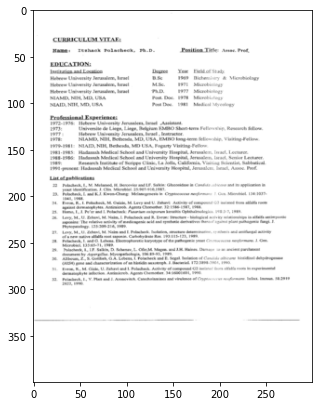

In [19]:
image = datasets["train"][2][0]
print('max image', image.max())
print('min image', image.min())
print('Image shape:', image.shape)
print('Image .transpose(1, 2, 0) shape:', image.cpu().numpy().transpose(1, 2, 0).shape)


plt.figure(figsize=(5, 10))
plt.imshow((image.cpu().numpy().transpose(1, 2, 0)/2+1))

label = datasets["train"][2][1]
print('label:', label)

target = datasets["train"][2][2]
print('target:', target)

Train batch
Label:     Lorillard   MEMORANI DUM 4 April, 1983 M. Kiernan/E. Morgenthae~ \ L. DeLaura \ RE: Golden Lights (Parent) Product Test Final Report, MRD_#5552/1782   Attached is the final report for the Golden Lights (Parent) Product Test. / BACKGROUND _& OBJECTIVES: JS A re-formulated, stronger tasting Golden Lights blend has been SY developed as a possible replacement for the current product. A modified Satin blend, in the 85's and 100's sizes, has been 4 consumer tested among the franchise and competitive smokers. ” There were differences in the TéN levels as follows: Current 85's - 7 mg. \ t Current 100's - 8 mg. & - Test 85's - ling. : Test 100's = 12 mg. - 4 The purpose of this study was to determine the overall acceptance/rejection of the test product vs. the current product. The criteria for action was that the test product Performs at parity or better against the current product among the franchise. Additionally, the test product must perform significantly better vs. t

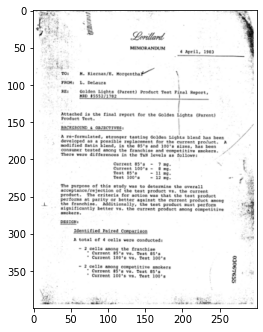

Label: RODGER L BICK, MD, FACP ASSOCIATE CLINICAL PROFESSOR OF MEDICINE (MEDICAL ONCOLOGY/HEMATOLOGY) UCLA CENTER FOR THE HEALTH SCIENCES San Francisco, Callfornia sr21142 Madera Grammer School, Madera, CA Madera Union High School, Madera, CA University of California at Berkeley (Major: Zoology, Minor: Physics/Chemistry) Graduate: University of California at Irvine, School of Medicine, M.D. Degree, June 1970  TRAINING Internship Stroight Medicine, Kern County General Hospital duly 1970 - June 1971, Bakersfleld, CA.  Residency: Internal Medicine, Kern County General Hospital July 1971 - June 1972, Bakersfield, CA. Fellowships: Hematology/Medical Oncology, Department of Medicine School of Medicine, UCLA Center for the Health Sciences, Los Angeles, CA (Director: MartiNnCline, MD) July, 1972 - June, 1973 and 1973-1975 (see below)  Hematology/Medieal Oncology, Boy Area Hematology Oncology Medical Group, West Los Angeles, Santa Monica, CA, July’ 1, 1974 - June 20, 1976 (Director: William L W

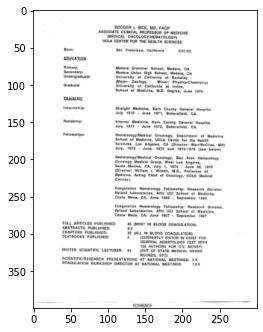

Label: L  FF Pinca IvastguerProgram Oreo ast fet meooy _Lipsky, RH. BIOGRAPHICAL SKETCH ‘Gwe me fotowng intormanon for he kay oersonne! and constants and colaboraers. Begin wah the pncal snvashgaororogram decor. Photocopy a page or each barton,        tae PORTONTME Robert H. Lipsky, Ph.D. Scientist 1 EDUCATION Bop wih Sucatnat © Gta URSA) econ. uch af Rang BRST PERROSAIVOAPT STITUTION AND LOCATION vecnes | conrennco FieL0 OF Stuy Virginia Polytechnic Instrure BSc. 197 Biology, Chemisiry and State University, Blacksburg Medical College of Virginia, Richmond MSc. 1979 Microbiology Cornell University, Ithaca Ph.D. 1983 Microbiol, Genetics    Research and/or Professional Experience 1988- Scientist I, American Red Cross, Cell Biology Department, Rockville, MD : 1987-88 Senior Staff Fellow, Laboratory of Molecular Biology, NINCDS, NIH, Bethesda, MD 1984-87 _Staff Fellow, Laboratory of Molecular Biology, NINCDS, NIH, Bethesda, MD 1983-84 Chemist, Laboratory of Molecular Biology, NINCDS, NIH, 

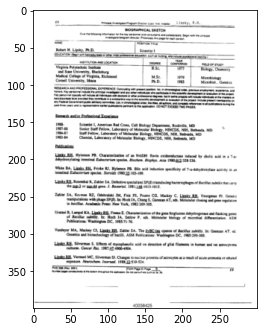

Label: R: REDACTED MATERIAL  EDUCATION Internship: Residency: Fellowships:        Marital Status:  CURRICULUM VITAE RODGER L BICK, MD, FACP ASSOCIATE CLINICAL PROFESSOR OF MEDICINE (MEDICAL ONCOLOGY/HEMATOLOGY) UCLA CENTER FOR THE HEALTH SCIENCES San Francisco, Caltornia saw & Madera Grammer School, Madera, CA Madera Union High School, Madera, CA University of California at Berkeley (Major: Zoology, Minor: ‘Physica/Chemistry) University of Calitornla at Irvine, School of Medicine, M.D. Degree, June 1970  Straight Medicine, Kern County General Hospital July 1970 - June 1971, Bakersfield, CA. Internal Medicine, Kern County General Hospital July 1971 - June 1972, Bakersfield, CA. Hematology/Medica! Oncology, Department of Medicine School of Medicine, UCLA Center for the Health Sciences, Los Angeles, CA (Director: Martin Cline, MD) July, 1972 - June, 1973 and 1973-1975 (see below)  Hematology/Medical Oncology, Bay Area Hematology Oncology Medical Group, West Los Angeles, Santa Monica, CA, 

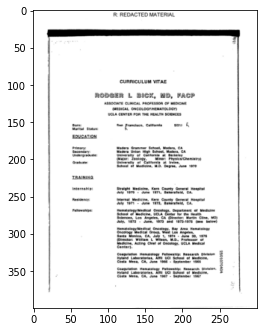

----------------------------------------
Val batch
Label:    045670 THE TOBACCO INSTITUTE 1875 | STREET, SORTHWEST WASHINGTON. DC 20008 045670 97/22/87 Pay   RS ro The onDER oF INDOLLARS ie esaaaeeneeeeSEVENTY-SIX AND 48/100*###HtRH A HERO ® aN DATATINES a : : PARKWAY PLAZA SUITE, 450 er 14000 QUAIL PARKWAY NON - NEGOTIABLE OKLABOHA CITY OK 73134 —— j  S4OGOO30% kewOR 229752"  FOKSE7OR 1  DETACH BEFORE DEPOSITING NOOTHER RECEIPT REQUIRED “ THE TOBACCO INSTITUTE 000354 07/22/87 049870 #75 1 STREET, SORT oC LTT}  WASHINGTON. DC 2 DATATIY       1018017 11018017 1018030 i 06/30/97727ILIUNE | 74.48 74 AD (13043930 74.40 i 76.49 75.48 CONFIDENTIAL: ‘TIOK 0003925 TOBACCO LITIGATION THE TOBACCO INSTITUTE. INC


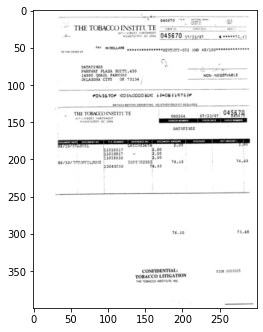

Label:   September 10, 1976 10: DISTRIBUTION  Re: SPRING 1976 NFO DATA Attached are corrected switching tables for Total Salem, and corrected profile books. Please make the appropriate switching substitutions and destroy your old profile books. —_ ene BIK/mg Attachment 


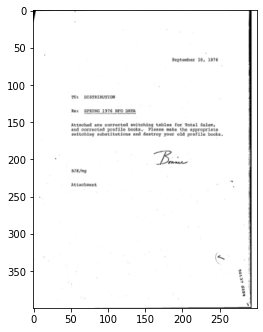

Label: epee Home Testing Institute ad P.O. Box 9200 Port Washington, NY 11050-041 REPORT FORM 1. What anything. did you divi about the citarettes? 2. What anything did you le bout the cigarettes?  5. Beloware painot different phrases which might he wedtodescrethe cigarettes-onephriseutexchside othe ‘page. with hoves numbered 1 to T between eich pur The clover so leel «particule phrase applies fo these ‘iezetes the cloner to that phrase you would pik shox. Please check one las hr euch pair a phrases ‘Oveall {didnot lke the eiearettes at all (1) They did nothave wlot ot este OE) O They didnot hives good este BB Dover. 1 tiked the cizaetes very much BB Di tes mad stot of tate BD © Dither mad seuod tate DD Fi they were nt hart to/my mouth and throat          a They were harsh to my mouth and throat They did not ast asi they were low in tar (OE BD ther tasted ait they were low in tr DB © D they had a good akertte BBD Gi they did not eave «dry tate in oy mouth BD DD D ther dia not burn too t

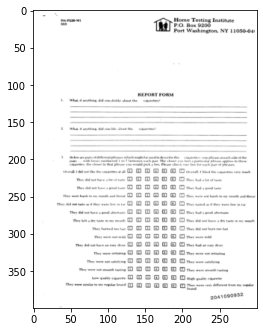

Label: TI1636-0009  ACTUAL 282,681 397,083 1,174,299 67,363 210,045 143,784 0 286,180 2,831,434 BUDGET 236,249 297,325 595,161 78,208 121,366 90,000 0 366,675  -CURRENT MONTH---- VARIANCE 16,432 99.758 579,138 (10,845) 88,679 53.784 ° (80,495) $746,450 The Tobacco Institute Schedule of Expenses November 1994  ---YEAR-TO-DATE- Description ACTUAL 1200 Federal Relations Division 2,344,239 1400 State Activities Division 5.984.451 1300 Public Affairs Division 9.397.854 1500 Media Relations Division 705.908 1100 Admunistration Division 1.428.855 1902 Contingency Legal Fees ‘1.060.466 1901 Contingency General 0 3401 Initiatives Pass Through 12,947,369     BUDGET 2,378,281 5,983,422 4,955,242 772,792 1,295,800 910,000 0 12,987,864 TOTAL $29,789,142 $29,283.371  Tobacco VARIANCE (34,012) 1,029 402,612 (66,884) 133,055, 150,466 oO (80,495) $505,771 nsti  te Only 12/8/94 3:16 ANNUAL BUDGET 2,700,000 6,280,750 5,550,403 851,000 1,593,000 1,000,000 17,597 12,987,864 $30,980,614


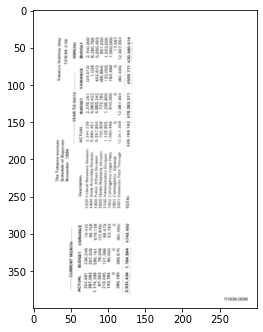

----------------------------------------
Test batch
Label: orignal Message From: Solana, Rik P. ‘Sent: Tuesday, June 12, 2001 5:26 PM To: _ Osborne, Kevin MMC Lega); Driver, Rob E Subjects daft note | want to send this note to Br. Teredesai at INBIFO. Please review und comment ASAP. thanks  Ashok, Since receiving your email and your letter, have given much thought to your comments, ss well as had conversations with Dr. Reininghaus. {Even though I have only been with the company a short time, I can see that asa pathologist you have made valuable Contributions to the organization over the years. We would be remiss in not recognizing those contributions. In addition, one ‘thing that caught my attention when reflecting on your letter was your imuninent retirement date. Considering your well ‘developed technical expertise and how soon we would be losing it, am struck with how important its that we give serious “consideration to how to make the best use ofthe Fimited time you have left. This

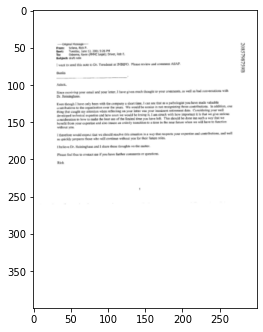

Label:  Where are cigarettes sold? Grocery/supermarkets Vending Specially Tobacco Shops (STS) Bars Convenience/Gas Stations Discount Tobacco Stores Department Stores Internet Other (catalog) Portable venues Customer Distributors Wholesaler Retailer Consumer — End User Consumer © Type of customer + Allwho purchase/use our products Consumers ‘Smokers ~ Age 18-21 & up Pleasure/Legal Habit Vice Legal Older than rest of market More social ~ Bar, NASCAR, DORAL, Clubs Adapt to situation to smoke Occasional Value conscious Some love it and want to smoke --- others always “want to quit” zoze poles RJR0000001355025289 70060 5201  


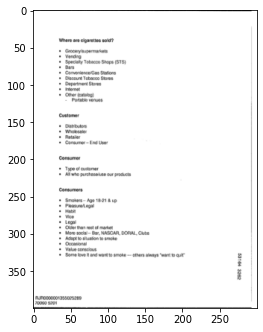

Label: CURRICULUM VITAE Name: David Richard SPRINGALL Date of birth: 29th May 1945 Address: Department of Histochemistry, Royal Postgraduate Medical School, Ducane Road, London W12 0NN Degrees: 1969 - HND, Borough Polytechnic 1971 - MSc, Queen Elizabeth College, London 1979 - PhD, University of Surrey Present post: 1988 to date Lecturer Royal Postgraduate Medical School PUBLISHED ARTICLES 24, Increased intracellular levels of calcitonin gene-related peptide-like 32. 33. 36. 38. 39. immunoreactivity in pulmonary endocrine cells of bypoxie rats. Springall DR, Collina G, Barer G, Suggett AJ, Bee D, Polak JM. J Pathol. 1988;155:259-67 Localization of endothelin-like immunoreactivity in airway epithelium of rats and mice. Rozengurt N, Springall DR, Polak JM. J Pathol. 1990;160:5-8 Immunohistochemical demonstration of human cardiac innervation before and after transplantation. Wharton J, Polak JM, Gordon L, Banner NR, Springall DR, Rose M, Khagani A, Wallwork J, Yacoub MH. Cire Res. 1990;66:

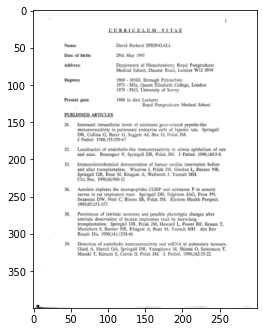

Label: 2085112889 Ostern, Eric  stem, Eric From: Neal Frank {neel@marlinent.com) Sent: Tuesday, June 19, 2001 11:24 AM To: Eric Osten Subject: Work it Out. Hello Eric, ! hope all is well. Can you recommend a good time to call you to discuss the proposal we sent over yesterday. Best Regards...Neal PresidenUCEO ‘Marin Entertainment 787 Third Ave New York,NY 10017 242-888-8890 x28 \www.marlinent.com 2


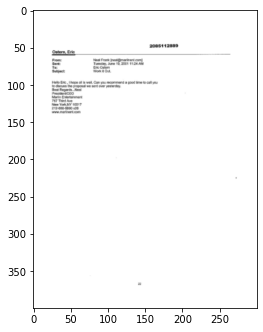

In [20]:
display_dataloaders = {mode: datasets[mode].get_dataloader(batch_size=4, shuffle=True) for mode in MODES}


# Test-load batchs 
train_batch, val_batch, test_batch = next(iter(display_dataloaders["train"])), next(iter(display_dataloaders["val"])), next(iter(display_dataloaders["test"]))

print("Train batch")
for image, label, target in zip(train_batch[0], train_batch[1], train_batch[2]):
    plt.figure(figsize=(4, 10))
    print(f"Label: {label}")
    plt.imshow((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1))
    plt.show()  
print('----------------------------------------')


print("Val batch")
for image, label, target in zip(val_batch[0], val_batch[1], val_batch[2]):
    plt.figure(figsize=(4, 10))
    print(f"Label: {label}")
    plt.imshow((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1))
    plt.show()
    
print('----------------------------------------')    

print("Test batch")
for image, label, target in zip(test_batch[0], test_batch[1], train_batch[2]):
    plt.figure(figsize=(4, 10))
    print(f"Label: {label}")
    plt.imshow((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1))
    plt.show()

In [21]:
del display_dataloaders, train_batch, val_batch, test_batch
gc.collect()

8163

In [22]:
torch.cuda.empty_cache()

In [23]:
import collections

def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

# Definir a classe do modelo usado EfficientT5

In [24]:
"""
Code borrowed with thanks from:
https://github.com/ndrplz/ConvLSTM_pytorch
https://github.com/shreyaspadhy/UNet-Zoo/blob/master/CLSTM.py
https://gist.github.com/halochou/acbd669af86ecb8f988325084ba7a749
"""

import torch.nn as nn
import torch


class ConvGRUCell(nn.Module):
    """
    Basic CGRU cell.
    """

    def __init__(self, in_channels, hidden_channels, kernel_size, bias):

        super(ConvGRUCell, self).__init__()

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.update_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                     kernel_size=self.kernel_size, padding=self.padding,
                                     bias=self.bias)
        self.reset_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                    kernel_size=self.kernel_size, padding=self.padding,
                                    bias=self.bias)

        self.out_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                  kernel_size=self.kernel_size, padding=self.padding,
                                  bias=self.bias)

    def forward(self, input_tensor, cur_state):

        h_cur = cur_state
        # data size is [batch, channel, height, width]
        x_in = torch.cat([input_tensor, h_cur], dim=1)
        update = torch.sigmoid(self.update_gate(x_in))
        reset = torch.sigmoid(self.reset_gate(x_in))
        x_out = torch.tanh(self.out_gate(torch.cat([input_tensor, h_cur * reset], dim=1)))
        h_new = h_cur * (1 - update) + x_out * update

        return h_new

    def init_hidden(self, b, h, w):
        return torch.zeros(b, self.hidden_dim, h, w).cuda()


class ConvGRU(nn.Module):

    def __init__(self, in_channels, hidden_channels, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvGRU, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_channels = self._extend_for_multilayer(hidden_channels, num_layers)
        if not len(kernel_size) == len(hidden_channels) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvGRUCell(in_channels=cur_input_dim,
                                          hidden_channels=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvGRU
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            b, _, _, h, w = input_tensor.shape
            hidden_state = self._init_hidden(b, h, w)

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=h)
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append(h)

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, b, h, w):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(b, h, w))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [25]:
class EfficientT5(pl.LightningModule):

    def __init__(self, params):
        super(EfficientT5, self).__init__()

        self.params = params
        
        override_params = {'dropout_rate':params['dropout_rate'],'drop_connect_rate':params['drop_connect_rate']}

        # Features da efficient net atuarão como as features do encoder do T5
        self.encoder = EfficientNet.from_pretrained(params['enet'], advprop=True, **override_params)
        self.decoder = T5ForConditionalGeneration.from_pretrained(params['t5'])

        
        # self.bridge = ConvGRU(in_channels=40, hidden_channels=self.decoder.config.d_model, kernel_size=(3, 3), num_layers=1, batch_first=True)
        # self.bridge = ConvGRU(in_channels=112, hidden_channels=self.decoder.config.d_model, kernel_size=(3, 3), num_layers=1, batch_first=True)
        self.bridge = ConvGRU(in_channels=int(112/2), hidden_channels=self.decoder.config.d_model, kernel_size=(3, 3), num_layers=1, batch_first=True)

        self.tokenizer = TOKENIZER

    def _get_efn_embeddings(self, images):

        # Shape (N, 112, 16, 16)
        # features = self.encoder.extract_features(images)
        features = self.encoder.extract_endpoints(images)["reduction_4"]
        # features = self.encoder.extract_endpoints(images)["reduction_3"]
        # print('features shape', features.shape)

        features = features.unsqueeze(1)

        
        features = features.reshape(features.shape[0], 1, 112, 25, 19) #best

        features = features.reshape(features.shape[0], 2, int(112/2), 25, 19)

        # Shape: (N, 512, -, -)
        features, last_state_list = self.bridge(features)
        
        features = features[0]

        # Shape: (N, -1, 512) -> Pra ficar do shape de entrada do decoder que é (N, seq_len, d_model)
        efn_embeddings = features \
            .permute(0, 1, 3, 4, 2) \
            .reshape(features.shape[0], -1, self.decoder.config.d_model)

        return efn_embeddings

    
    def _generate_tokens(self, efn_embeddings):
        '''
        Token generation
        '''
        max_length = self.params['seq_len']

        # Add start of sequence token
        decoded_ids = torch.full((efn_embeddings.shape[0], 1),
                                 self.decoder.config.decoder_start_token_id,
                                 dtype=torch.long).to(efn_embeddings.device)
        
        encoder_hidden_states = self.decoder.get_encoder()(inputs_embeds=efn_embeddings)

        for step in range(max_length-1):
            logits = self.decoder(decoder_input_ids=decoded_ids,
                                  encoder_outputs=encoder_hidden_states)[0]
            next_token_logits = logits[:, -1, :]

            # decoding
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
            
            # Check if output is end of senquence for all batches
            if torch.eq(next_token_id[:, -1], self.tokenizer.eos_token_id).all():
                break

            # Concatenate past ids with new id, keeping batch dimension
            decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

        return decoded_ids

    def forward(self, batch): # TODO pro futuro: colocar os dados necessários individualmente e não o batch inteiro
        # Aqui os labels são strings e os tokens são os labels a serem inseridos no decoder
        # print(len(batch))
        images, label, token = batch

        # Output do efn atua como embedding do encoder
        efn_embeddings = self._get_efn_embeddings(images)
        # print('efn_embeddings', efn_embeddings.shape)

        if self.training:
            outputs = self.decoder(inputs_embeds=efn_embeddings,
                                   decoder_input_ids=None, 
                                   labels=token,
                                   return_dict=True)
            return outputs.loss
        else:
            return self._generate_tokens(efn_embeddings)

    def training_step(self, batch, batch_idx): 
        loss = self(batch)
        self.log('loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        return {"pred": decoded_pred, "target": batch[1]}

    def test_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        return {"pred": decoded_pred, "target": batch[1]}

    def validation_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        # n = random.choice(range(len(trues)))
        n_samples = random.sample(range(len(trues)), 4)
        for n in n_samples:
            print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")
        
        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        bleu = sacrebleu.corpus_bleu(preds, [trues])

        self.logger.experiment.add_scalar("val_bleu_score",
                                            bleu.score,
                                            self.current_epoch)
        
        self.logger.experiment.add_scalar("val_f1",
                                            f1,
                                            self.current_epoch)

        self.log("val_bleu_score", bleu.score, prog_bar=True)
        self.log("val_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("val_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)
        self.log("val_exact", exact, prog_bar=True)

        return {'val_f1': f1}

    def test_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        bleu = sacrebleu.corpus_bleu(preds, [trues])

        self.log("test_bleu_score", bleu.score, prog_bar=True)
        self.log("test_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("test_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)
        self.log("test_exact", exact, prog_bar=True)

    def configure_optimizers(self):
        optimizer = adafactor.Adafactor(self.parameters()) # scale_parameter=False # lr=self.params['lr'] relative_step=False, warmup_init=False
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=1)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor':'val_f1'}
    
    def train_dataloader(self):
        return datasets["train"].get_dataloader(batch_size=self.params['bs'], shuffle=True)
    def val_dataloader(self):
        return datasets["val"].get_dataloader(batch_size=self.params['bs'], shuffle=False)   
    def test_dataloader(self):
        return datasets["test"].get_dataloader(batch_size=self.params['bs'], shuffle=False)

In [26]:


model = EfficientT5(hparams)

trainer = pl.Trainer(gpus=1,
                     max_epochs=150,
                     benchmark=True,
                     progress_bar_refresh_rate=20,
                     accumulate_grad_batches=20, # 120 = 20*6
                     check_val_every_n_epoch=10,
                     checkpoint_callback=False,  # Disable checkpoint saving.
                     overfit_batches=4)

torch.autograd.set_detect_anomaly(True)

trainer.fit(model)

trainer.test(model)

del model  # Para não ter estouro de mémoria da GPU
del trainer
gc.collect()
torch.cuda.empty_cache()

Loaded pretrained weights for efficientnet-b0


GPU available: True, used: True
2020-12-12 13:36:42 | INFO | lightning | GPU available: True, used: True
TPU available: None, using: 0 TPU cores
2020-12-12 13:36:42 | INFO | lightning | TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2020-12-12 13:36:42 | INFO | lightning | LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 60.5 M
2 | bridge  | ConvGRU                    | 7.9 M 
-------------------------------------------------------
73.6 M    Trainable params
0         Non-trainable params
73.6 M    Total params
2020-12-12 13:36:42 | INFO | lightning | 
  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 60.5 M
2 | bri


Sample Target: | 2 OFF This mest oe 4 (okel 2.000 FF ne my ram EB soni BMS reli “E 
Prediction:  ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇  


Sample Target: 4 LEO BURNETT U.S.A.  : ADVERTISING . NEWSPAPER ESTIMATE RECKP ~ PNOt PERIOD DATE 03/08/81 01/01/80 70 12/31/80 PAGE 1 CLIENT: P.M. INC. OFFICE: 10 DESC: 703A MARLBORO RED ROP EST NO: 0008 REVISES EST DTD 02/08/91 cross. Ross. Gross PRopucT PeRTOD AMOUNT CHANGE LESS C/D tO-MARLBORO YAN 1990 8,624.00 8,624.00 Fee 25,872.00 28,872.00 mar 68,982.00 8,992.00 QUARTER + 103,488.00 103488 .00 AeR 98,403.06 88,403.06 may 71,868.00 71,868.00 UN 43, 120.00 431 120.00 QUARTER 2 203,301.06 203/391.06 ul 32,472.00 32,472.00 aug 57,024.00 57,024.00 SEP 57,042.82 57,042.82 QuaRTER 3 146,506.82 146,808.82 oct 31,488.30 20,416.00- 31,470.66 Nov 28,160.00 7040.00- 28,160

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning it off for you.
  warnings.warn(*args, **kwargs)



Sample Target: CURRICULUM VITAE:   Name: tzhack Polacheck, Ph.D. Position Title: Assoc. Prof, EDUCATION: Institution and Location Degree Year Field of Study Hebrew University Jerusalem, Israel BSe 1969 Bichemisiry & Microbiology Hebrew University Jerusalem, Israel MSc. 1971 Microbiology Hebrew University Jerusalem, Israel PhD. 1977 Microbiology NIAMD, NIH, MD, USA. Post. Doc. 1978 Microbivlony NIAID, NIH, MD, USA Post Dec. 1981 Medical Mycology Professional Experience: 1972-1976: Hebrew University Jerusalem, Israel ,Assistant. 1973: Universite de Liege, Liege, Belgium EMBO Short-term Fellowship, Research fellow. 1977 Hebrew University Jerusalem, Israel , Instructor. 1978: NIAMD, NIH, Bethesda, MD, USA, EMBO long-term fellowship, Visiting-Fellow. 1979-1981: NIAID, NIH, Bethesda, MD USA, Fogarty Visiting-Fellow. 1981-1985: Hadassah Medical School and University Hospital, Jerusalem, tsracl, Lecturer. 1988-1986: Hadassah Medical School and University Hospital, Jerusalem, isracl, Scnior Le


Sample Target: 203002231 PRODUCED, John Jewell (Last) NeRrotGrabsnn-ttast) NICK BROOKES C. L. SCHOENBACHLER MICK MCGRAW BOB BEXON JOHN JEWELL TONY BURKE FROM: _ E. PEPPLES  DATE: OCTOBER 22, 1997  RE: lettlement uth Warnings on Certain rduuct  This memo records our recent decision relating to B&W’s policy of including the health ‘wamings required in the U.S. on the export product destined for markets where no local ‘warning is required. ‘The June 20 agreement calls for nine warnings to be alternated black on white, white on black, and to appear Canadian-style on the front of each package in an enlarged format. Ifthe June 20 resolution is enacted into law, B&W will continue the voluntary practice of including the health information Congress requires on domestic product on appropriate export packages. We have informed the Senate Commerce Committee about our voluntary policy by letter dated October 22, 1997 to Senator Conrad Bums, copy attached. ‘The present thinking with respect to form


Sample Target: ce Ae mee hee ne ld oh Lorillard Youth Smoking Prevention Program Public Relations Overview Presented by: BSMG Worldwide July 20, 1999 
Prediction:  ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇  


Sample Target:  att, me. Re a dit if Mi ul tine L250bbbg. He Daniel lesa Jamary 23, 1961
Prediction: pate 2 FINAL WED, APR 16, 1986, TEST NUMBER: Arne woe SPECIFICATIONS 1:10 AM (eis) cTooses CLASSIFICATION: CAMEL LT KS TEST PURPOSE: MAKING AND PACKING: REMAKE OF CTOO92S. SPECIFICATION: REMAKE OF CTOO92S CLASSIFICATION: REMAKE OF CTOO92S 860414 @89z 0060S 3


Sample Target:  Fr abi ayaa BRITISH-AMERICAN TOBACCO COMPANY LIMITED    19 July 1994 TGMBTM Dr. S. Appleton, Brown & Williamson Tobacco Corp., 2600 Weaver Road, SUL 27 944 P.O. Box 1056, LKW. Macon, Georgia 3128, ve USA.  Dear Scott, Several of us listened recently to a review of the requirements to be met in New Zealand under the Smoke-Free Environment Act of 1990 and the Regulation which defines how this is to be done. The presentation was made by Peter Lorrigan, Legal Counsel of Rothmans New Zealand.  Itis stil believed that by-brand data on additives used is not necessary, but that by-company retum (e.g. Rothmans, Wills, PM) 


Sample Target: FROM WILEY, REIN & FIELDING 1 divessis97 ager Poet WILEY, REIN & FIELDING 1776 K Street, N.W. Washington, D.C. 20006 Phone Number: (202) 429-7000 Facsimile Numbers: (202) 429-7207 or (202) 429-7049 Confidentiality Note [The information contained in this facsimile message is legally privileged and confidential information| intended only for the use of the individual or entity named below. If the reader of this message is not the| intended recipient, you are hereby notified that any dissemination, distribution or copy of this facsimie| message is strictly prohibited. if you have received this message in error, please immadiataly notty us by| telephone and retum the original message to us at the address above via the United States Postal [Sorvico, Thank You.                         Eacsimile Transmission Please deliver immediately to: Ellen Flannery 778-5484 + [Arthur Levine 942-6960 Richard Cooper 434-5470 “Tom Scarlett 737-9329 Mark Berlind 914-336-0374/1617 : [Marc Fire


Sample Target: CURRICULUM VITAE:   Name: tzhack Polacheck, Ph.D. Position Title: Assoc. Prof, EDUCATION: Institution and Location Degree Year Field of Study Hebrew University Jerusalem, Israel BSe 1969 Bichemisiry & Microbiology Hebrew University Jerusalem, Israel MSc. 1971 Microbiology Hebrew University Jerusalem, Israel PhD. 1977 Microbiology NIAMD, NIH, MD, USA. Post. Doc. 1978 Microbivlony NIAID, NIH, MD, USA Post Dec. 1981 Medical Mycology Professional Experience: 1972-1976: Hebrew University Jerusalem, Israel ,Assistant. 1973: Universite de Liege, Liege, Belgium EMBO Short-term Fellowship, Research fellow. 1977 Hebrew University Jerusalem, Israel , Instructor. 1978: NIAMD, NIH, Bethesda, MD, USA, EMBO long-term fellowship, Visiting-Fellow. 1979-1981: NIAID, NIH, Bethesda, MD USA, Fogarty Visiting-Fellow. 1981-1985: Hadassah Medical School and University Hospital, Jerusalem, tsracl, Lecturer. 1988-1986: Hadassah Medical School and University Hospital, Jerusalem, isracl, Scnior Le


Sample Target: 7002 00 OF (2 DOCUMENT CLEARANCE SHEET P (For Original Contracts Only) 2004-00-00 CONTRACT # CONTRACT SUBJECT: \TCHBL 1 COMPANY: |. BEI INS BRAND(s): _CAMEL TOTAL COST: _$528,000 CURRENT YEAR EFO: _($528,000: BRIEF DESCRIPTION: _D. D. BEAN WILL PRODUCE AND DISTRIBUTE UP TO 264,000 CASES _ OF PRINTED CAMEL ADVERTISING ON MATCHBOOKS, PROGRAM] G/L CODE: 04-73-4600-8215-855 LINE ITEM: 200737-072402 *IMPLEMENTOR: _S. B. DRISKE! **BRAND MANAGEMENT: __E. C. LEARY. TRVOICE APPROVAL AUTHORITY INVOICE APPROVAL AUTHORITY  REVIEW ROUTING: DEPARTMENT = ____NAME ___swqwarure __DATE 7G 7-242 ave wouteD FINCL. svcs. OKA GRA 9 INCL. Svcs. OMK/JEL > rf Enso Lpbs EINCL. Svcs. LSS      BRAND E. C. LEARY PROM. OP. T._M. SMITH Kegal TR Gast [Rush __JWO APPROVED BY: £. M, BLACKER  RETURN TO: JAYNE K. APPLEYARD FINANCIAL SVCS. 3RD FLOOR, REYNOLDS BLDG. * Upon commitment approval, implementor has invoice approval authority up to the lesser of $100,000 or the commitment amount. ** Upon commitmen


Sample Target:  is Subject. Gp Leader Brochure Mating for Ris Davie: Per our discussion, we willbe able fo send the opinion leader brochure out to anyone the RDs believe shou'd get it 1 have initially had 500 brochures held aside for this maiing Ifthe RDs forward thelr mailing lists to me, along with their letterhead, we can do a mail merge and sond out personalized letters along withthe brochure We wil need the lists in 2 speorfc format to facltate the mail merge_If you all agree you want to move forward with the mailing, | can have my ‘assistant work with al ofthe RD's assistants to get the lists in the nght format,  Attached 1s a sample ofthe letter we would send under thesr names wv) onsnmte 8L0890¢907
Prediction: Smokers’ Babies: Care Cost High 20$T0W, 0221 (aP)— Intensive sib ae Nes 4a nen Strate e eal e Samat sate a Rerreze ees te eee Sey boat en econ gE SA ne! semen Har aA, ete dig rete ey de epee Soest Poe a icenwatemin Sy ofnentore ieee eg at cago Seetie ie eked ore anit ect


Sample Target: ‘CABARRUS COUNTY EFFECTIVE DATE MARLBORO 100 REGULAR SP RED BRAND CODE-00540 (STD)    03/08/93 ‘STANDARD PRODUCTION CIGARETTE LENGTH 2 99.5 MM FTO TAR + 16.0 M/cIGT 15.5. ~ TOBACCO ROD CIRCUM, : 24.80 mH TOBACCO ROD LENGTH 72.0 mt FILTER LENGTH : 27.5 mn TIPPING LENGTH 31.500 me TOTAL R.T.0. : M80) In. H20 DILUTION TARGET tO 4/- 5.0% TIPPING PAPER /USE UP: 63MM X 3000M CoRK OGL. EO-701 12-WUU-B LASER PERF. REPLACE WITH + 63MM X 300M CORK DGL Ko GSR-757 12-500-A LASER PERF. GLUE ROLLER/ : REFER TO ENGINEERINGS GLUE ROLLER VARIABLE PARTS CATALOG - TIPPING INFORMATION: BY TYPE-TIPPER AND CIGARETTE BRAND-CODE~SPECIF ICATION + BETWEEN ROWS/BAND WIDTH/TPR, CUT LENGTH/ORY PATCH SIZE 2.00 NA: 1 ROW 27.00 8.5 X 20HH TIPPING ADHESIVE : NATIONAL 32-2026 (FORMERLY 72-3146) PVA 61-032-A SEAM ADHESIVE + FULLER WB-3902U PVA 61-HUK-A STD. FILLER - PACK 0.V.: A0012 - 13.00% MARLBORO REGULAR SP CIOARETTE PAPER 1 27.00MM X 6700M 46CU/0.6%/ 100% FLAX 10-775-A tx 2 MINK FOR PRINT DIE AND EX


Sample Target: 
Prediction: 


Sample Target: CURRICULUM VITAE:   Name: tzhack Polacheck, Ph.D. Position Title: Assoc. Prof, EDUCATION: Institution and Location Degree Year Field of Study Hebrew University Jerusalem, Israel BSe 1969 Bichemisiry & Microbiology Hebrew University Jerusalem, Israel MSc. 1971 Microbiology Hebrew University Jerusalem, Israel PhD. 1977 Microbiology NIAMD, NIH, MD, USA. Post. Doc. 1978 Microbivlony NIAID, NIH, MD, USA Post Dec. 1981 Medical Mycology Professional Experience: 1972-1976: Hebrew University Jerusalem, Israel ,Assistant. 1973: Universite de Liege, Liege, Belgium EMBO Short-term Fellowship, Research fellow. 1977 Hebrew University Jerusalem, Israel , Instructor. 1978: NIAMD, NIH, Bethesda, MD, USA, EMBO long-term fellowship, Visiting-Fellow. 1979-1981: NIAID, NIH, Bethesda, MD USA, Fogarty Visiting-Fellow. 1981-1985: Hadassah Medical School and University Hospital, Jerusalem, tsracl, Lecturer. 1988-1986: Hadassah Medical School and University Hospita


Sample Target: 4 LEO BURNETT U.S.A.  : ADVERTISING . NEWSPAPER ESTIMATE RECKP ~ PNOt PERIOD DATE 03/08/81 01/01/80 70 12/31/80 PAGE 1 CLIENT: P.M. INC. OFFICE: 10 DESC: 703A MARLBORO RED ROP EST NO: 0008 REVISES EST DTD 02/08/91 cross. Ross. Gross PRopucT PeRTOD AMOUNT CHANGE LESS C/D tO-MARLBORO YAN 1990 8,624.00 8,624.00 Fee 25,872.00 28,872.00 mar 68,982.00 8,992.00 QUARTER + 103,488.00 103488 .00 AeR 98,403.06 88,403.06 may 71,868.00 71,868.00 UN 43, 120.00 431 120.00 QUARTER 2 203,301.06 203/391.06 ul 32,472.00 32,472.00 aug 57,024.00 57,024.00 SEP 57,042.82 57,042.82 QuaRTER 3 146,506.82 146,808.82 oct 31,488.30 20,416.00- 31,470.66 Nov 28,160.00 7040.00- 28,160.00 Dec, 21,120.00 21, 120.00 QUARTER 4 80,765.30 27,456.00- 80,750.88 TOTAL 594,189.18 27,456.00- 534,168.84 266z6L 0402 |
Prediction: * SOT Inhalation SS Ballot 2505168109 Page 1 of 4 RH Biel Sl xls ele a com (SMTP somal pedo) Cop From: sot@mail.xpet To: haussmann.hansj@pmintl.ch ce: f Subject: SOT Inhalation S$ Ballot 


Sample Target:   | pdr Se aa ll THE EPIDEMIOLOGY OF "SICK PUBLIC BUILDINGS" by THEODOR STERLING and S.KLEVEN De. String a Professor in the Faculty of Applied Science at Sinon Fraser University, Burnaby Bish Colum ‘bia, Cans. He ia Fellow ofthe American College of Epidemioiogy, the Canaan Committe of Scientists and ‘Scholar the American Aasoiatin for Achievement of Ssence and the American Statistical Assocation Ne vn ceeher Mae Sec Kinane a Resch Ans wihTeotr DS Ting Limited, ABSTRACT. ‘The indoor environment of modern buildings, especially those designed for commercial and administrative uses, constitute a unique ecological niche with its own biochemical environment, fauna and flora. Sophisticated con- struction methods, new materials and machinery required to maintain the indoor environment of these enclosed structures produce a large number of chemical by-products and permit the growth of many different microor- ganisms. Because modern office buildings are sealed, the regulation of 


Sample Target:  Fr abi ayaa BRITISH-AMERICAN TOBACCO COMPANY LIMITED    19 July 1994 TGMBTM Dr. S. Appleton, Brown & Williamson Tobacco Corp., 2600 Weaver Road, SUL 27 944 P.O. Box 1056, LKW. Macon, Georgia 3128, ve USA.  Dear Scott, Several of us listened recently to a review of the requirements to be met in New Zealand under the Smoke-Free Environment Act of 1990 and the Regulation which defines how this is to be done. The presentation was made by Peter Lorrigan, Legal Counsel of Rothmans New Zealand.  Itis stil believed that by-brand data on additives used is not necessary, but that by-company retum (e.g. Rothmans, Wills, PM) is needed. The following was agreed in principle as a way in which the requirements could be fulfilled whilst protecting confidentiality: 1. Rothmans, PM and Wills would each file a return by end January 1995 for the calendar year 1994. 2. Each company would file data on product weight by product class (gross weight of tobacco as sold including additives), and


Sample Target:  att, me. Re a dit if Mi ul tine L250bbbg. He Daniel lesa Jamary 23, 1961
Prediction: att, me. Re a dit if Mi ul tine L250bbbg. He Daniel lesa Jamary 23, 1961


Sample Target:  JONES. DAY. REAVIS & POGUE} CLEVELAND. OnIO 4aste   November 15, 1995 Mary F. Ward, Esquire Counsel - RED Account $86655-009-033 R.J. Reynolds Tobacco Company Invoice No. 01510540 Bowman Gray Technical Center 1100 Reynolds Boulevard Winston-Salem, NC 27102  Yo all legai servican rendered  from Septembi  2, 1995 Lhrough “ October 21, 1995 in connaction with Total OSHA Hours Lawyers: J.C. MeBlveen, Jz. Total Lawyer Sollars Raralesals/ Project Assistants J. R. Kent “otal Paralegal Dollars SDRAP/CLADMNDL Doe: 3200,1, © FB6SL TEL O16 ONFTRATD  the Indoor Air Quality (OSEA) matter $ 9,550.00 42.25 Hours errs $ 8,515.00 Moura : 082 $ 1,035.00 Rayon 103 EMOTO: S6-16-812 AN SANOP:AB INS ase nga 10.  LETL ottzs 
Prediction: pate 2 FINAL WED, APR 16, 1986, TEST NUMBER: CT00944 PRIORITY: A REQUESTED BY: COOK


Sample Target: ~N % Test Request Form 6, PRODUCTION/QUALITY. & TECHNICAL SERV: : . %, A. Initiator of Test 4%) Shaker: Date Submited god (9 40 B. Purpose of Test: “Te deuelap cantinl chart lini Satain “colihon i 5 Her “Gn ae1 Biading” —Far TECO        C. Test Procedure (Attach written procedure, if necessary, and appropriate Data/Log Sheets required: . see “attached —_—     D. Test Samples and Lab Analyses Required (Use attached Test Request Data sheet). oert See athached teat eating       E. Scheduling of Test (Describe when, where, and special conditions, if any, required): Sse oftached Teck achline        F. Coordination Needed Between Depart: era meng      Designated Coordinator of Test: —Sheida__Shaheri Mark =Selnson &. Clark. Cc. Sedlmeyer Bb. Ganoe. B.éstes tm. B. Kelley Wa Renton ALL BL Supy's W. Rupe , 3: Hevcley, MTs  
Prediction: 7002 00 OF (2 DOCUMENT CLEARANCE SHEET P (For Original Contracts Only) 2004-00-00 CONTRACT # CONTRACT SUBJECT:  ⁇ TCHBL 1 COMPANY: |. BEI INS BRAN


Sample Target: W008) P-A/13   sv omoee SHOOK, HARDY & BACONLL?. FAX Ont200 Main Stent COVER Kansas City, Missouri 64105-2118 ‘Telephone (816) 474-6550 + Facsimile (616) 421-2708 ROBIN KINSER ‘TELECOPY NO: 804-274-3982 PETER LIPOWICZ TELECOPY NO: (804) 274-2891 EB. "TED" SANDERS TELECOPY NO: (11-41-32 888-8776 MATT WINOKUR TELECOPY NO: 917-663-5849 FROM: LEO DREYER #234 DATE: OCTOBER 15, 1999 Time: (15> ‘SHB Client Matter No.: PHMI.44593 Pages transmitted including eover sheet: ORIGINAL DOCUMENT WILL NOT FOLLOW, 13  ‘Specinl Instruction Ifyou experience any problems, please cal extenston 100D  COMMENTS/MESSAGE: ‘Ths attached is forwarded regarding Toronto. SOOPER, Ty fener ay mma sma laa con gg a alegre | Hunter bee a St) ted ned ee Hae oan ees mee yay ect | ic Scguon ing fon tie arose beet of tps irmcine vay Pea Wosbee ee [esr nn ray yy tn ants au wi |  S0b>bbYZ0z
Prediction: W008) P-A/13 sv omoee SHOOK, HARDY & BACONLL?. FAX Ont200 Main Stent COVER Kansas City, Missouri 64105-2118 ‘T

In [26]:
best_model = "aula12_checkpoints/cloud_reduced_part_final_netupne_adafactor_gpu_model-epoch=7-step=10679.ckpt"
test_model = EfficientT5(hparams).load_from_checkpoint(best_model, params=hparams).cuda().eval()

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


# Avaliação no Teste-set

In [28]:
test_dl = datasets["test"].get_dataloader(batch_size=32, shuffle=False, num_workers=4)

In [33]:
trainer = pl.Trainer(gpus=1,
                     benchmark=True,
                     progress_bar_refresh_rate=20,
                     fast_dev_run=hparams["debug"],
                     accumulate_grad_batches=20, #128,ou 120 = 20*6
                     max_epochs=hparams["max_epochs"])

GPU available: True, used: True
2020-12-30 19:21:27 | INFO | lightning | GPU available: True, used: True
TPU available: None, using: 0 TPU cores
2020-12-30 19:21:27 | INFO | lightning | TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2020-12-30 19:21:27 | INFO | lightning | LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [34]:
trainer.test(test_model, test_dl)


Sample Target: FROM: Ft ines May 19 Bae} AUG 11 sn 90 D5) sep22 suavecr: . OO, a 71 REGION: ru _X PRATIAL, (ONLY IF PARTIAL AEGION CONTINUE WITH DIVISIONIS) SCOPE)  bivision: Fu PARTIAL, DIVISION NAME: DIVISION NAME: Reps DIVISION NAME DIVISION NAME: ers, DIVISION NAME: DIVISION NAME: ners DIRECT ACCOUNTS AND CHAINS HEADQUARTERED WITHIN THE REGION {15+ STORES) STOCKING NO MAVERICK SPECIALS MENTHOL           TROILOR —]_NO. OF ROTOR | WO. OF name or account | _vouume | stones name or accounr | vowume | srones alse Feat ik} Rolo Ze BS. [Die Pouch stl i a Sinter Bros. is Tlo Amery Pretua hs 4a | Te Rete Time jet] G Ts lg Morty baile (ss Lagi 7 Saath a5 | jy 237 : ABS Forte ely GX    (15+ STORES) STOCKING NO MAVERICK SPECIALS MENTHOL       NOOR | NO. OF TOTO “WOOF Name or account | vouume | stores name or account | vowume | stones foewten a SF Liren Dennen r L-prtnt- AB 7 EI VEN Drs Rik-nro Daw 2  A O.           94507733 wavenoa xs Page! of 3 Pages 
Prediction: eee eee eee eee eee eee eee 

[{'test_bleu_score': 23.509334549524233,
  'test_bleu_1': 34.5490127687382,
  'test_bleu_4': 17.08879674551339,
  'test_f1': 0.29393108927928124,
  'test_exact': 0.0064775295003766005}]

**Como observado o modelo atinge um F1 de 29.4%. O que é uma boa performance dado a dificulade do problema.**

**O exact match é baixo, mas isso não um problema pois os labels foram obtidos usando o OCR tesseract que não é 100% confiável**

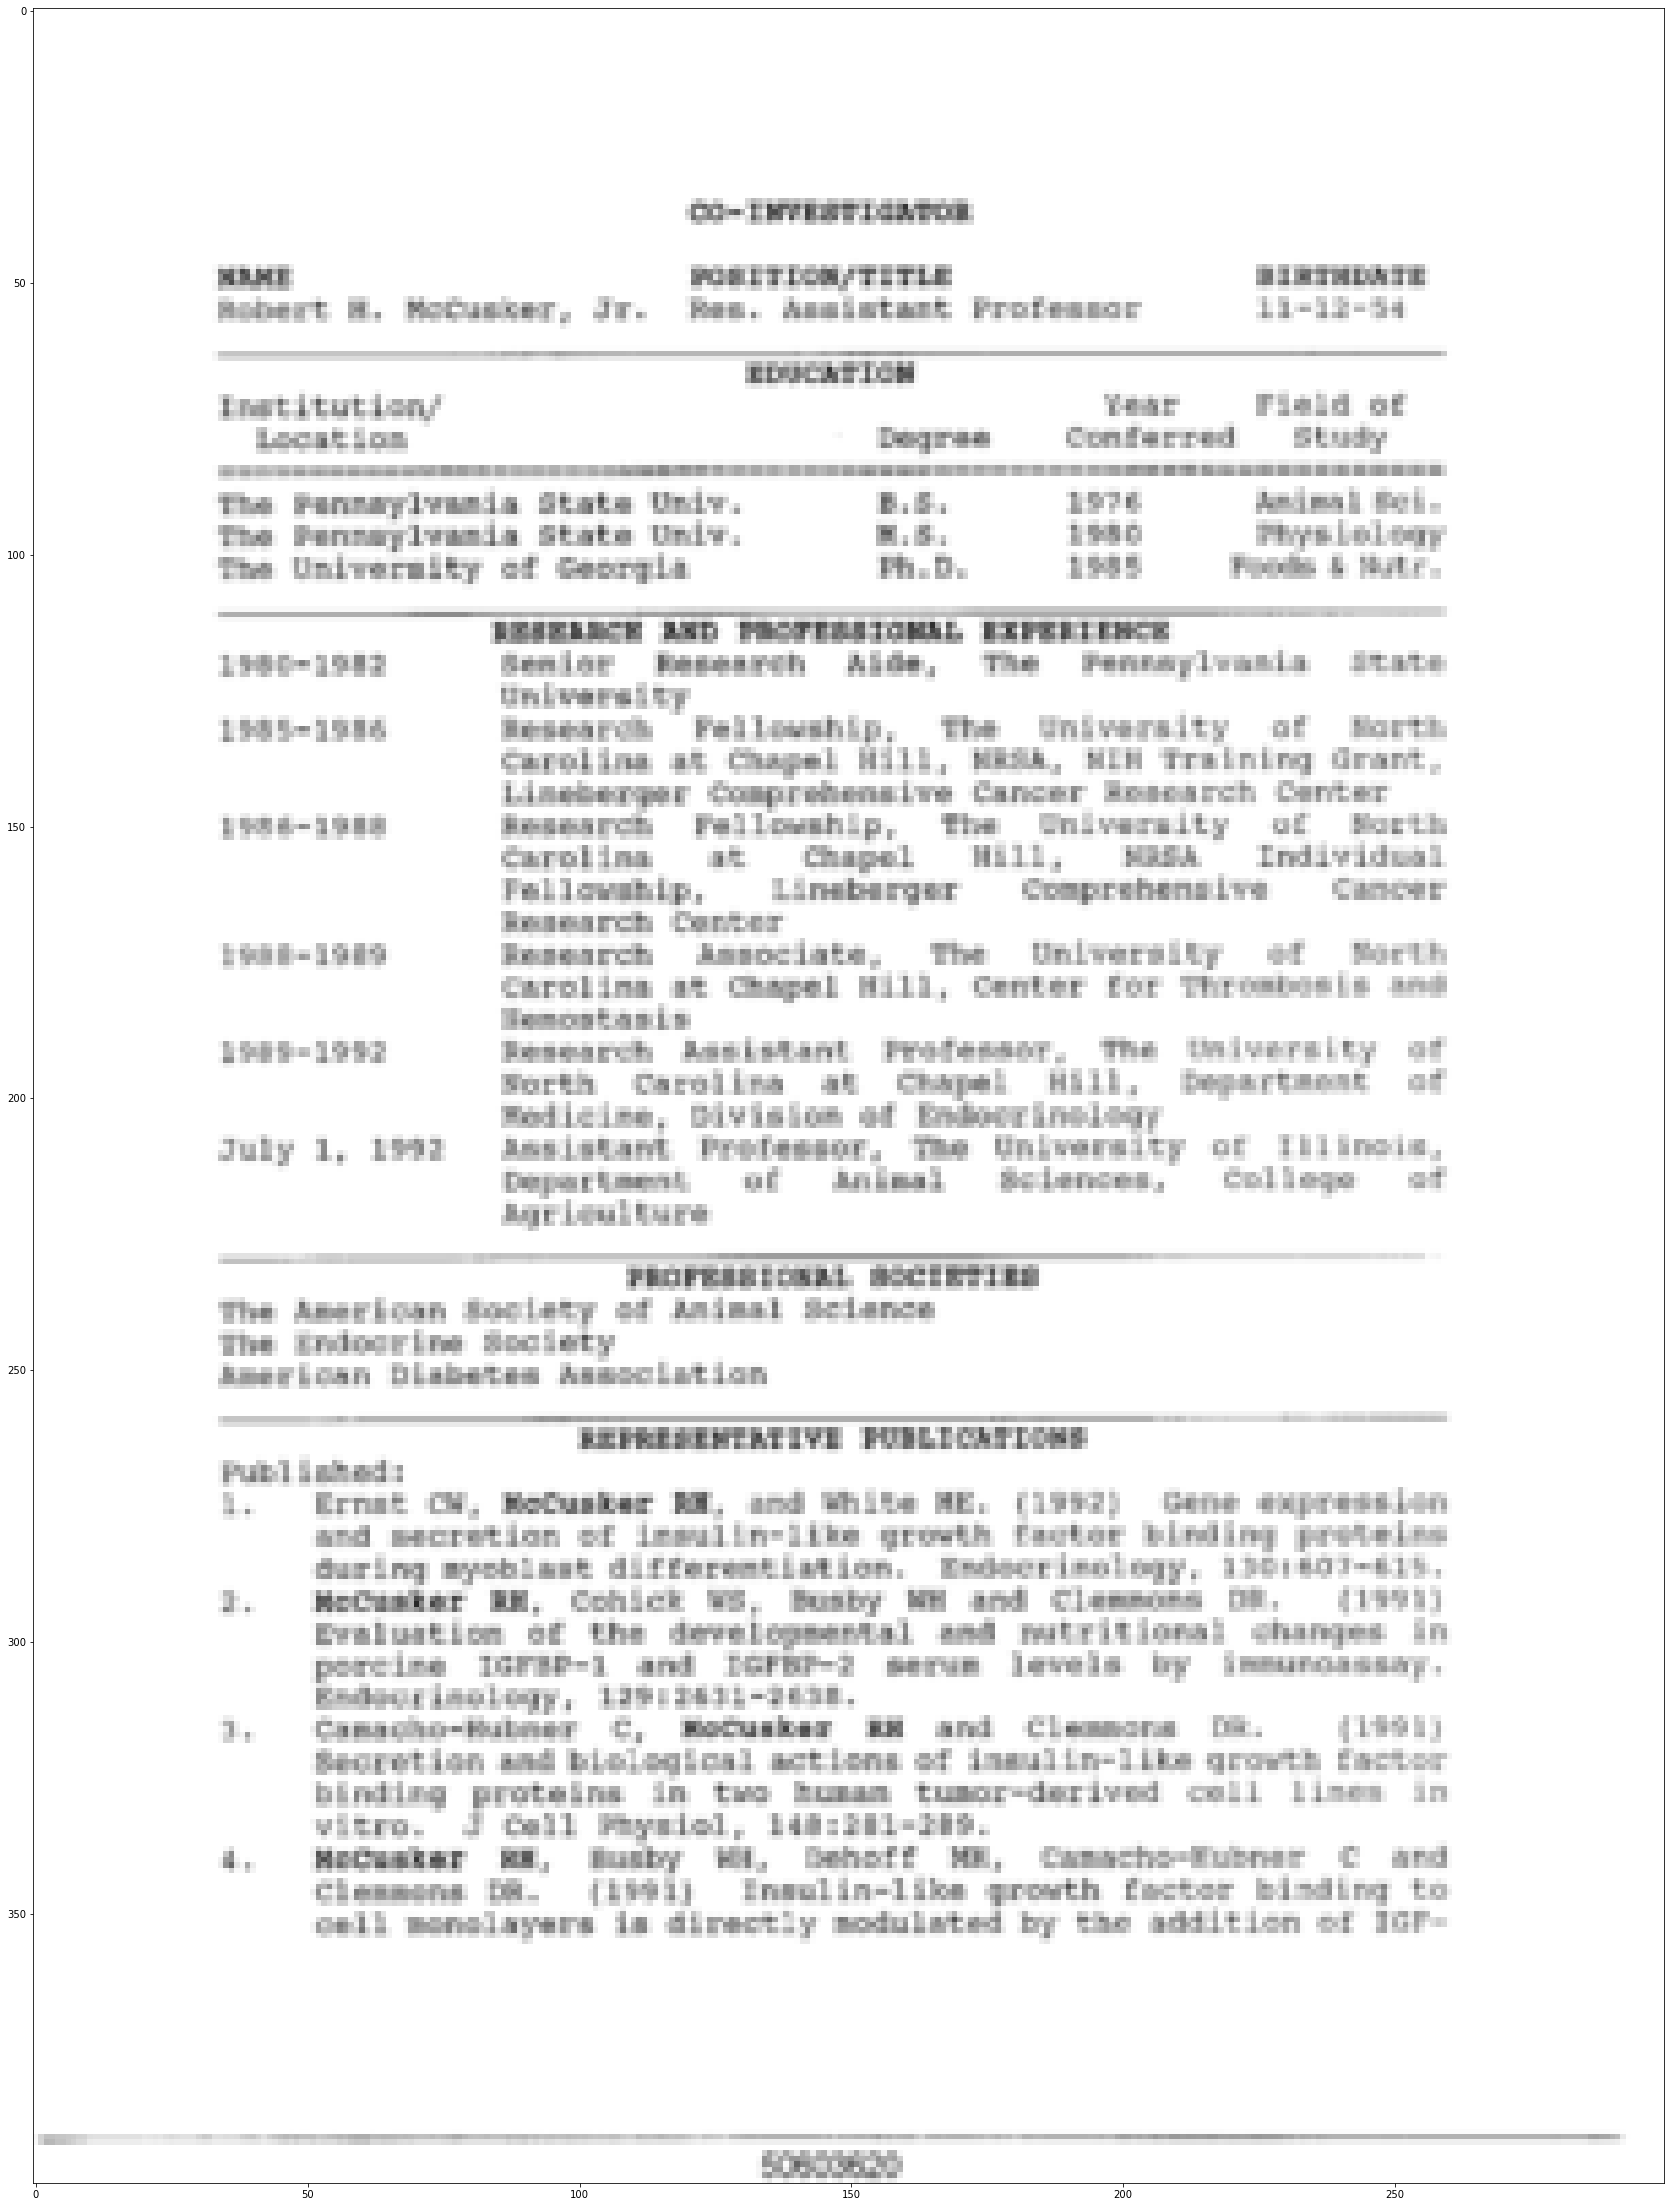

Labels: CO-INVESTIGATOR  NAME POSITION/TITLE BIRTHDATE Robert H. McCusker, Jr. Res. Assistant Professor 11-12-54 EDUCATION Institution/ Year ‘Field of Location Degree Conferred Study     The Pennsylvania State Univ. B.S. The Pennsylvania State Univ. MS. 1980 Physiology The University of Georgia Ph.D. 1985 Foods & Nutr. RESEARCH AND PROFESSIONAL EXPERIENCE 1980-1982 Senior Research Aide, The Pennsylvania state University 1985-1986 Research Fellowship, The University of North Carolina at Chapel Hill, NRSA, NIH Training Grant, Lineberger Comprehensive Cancer Research Center 1986-1988 Research Fellowship, The University of North Carolina at Chapel Hill, NRSA Individual Fellowship, Lineberger Comprehensive Cancer Research Center 1988-1989 Research Associate, ‘The University of North Carolina at Chapel Hill, Center for Thrombosis and Hemostasis 1989-1992 Research Assistant Professor, The University of North Carolina at Chapel Hill, Department of Medicine, Division of Endocrinology July 1, 19

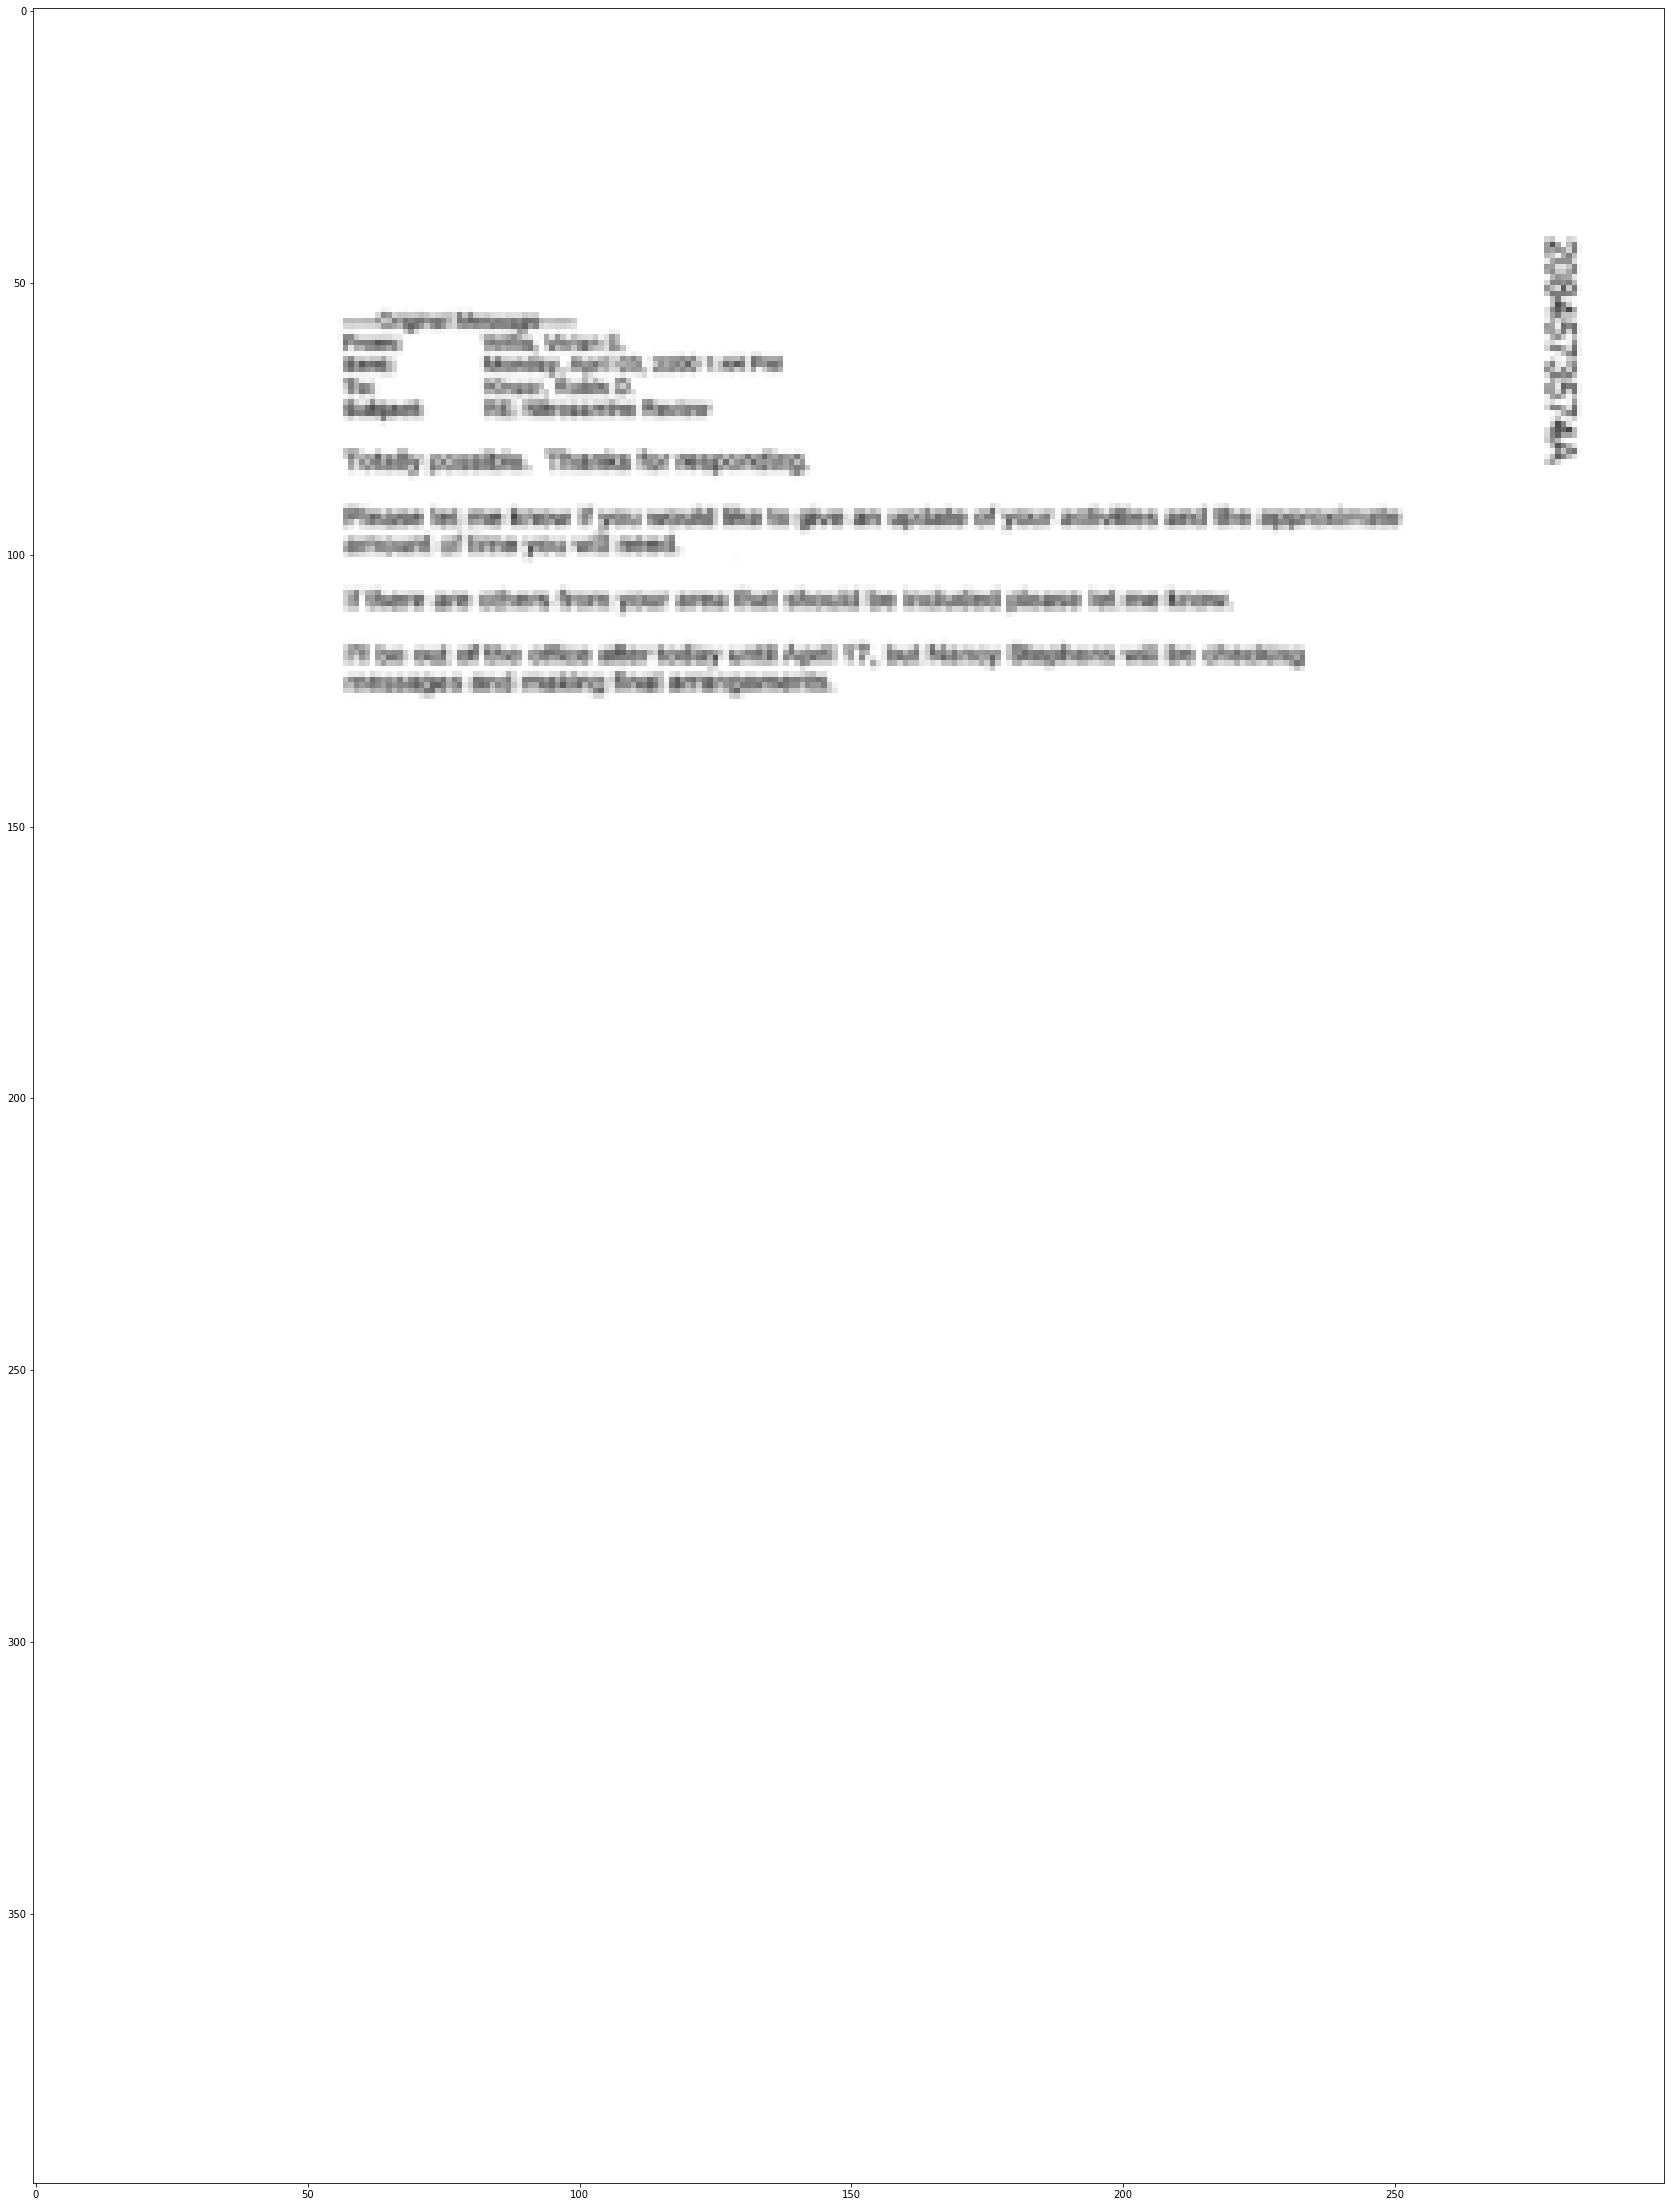

Labels: Original Message From Wile, Vivian Monday, Api 03,2000 1:44 PM ‘nse, Robin RE: Nivesamine Review   Totally possible. Thanks for responding. Please let me know if you would like to give an update of your activities and the approximate amount of time you will need. If there are others from your area that should be included please let me know. 1! be out of the office after today until April 17, but Nancy Stephens will be checking messages and making final arrangements. VPLSELSY80Z
Pred: Original Message— From: ‘Mao, Yuan  ⁇. Sent: Monday, Api 02,2000 1:40 PM Tor ‘Mer, Een Subject: RE: YSP aes Training ‘Today's possible. Thanks for responding. Please let me know if you need the sign as quickly as your solution and the appreciable amount of time you will need. If there are others you need the check for technical please let me know. I'd like all of the office after today and April 17 but Nancy Brosimus will be checking messages and making that arrangements. VLZL6Er807



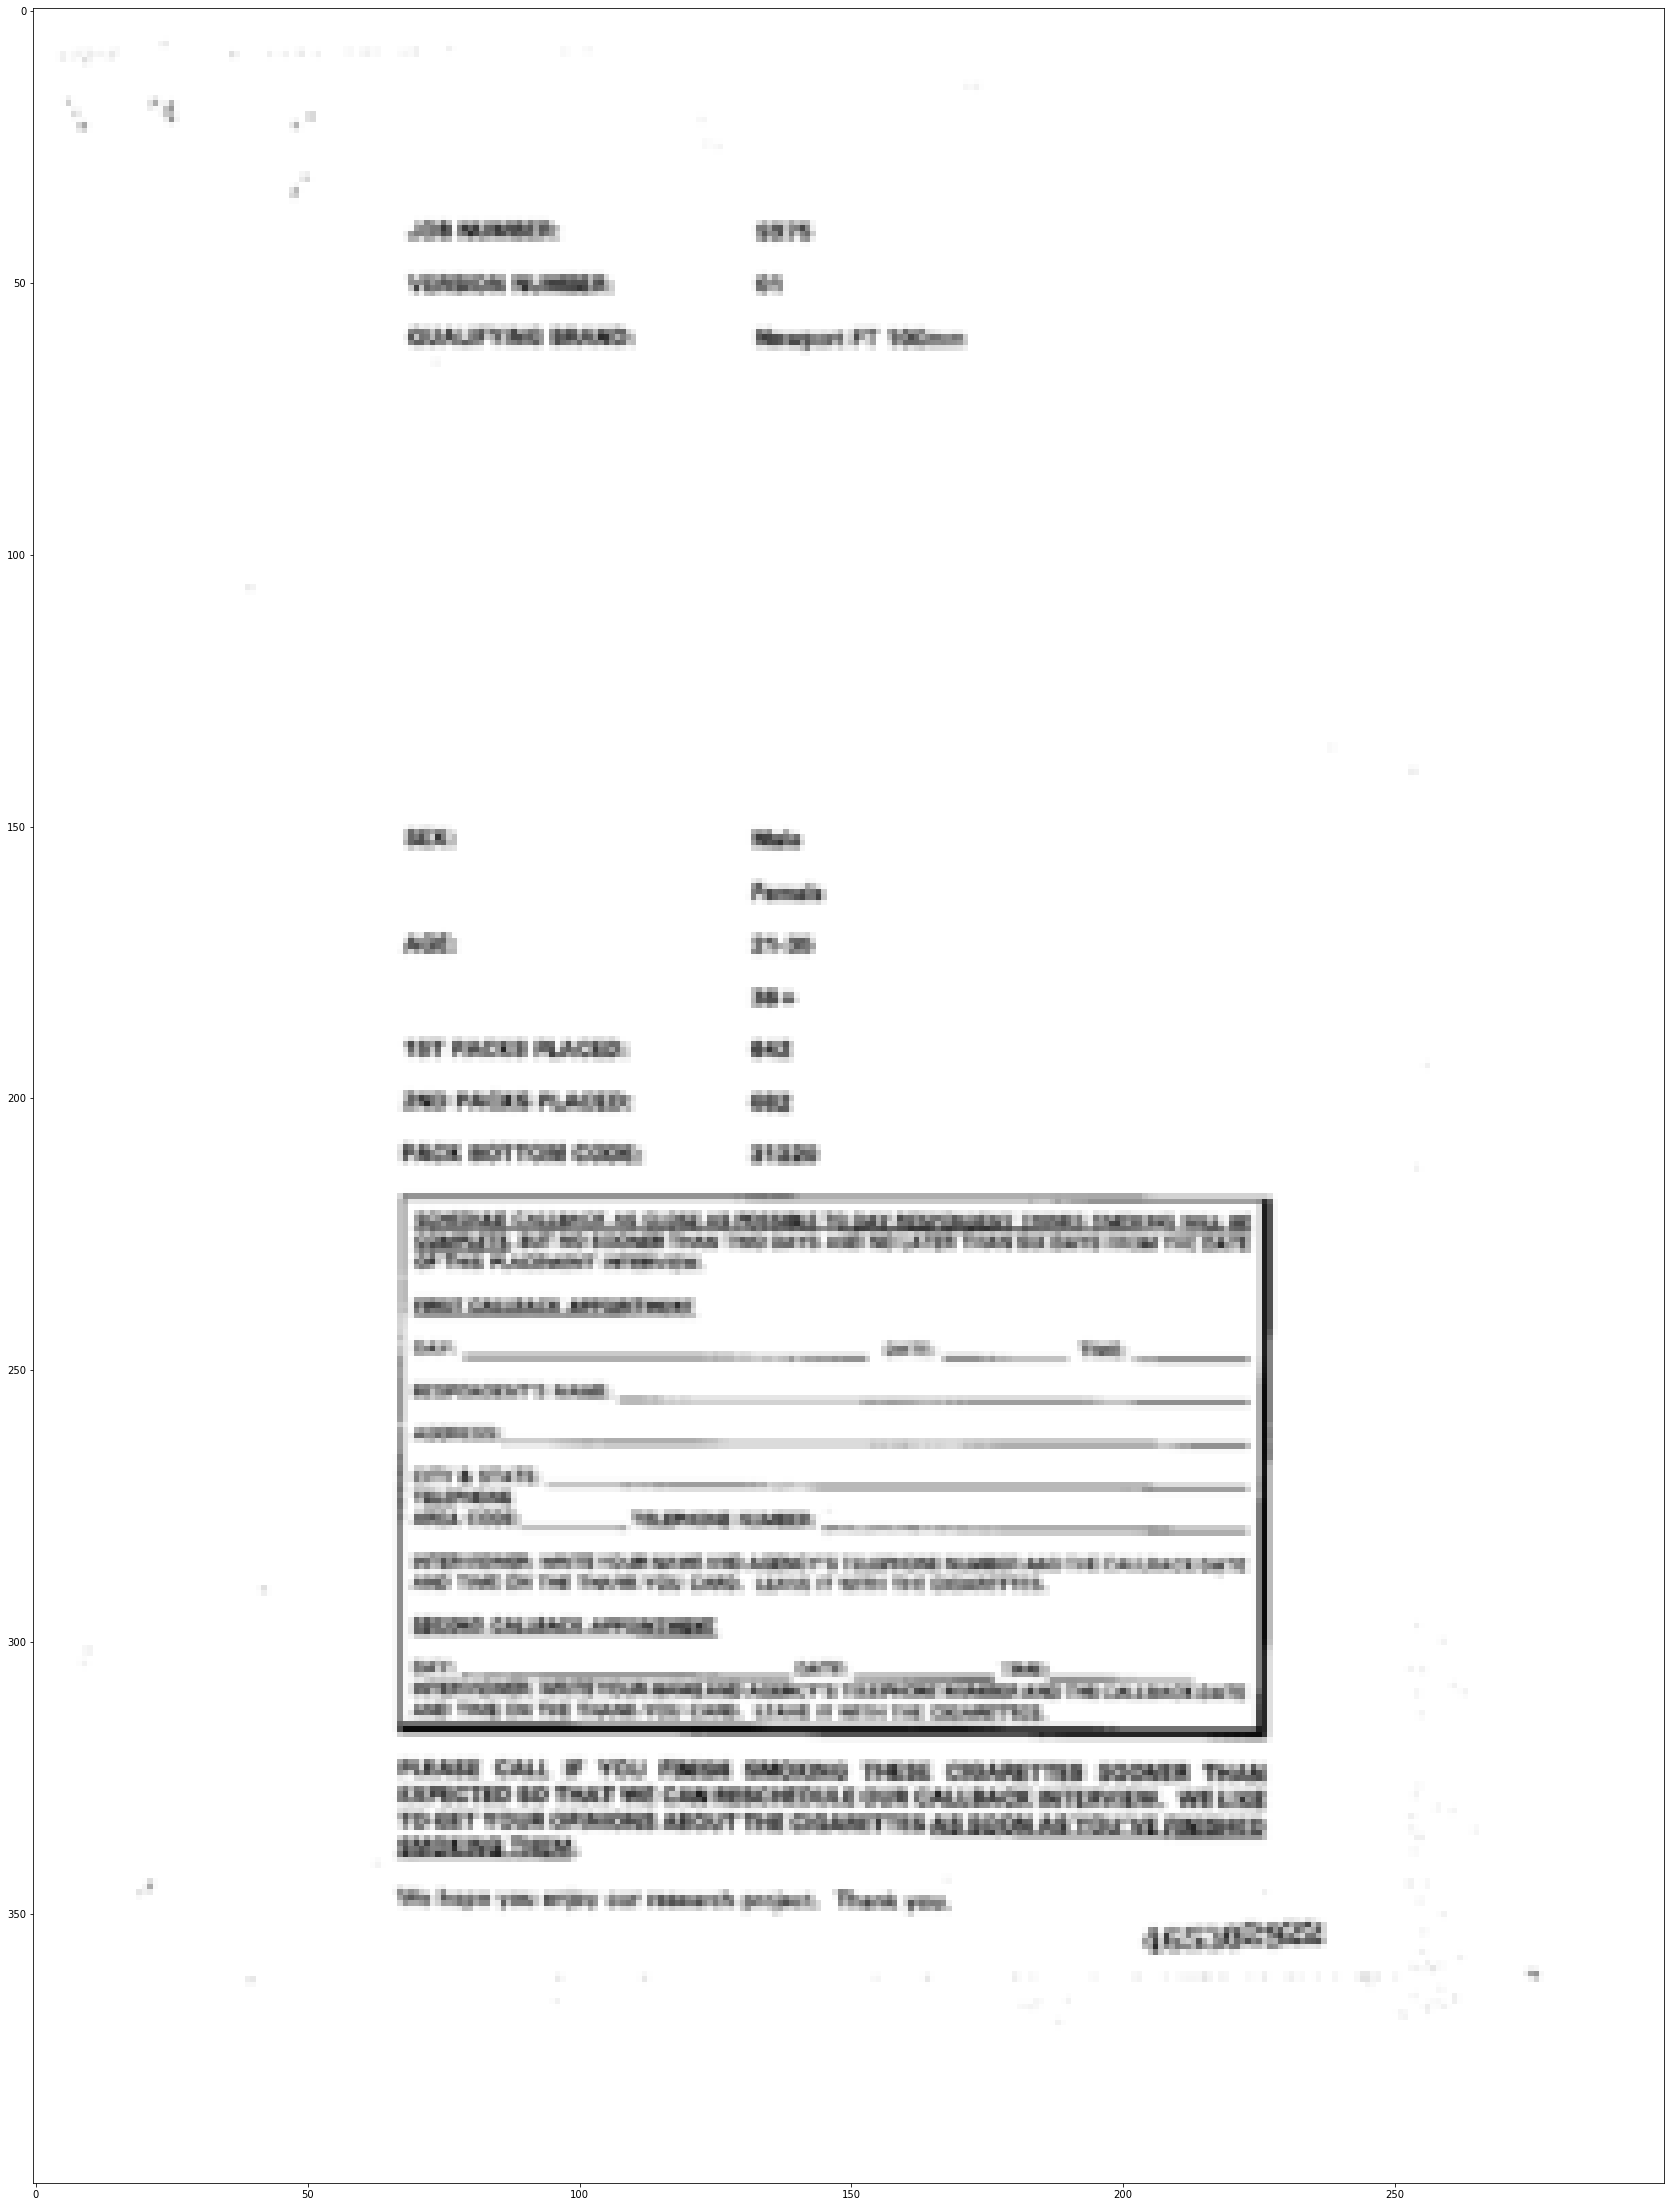

Labels: Jos NUMBER: 3975  VERSION NUMBER: a QUALIFYING BRAN Newport FT 100mm Sex: Maio Female AGE: 2186 38+ 1ST PACKS PLACED: 42 2ND PACKS PLACED: 682 PACK BOTTOM CODE: 1220 ‘SQMBLETE OUT Wo cooNanR TrAW TWO DAYS ARD NO LATER THAN IK DAYS FROMTHE A ‘SETS PEACEMENT INTERVIEW. AREA CODE: ‘TELEPHONE NUMER: VTeRViEWeR: WHITE YOUR NAME ANG AGENCY'S TELEPHONE NUMBER AND THE CALLEACK OATE [AND TIME GN THE THANKYOU CARD, LEAVE IF WH THE CGAMETTES ‘SEGOND cALLeACK arponmTnNT par ase ame INTERVIEWER: WRITE VGUR NAME AND AGENCY TZLERTONE WUMCR AND THECALZBATR OATE AND TE CN THE THANKYOU CAND. LEAVE IT WITH THe CARETTES,  PLEASE CALL IF YOU FINISH SMOKING THESE CIGARETTES SOONER THAN EXPECTED SO THAT WE CAN RESCHEDULE OUR CALLBACK INTERVIEW. WE LIKE TO GET YOUR OPINIONS ABOUT THE CIGARETTES AS SOON AS YOU'VE FINISHED. ‘SMOKING THEM. ‘We hope you enjoy our research project. Thank you.  aessozs22
Pred: JOB NUMBER: R279 VERSION NUMBER: oF QUALIFYING BRAND: Newport FT 100mm SEX: Male Female AGE: 21-35

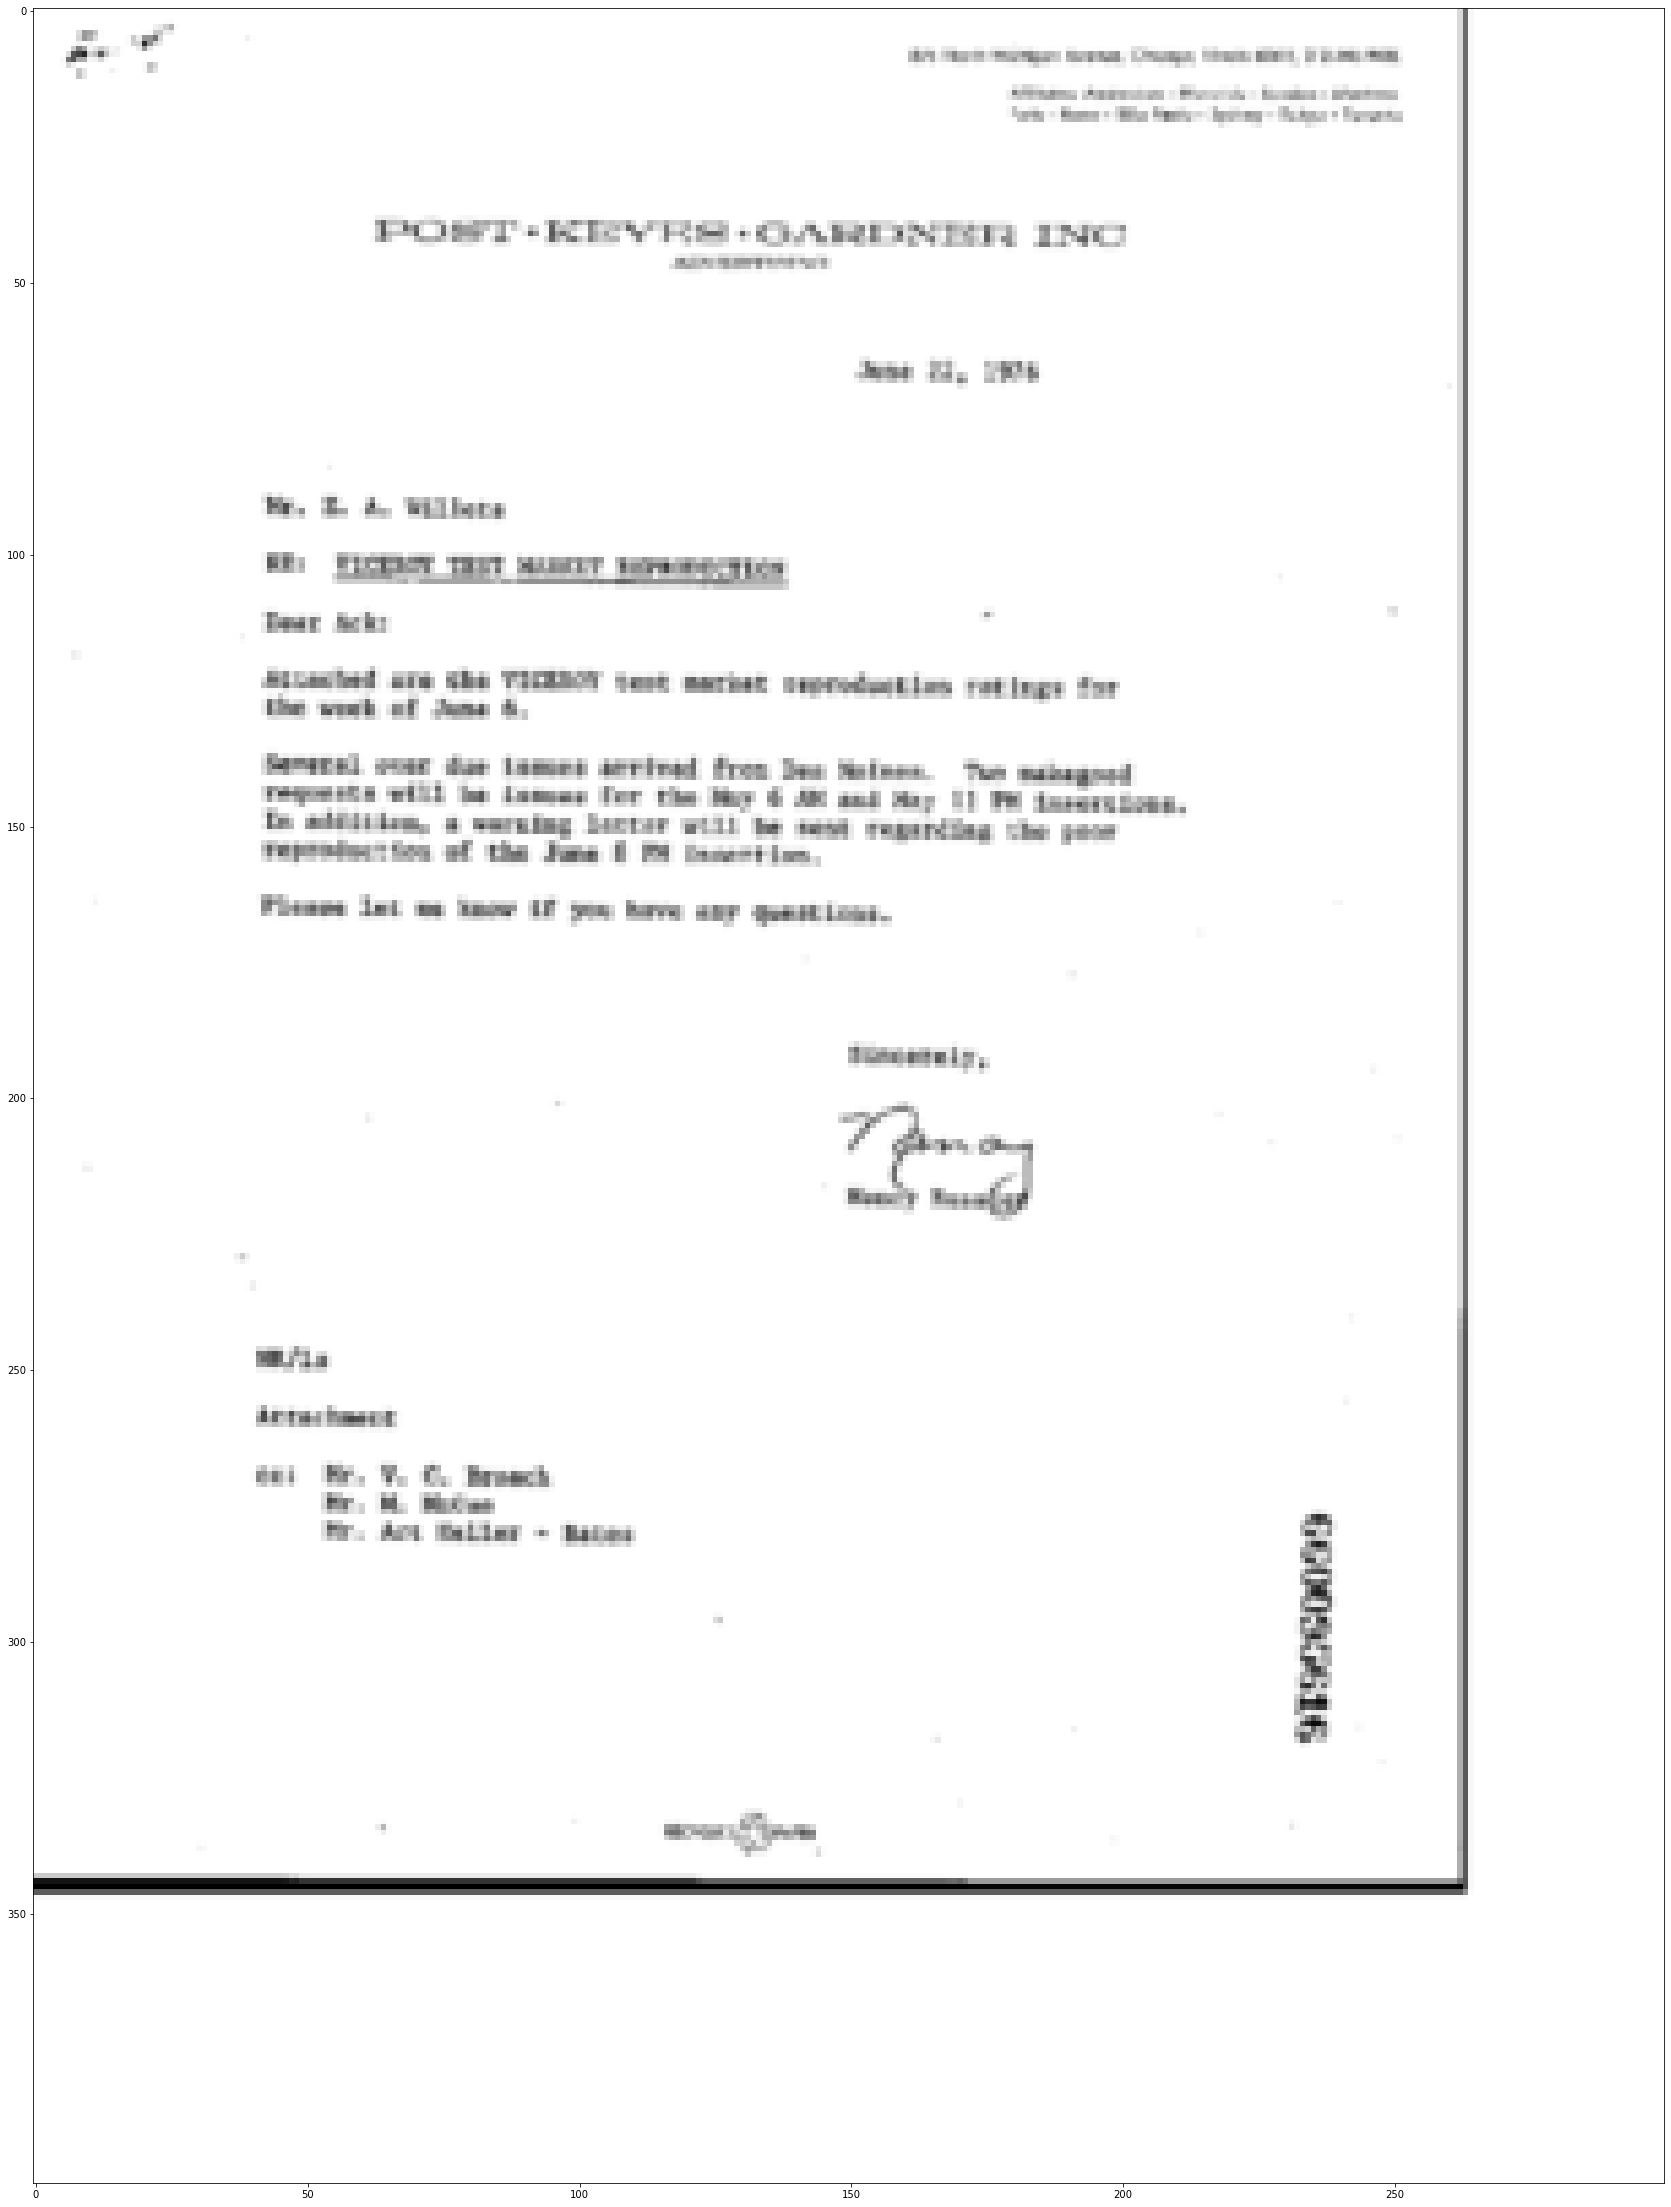

Labels:  Naru Sto faire Spney Tat fora POST-KEYES+-GARDNER INC June 22, 1976 Me. BAL Millets RE: VICEROY TEST MARK  REPRODUCTION Dear Ack:  Attached are the VICEROY test market reproduction ratings for the week of June 6. Several over due issues arrived fron Des Moines. Two makegood Fequests will be isaves for the May 6 AM and May 1) PM dnsert fons. Im addition, a warning letter will be sent regarding the post Feproduction of the June & PM insertion. Please let me know if you have any questions. Sincerely, N/a Attachment cer Mr. V. C. Broach Me. M. Mecue Mr. Act Keller ~ Bates  2 5 : a g n wera  
Pred: a eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee 

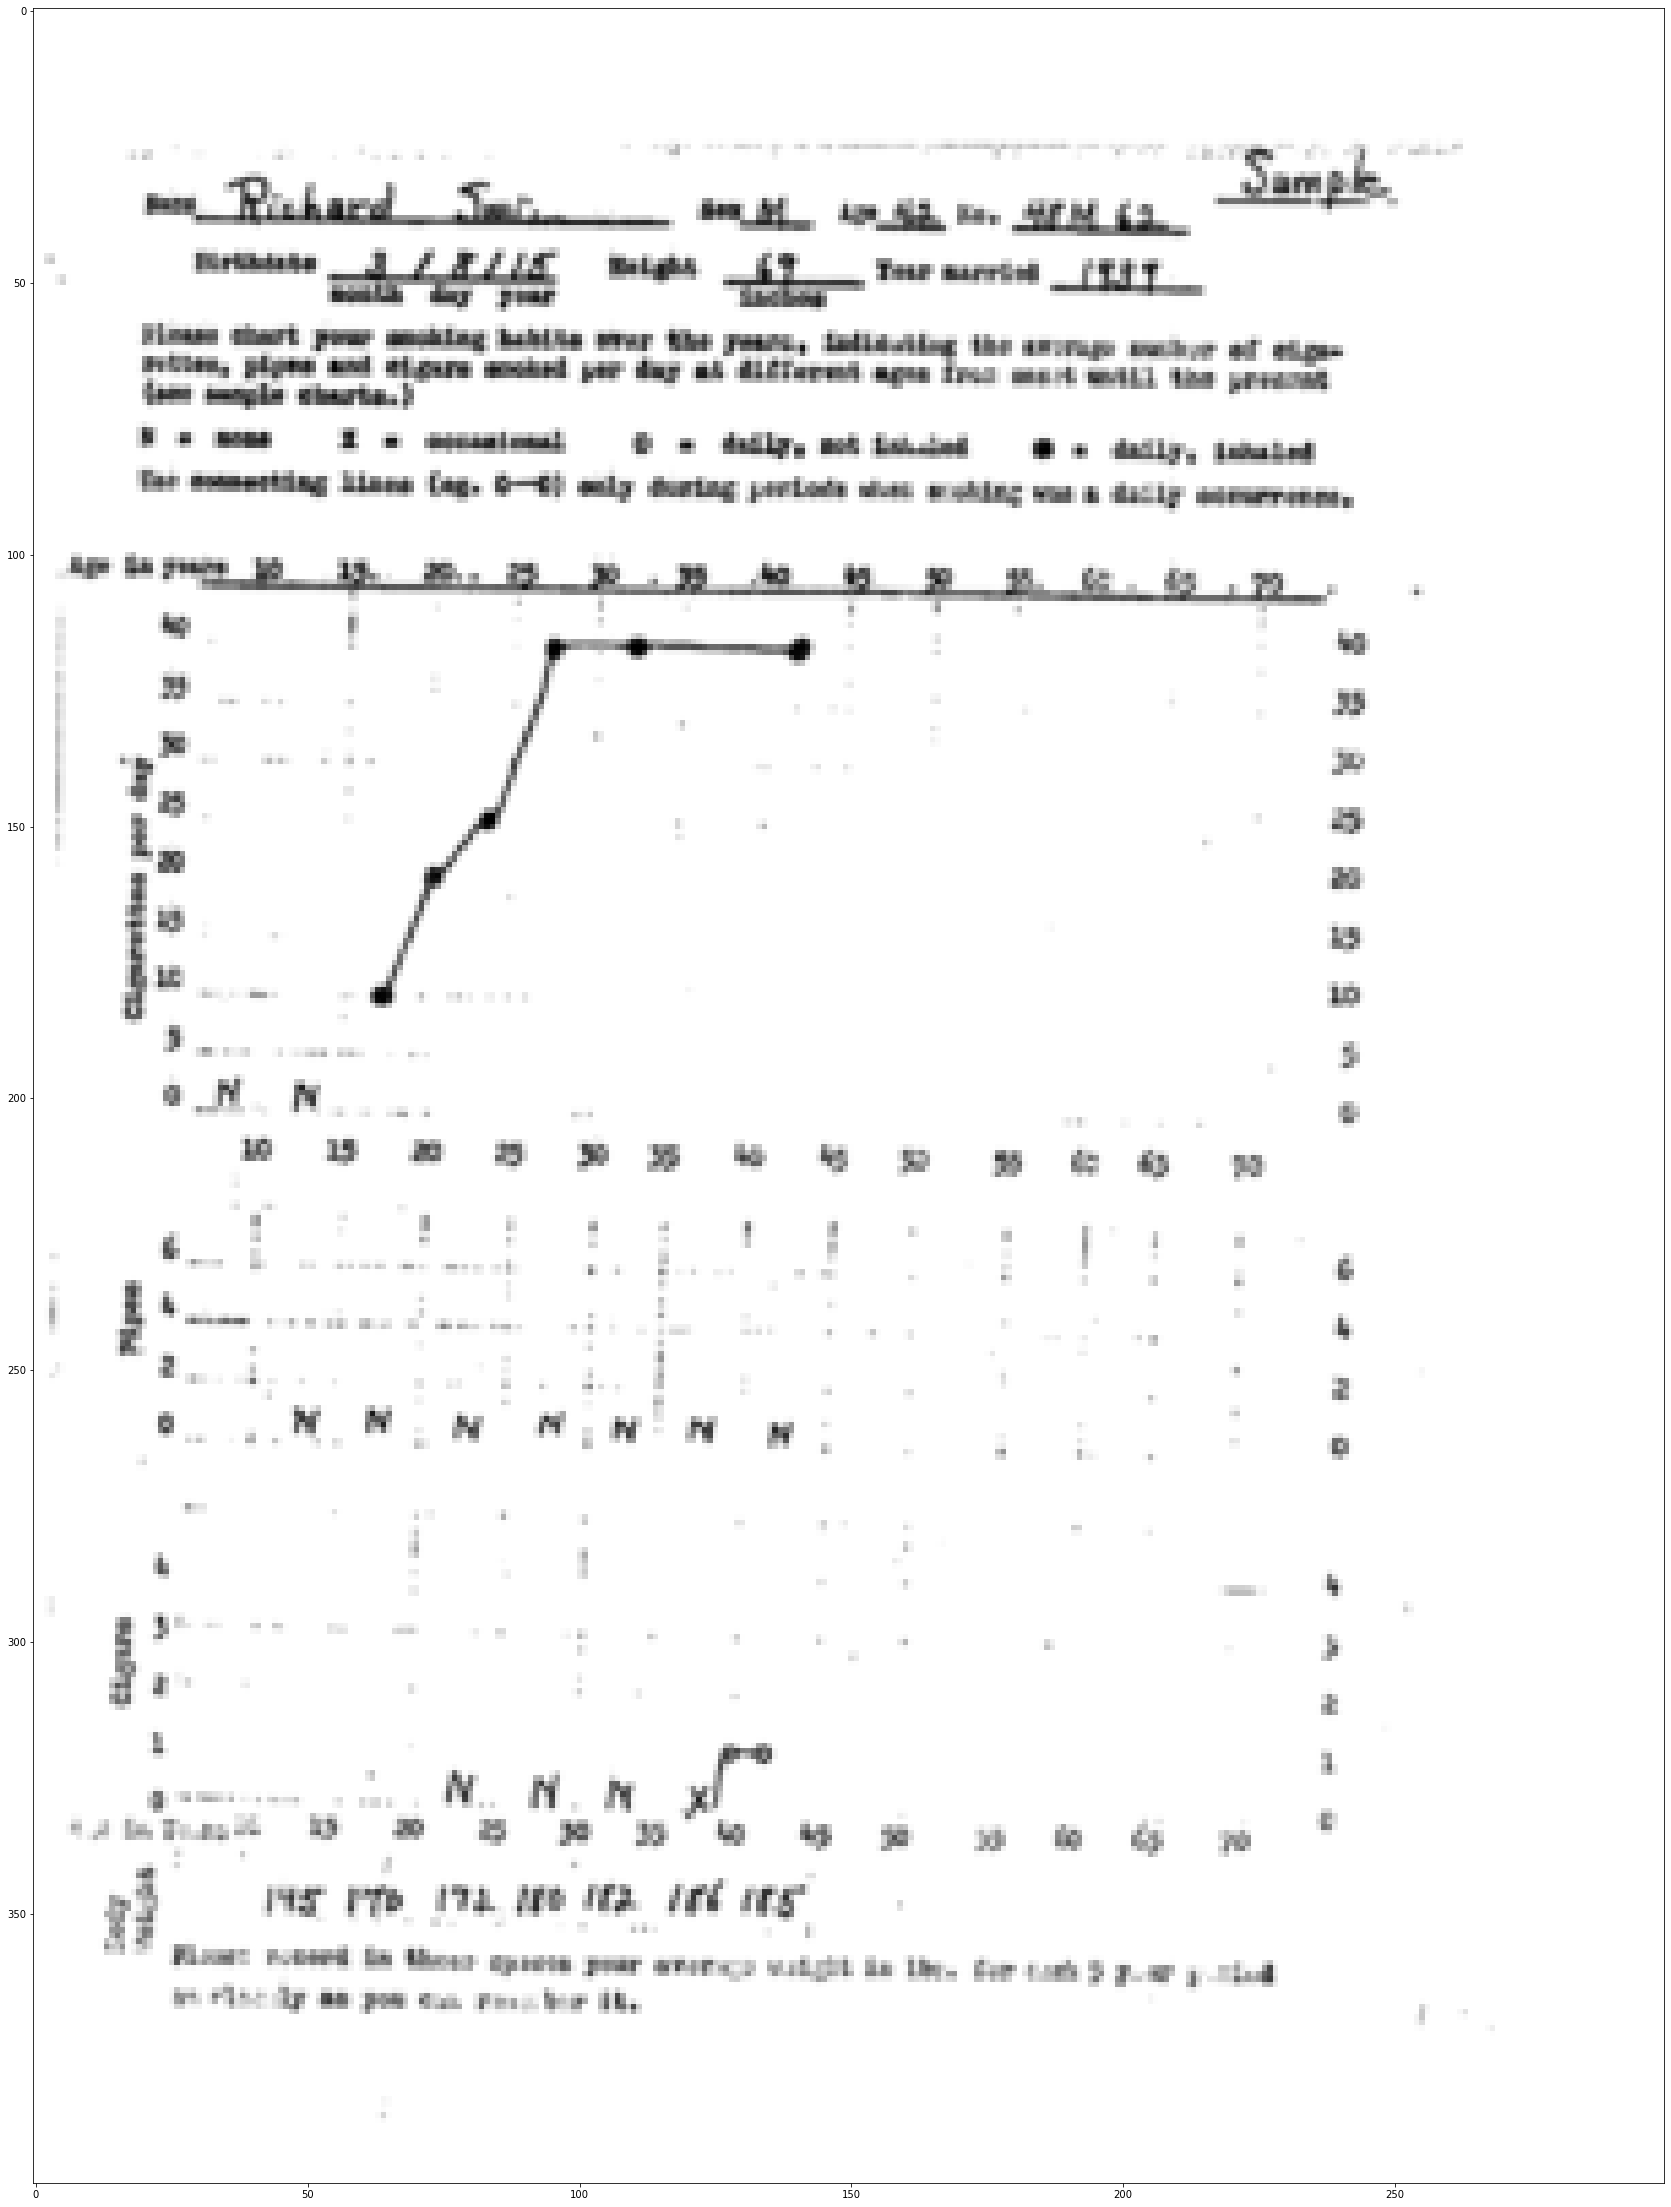

Labels:  nce Richard Sui sx ase dt. toe HEM 62 ststhaate feight Your marriot [£2] aie ae Please chart your encking habite over the yoarc, indicating the average nucbor of eigee rottes, pipes and cigars ecoked yer day at different ages froz onc:t until the precont (eee angle charts.) Ne none = X = occasional © = dafly, not inhiled @ = daily, inhaled Uae connecting lines (og. 0-0) only during yeriods whe: ecoking was a daily oceurrenees       Age 40 years_10 ry 40 | os 5 |» » | 25 5 * » Bas 6 ie : Bo. 5 oN. N . - 6 wo 5 2 SF Dw OO ' rr ‘ ‘ ome oe 6 gee wee Se ‘ 2. Poa.d 2 0. NNN WINN W ; ° 4 : ! — 4 Bhs 3 1 a oo NNO yf? ° © 1 2% 2% 0 55 Ms 55S] IMS PTO 172, 160 Wa. 186 185° eord in these epiezs your avery ws: Ay as you ew, Fr: 5 year parked  
Pred: ...................................................................................................................................................................................................................................................

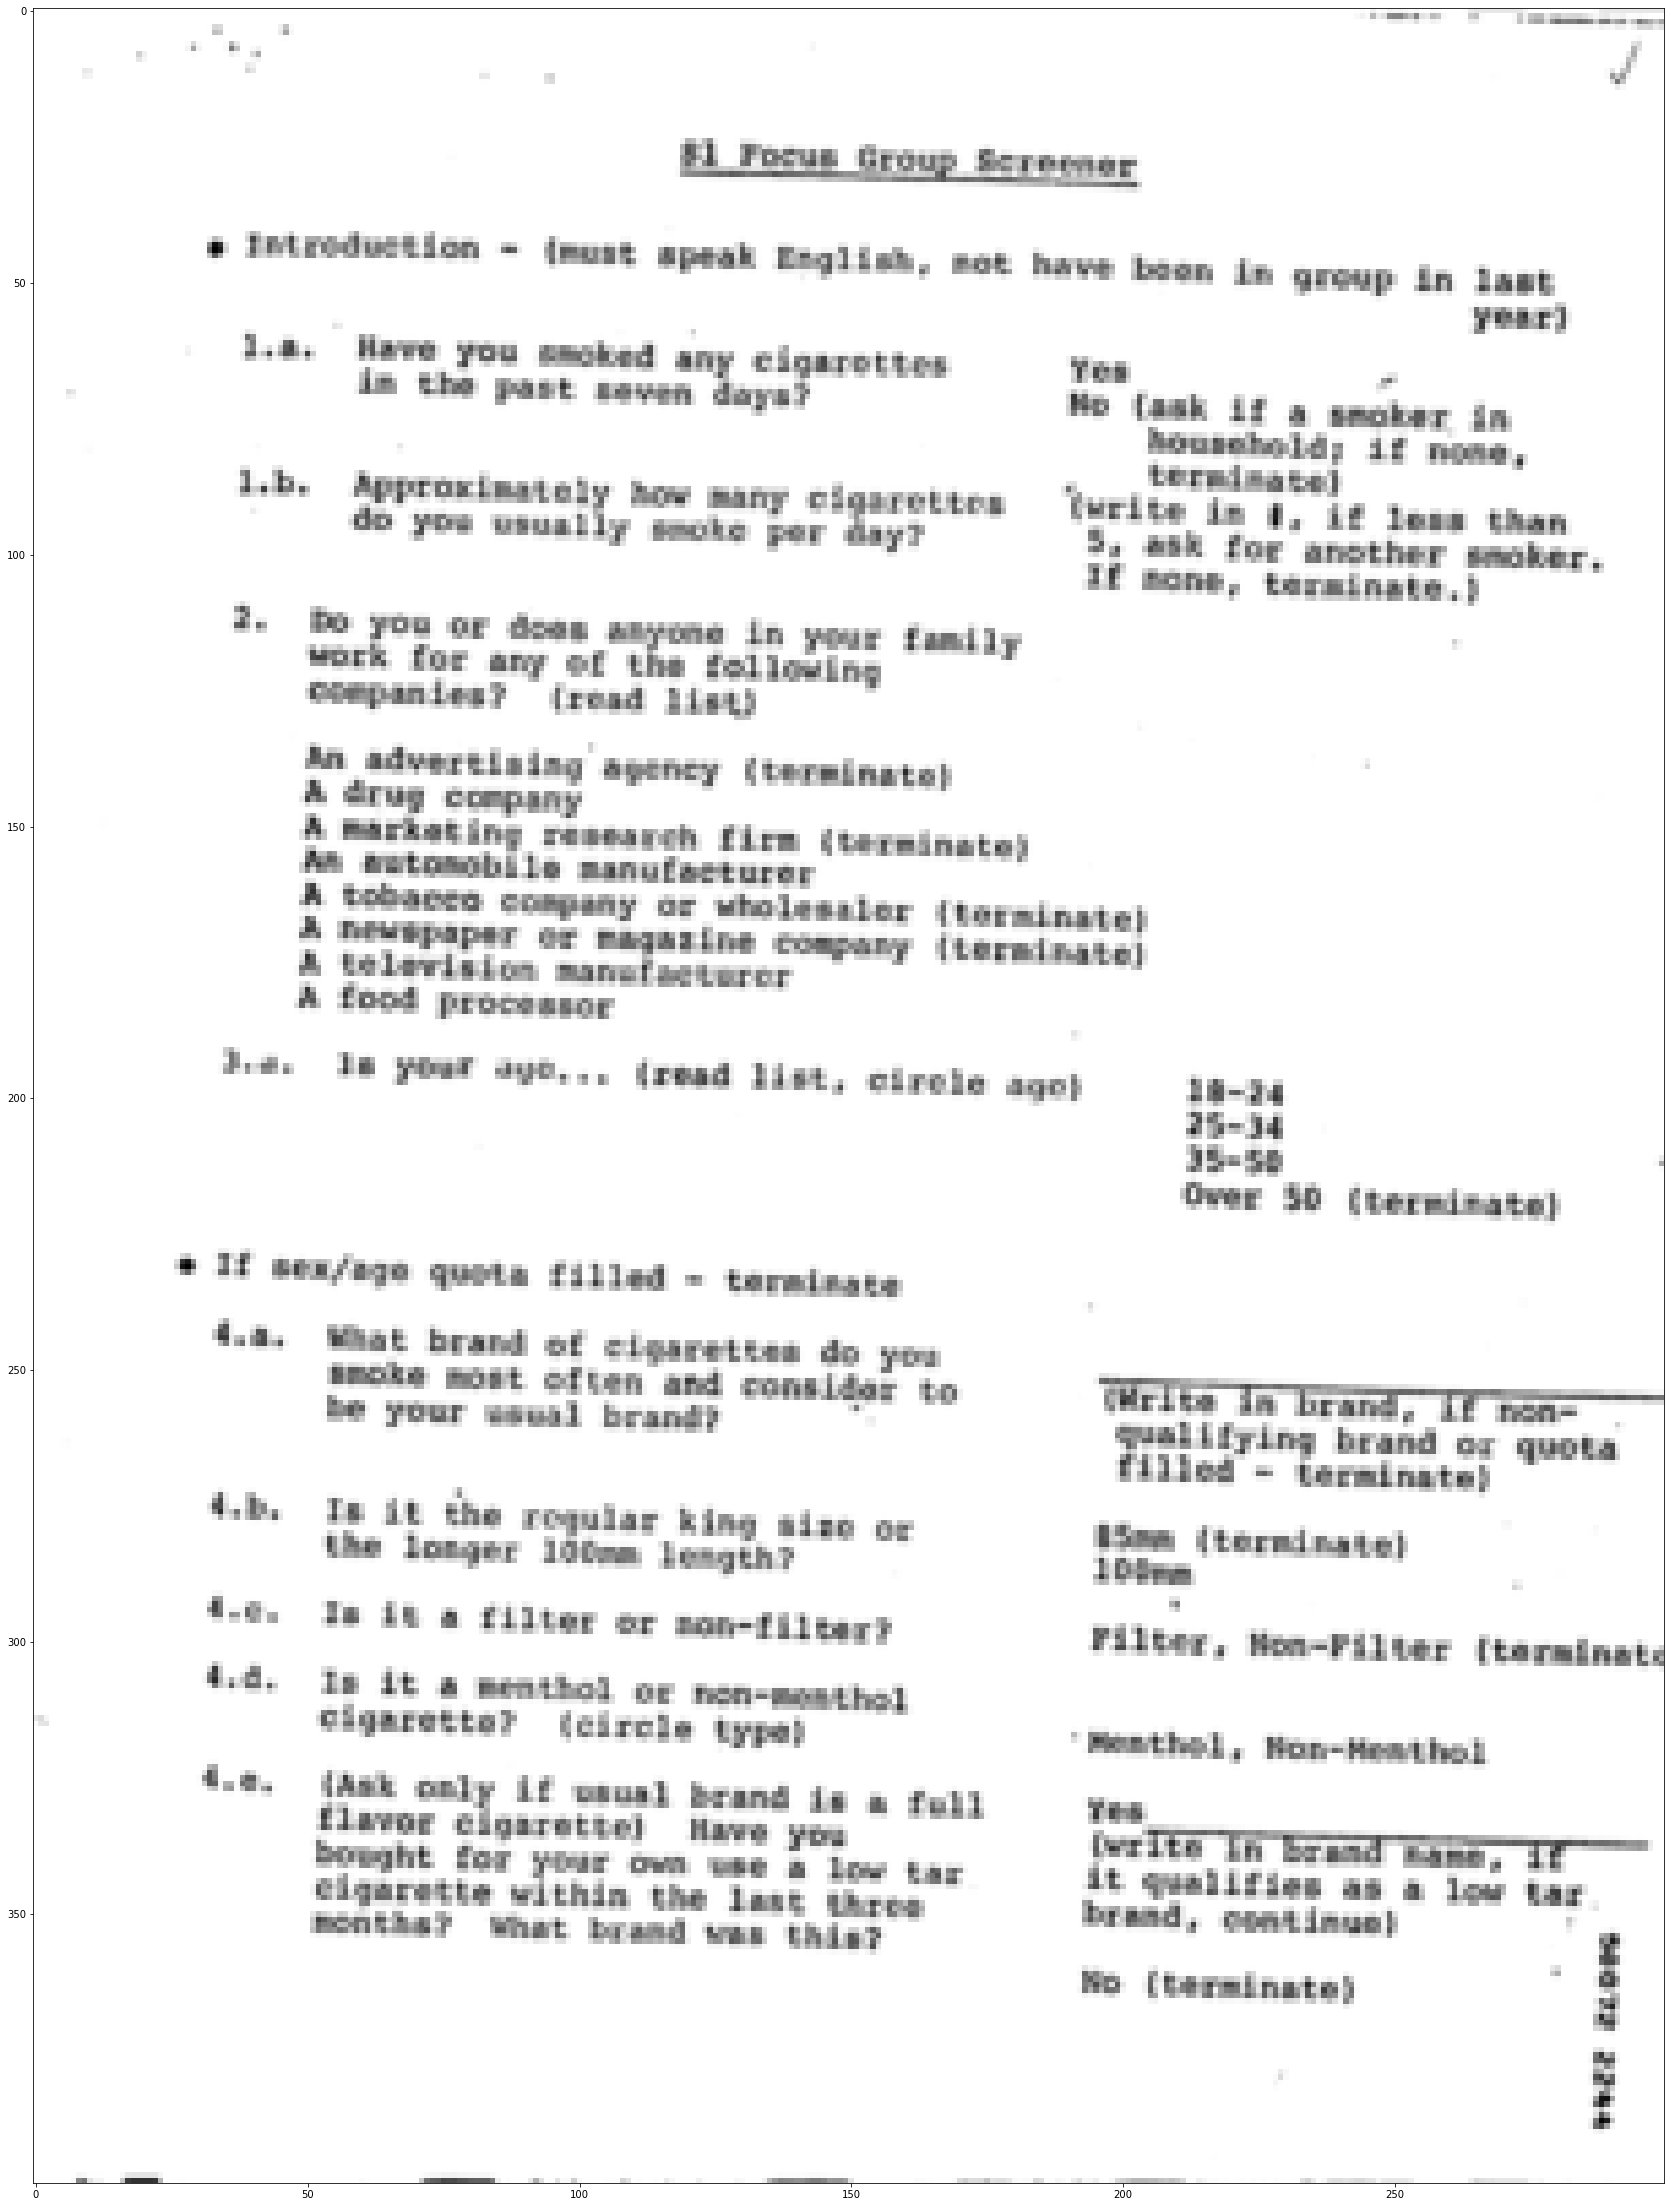

Labels:  $1 Focus Group Screener ¢ Introduction - (must speak English, l.a. Have you smoked any cigarettes in the past seven days? 1.b. Approximately how many cigarettes do you usually smoke per day? Do you or does anyone in your family work for any of the following companies? (read list)  An advertising agency (terminate) A drug company A marketing An automobile manufacturer research firm (terminate) not have been in group in last year) Yes - No (ask if a smoker in household; if none, terminate) (write in 4, i€ less than 5, ask for another smoker. If none, terminate.) 2 tobacco company or wholesaler (terminate) A newspaper or magazine company (terminate) A television manufacturer A food processor ea. © If sex/age quota filled - terminate 4.a, What brand of cigarettes do you smoke most often and consider to be your usual brand? 4.b. Is it the regular king size or the longer 100mm length? 4.c. Is it a filter or non-filter? 4.d. Is it a menthol or non-menthol cigarette? (circle type) 4.e

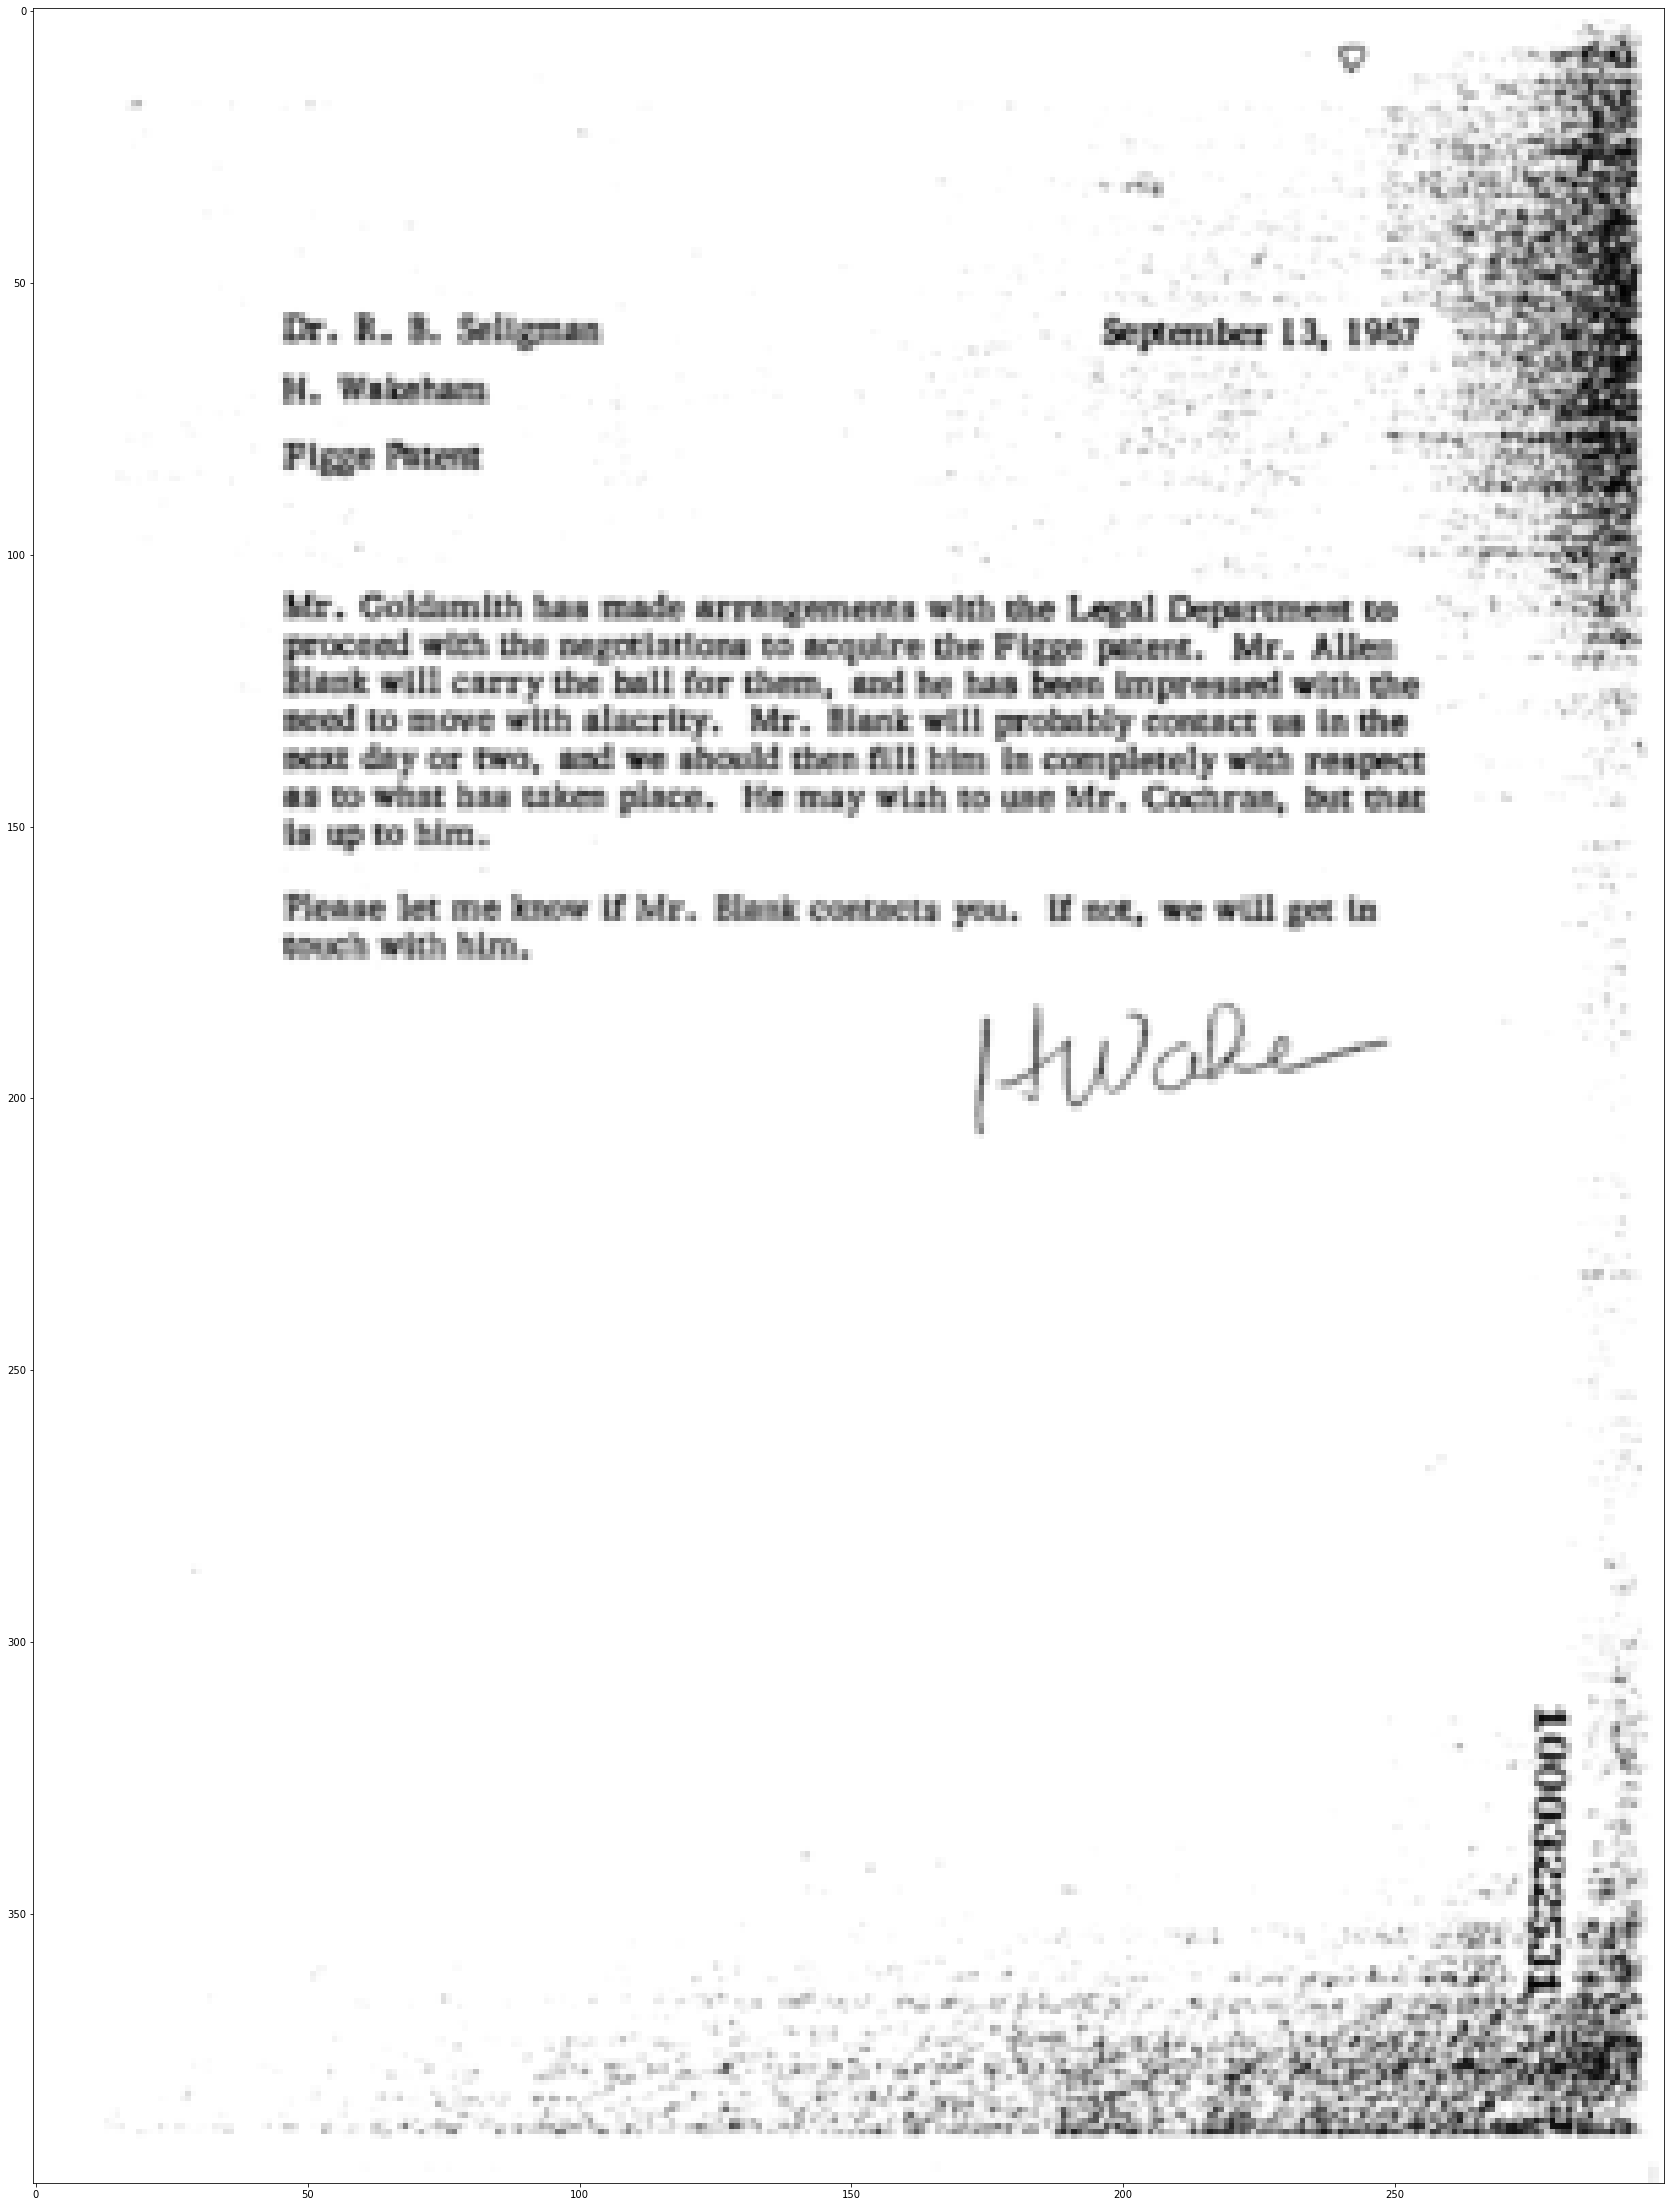

Labels: Dr. R. B. Seligman .. September 13, 1967 H, Wakeham : Figge Patent  Mr. Goldsmith has made arrangements with the Legal Department to proceed with the negotiations to acquire the Figge patent. Mr. Allen Blank will carry the ball for them, and he has been impressed with the need to move with alacrity. Mr. Blank will probably contact us in the next day or two, and we should then-fill him in completely with respect as to what has taken place. He may wish to use Mr. Cochran, but that is up to him. Please let me know if Mr. Blank contacts you. If not, we will get in touch with him. |4Wobe— 
Pred: Dr. R. B. Seligman September 13, 1967 H. Wakeham Phyto Patent Mr. Goldsmith has made arrangements with the Legal Department to proceed with the negotiations to acquire the Phyto patent. Mr. Allen Block will carry the ball for them, and he has been impressed with the need for our work and we should then fill it into completely with respect to our need for our work and we should then fill it i

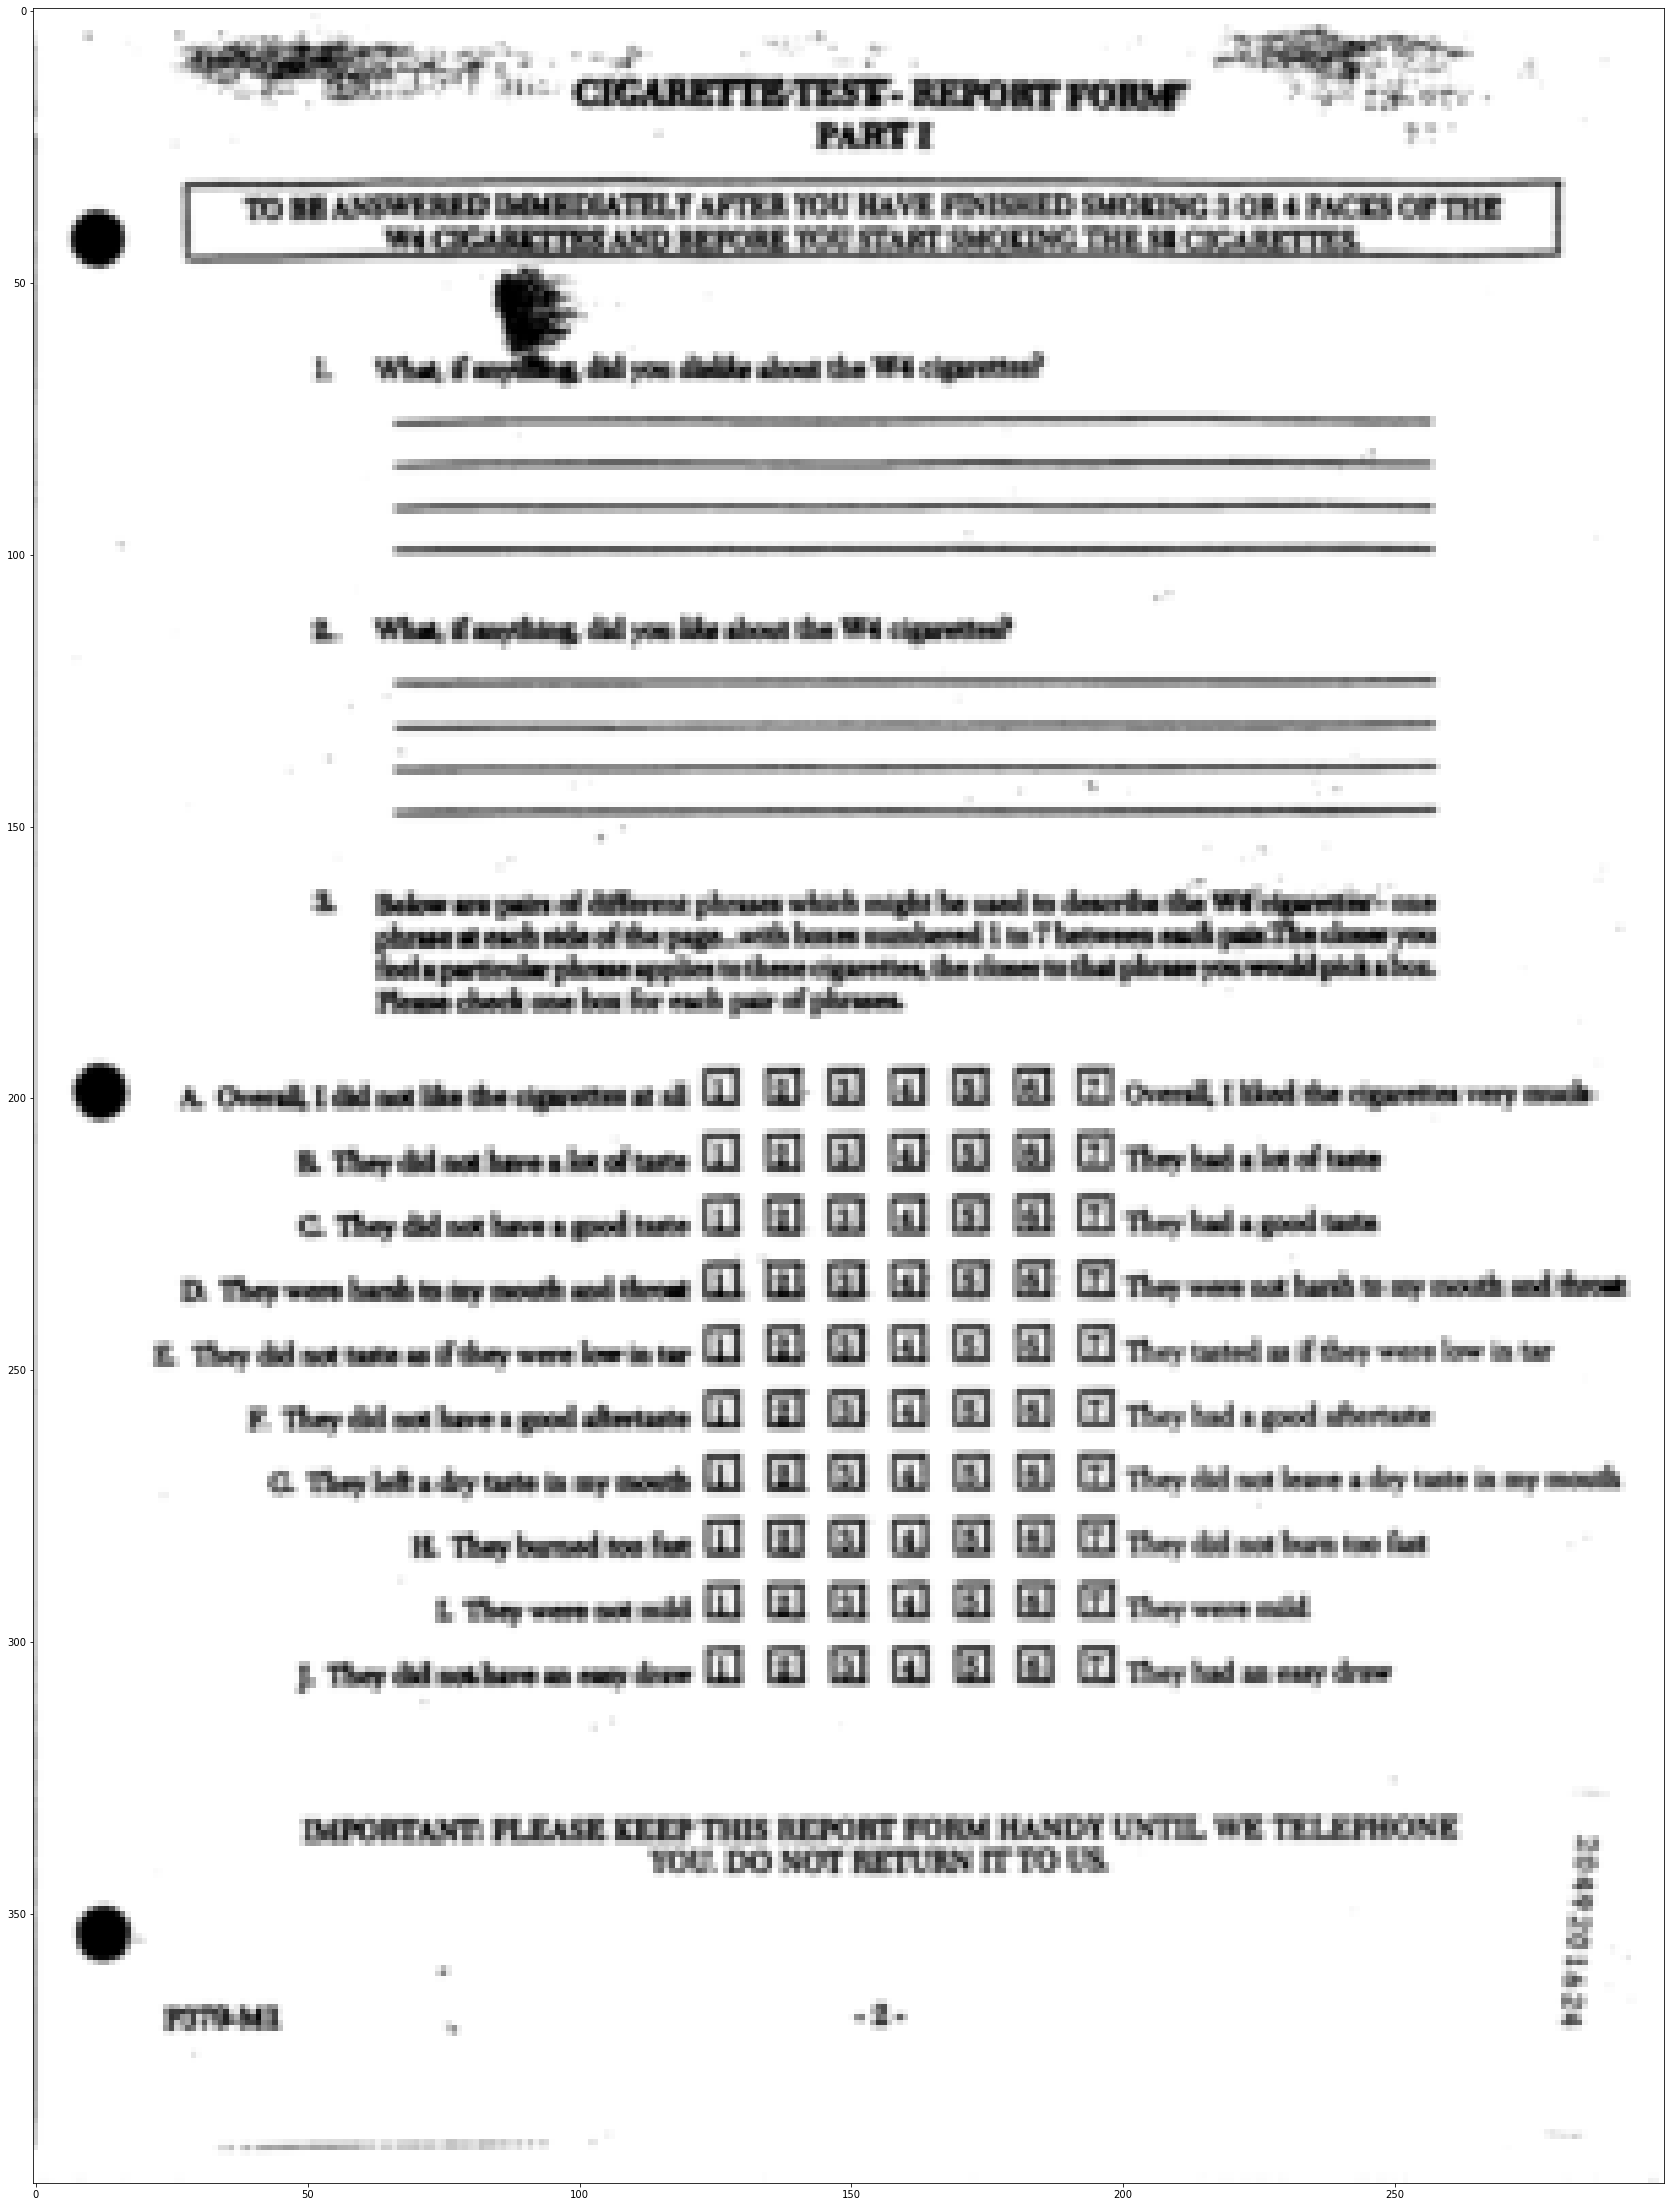

Labels:  L _    ‘2. What; if anything, did you like about the W4 cigarettes?    &% Below are pairs of different phrases which might be used to describe thie W#% a one phrase at each side ofthe page..with bares numbered 1 to 7 between each pair-The closee you feela particular phrase applies to these cigarettes, the closer to that phrase you would pick abor. Please check one bor for each pair of phrases. @ 4 Overat, 1 did noe tke the cigarettes at att OC (2 ED GD CED (6) overat ried the cigarettes very much. B. They did not have alot oftaste 11] [2] G2] G4} GI (6) (2) rhiey had alot of taste . They did not have a good taste (1) (2). G2] G4) G5) GG C2) they had a good taste D. They were harsh ta tay mouth and throat (11. (21 (57 (41 (5) [63 (21 they were not harsh to my mouth and throat E. They did not taste asifthey were low in tar (1) (2) (2 C4) (5) (6) (2) they taste as if they were low in tar F. They did not have a good aftertaste 1] (27 (2} G4] (5) (6) (2 they had a good aftertaste G

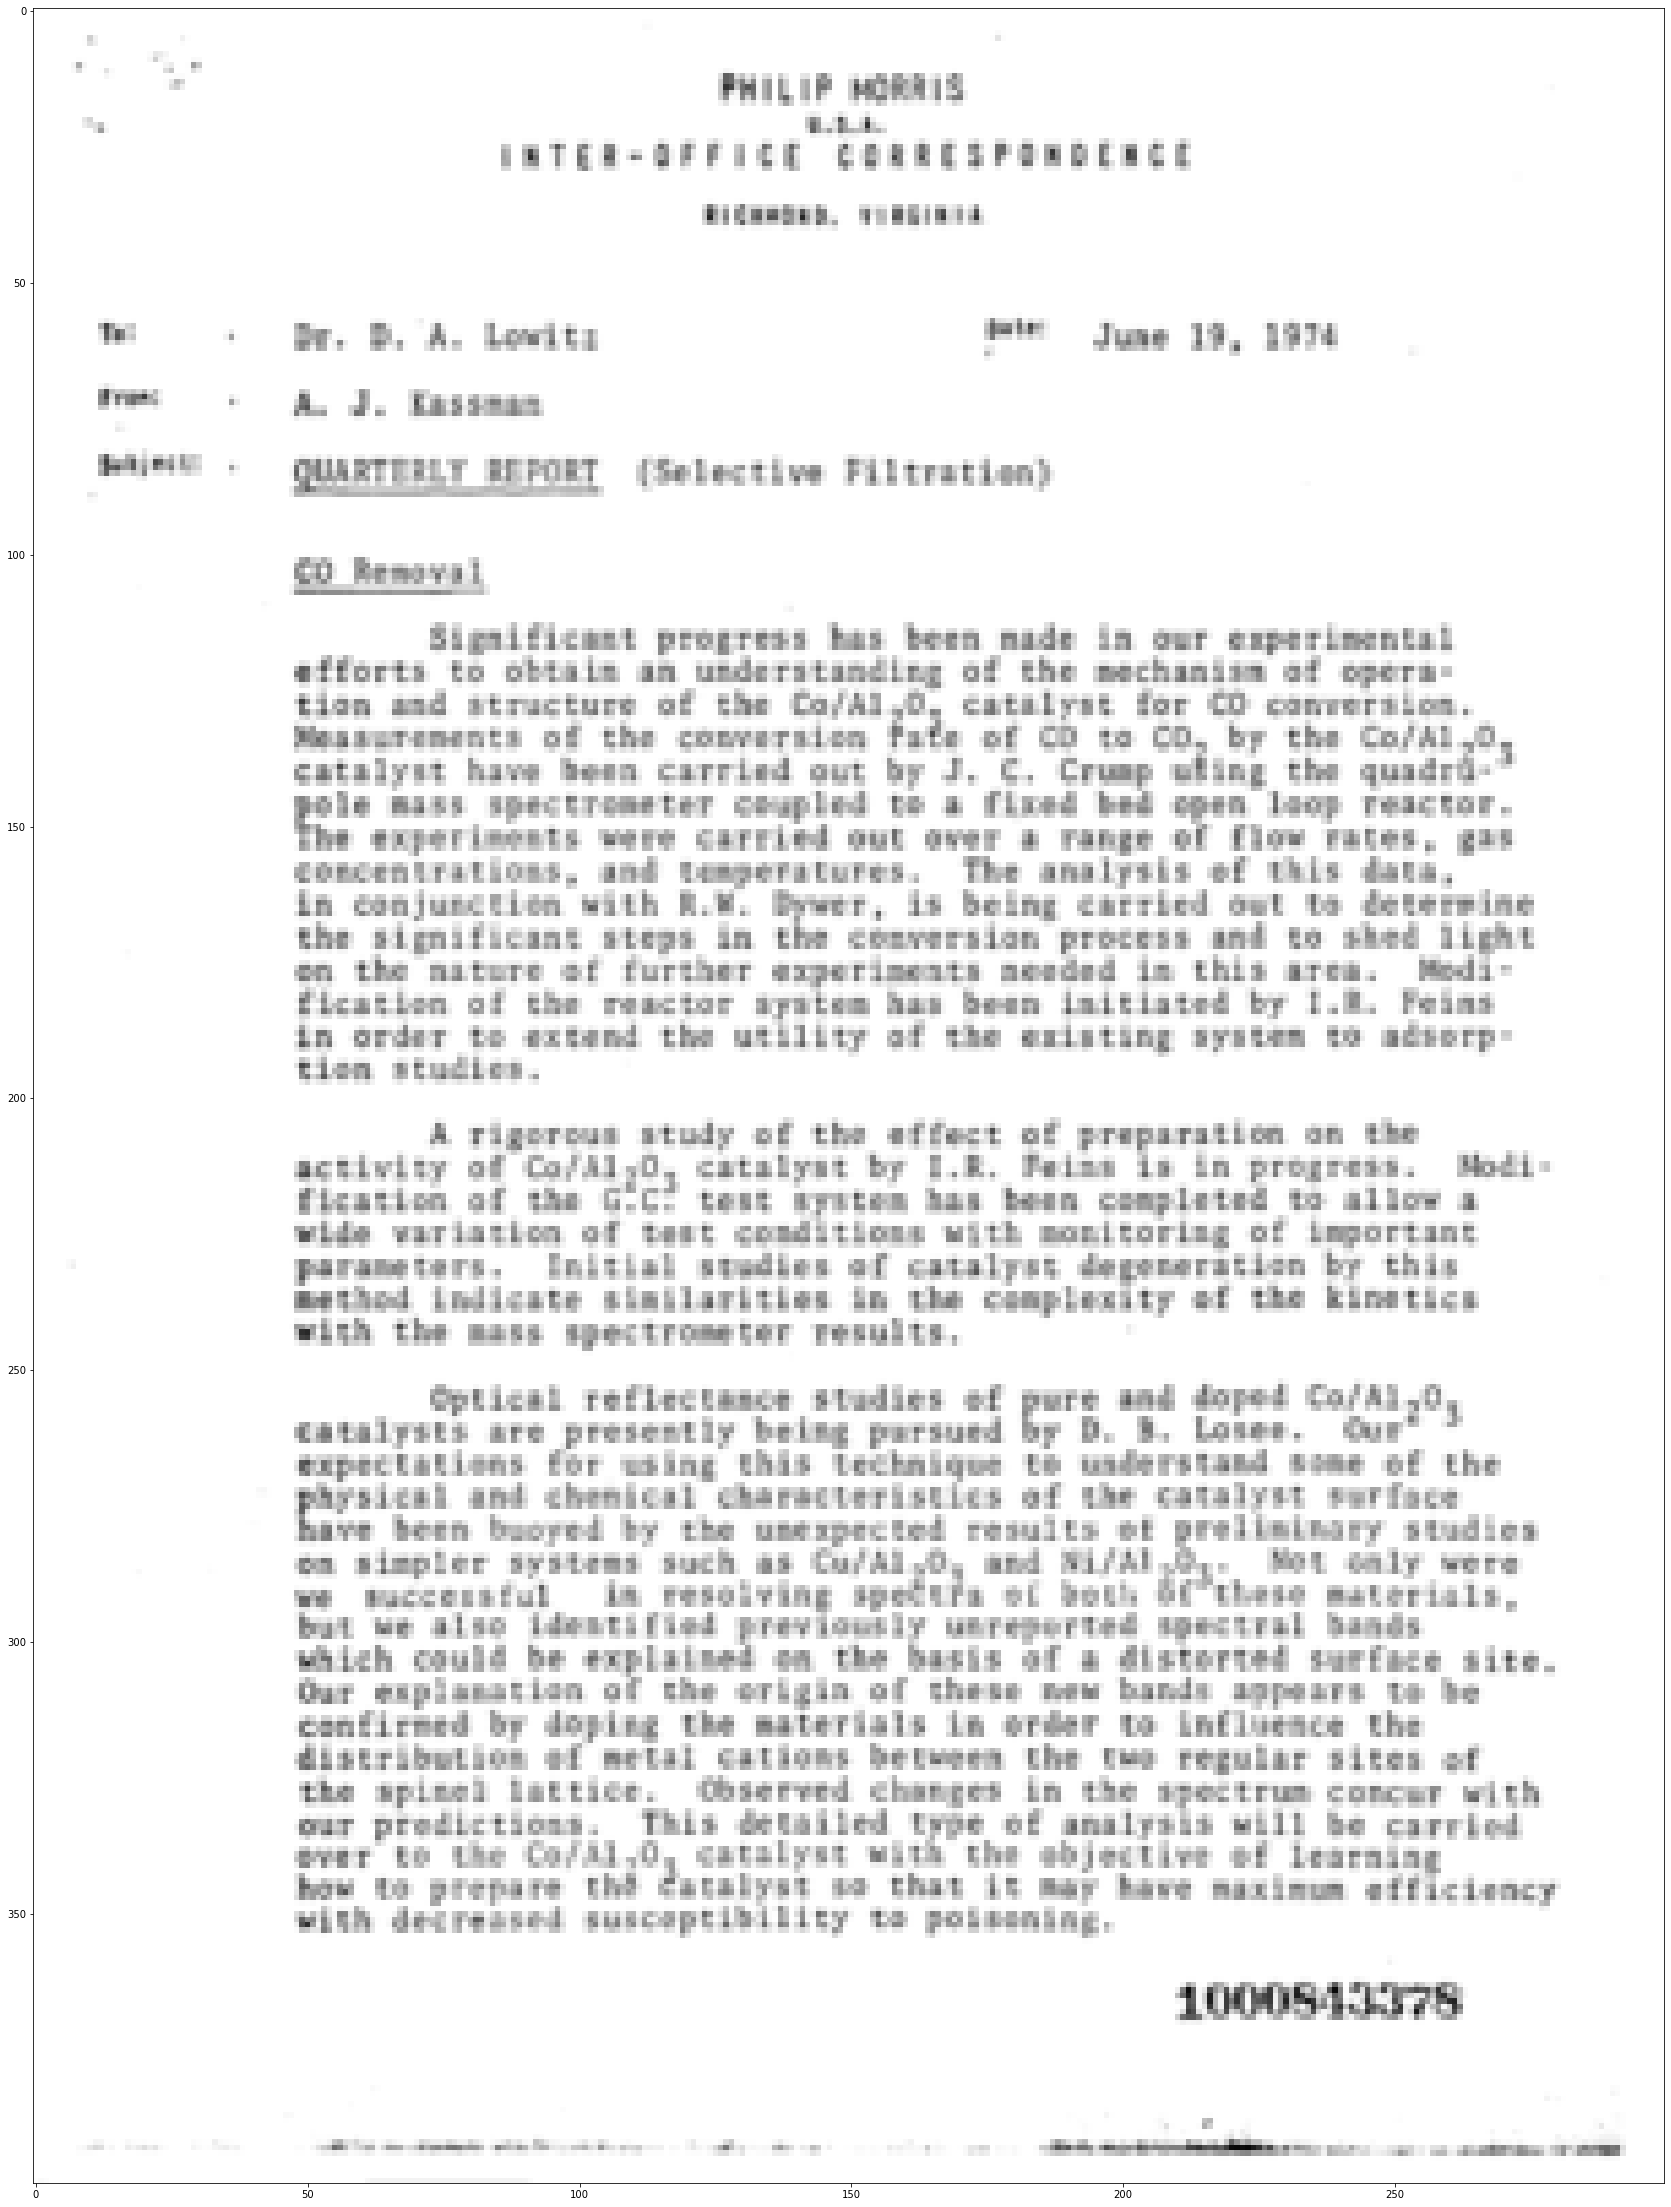

Labels:  Fron: Subject: PHILIP MORRIS UsSAL INTER-OFFICE CORRESPONDENCE RICHMOND, YIRGINTA Dr. D. A. Lowitz bate: June 19, 1974 A. J. Kassman QUARTERLY REPORT (Selective Filtration) CO Removal Significant progress has been made in our experimental efforts to obtain an understanding of the mechanism of opera- tion and structure of the Co/Al,0, catalyst for CO conversion. Measurements of the conversion fate of CO to CO, by the Co/Al,0. catalyst have been carried out by J. C. Crump uging the quadrd- pole mass spectrometer coupled to a fixed bed open loop reactor The experiments were carried out over a range of flow rates, gas concentrations, and temperatures. The analysis of this data, in conjunction with R.W. Dywer, is being carried out to determine the significant steps in the conversion process and to shed light on the nature of further experiments needed in this area. Modi- fication of the reactor system has been initiated by I.R. Feins in order to extend the utility of the existing s

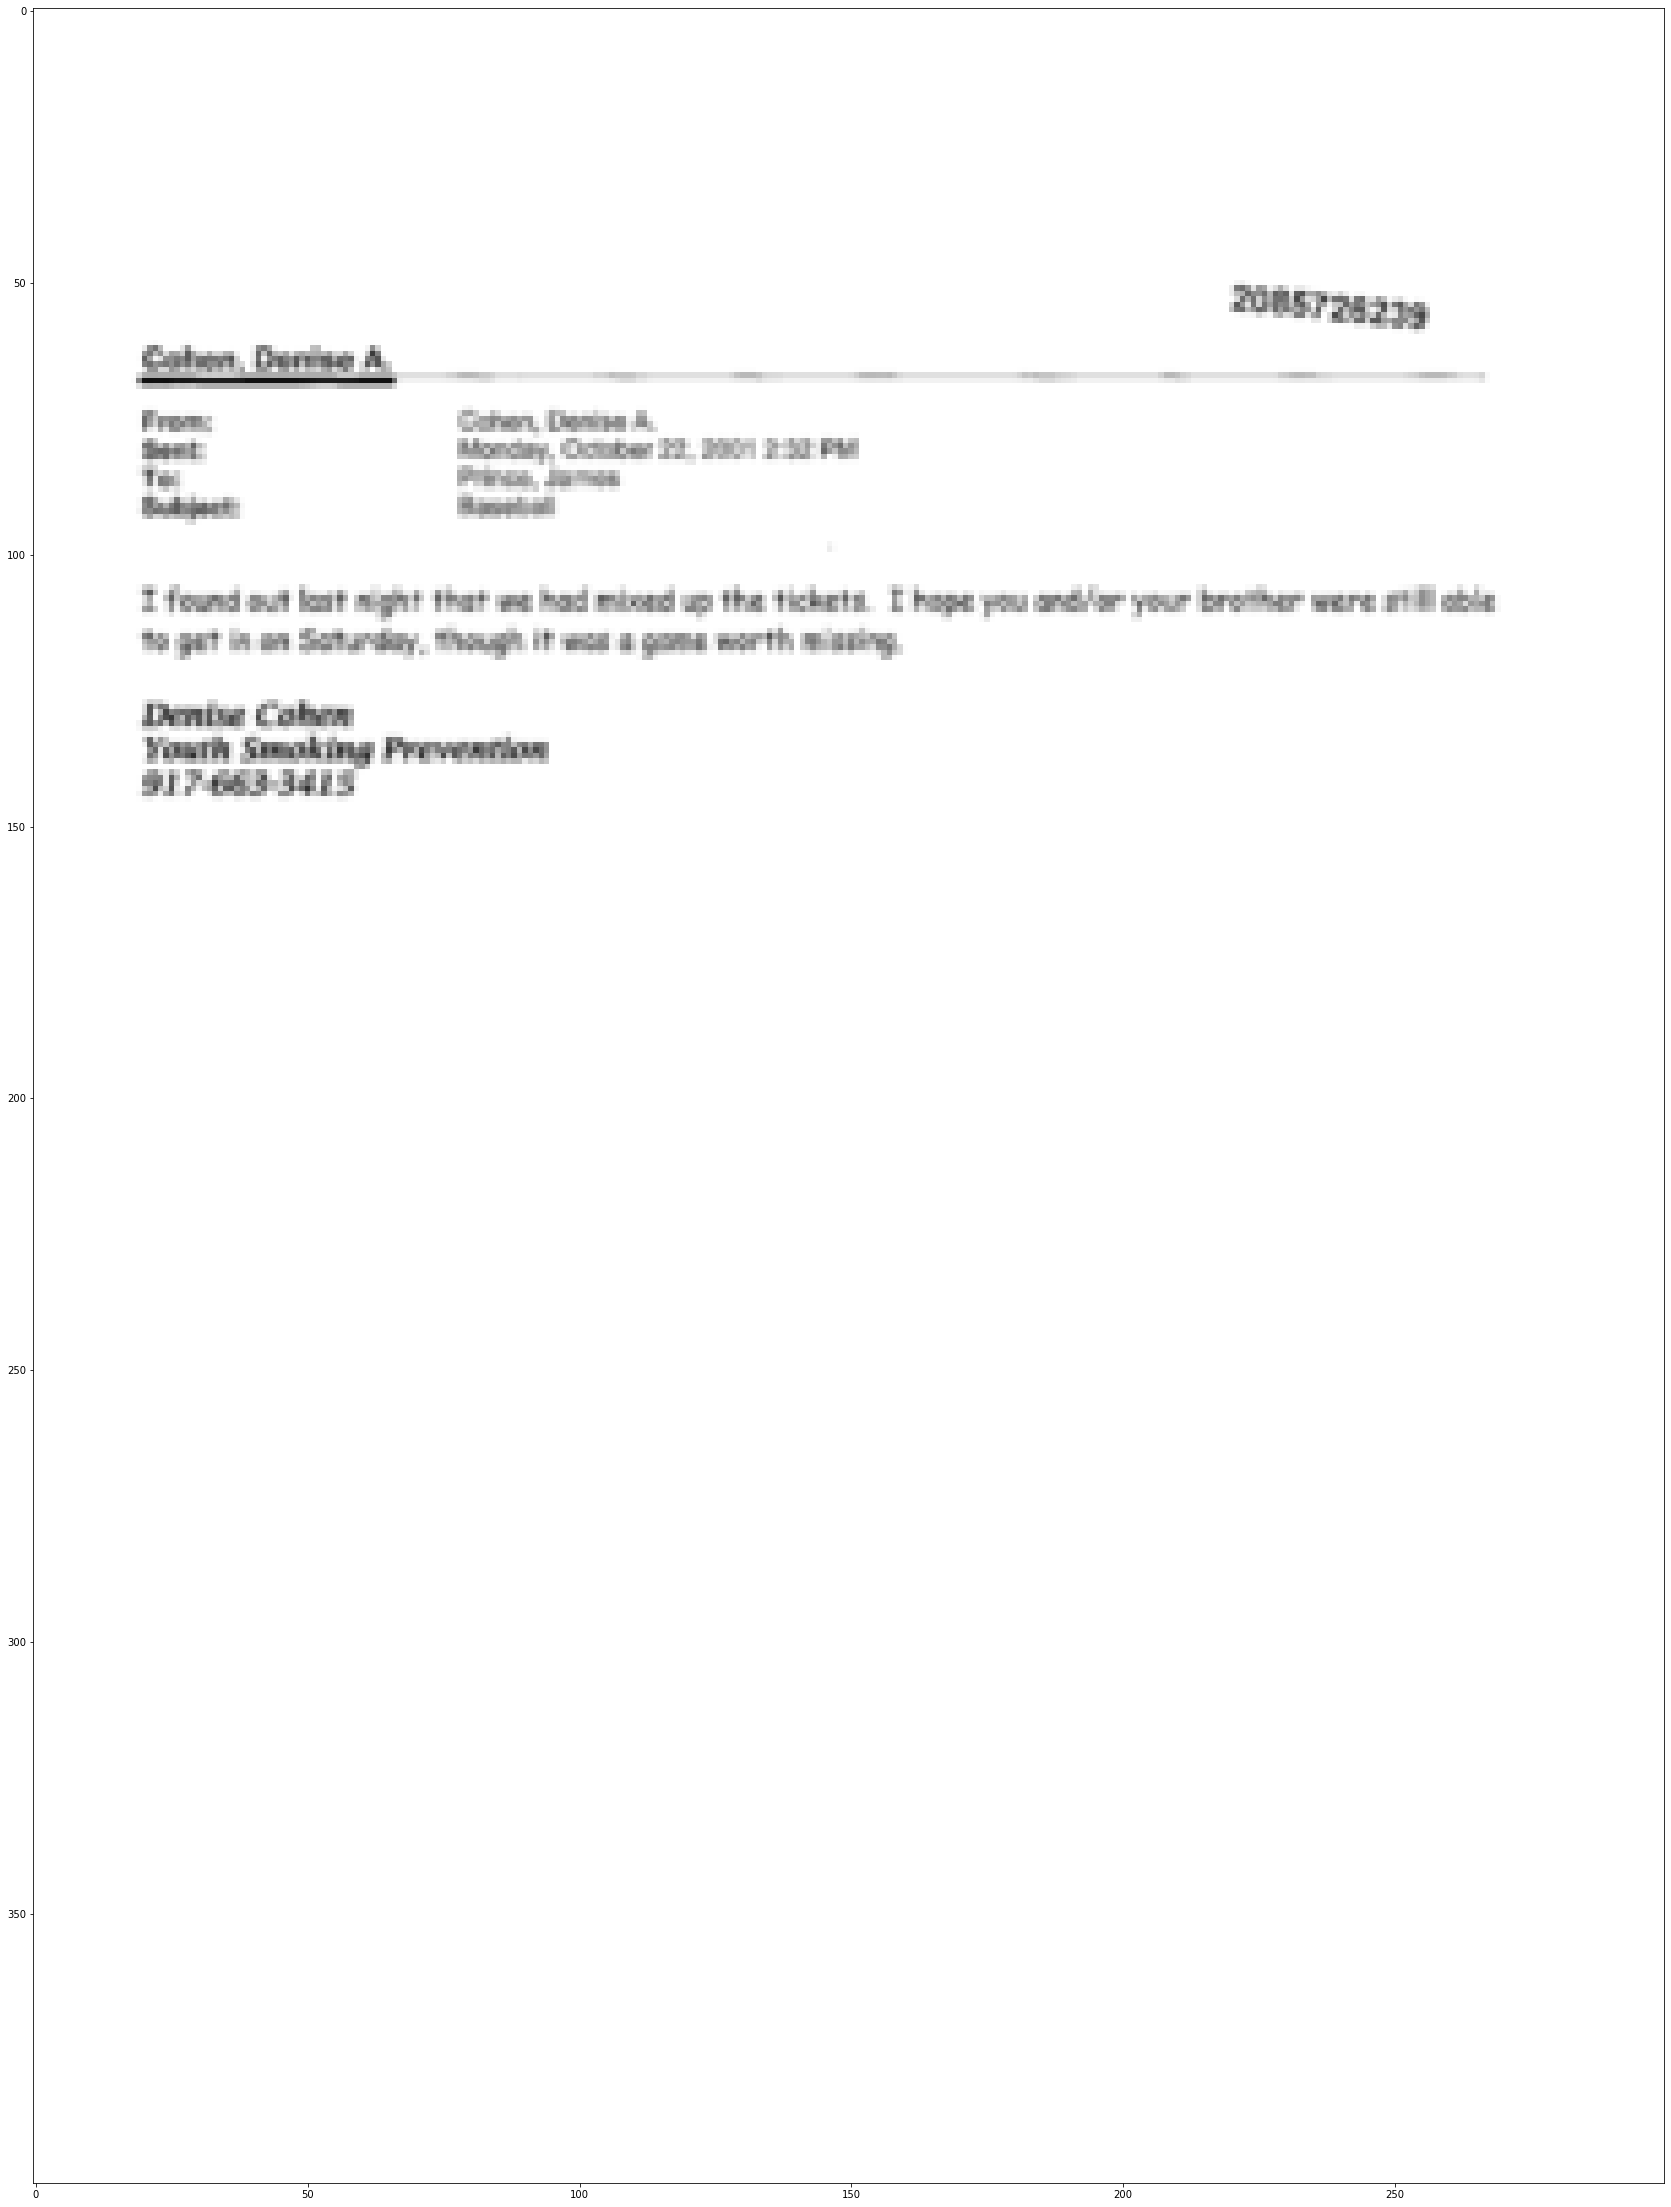

Labels: 2085726239 Cohen, Denise A.  Cohen, Denise A. ‘Monday, October 22, 2001 2:32 PM Prince, James Baseball  T found out last night that we had mixed up the tickets. I hope you and/or your brother were still able to get in on Saturday, though it was a game worth missing. Denise Cohen Youth Smoking Prevention 917-663-3415
Pred: 2085726329 Cohen, Denise A. Cohen, Denise A. Monday, October 22, 2001 2:20 PM Broin, Karen ‘Susaniel I found out but I only that we had mixed up the labels. I hope you could say your brother were still able to get it on Saturday, though I was a guess even with training. Denise Cohen Youth Smoking Prevention 917-663-3415



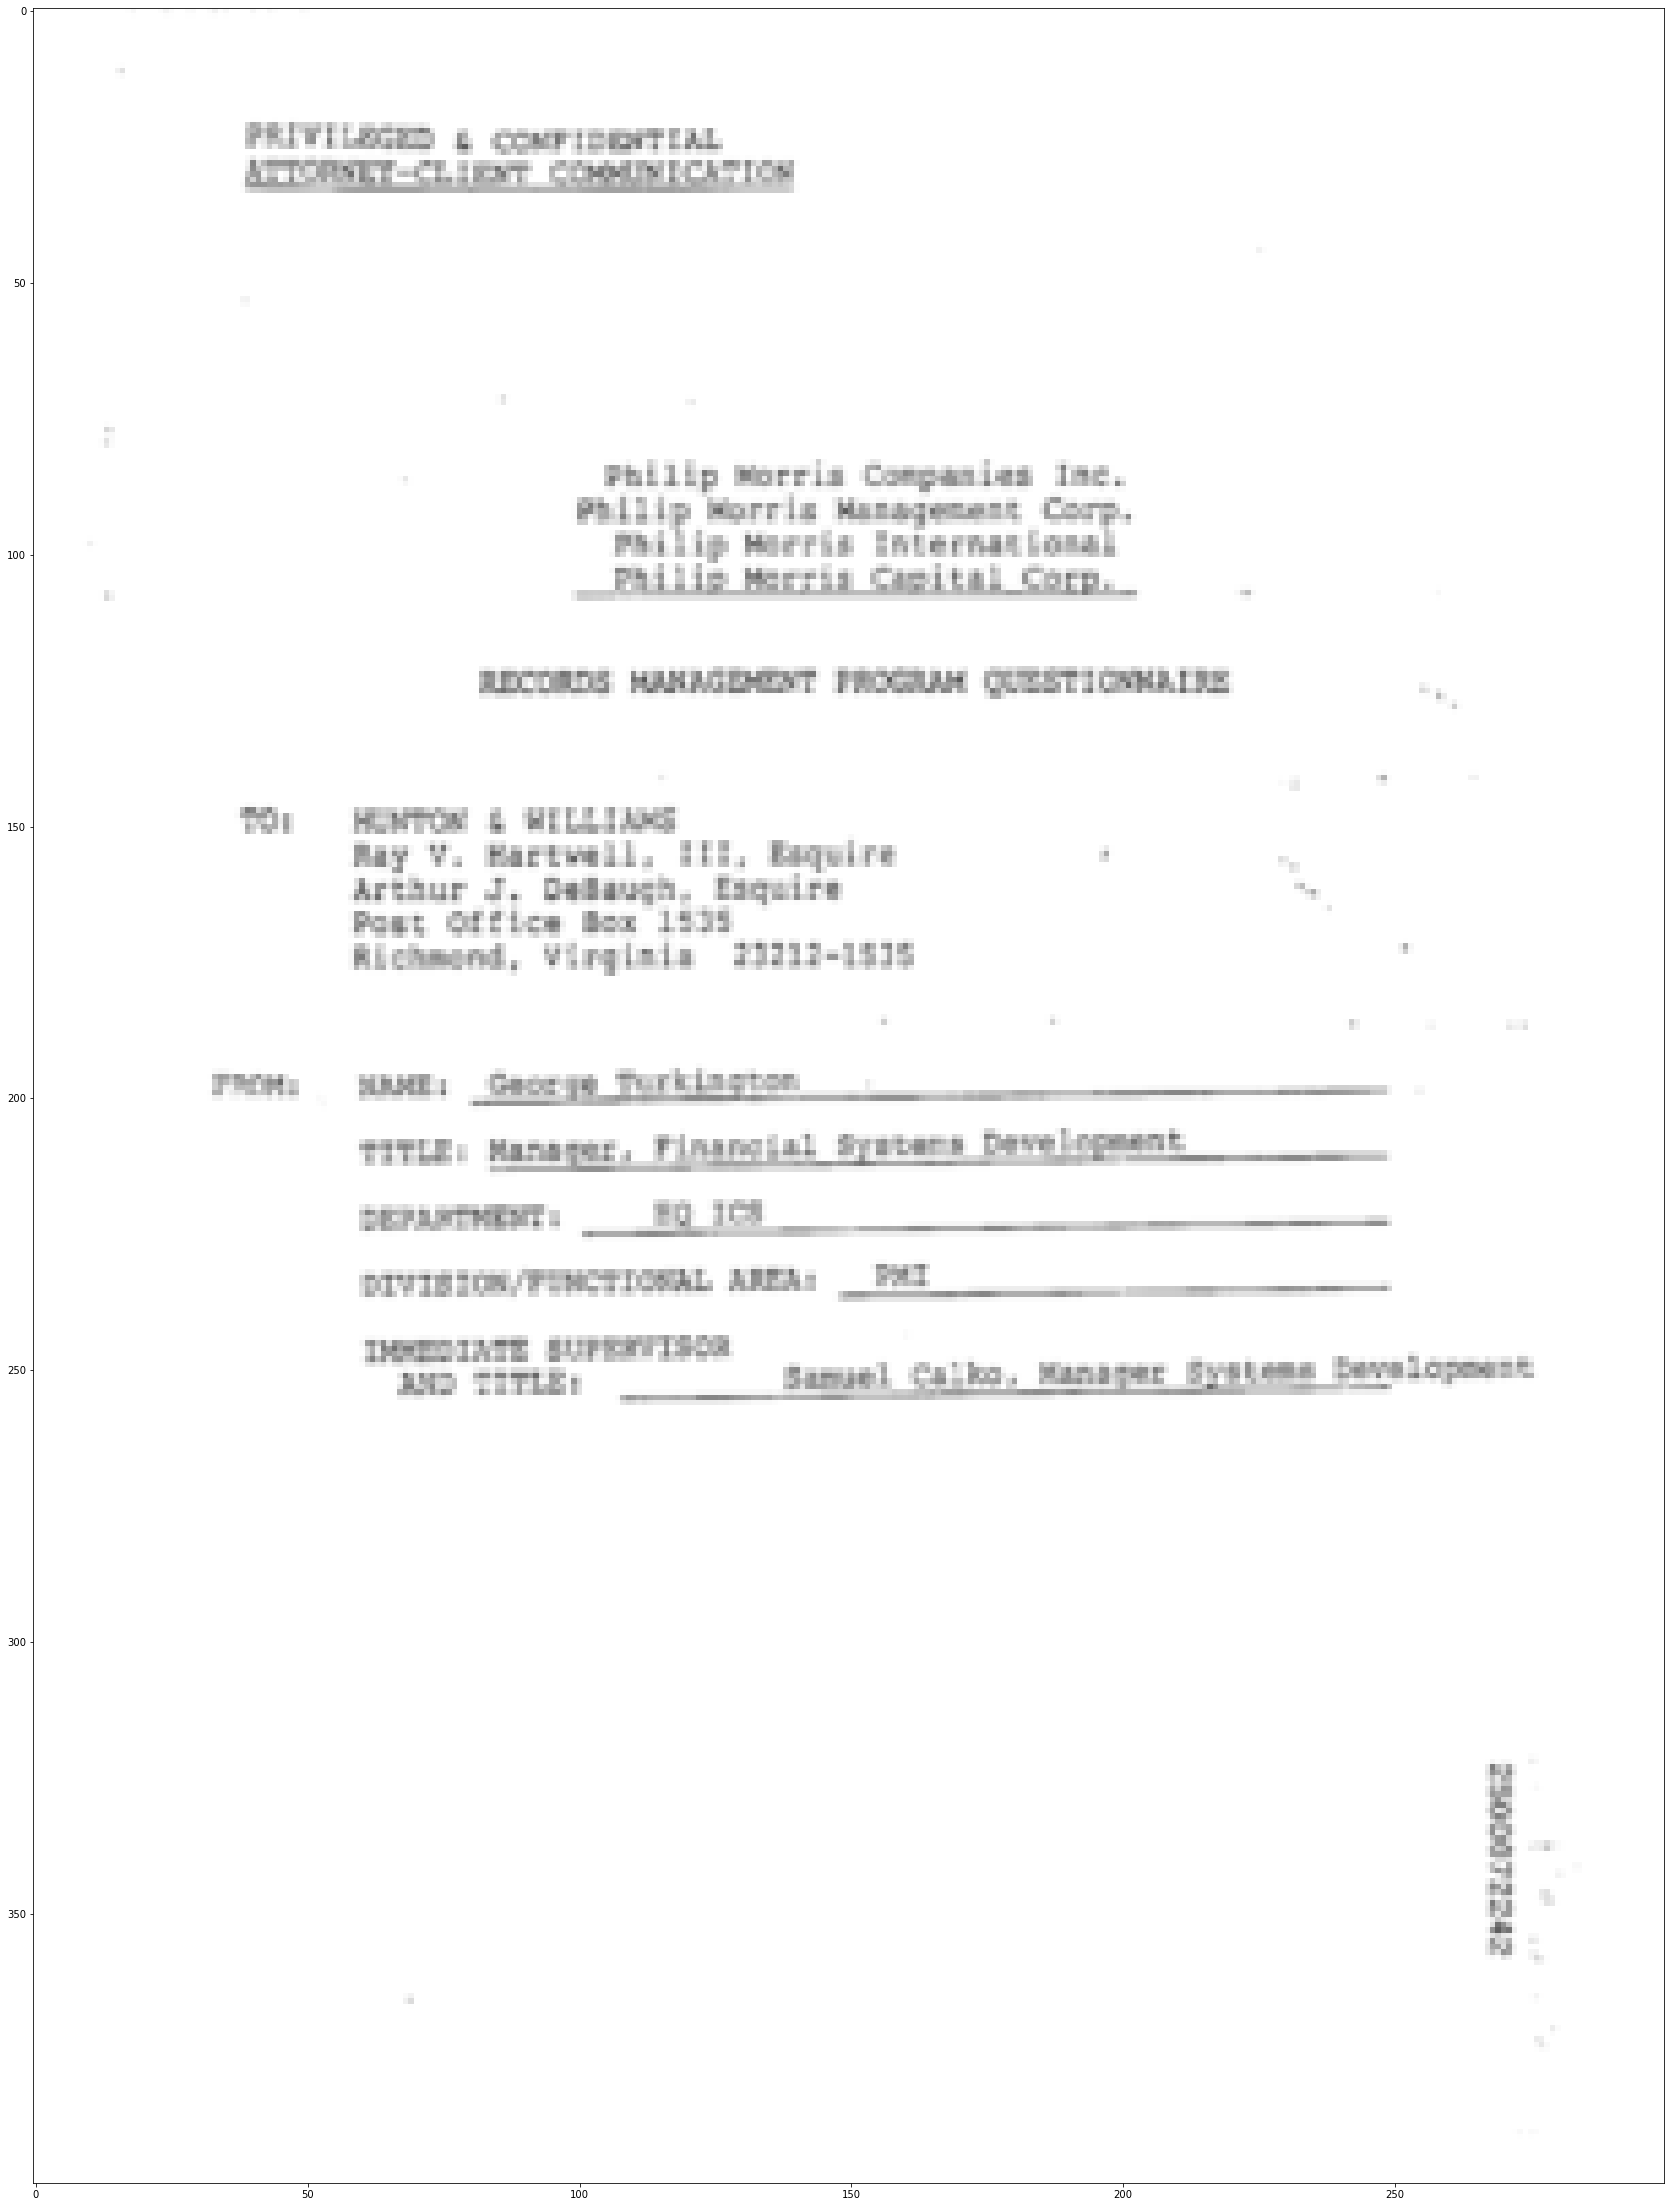

Labels: PRIVILEGED & CONFIDENTIAL ATTORNEY-CLIENT COMMUNICATION FROM: Philip Morris Companies Inc. Philip Morris Management Corp. Philip Morris International Philip Morris Capital Corp. . RECORDS MANAGEMENT PROGRAM QUESTIONNAIRE : HUNTON & WILLIAMS Ray V. Hartwell, III, Esquire , . arthur J. DeBaugh, Esquire s Post Office Box 1535 Richmond, Virginia 23212-1535 : NAME: _George Turkington, TITLE: Manager, Financial systems Development. DEPARTMENT: HQ Ics DIVISION/FUNCTIONAL AREA: __ PMI IMMEDIATE SUPERVISOR AND TITLE: Samuel Calko, Manager Systems Development zvzzzo00c2
Pred: PRIVILEGED & CONFIDENTIAL ATTORNEY-CLIENT COMMUNICATION Philip Morris Companies Inc. Philip Morris Management Corp. Philip Morris International Corp. Philip Morris Capital Corp. RECORDS MANAGEMENT PROGRAM QUESTIONNAIRE TO: HUNTON & WILLIAMS Arthur J. DeBaugh, III, Esquire. Arthur J. DeBaugh, Esquire. Post Office Box 1535 Richmond, Virginia 23212-1535 FROM: NAME: George Tuckleran TITLE: Manager, Financial Systems Dev

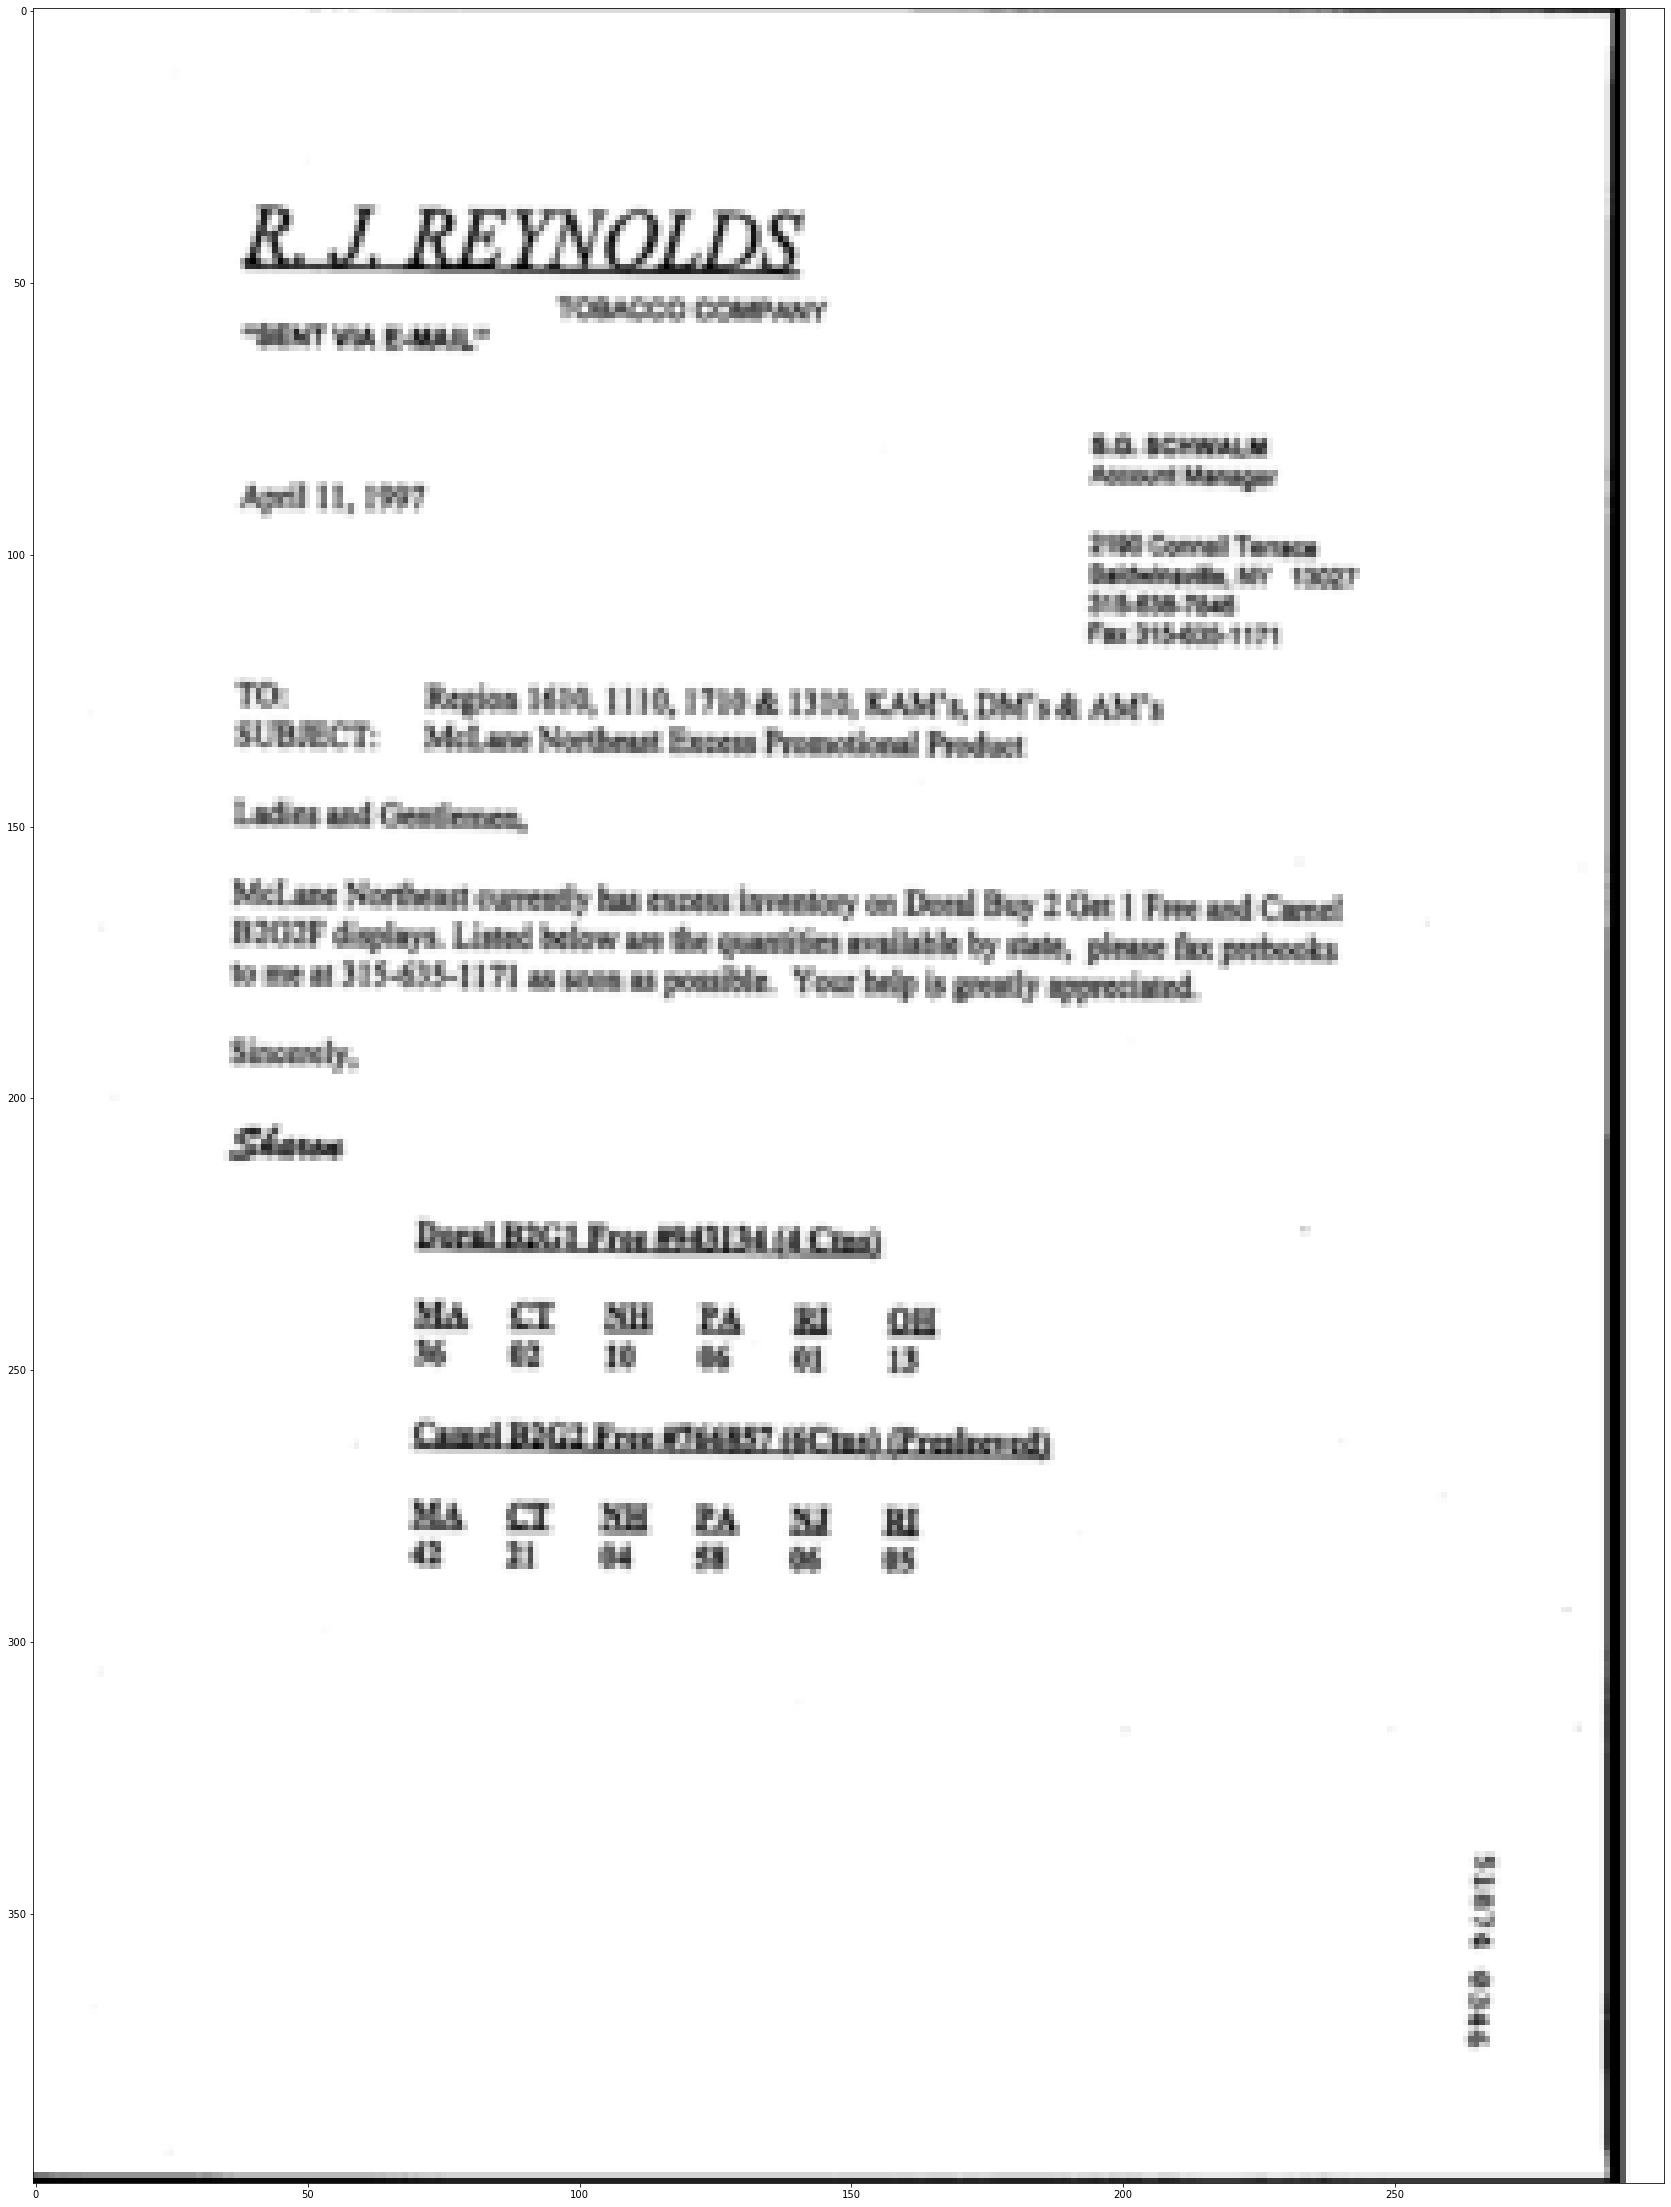

Labels: R.J_REYNOLDS ‘TOBACCO COMPANY “SENT VIA E-MAIL” $8.6, SCHWALM ‘Account Manager April 11, 1997 2190 Connell Terrace Baldwinsvile, NY 13027 315-638-7848 Fax 315-635-1171 TO: Region 1610, 1110, 1710 & 1310, KAM’s, DM’s & AM’s SUBJECT: McLane Northeast Excess Promotional Product Ladies and Gentlemen, MeLane Northeast currently has excess inventory on Doral Buy 2 Get 1 Free and Camel B2G2F displays. Listed below are the quantities available by state, please fax prebooks to me at 315-635-1171 as soon as possible. Your help is greatly appreciated. Sincerely, Sharon 9980 duets 
Pred: RJ REYNOLDS TOBACCO COMPANY “NEW YORK S.M. SURNARNA Account Manager April 11, 1997 280 Central Terrace Bakhmonds, NY 14227 216-767-8421 Fax 216-767-8421 TO: Region 1610, 1110, 1710 & 1710, KAMs, TAMs, & AMs.) SUBJECT: McLane Northeast Bonus Promotional Product Ladies and Gentlemen, McLane Northeast currently has excess inventory on Doral Buy 2 Get 2 Free and Camel B2G2F displays. I have talked to me at the

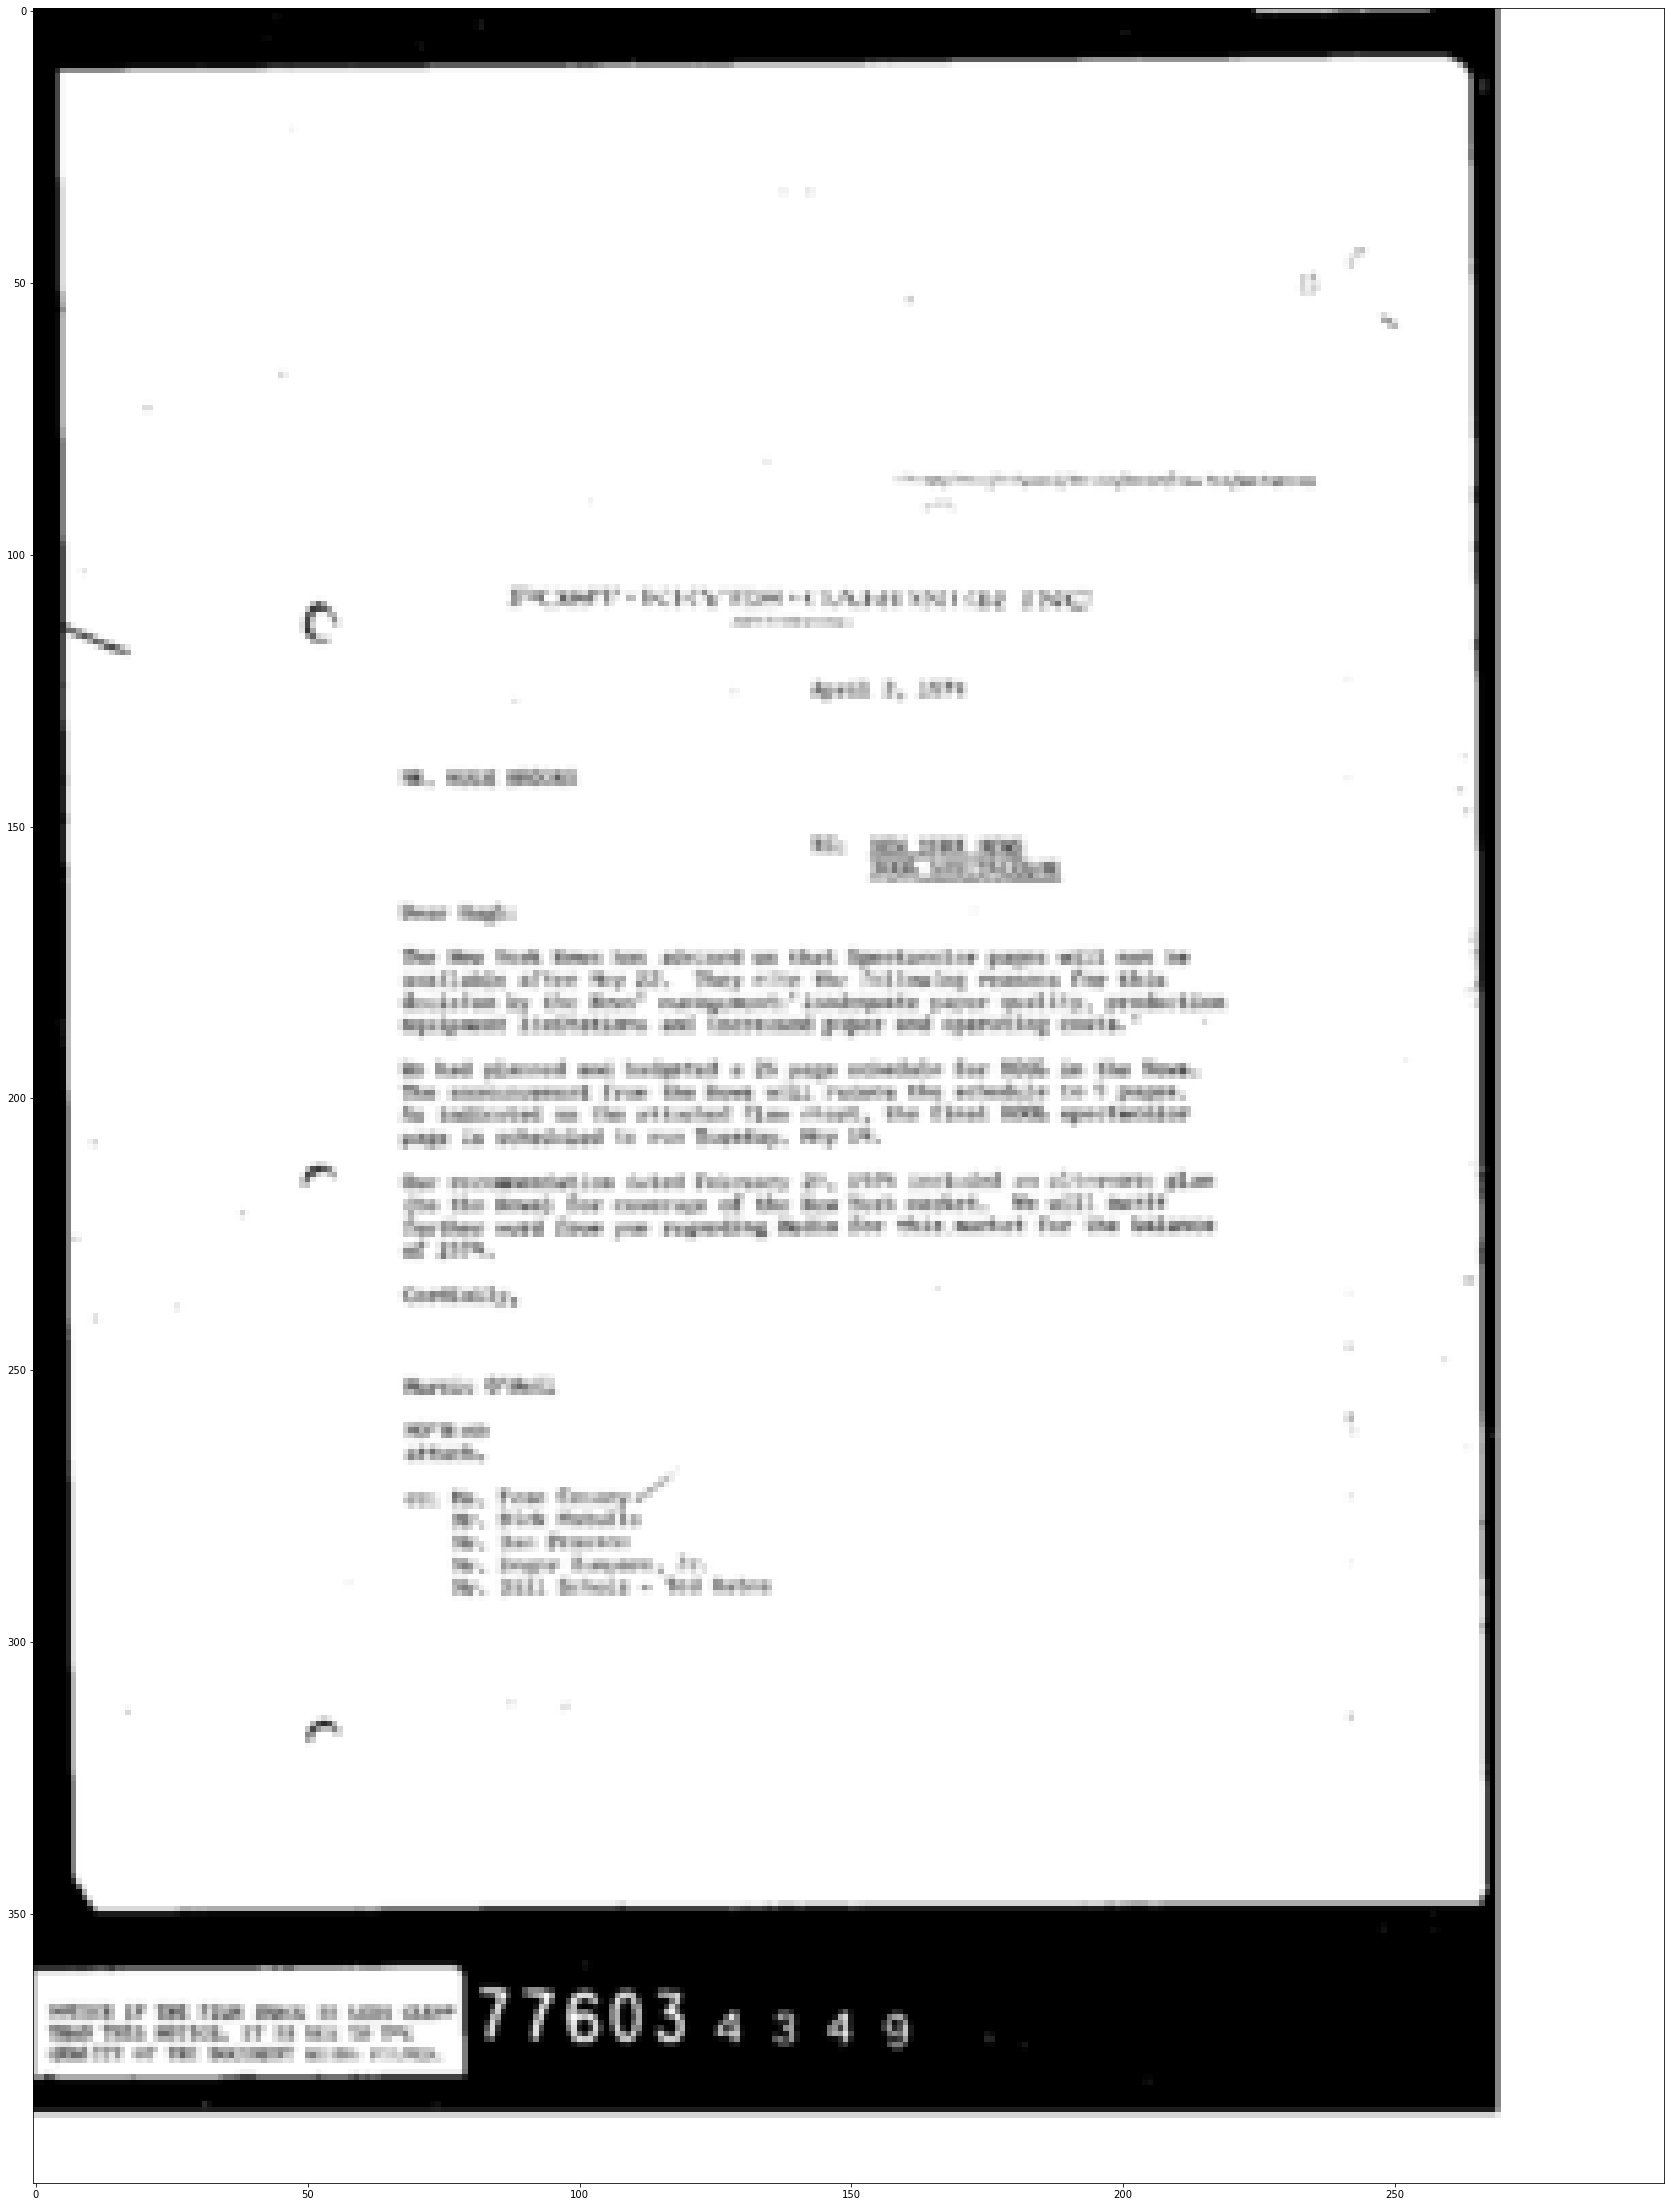

Labels: POST ISHV ES GARDNER INC pons 2, 1970 me, uci ABOoKA EN yo ws Hoe SHCHRCOLOR Dear thug ‘The New York News has advised us that Spectucolor pages will not he available iter thy 22. ‘hey ele the following reasons for this Accision by the Rows" vamayemcnt.* inadequate paper quality, peaduction onudpmene Limttations and tnevessod paper snd operating costs. ie had planned ond budgeted o 26 page schedule for KOOL in the Nove The announcenent Teor the Nows will raiuew the sehodule to 9 poses. Je "indiceted on the attached flu chart, the {ital KOOL spectecolor vege is scheduled te run Tuesday, iy 14. Our receanentation dated Februny 2), 1978 included a olteroate plan (to the news) for coverage of the New York meket., We will ante Eurther word ron yoo reyerding Hedia For this market fer the balunce of 159%, Covatanty, Horeie O'NesL ees Hse Bean Canney + fer fick Fneut to tie: Dan rears Ne, MILL Scholz = Ted hates NOTICE F THE FILA URGE Is LESS QWALITY OP THE DOCUMENT Wi.tMGe FILMED. 
Pre

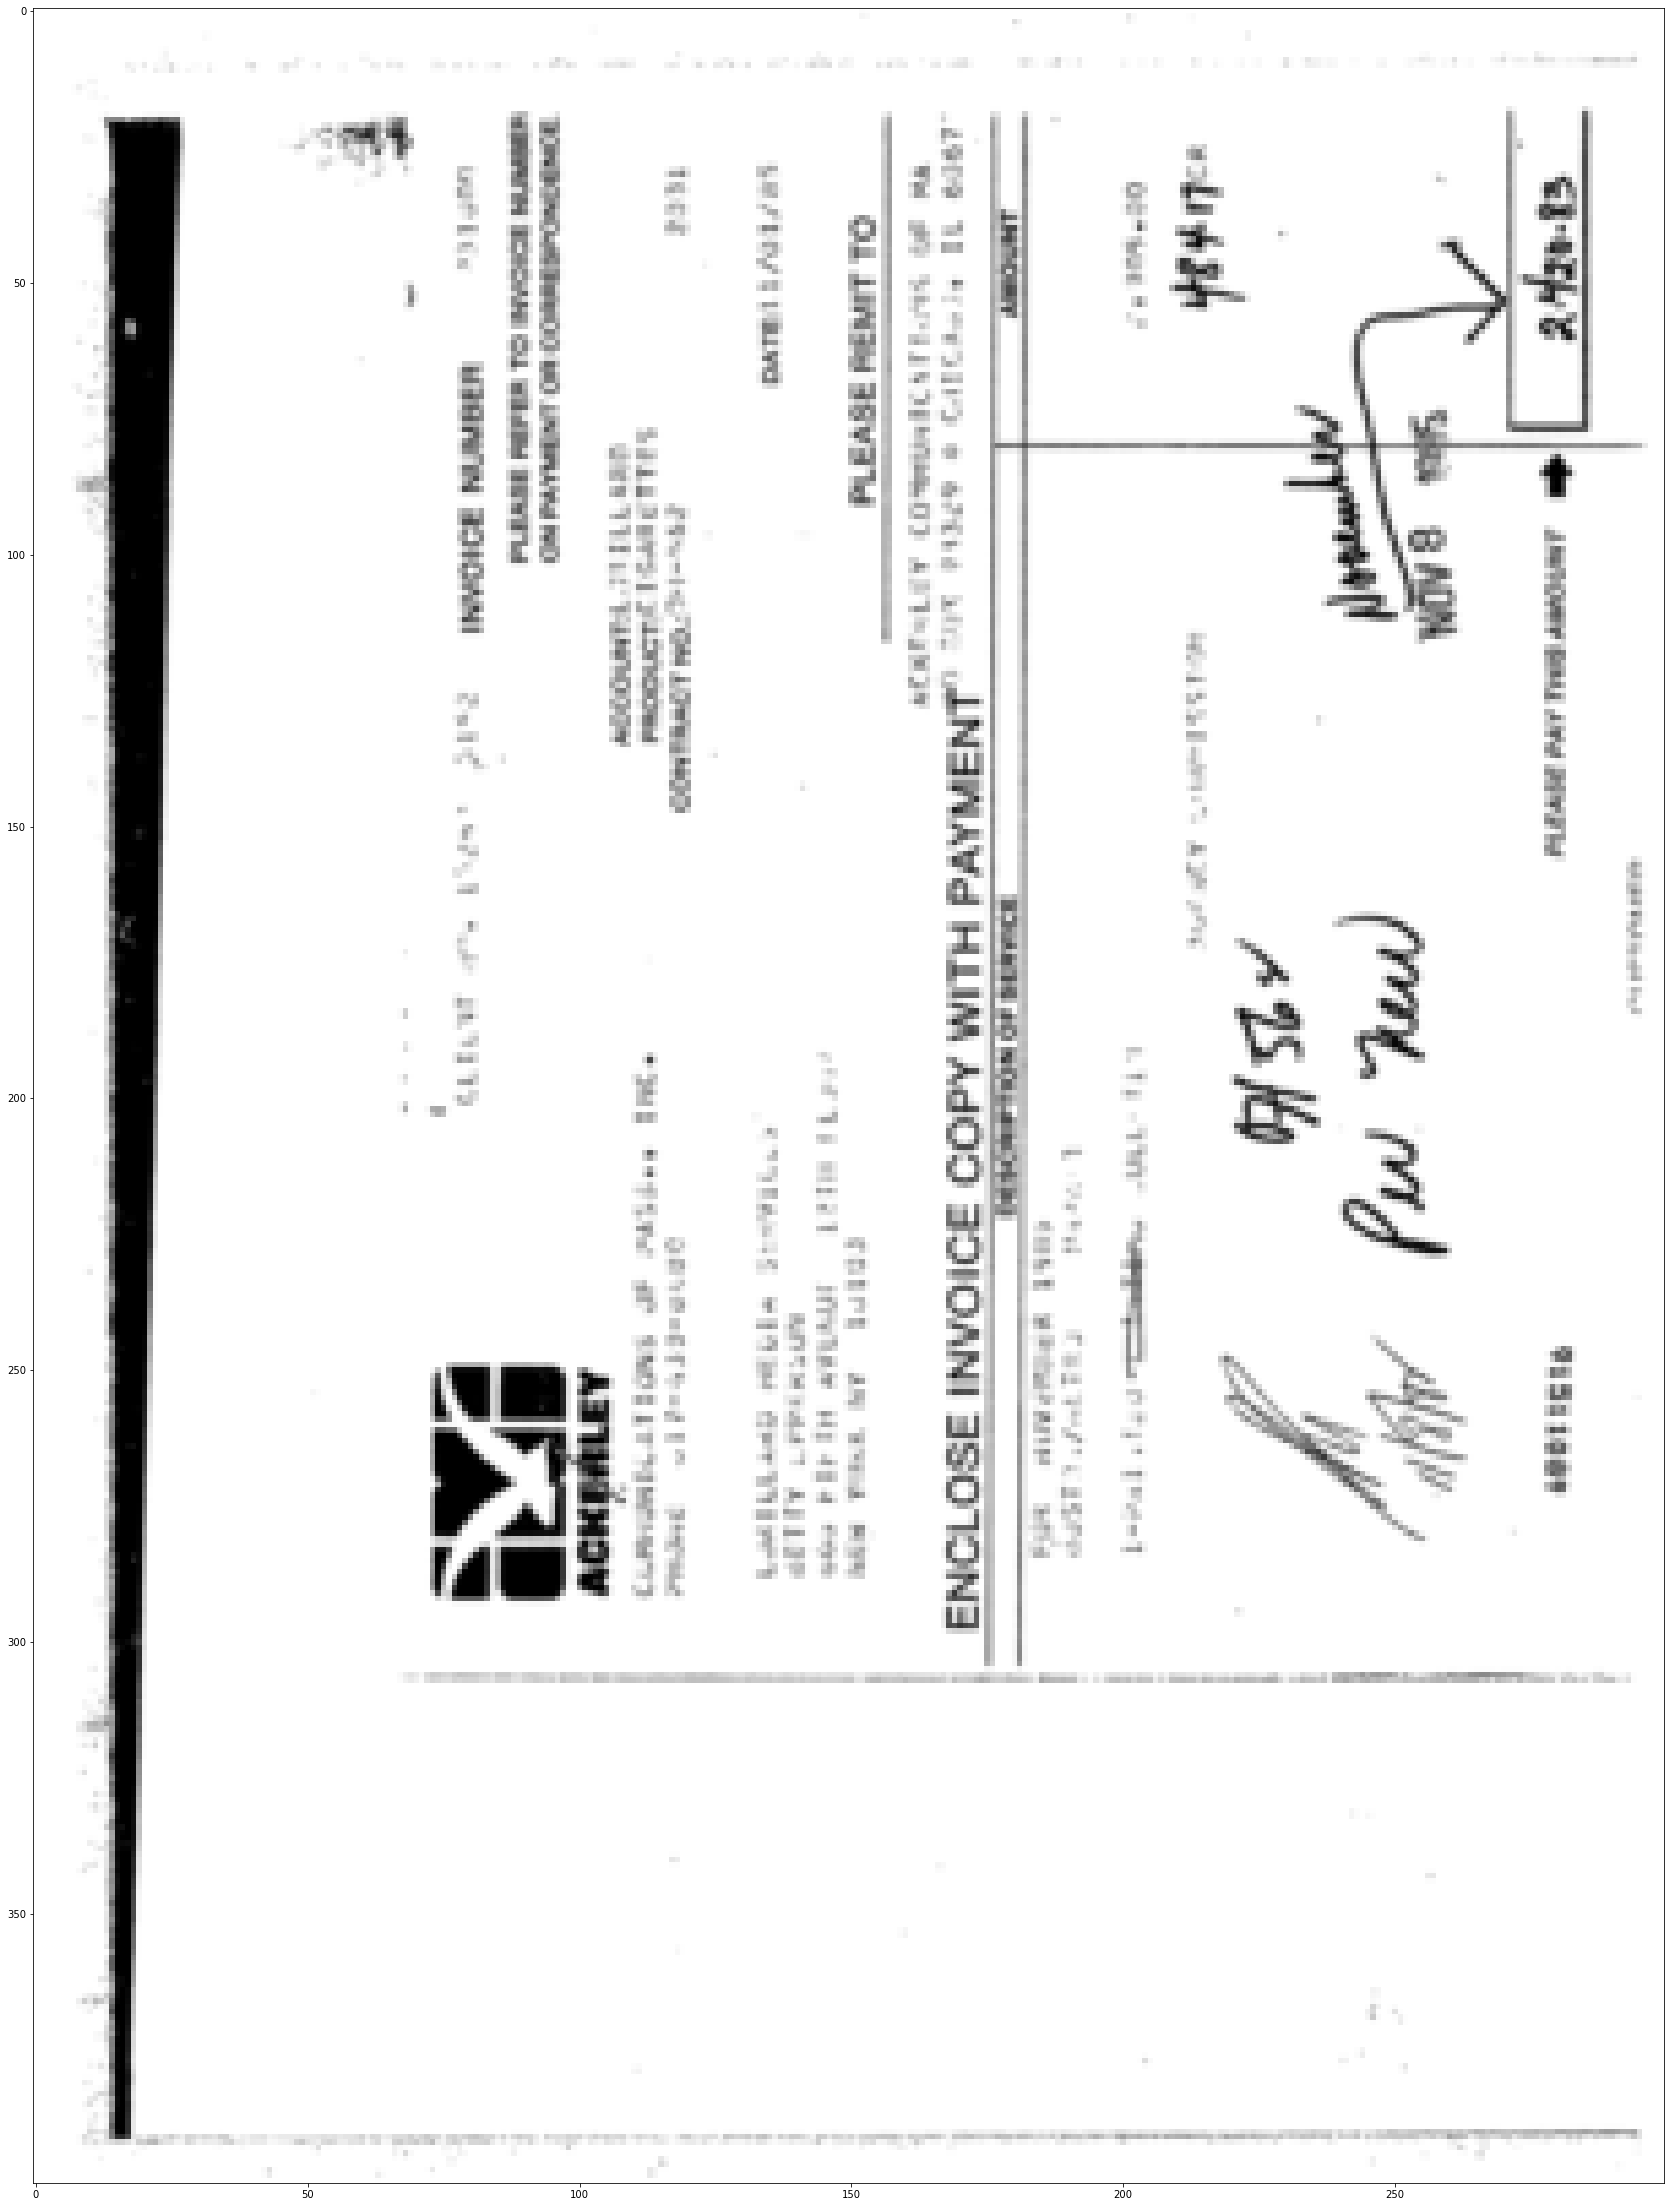

Labels:    i { INVOICE NUMBER PLEASE REFER TO INVOICE NUMBER ‘ON PAYMENT OR CORRESPONDENCE, ‘ACCOUNT: PRODUCT: CONTRACT NO." LLaRD ETTES 62 2031  DATE: 1/01/85  PLEASE REMIT TO LEY COMMUNTCATT 233  ACK ENCLOSE INVOICE COPY WITH PAYMENT DESCRIPTION OF SERVICE AMOUNT  uF MA + TL 6967  ER 1909   £9995.00 Yeh iT wey  yay ii’ Pu) Iowa) bee WOVS 10H SBOTISTS PLEASE PAY THISAMOUNT | 2420-93 pievaure   
Pred:  ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇ 

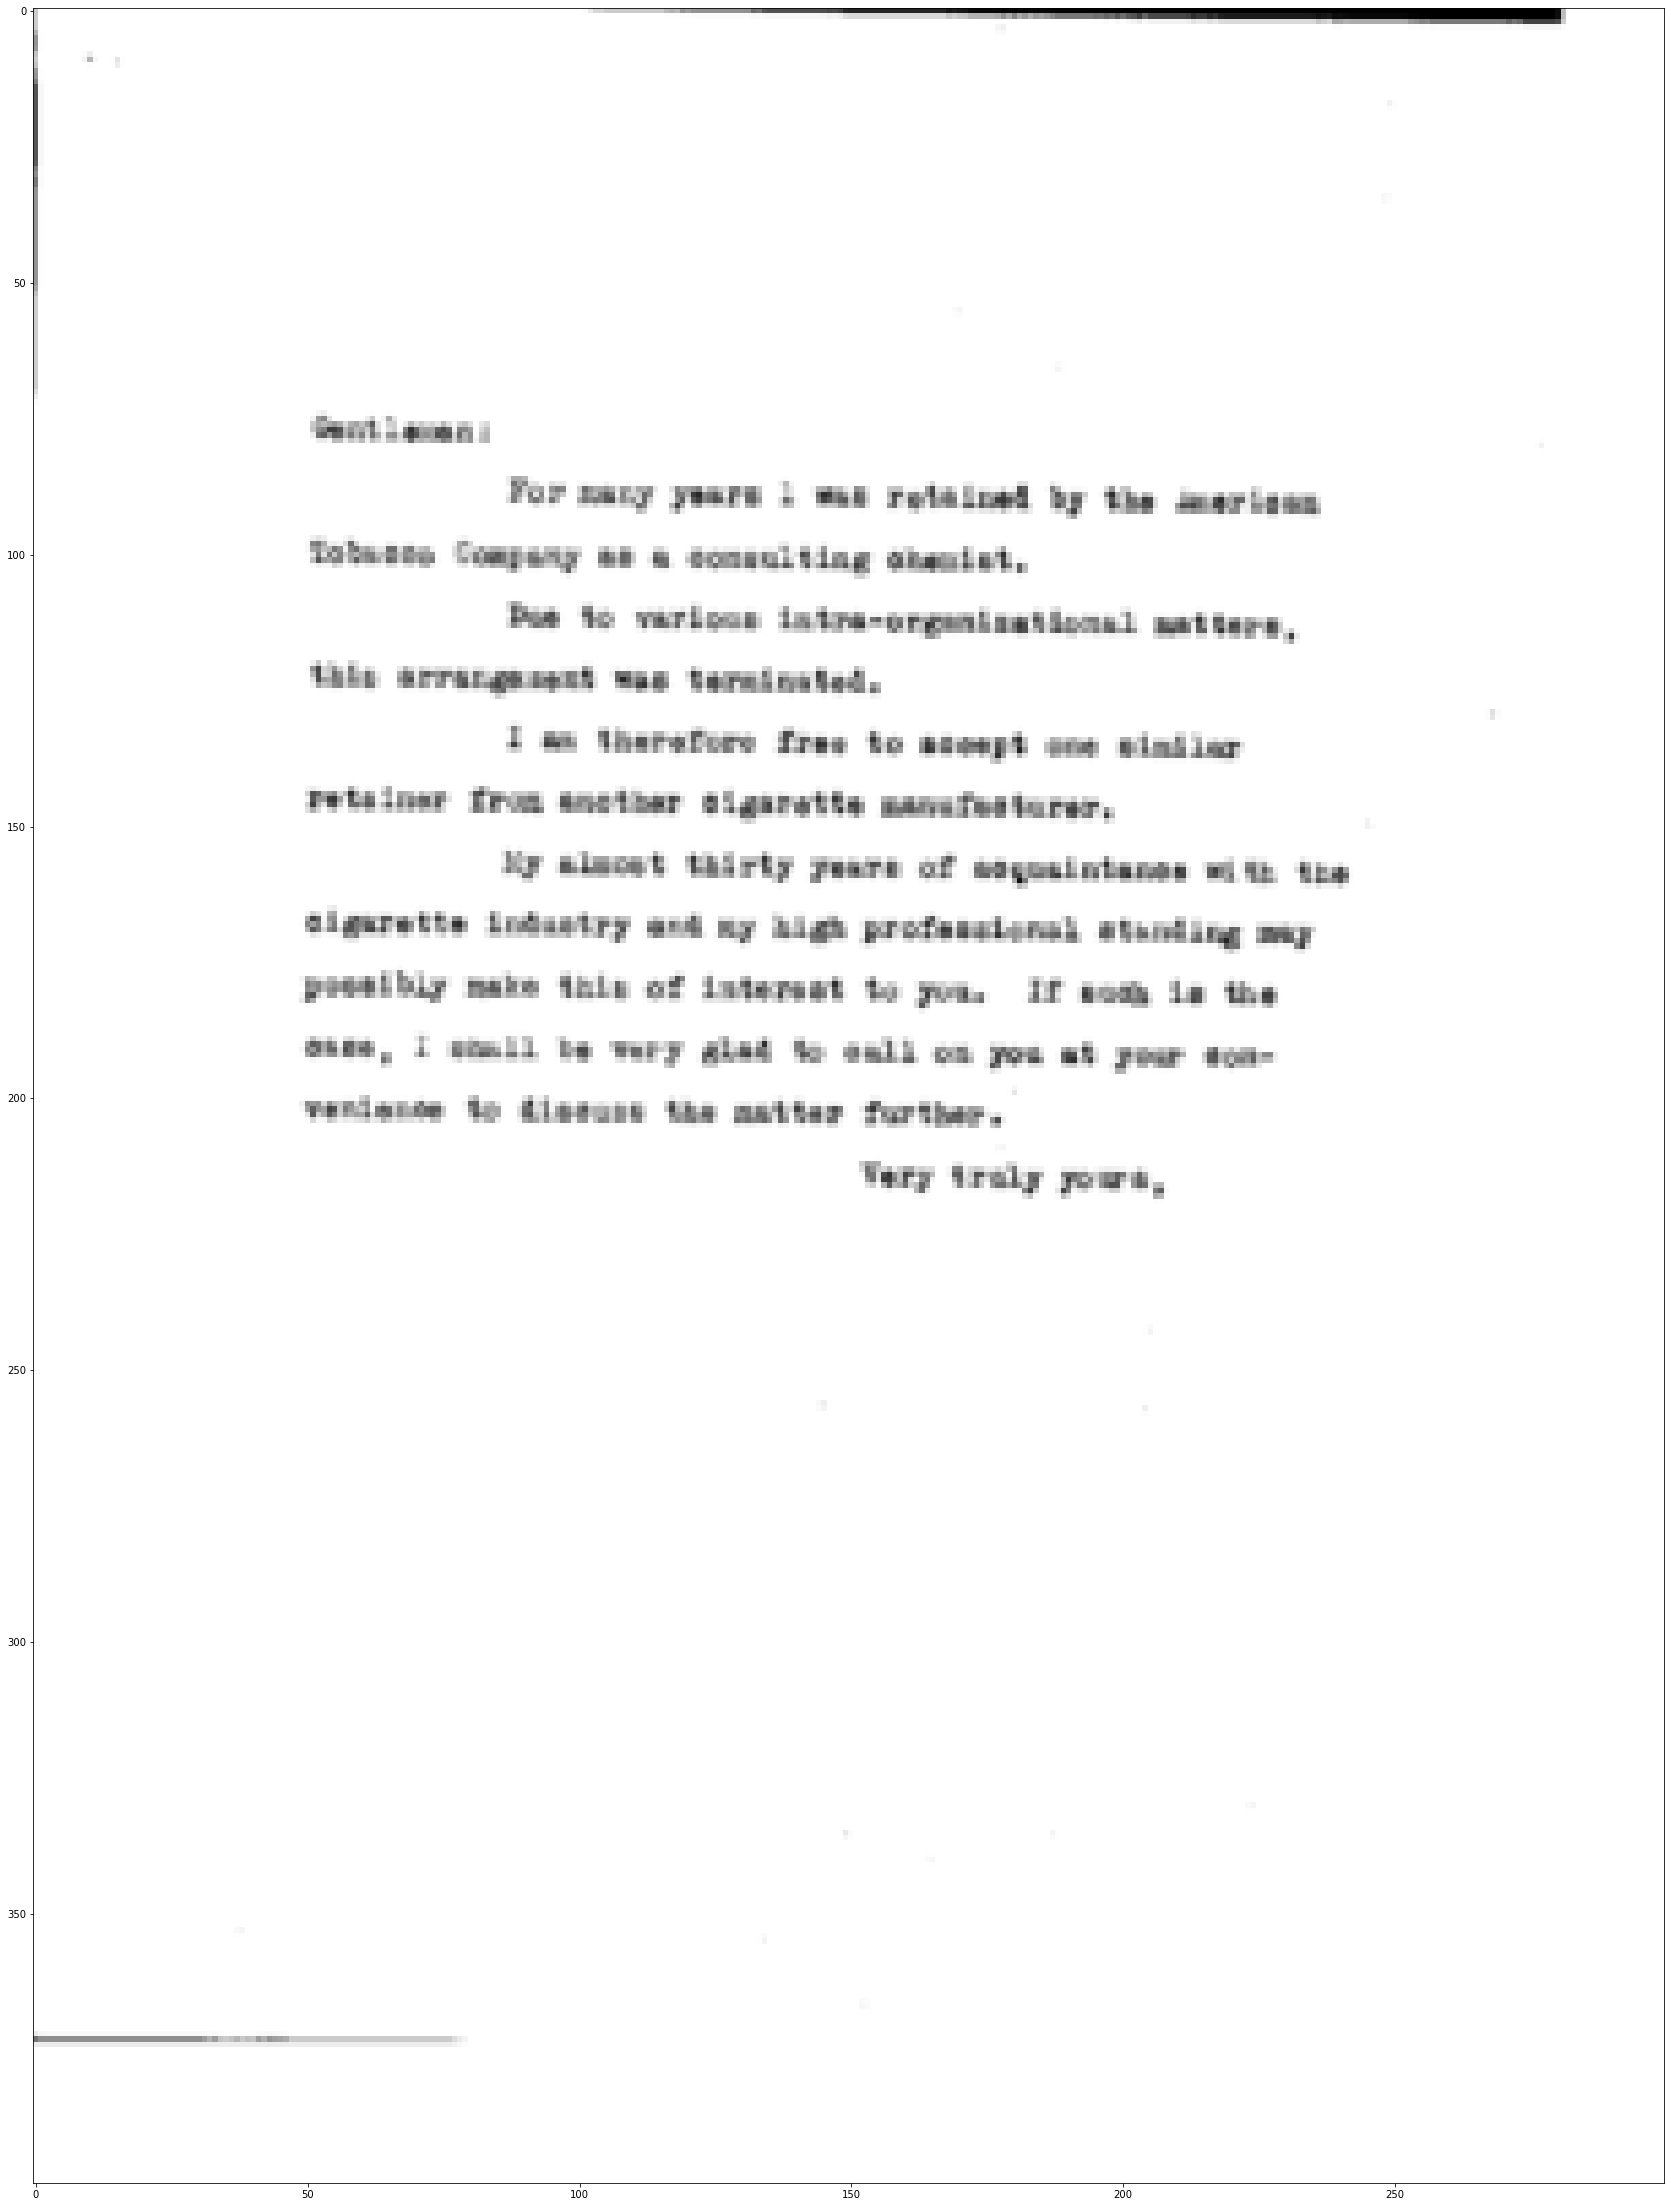

Labels: Gent Lenen: For many yours 1 was rotained by the american Tobucco Company as a consulting ohenist, Due to various intra-organizational matters, thie arrangosent was terminated. I am therefore free to accept one sintlar retainer fron another oigarette manufacturer, My almost thirty yours of aogusintance with the cigarette industry and my high professional standing may possibly make this of interest to you. If such 1s the ease, i shall be very glad to call on you at your con- venience to disouss the matter further. Very truly yours,
Pred: Gentlemen: For many years I was retained by the American Tobacco Company as a consulting chemist. Due to various infora- tional matters, this arrangement was terminated. I am therefore free to accept one similar reiter from another cigarette manufacturer. By almost thirty years of acquaintance with the cigarette industry and by high professional standing may possibly make this of interest to you. If such is the case, I shall be very glad to call

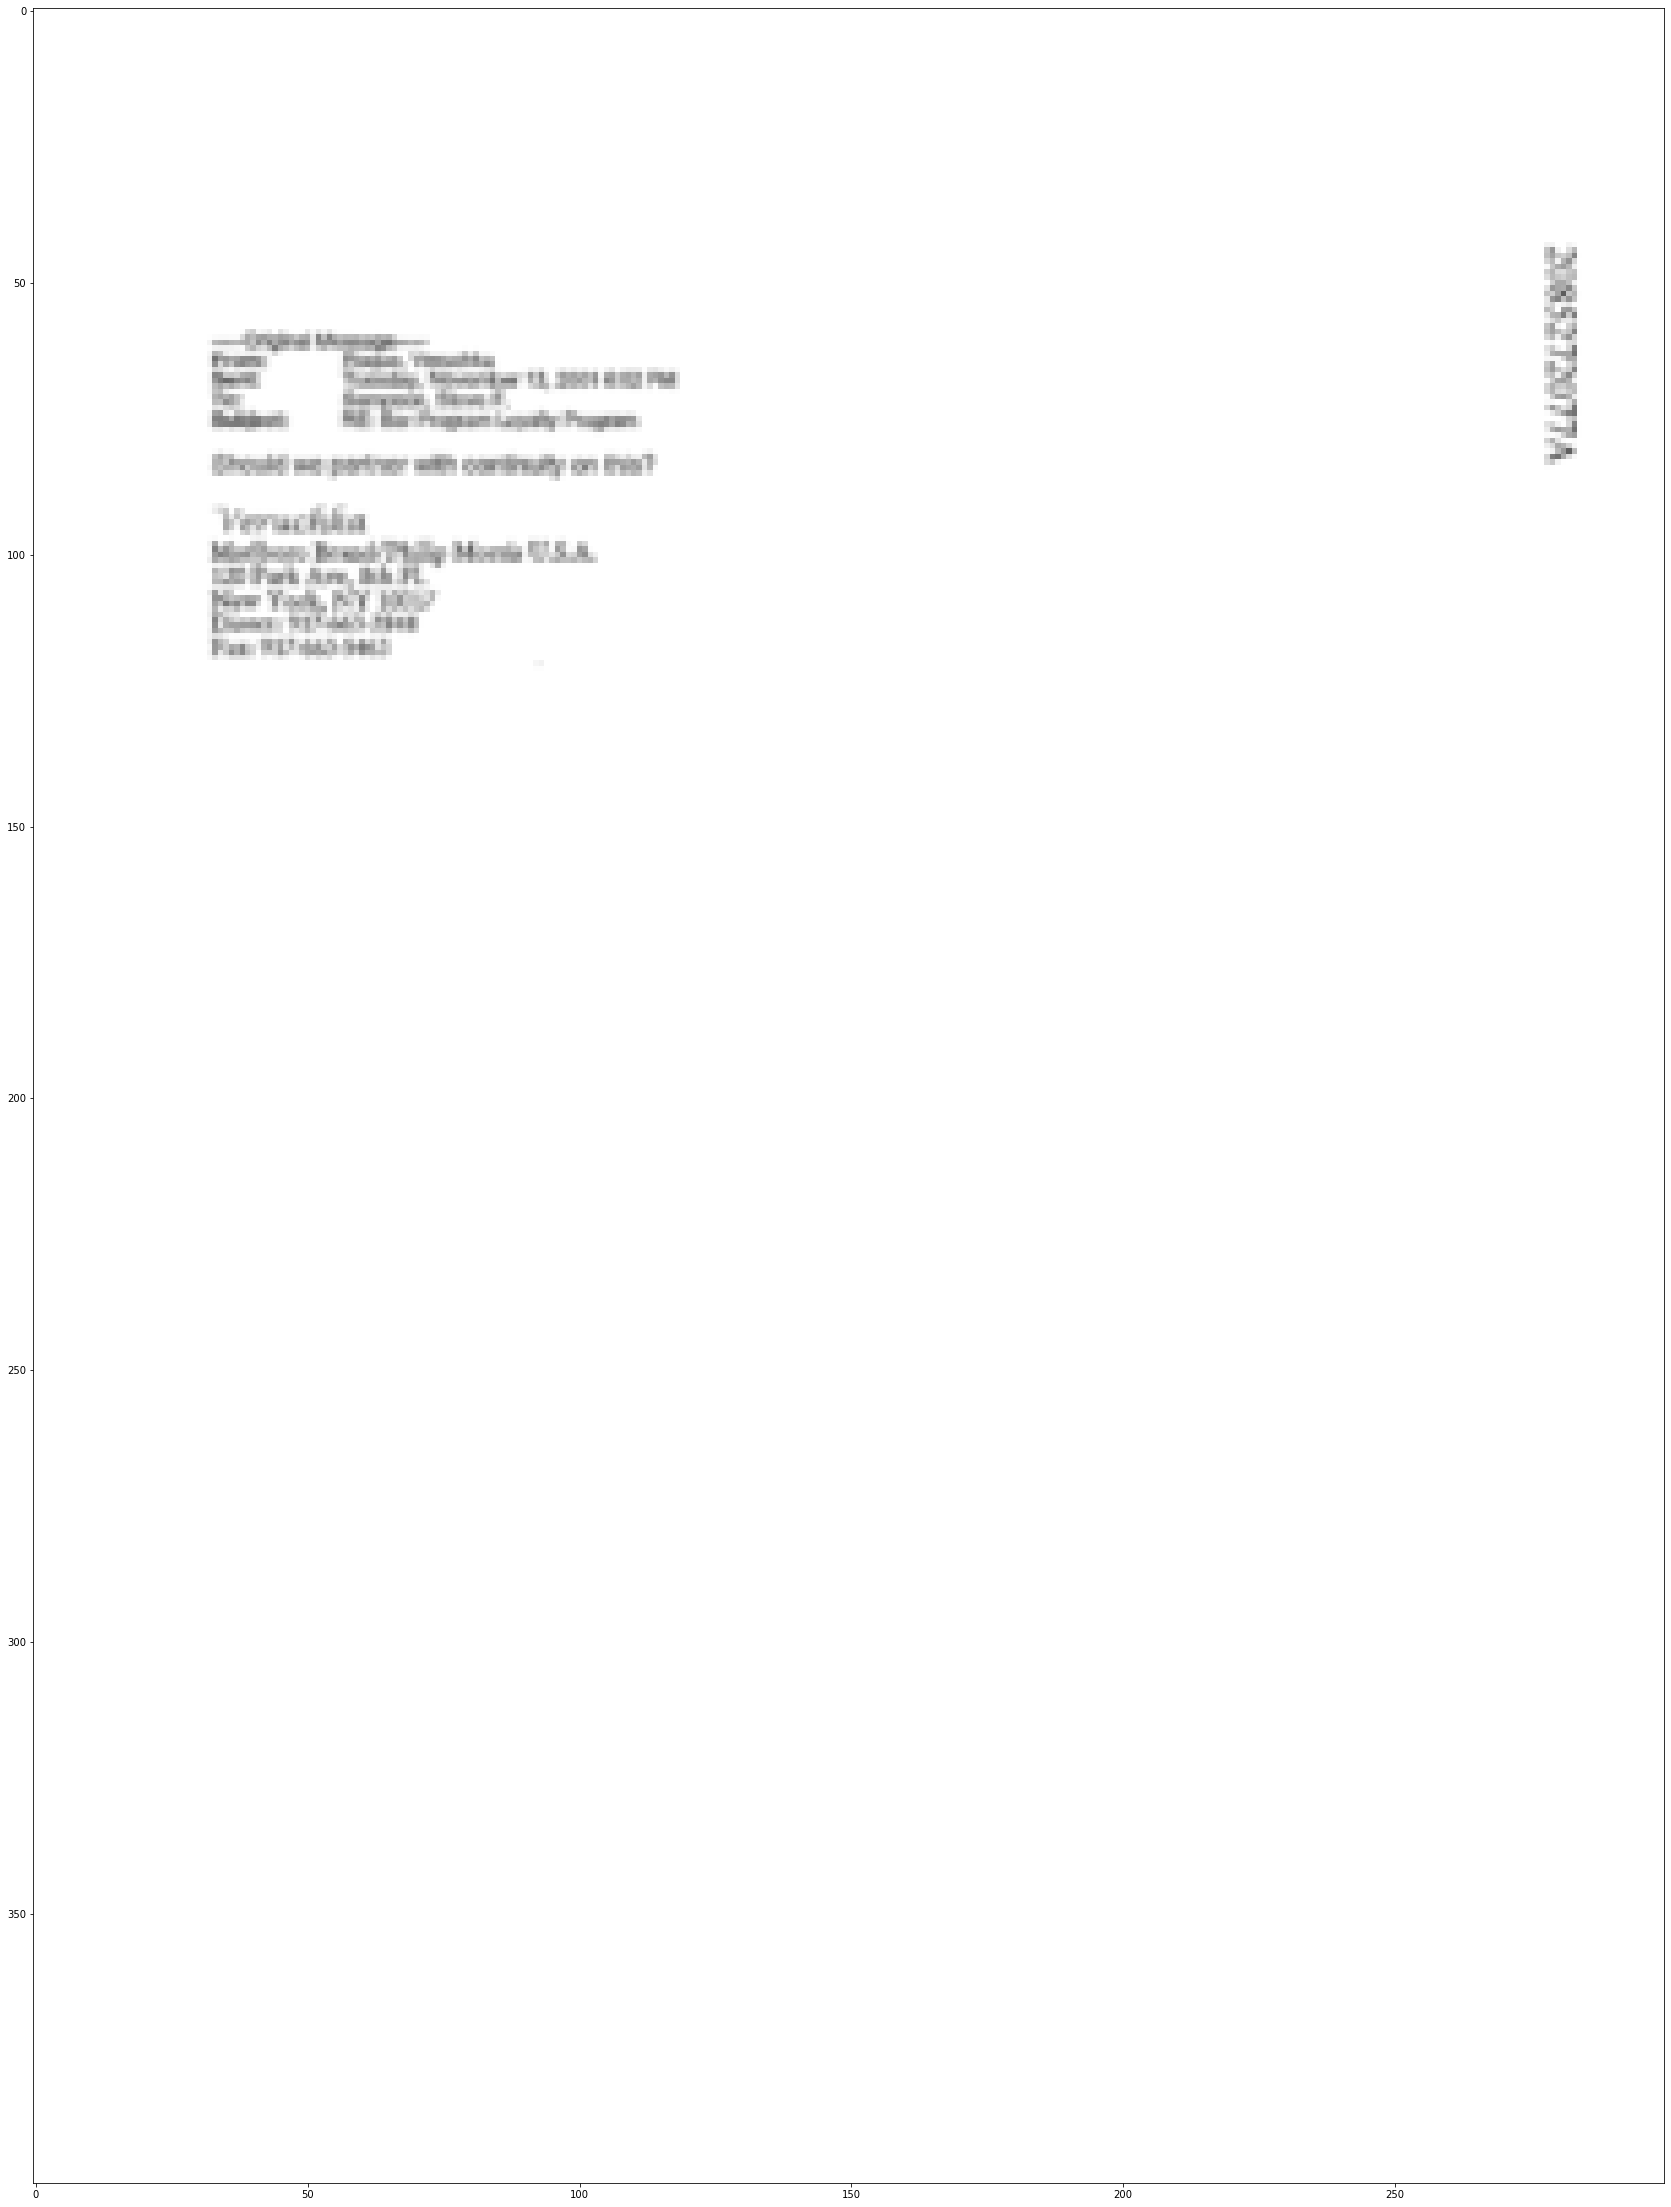

Labels: a rata Se EE to rater Efe Sone ERIN onn monn Sho wo rir cnn on Veruchka Marlboro Brand/Philip Morris US.A. 120 Park Ave, Sth FL New York, NY 10017 Dicect: 917.663.2848 Pa 917-663-5463  VLLOZLTS807
Pred: Original Message— From: ‘Sent: Tor Subject: Should we continue with continuity for this? Yeril Schultz Manager, Brand/St. Media USA. 120 Park Avenue, Suite 900 New York, NY 10017 Ph. (212) 680-3695 Fax (212) 680-3649 VLELELTS80T



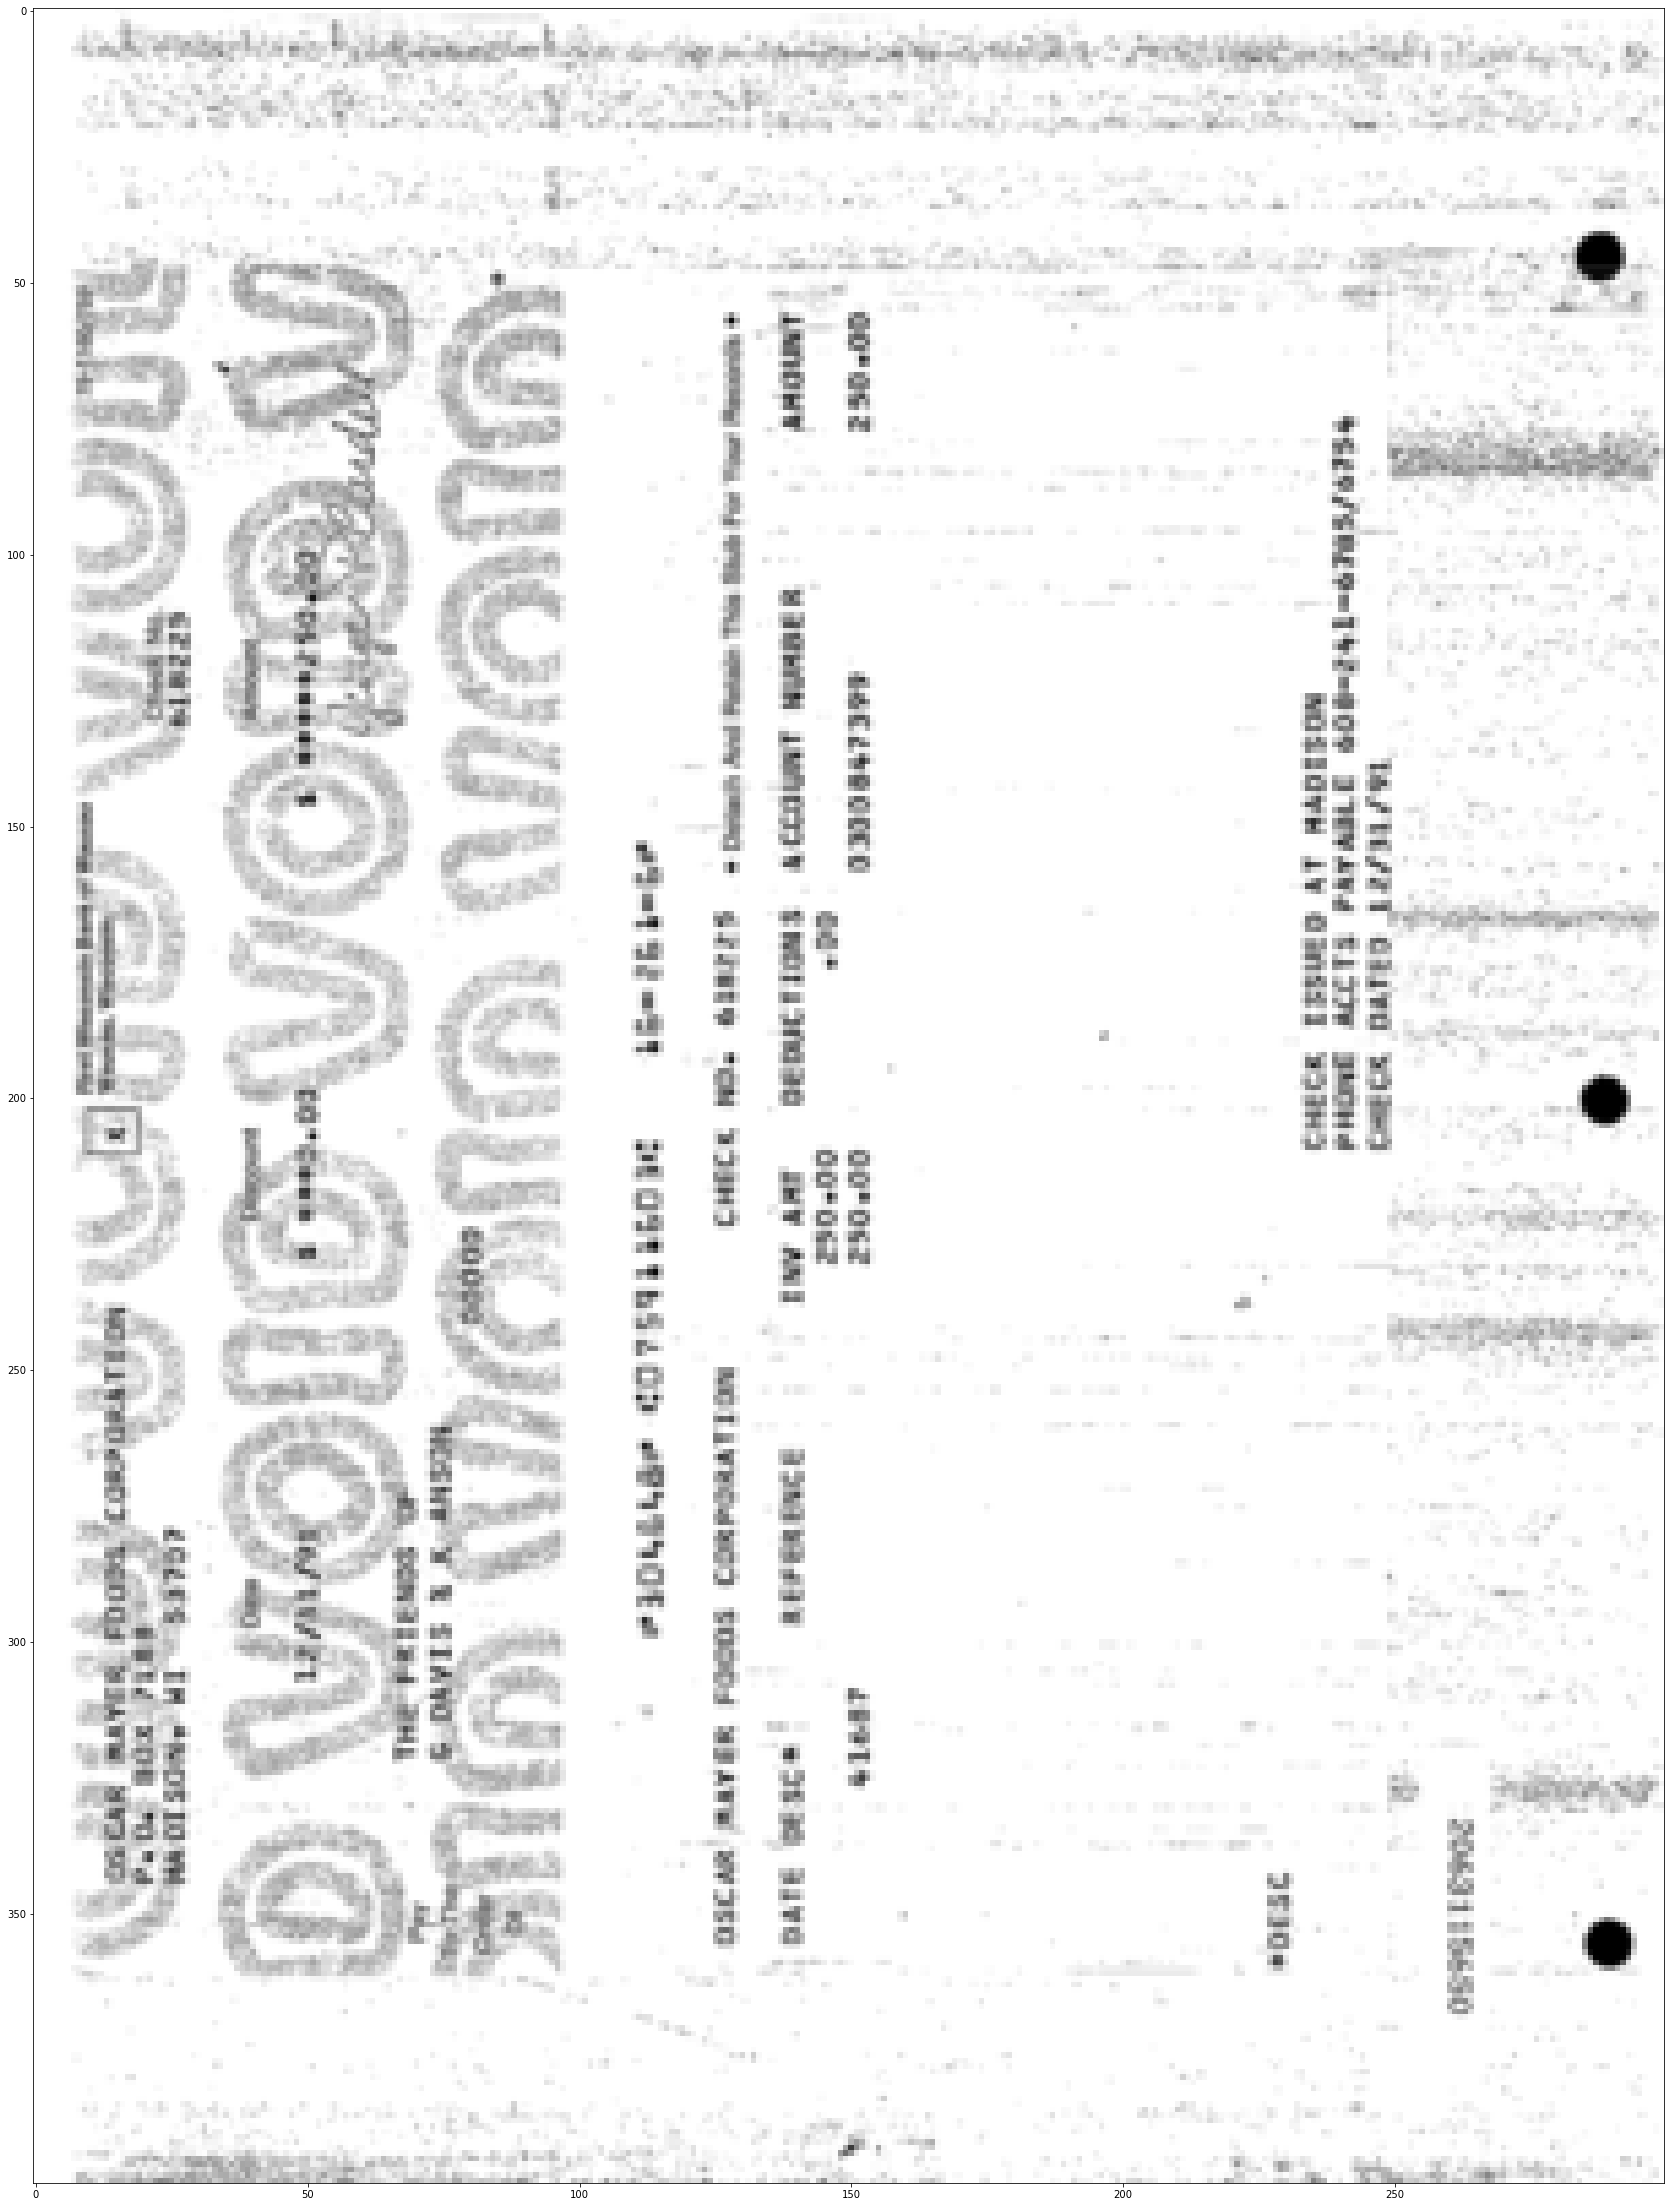

Labels:       = W30LRL8" EO?STREBORN 2G" 26 be gie ‘oscar’ MAYER FOODS CORPORATION CHECK NO. 618225 '* Detach And Retain This Stub For Your Records © © DATE vesc#! | REFERENCE | |. INV AMT DEDUCTIONS ACCOUNT NUMBER’ , AMOUNT ' 250.00 200 41687 ' 250400 0300847399 250400. ] CHECK ISSUED AT MADISON | i : PHONE ACCTS PAYABLE 608-241-6785/6754 a . CHECK DATED 12/31/51 S9STTEI0Z   
Pred: ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee 



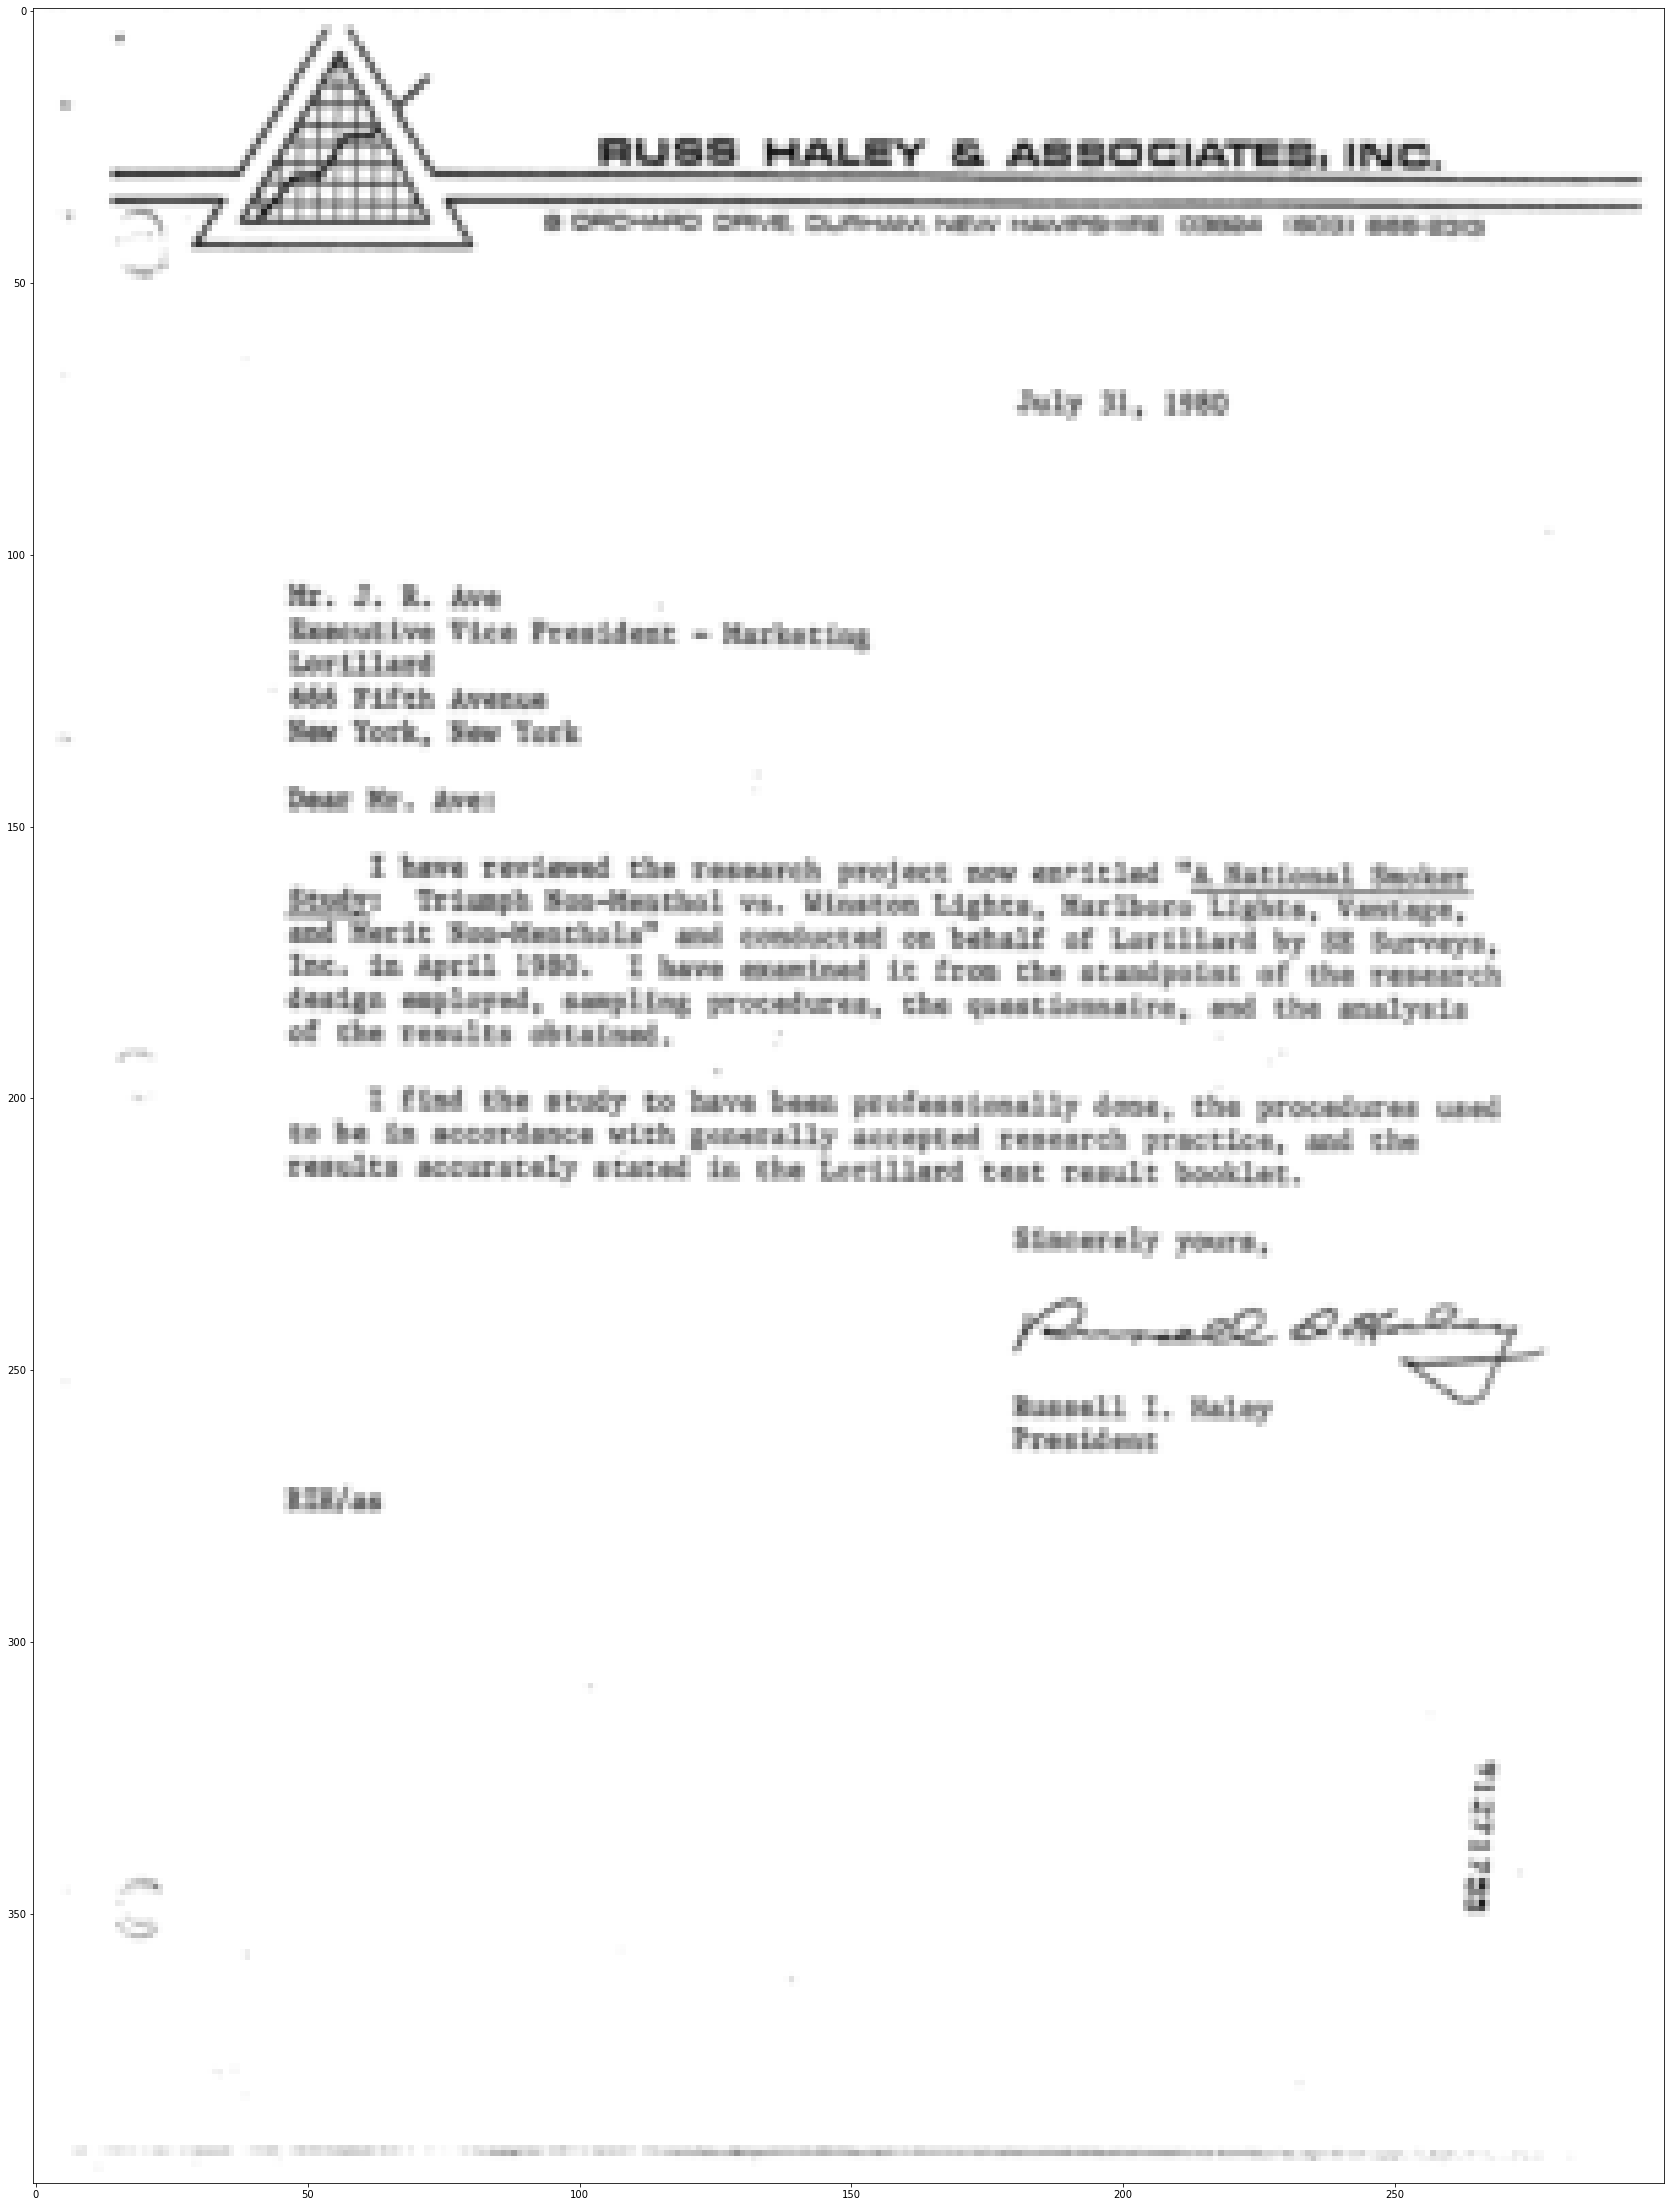

Labels:      RUSS HALEY & ASSOCIATES: INC.           (YZ 2 ORGHaRS DAW, DURHAM NEW HAMPSHIRE 03624 (605) GSOESS   July 31, 1980 Mr. J. R. Ave Executive Vice President ~ Marketing Lorillard 666 Fifth Avenue New York, New York Dear Mr. Ave: I have reviewed the research project now entitled "A National Smoker Study: Triumph Non-Menthol vs. Winston Lights, Marlboro Lights, Vantage, and Merit Non-Menthols" and conducted on behalf of Lorillard by SE Surveys, Inc. in April 1980. I have examined it from the standpoint of the research design employed, sampling procedures, the questionnaire, and the analysis of the results obtained. I find the study to have been professionally done, the procedures used to be in accordance with generally accepted research practice, and the results accurately stated in the Lorillard test result booklet. Sincerely yours, (Qnnn20 25 Ey Russell I. Haley President RIH/as Sscrezrg 
Pred:  ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇

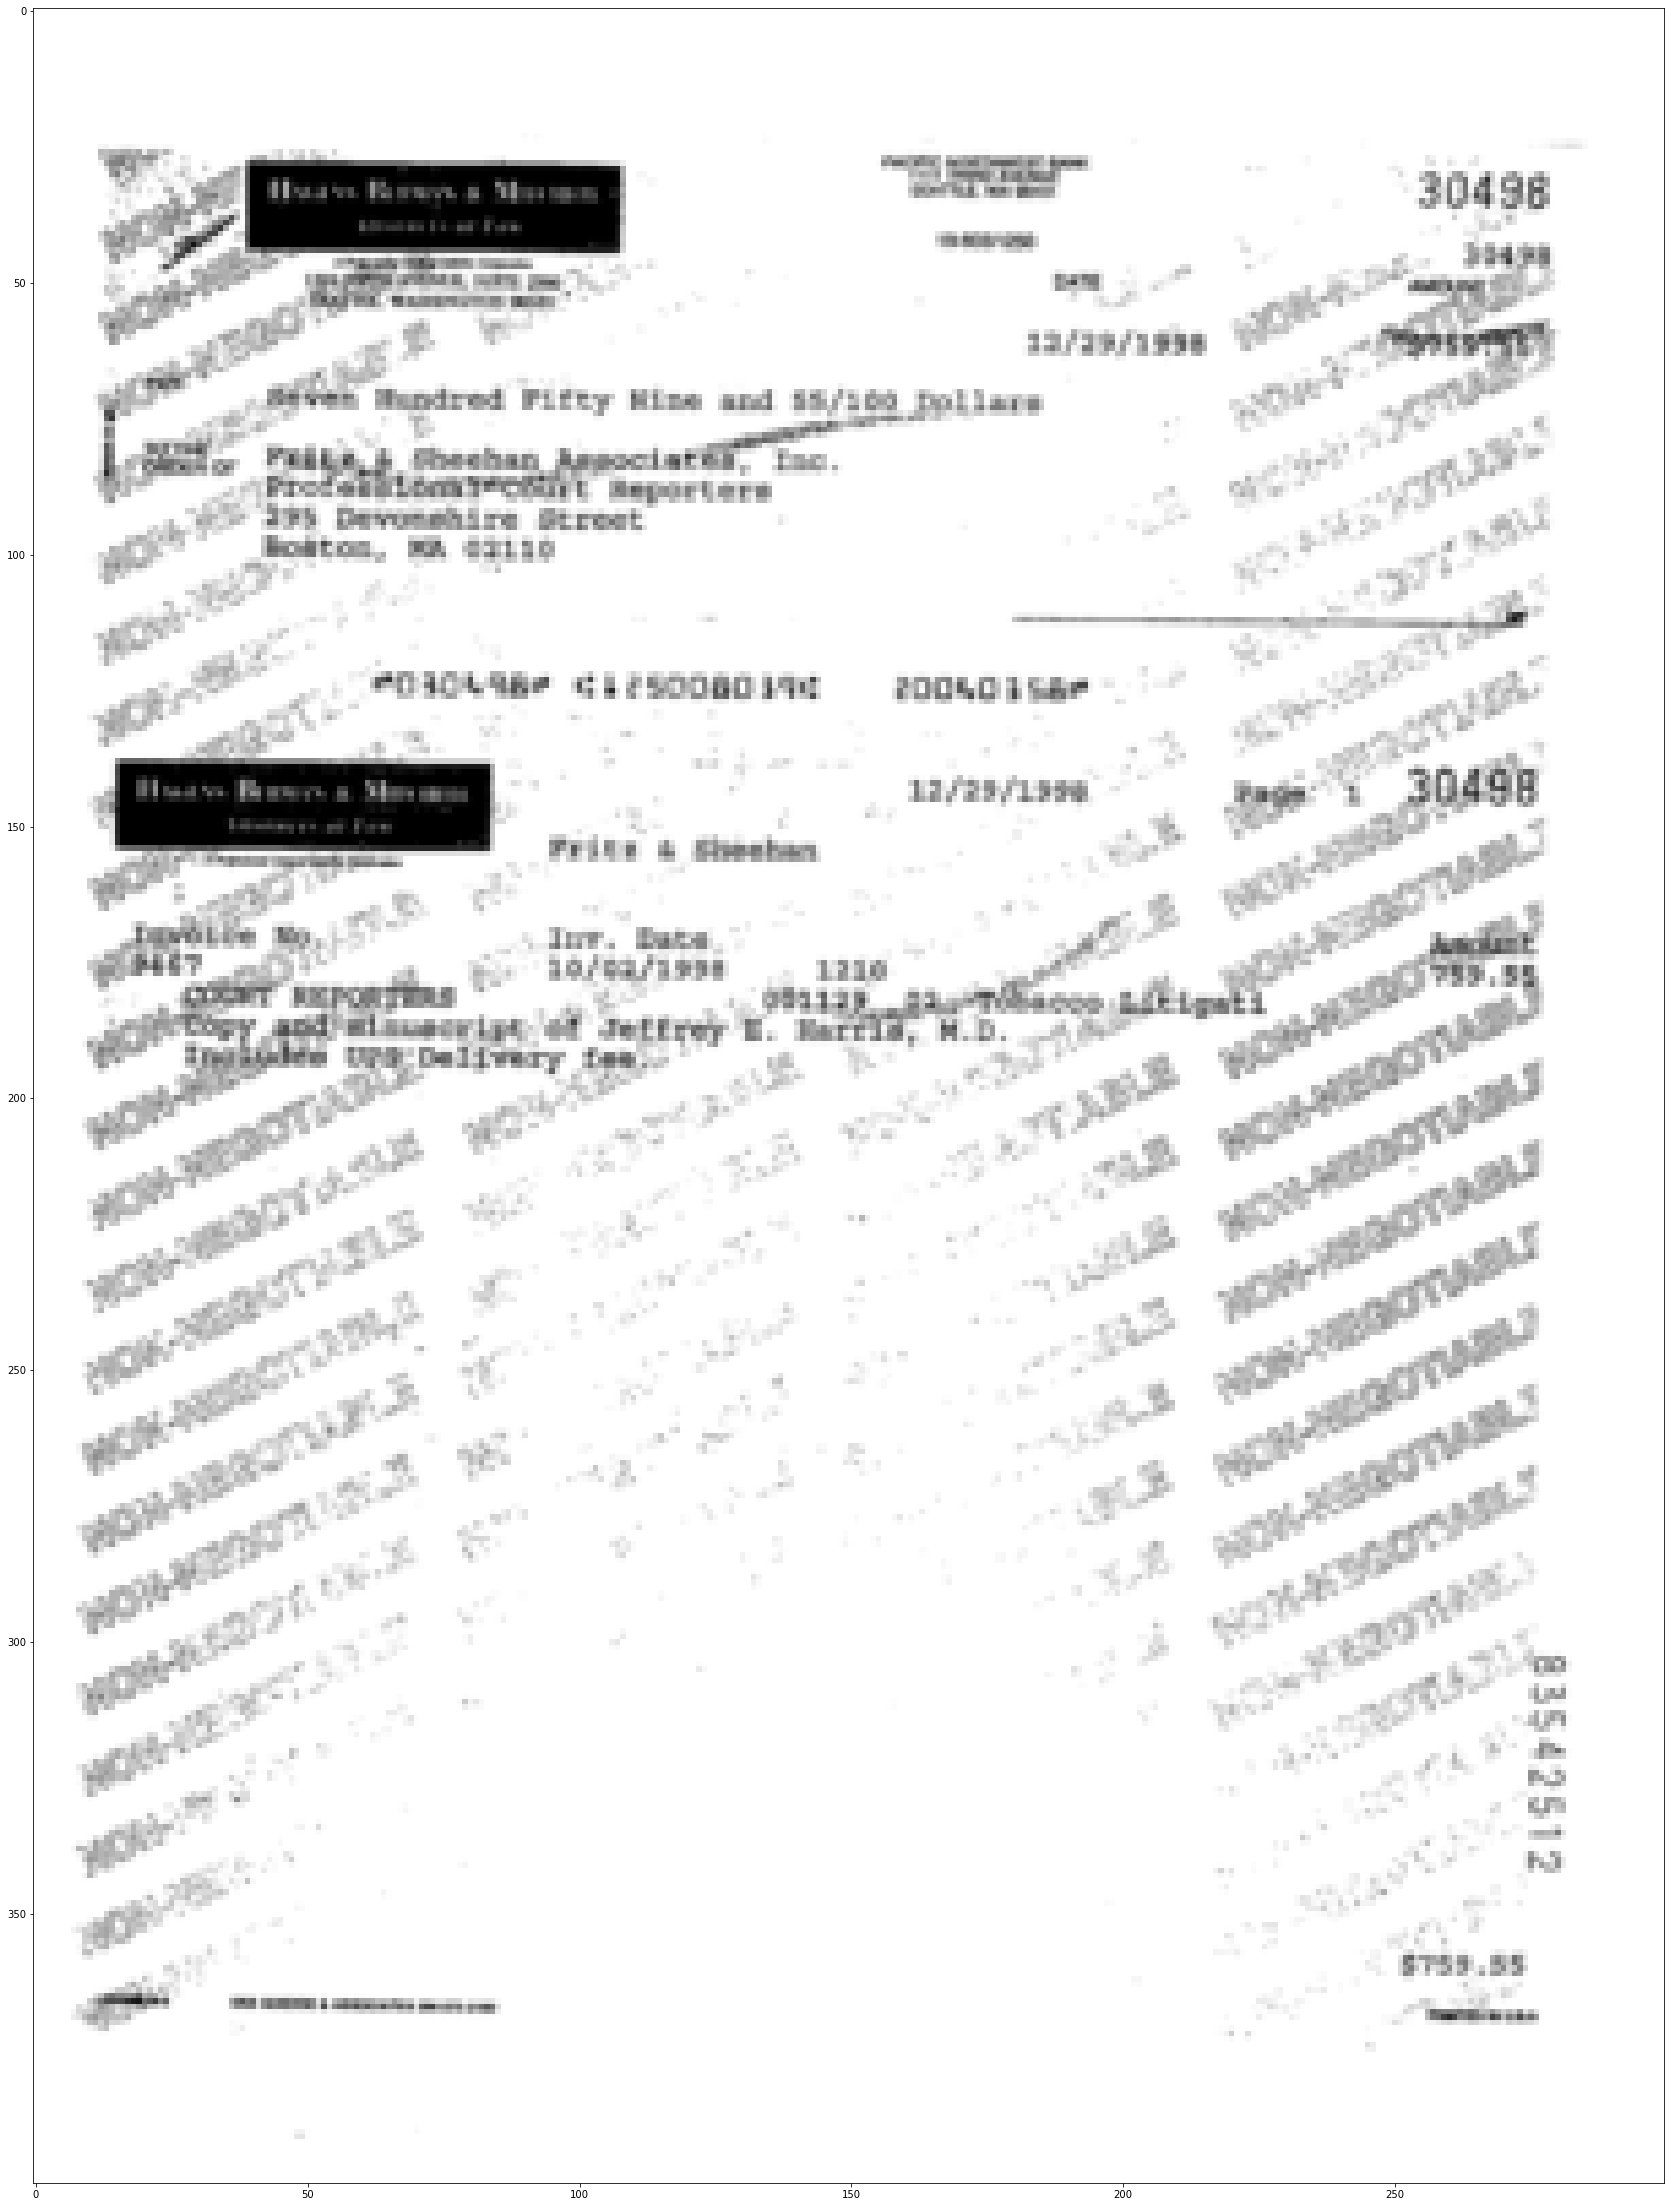

Labels:     soar are 12/29/1998        sf Hundred Fifty Nine and 55/109 Dollars Pedi, Sheehan Ae Ete. Professiénalcétrt Reporters 7382 °295 Devonshire Street Boston, MA 02110   WO30498" 125008039: 200403Sar ~ 12/29/1998. Fritz & Shéehan adnv. Date,” 10/02/1998 1210 ,002129,,,,0: eee,  B. Hai M.D.   LSZPSES  $759 +55
Pred: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a 



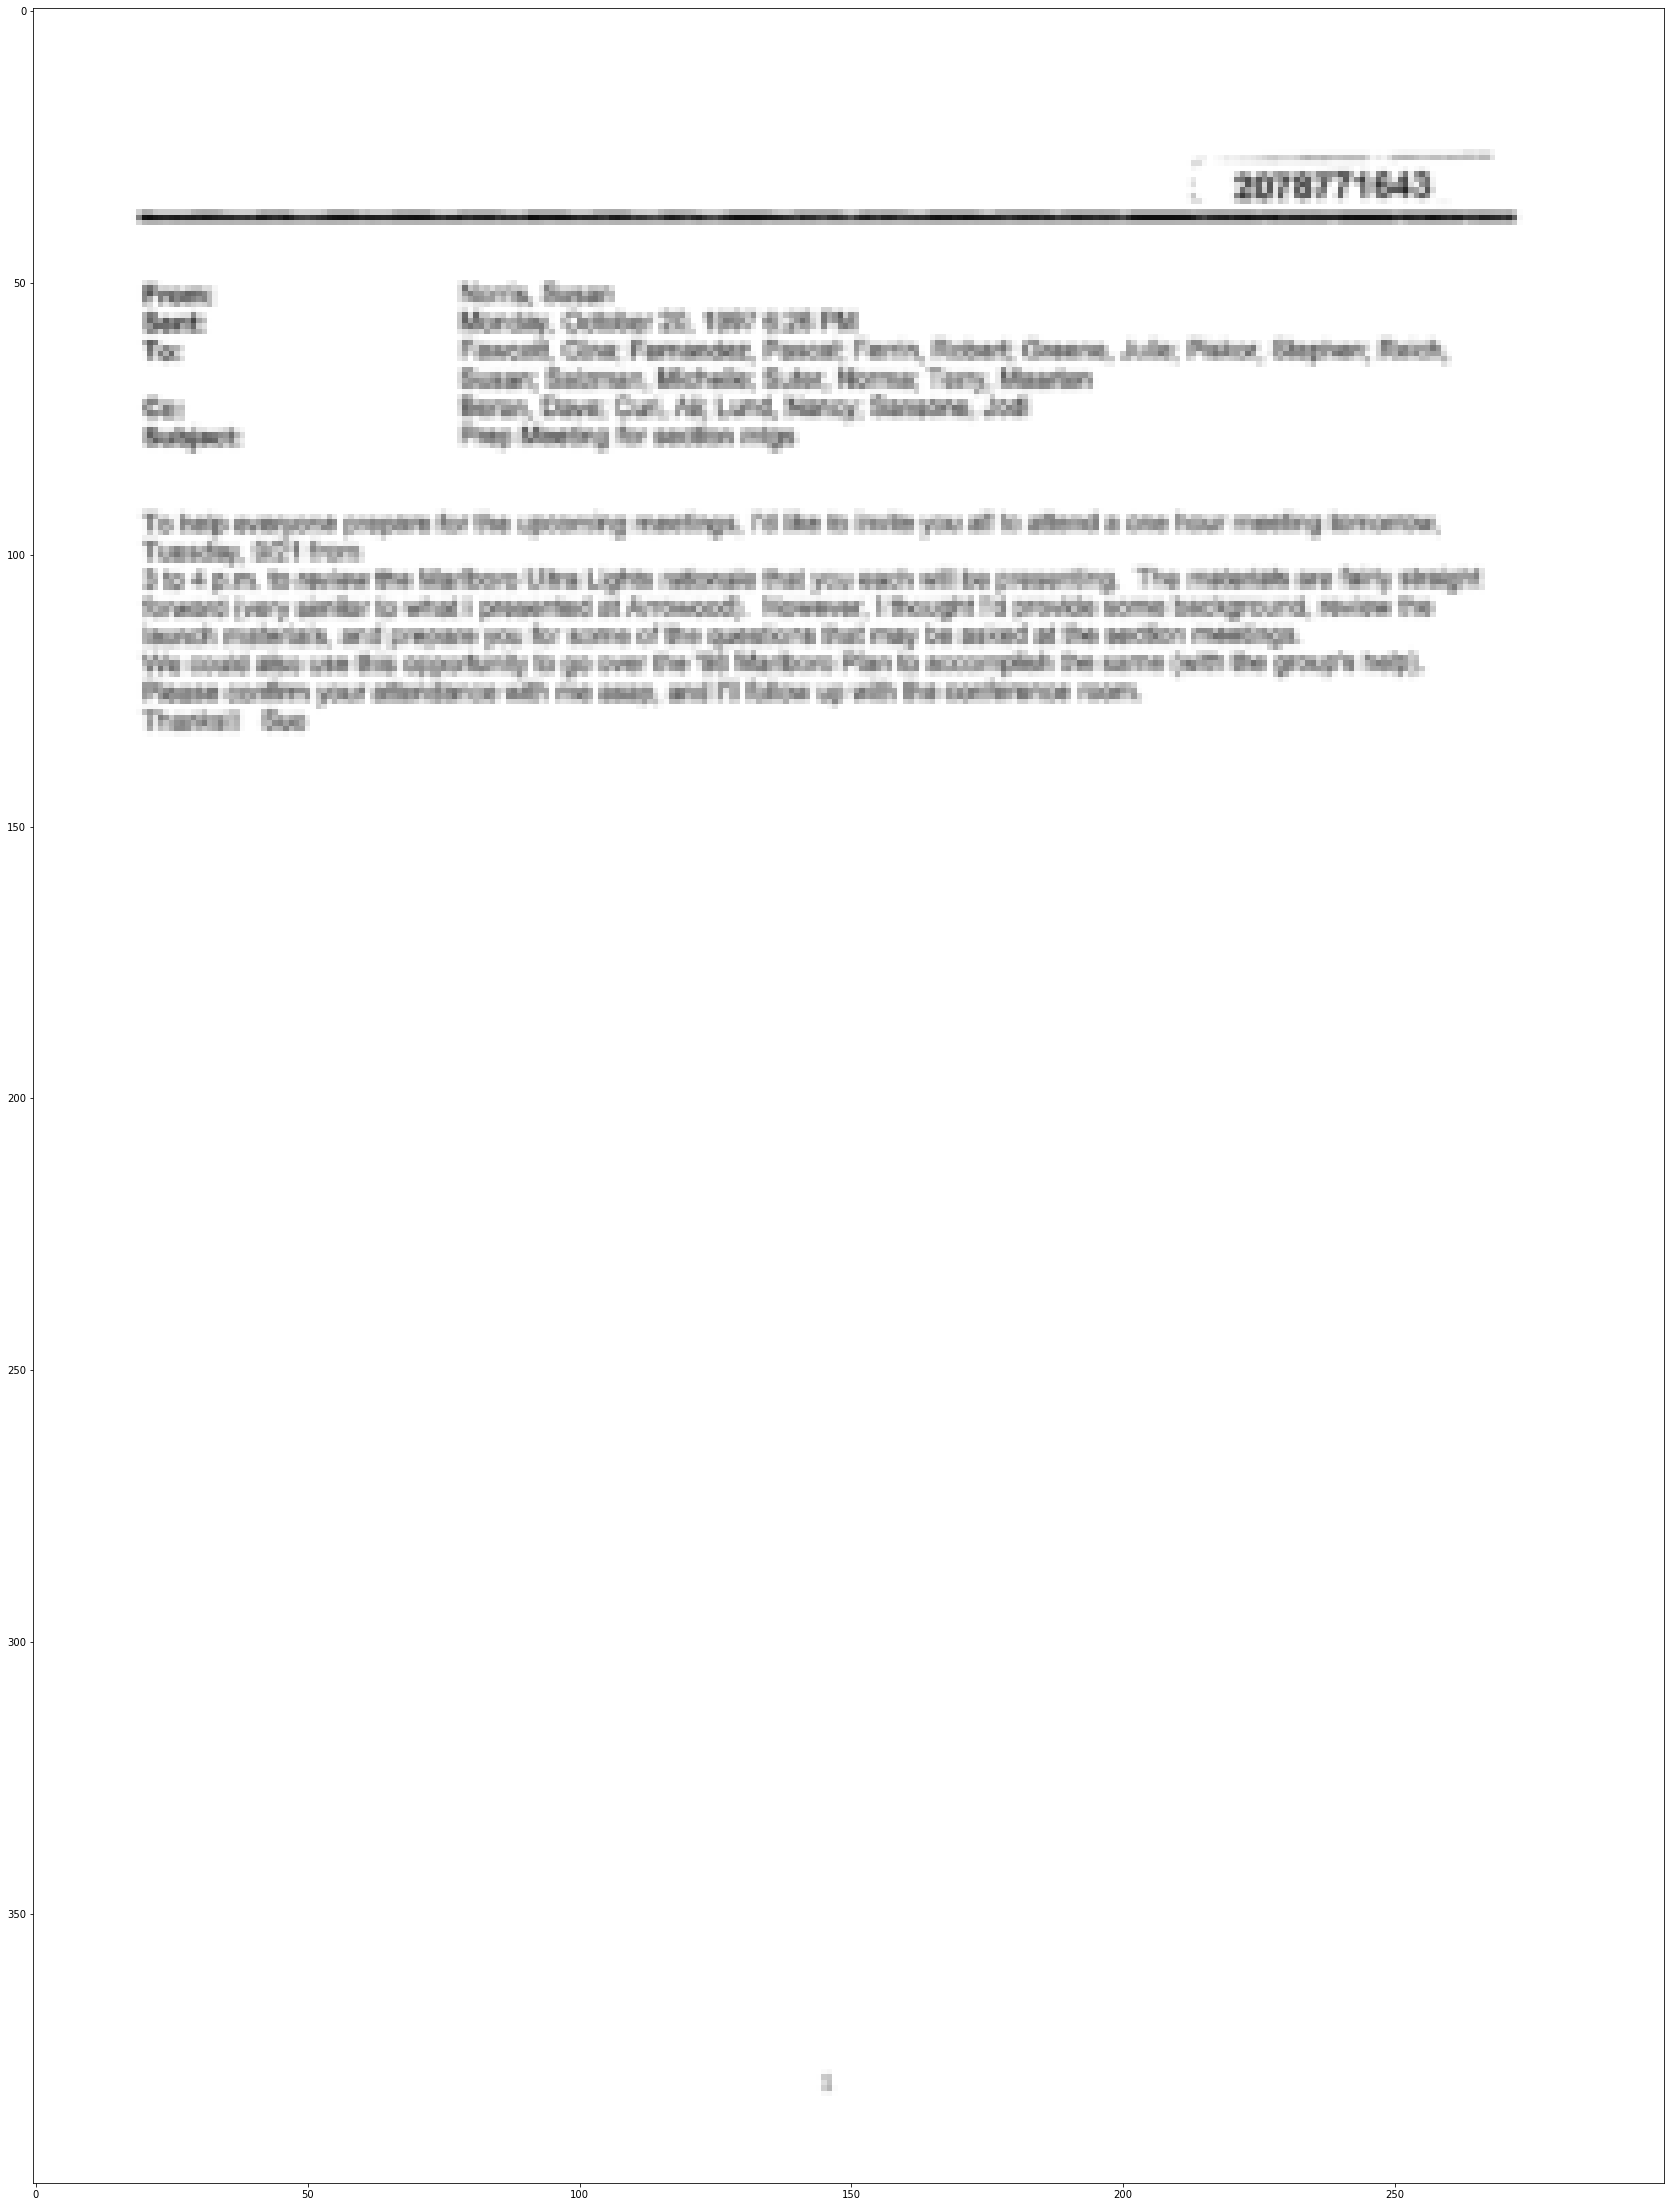

Labels: 2078771643   Norris, Susan Monday, October 20, 1997 6:26 PM. Fawcett, Gina; Femandez, Pascal; Ferrin, Robert; Greene, Julie; Piskor, Stephen; Reich, Susan; Salzman, Michelle; Suter, Norma; Terry, Maarten Beran, Dave; Curi, Al; Lund, Nancy; Sansone, Jodi Subject: Prep Meeting for section mtas  To help everyone prepare for the upcoming meetings, I'd lke to invite you all to attend a one hour meeting tomorrow, Tuesday, 9/21 from 3 t0 4 pum. to review the Marlboro Ultra Lights rationale that you each will be presenting, The materials are fairly straight forward (very similar to what | presented at Arrowood). However. | thought Id provide some background, review the aunch materials, and prepare you for some of the questions that may be asked at the section meetings. ‘We could also use this opportunity to go over the ‘98 Mariboro Plan to accomplish the same (with the group's help). Please confirm your attendance with me asap, and Il follow up with the conference room. Thanksl! Sue
Pr

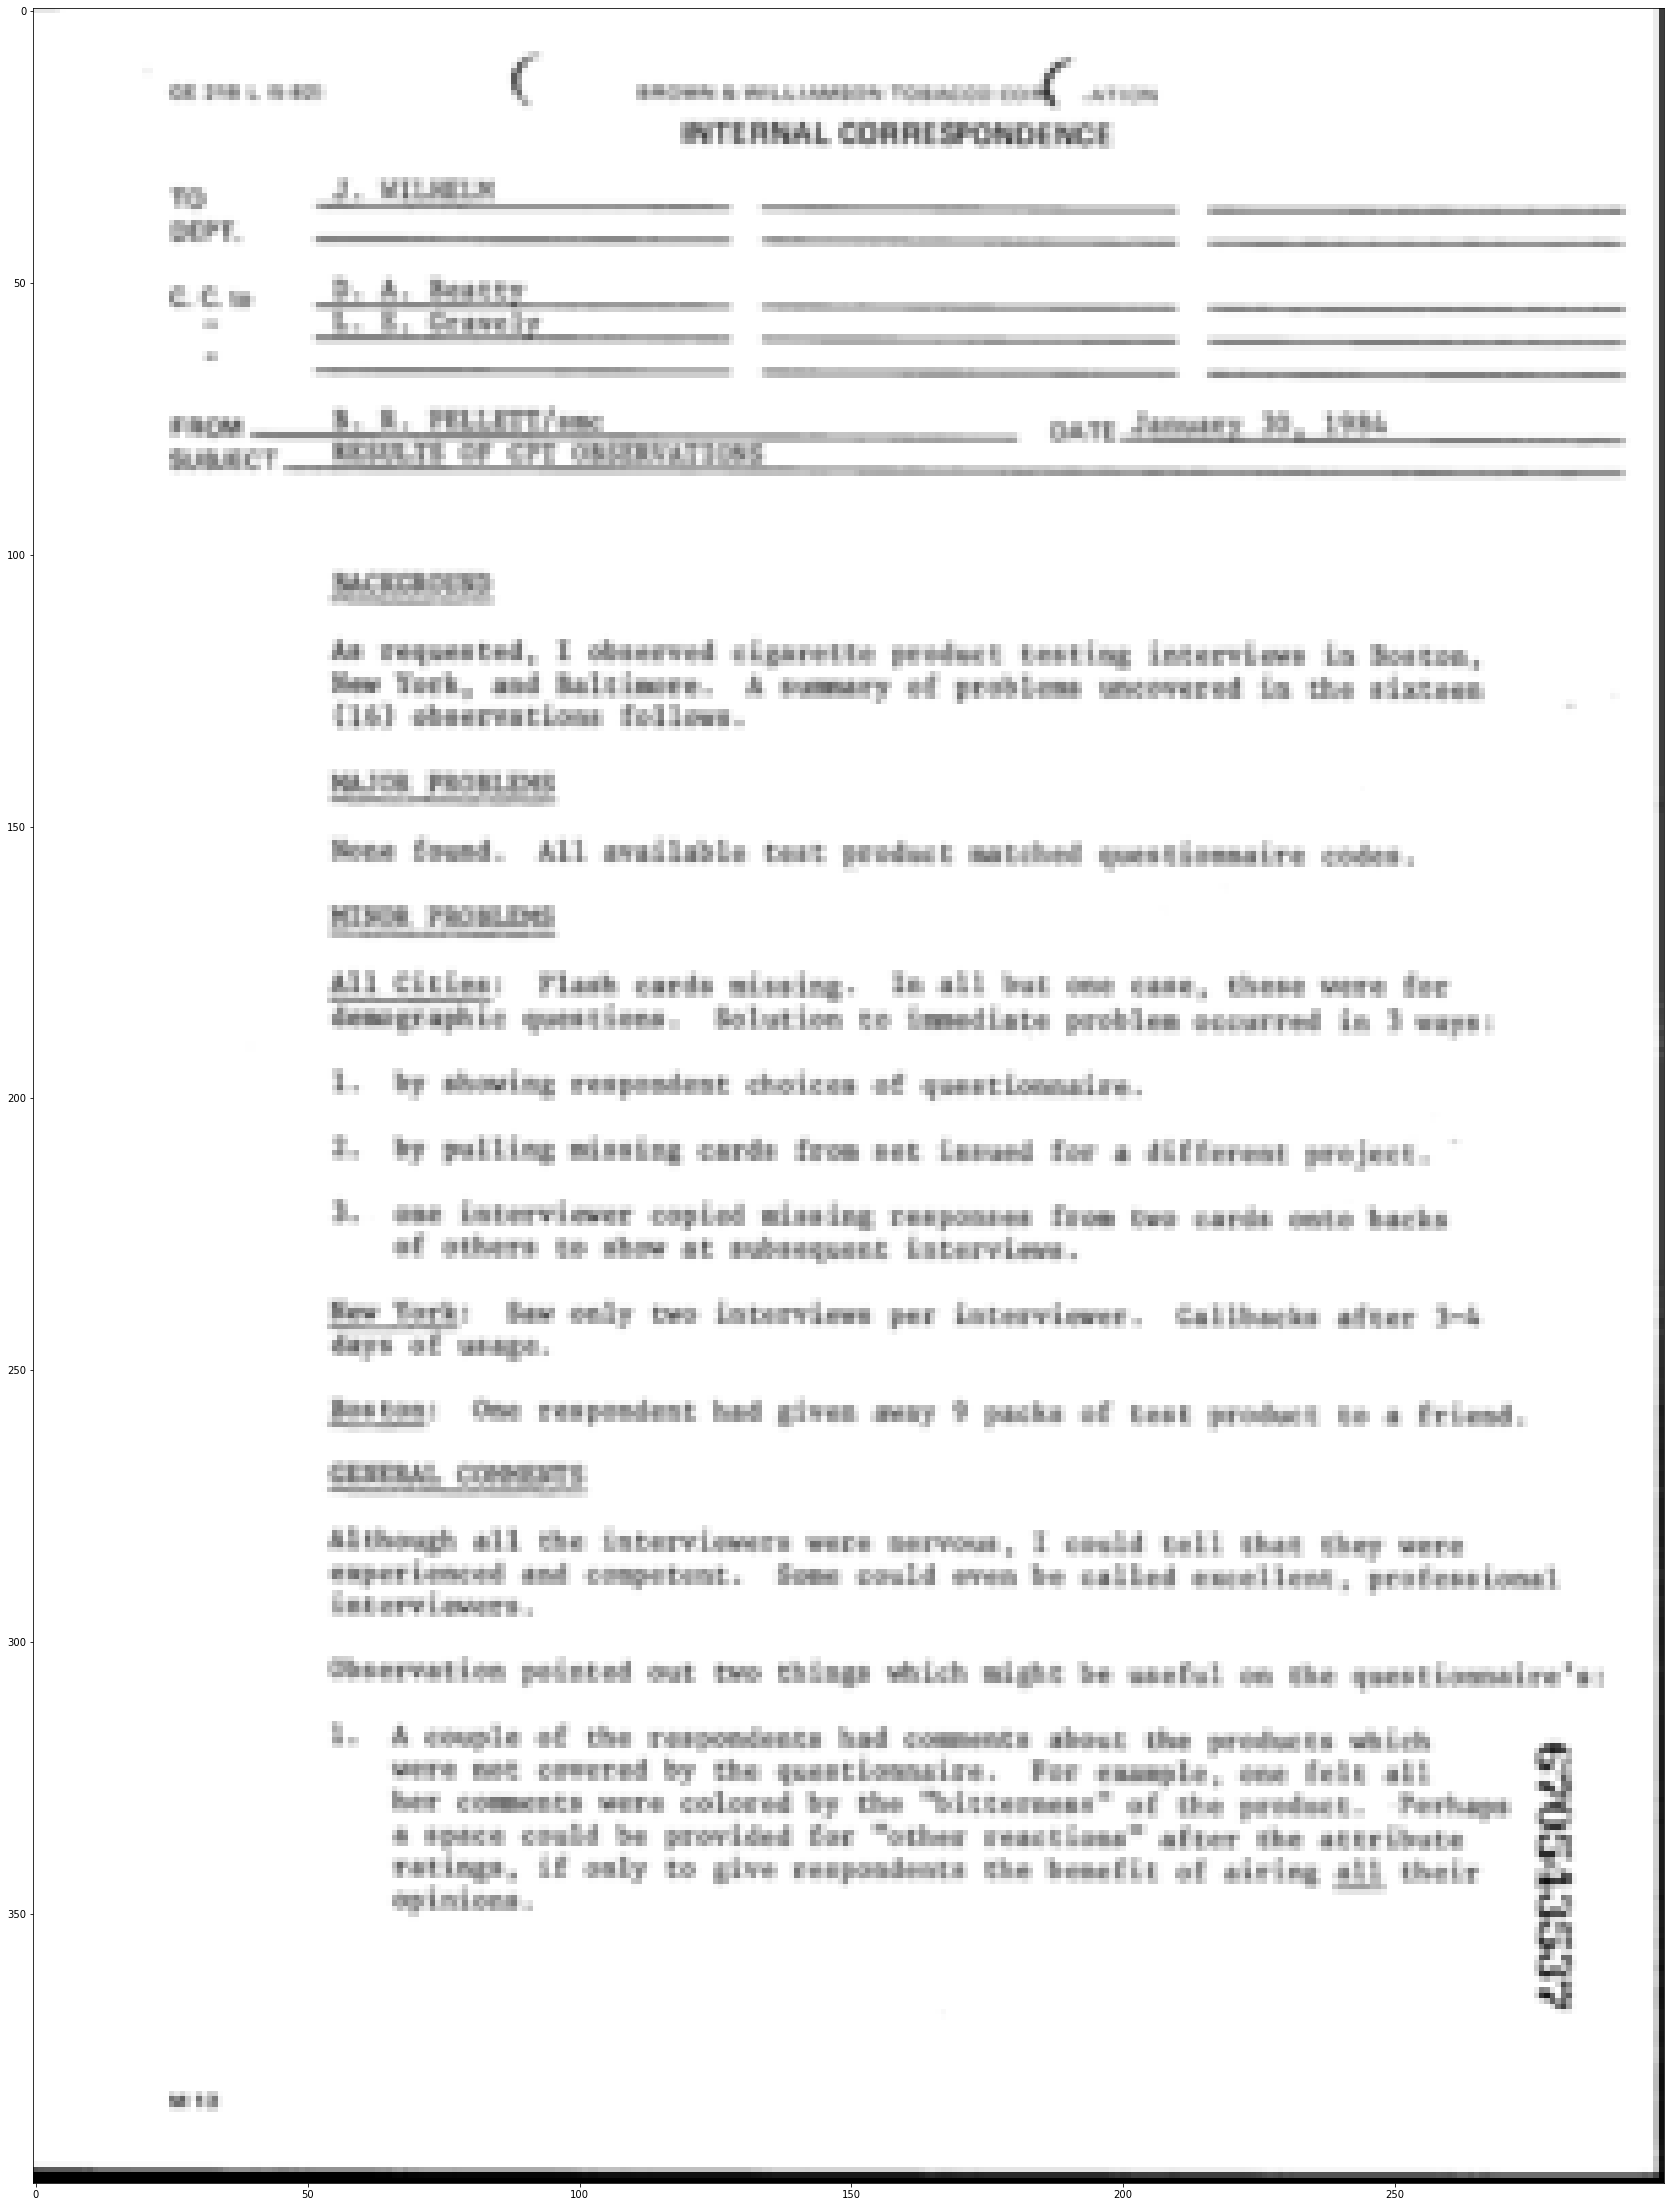

Labels: To DEPT. C—enow a missason roacco con .arion INTERNAL CORRESPONDENCE J. WILHELM  C.c.t0 D. A. Beatt L. E. Gravel.  FROM SUBJECT  B.R. PELLETT/sme pate January 30, 1984 RESULTS OF CPT OBSERVATIONS BACKGROUND As requested, I observed cigarette product testing interviews in Boston, New York, and Baltimore. A summary of problems uncovered in the sixteen (16) observations follows. MAJOR PROBLEMS None found. All available test product matched questionnaire codes. MINOR PROBLEMS All Cities: Flash cards missing. In all but one case, these were for demographic questions. Solution to immediate problem occurred in 3 ways: 1. by showing respondent choices of questionnaire. by pulling missing cards from set issued for a different project. one interviewer copied missing responses from two cards onto backs of others to show at subsequent interviews. New York: Saw only two interviews per interviewer. Callbacks after 3-4 days of usage. Boston: One respondent had given away 9 packs of test produ

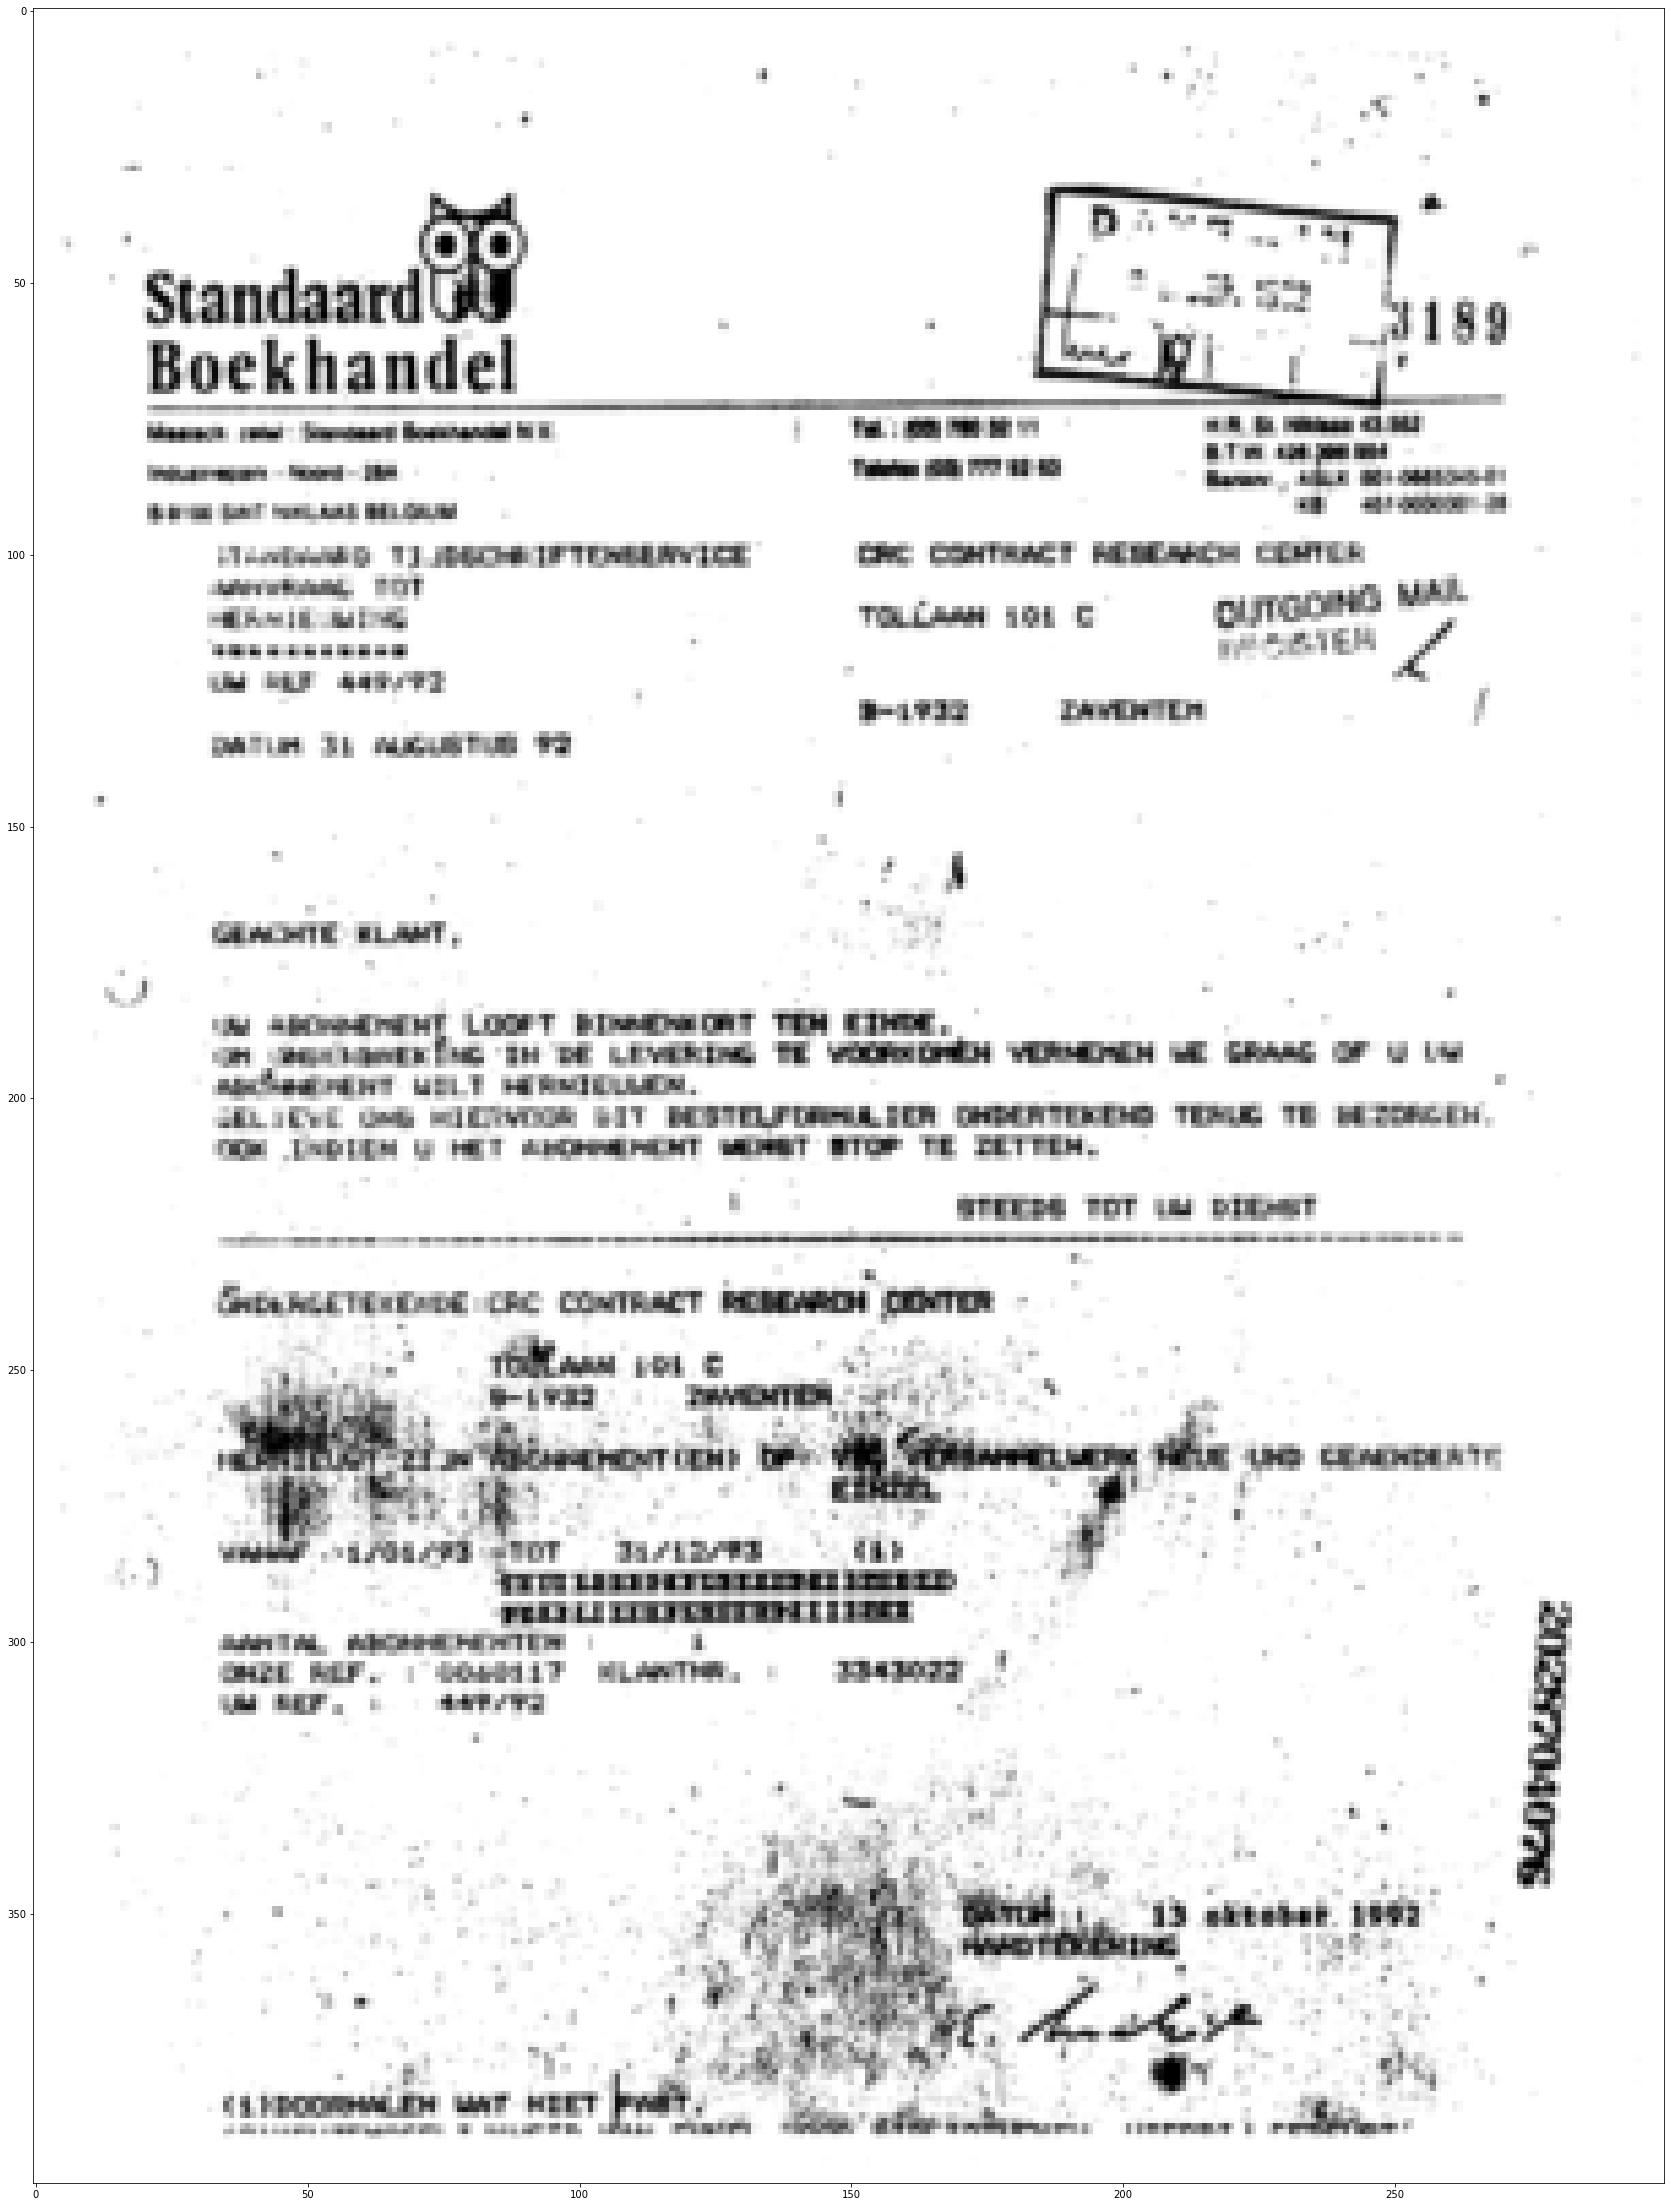

Labels: standaard Boekhandel   Hanisch ea Sanceard Gonthandl NV. 1 Tarenros 1 WA, St Niles 0.562 vnemesn na a8 Tameen 77 9063 Bi esos 0-100 SIT NKLAAS BELOILML xe co7000208 2 STHNDAARD TJ JDSCHRIFTENGERVICE (CRC CONTRACT RESEARCH CENTER AanvRAAG TOT 1 HERNIEUWING TOLLAAN 404 C OUTGOING Mal ene 7 BESIST  Ud REF 449/92 . B-1932 ZAVENTEM f DATUM 31 AUGUSTUS 92  GEACHTE-KLANT, UW ABONNENENT LOOFT BINNENKORT TEN EINDE. OM ONDEREREK ING “INDE LEVERING TE VOORKOMEN VERNEMEN WE GRAAG OF U LW ABCHNEHENT WILT HERNIEUWEN. ’ GELIEVE ONS HIERVOOR DIT BESTELFORMULIER ONDERTEKEND TERUG TE BEZORGEN, DOK THDIEN U HET AHONNENENT WENST STOP TE ZETTEN. i STEEDS TOT UW DIENST    GNDERGETEKENDE :CRC CONTRACT REBEARCH CENTER Toittaan sot. ay te (B-1932, ae j SHENTLEND oer AMPEL WERK ae UND GEAENDERTE     AANTAL ABONNEMENTEN i & ONZE REF. :°0060117 KLANTNR. : 3343022 .! US REF. i 449/92 eS -
Pred: .................................................................................................................

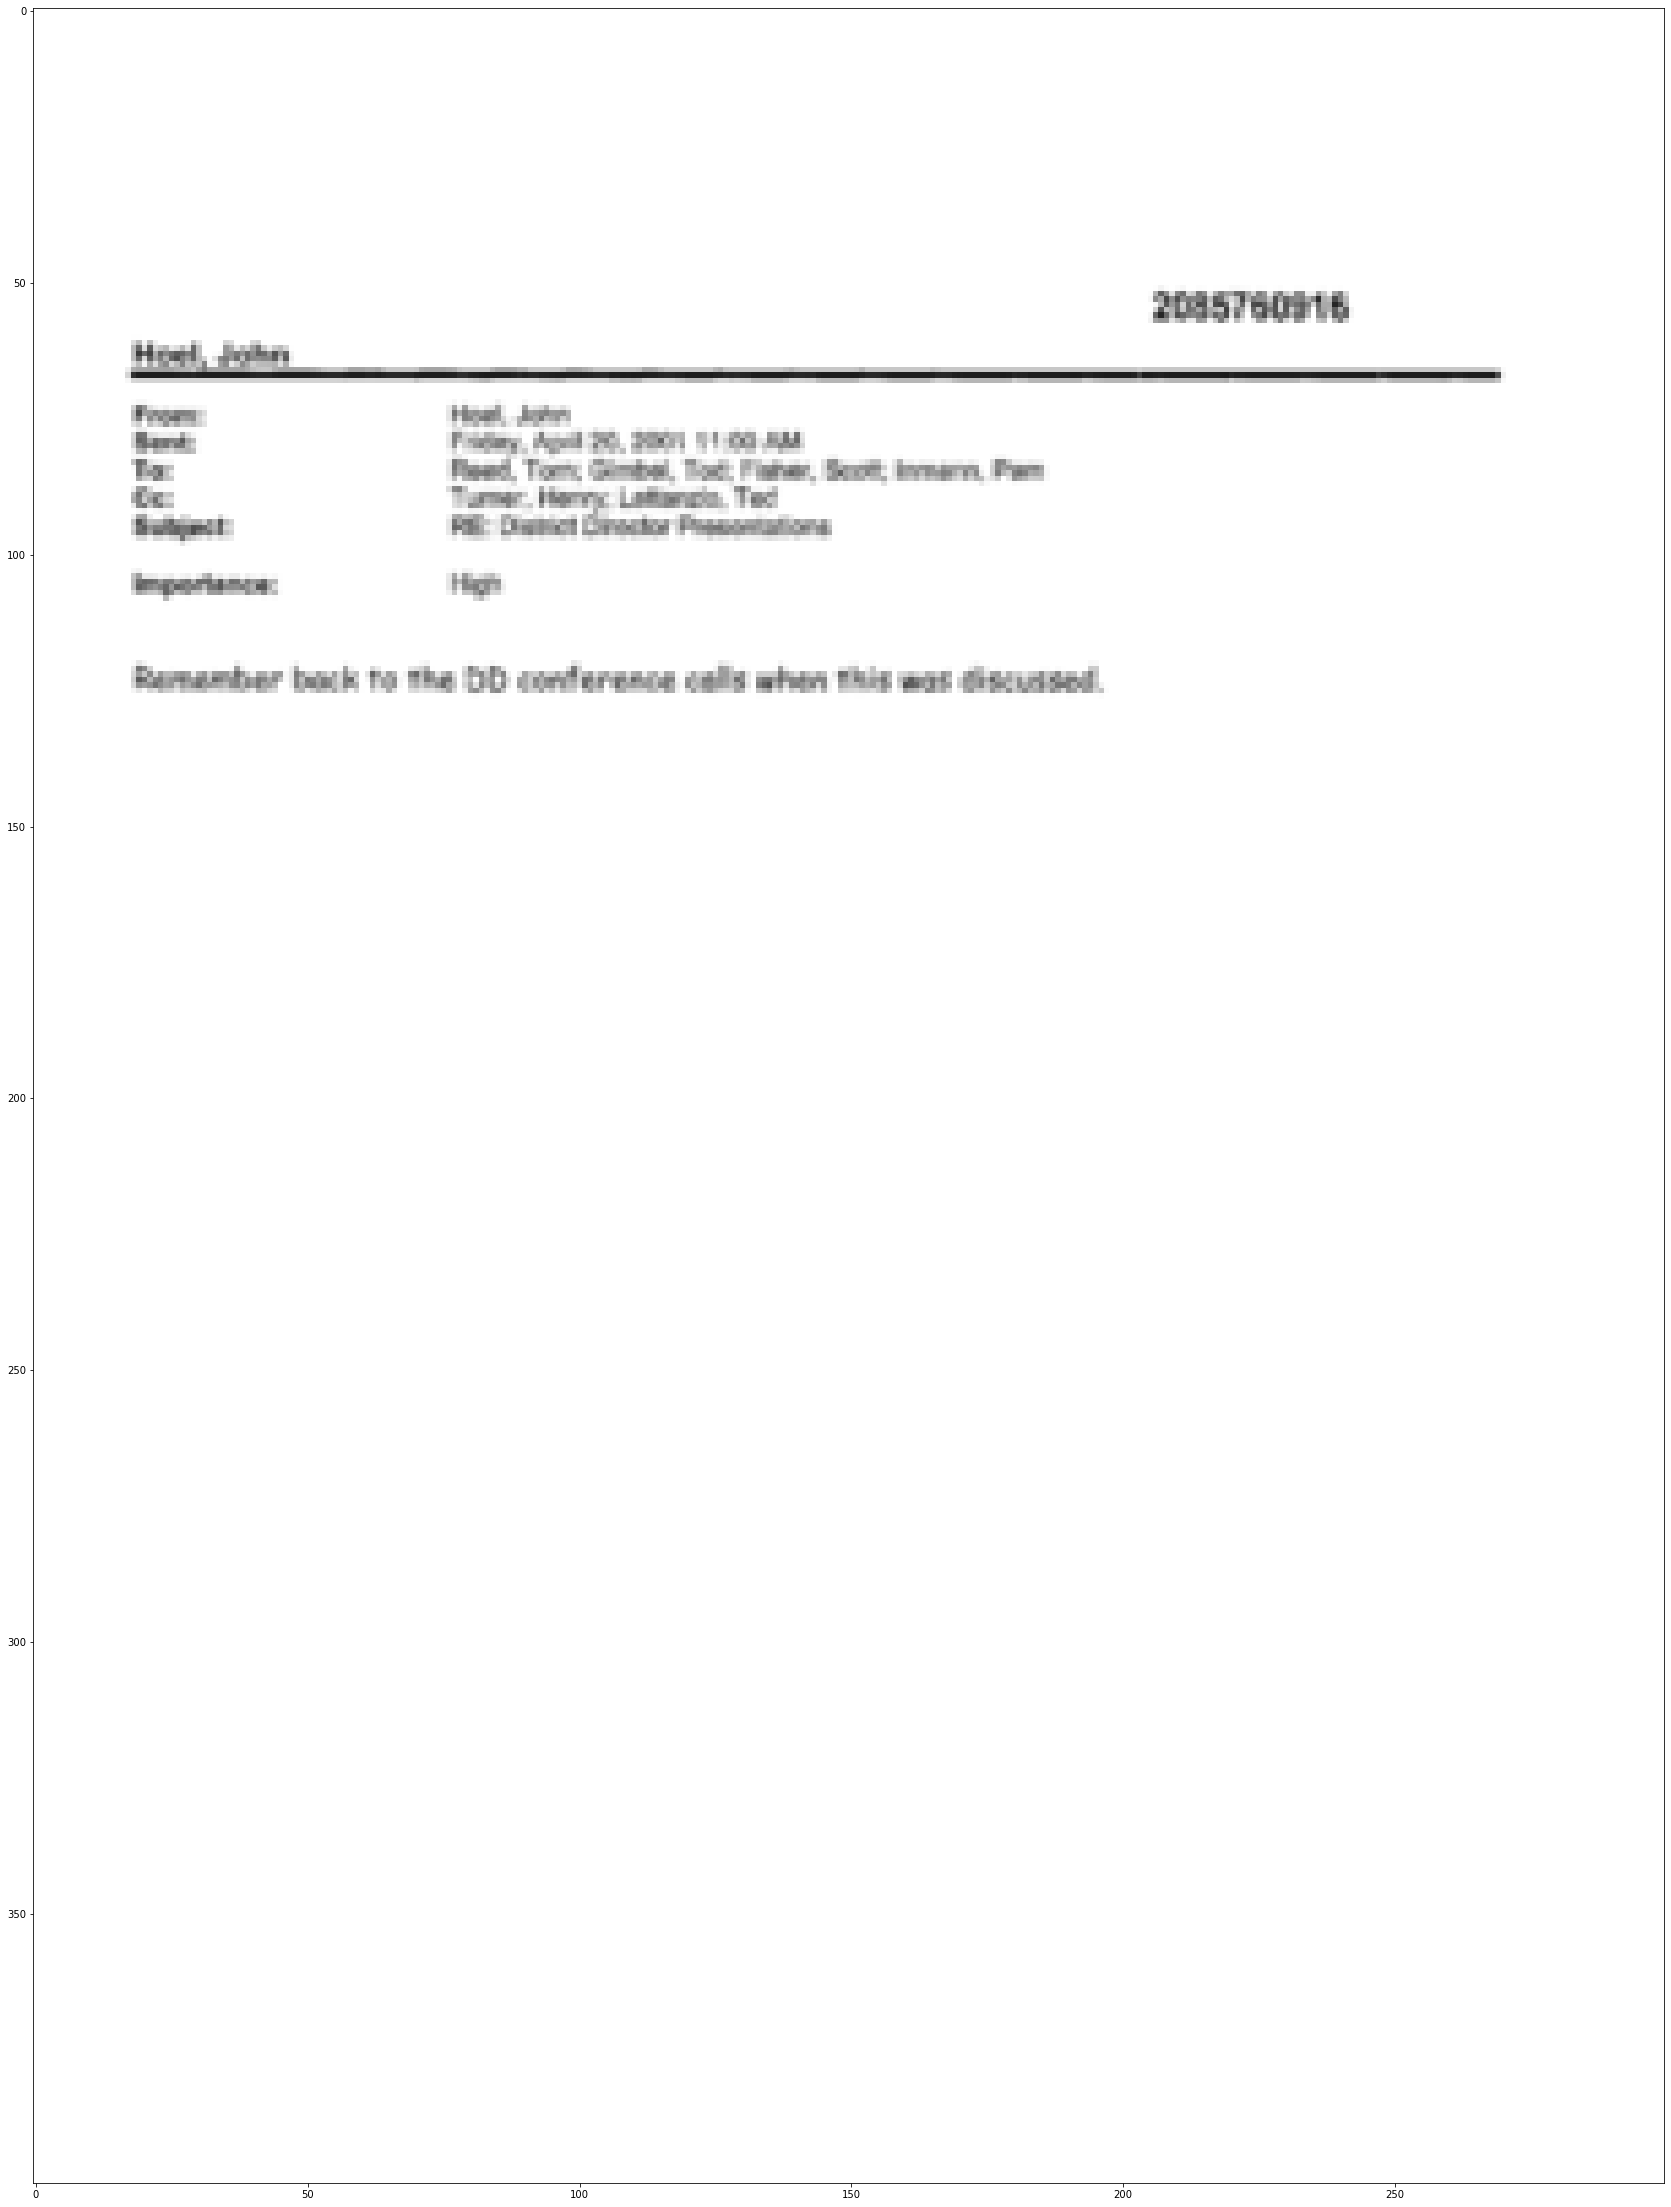

Labels: 2085760916  Hoel, John Friday, Apfl 20, 2001 11:00 AM Reed, Tom; Gimbel, Tod; Fisher, Scott; Inman, Pam ‘Turmer, Henry; Latianzio, Ted RE: District Director Presentations  High Remember back to the DD conference calls when this was discussed,
Pred: 2085783918 Hoel, John. From: Hoel, John Sent: Friday, April 20, 2001 11:49 AM To: Desel, Paula; Lipowicz, Peter; Scott, Jannetta; Ryan, Thomas; Winegarden, Jessica; Desel, Paula ce: Desel, Paula; Lipowicz, Peter J. Subject: RE: Tobacco Chemists Presentations Importance: High Remember! basic is the TI's conference calls when this was discussed.



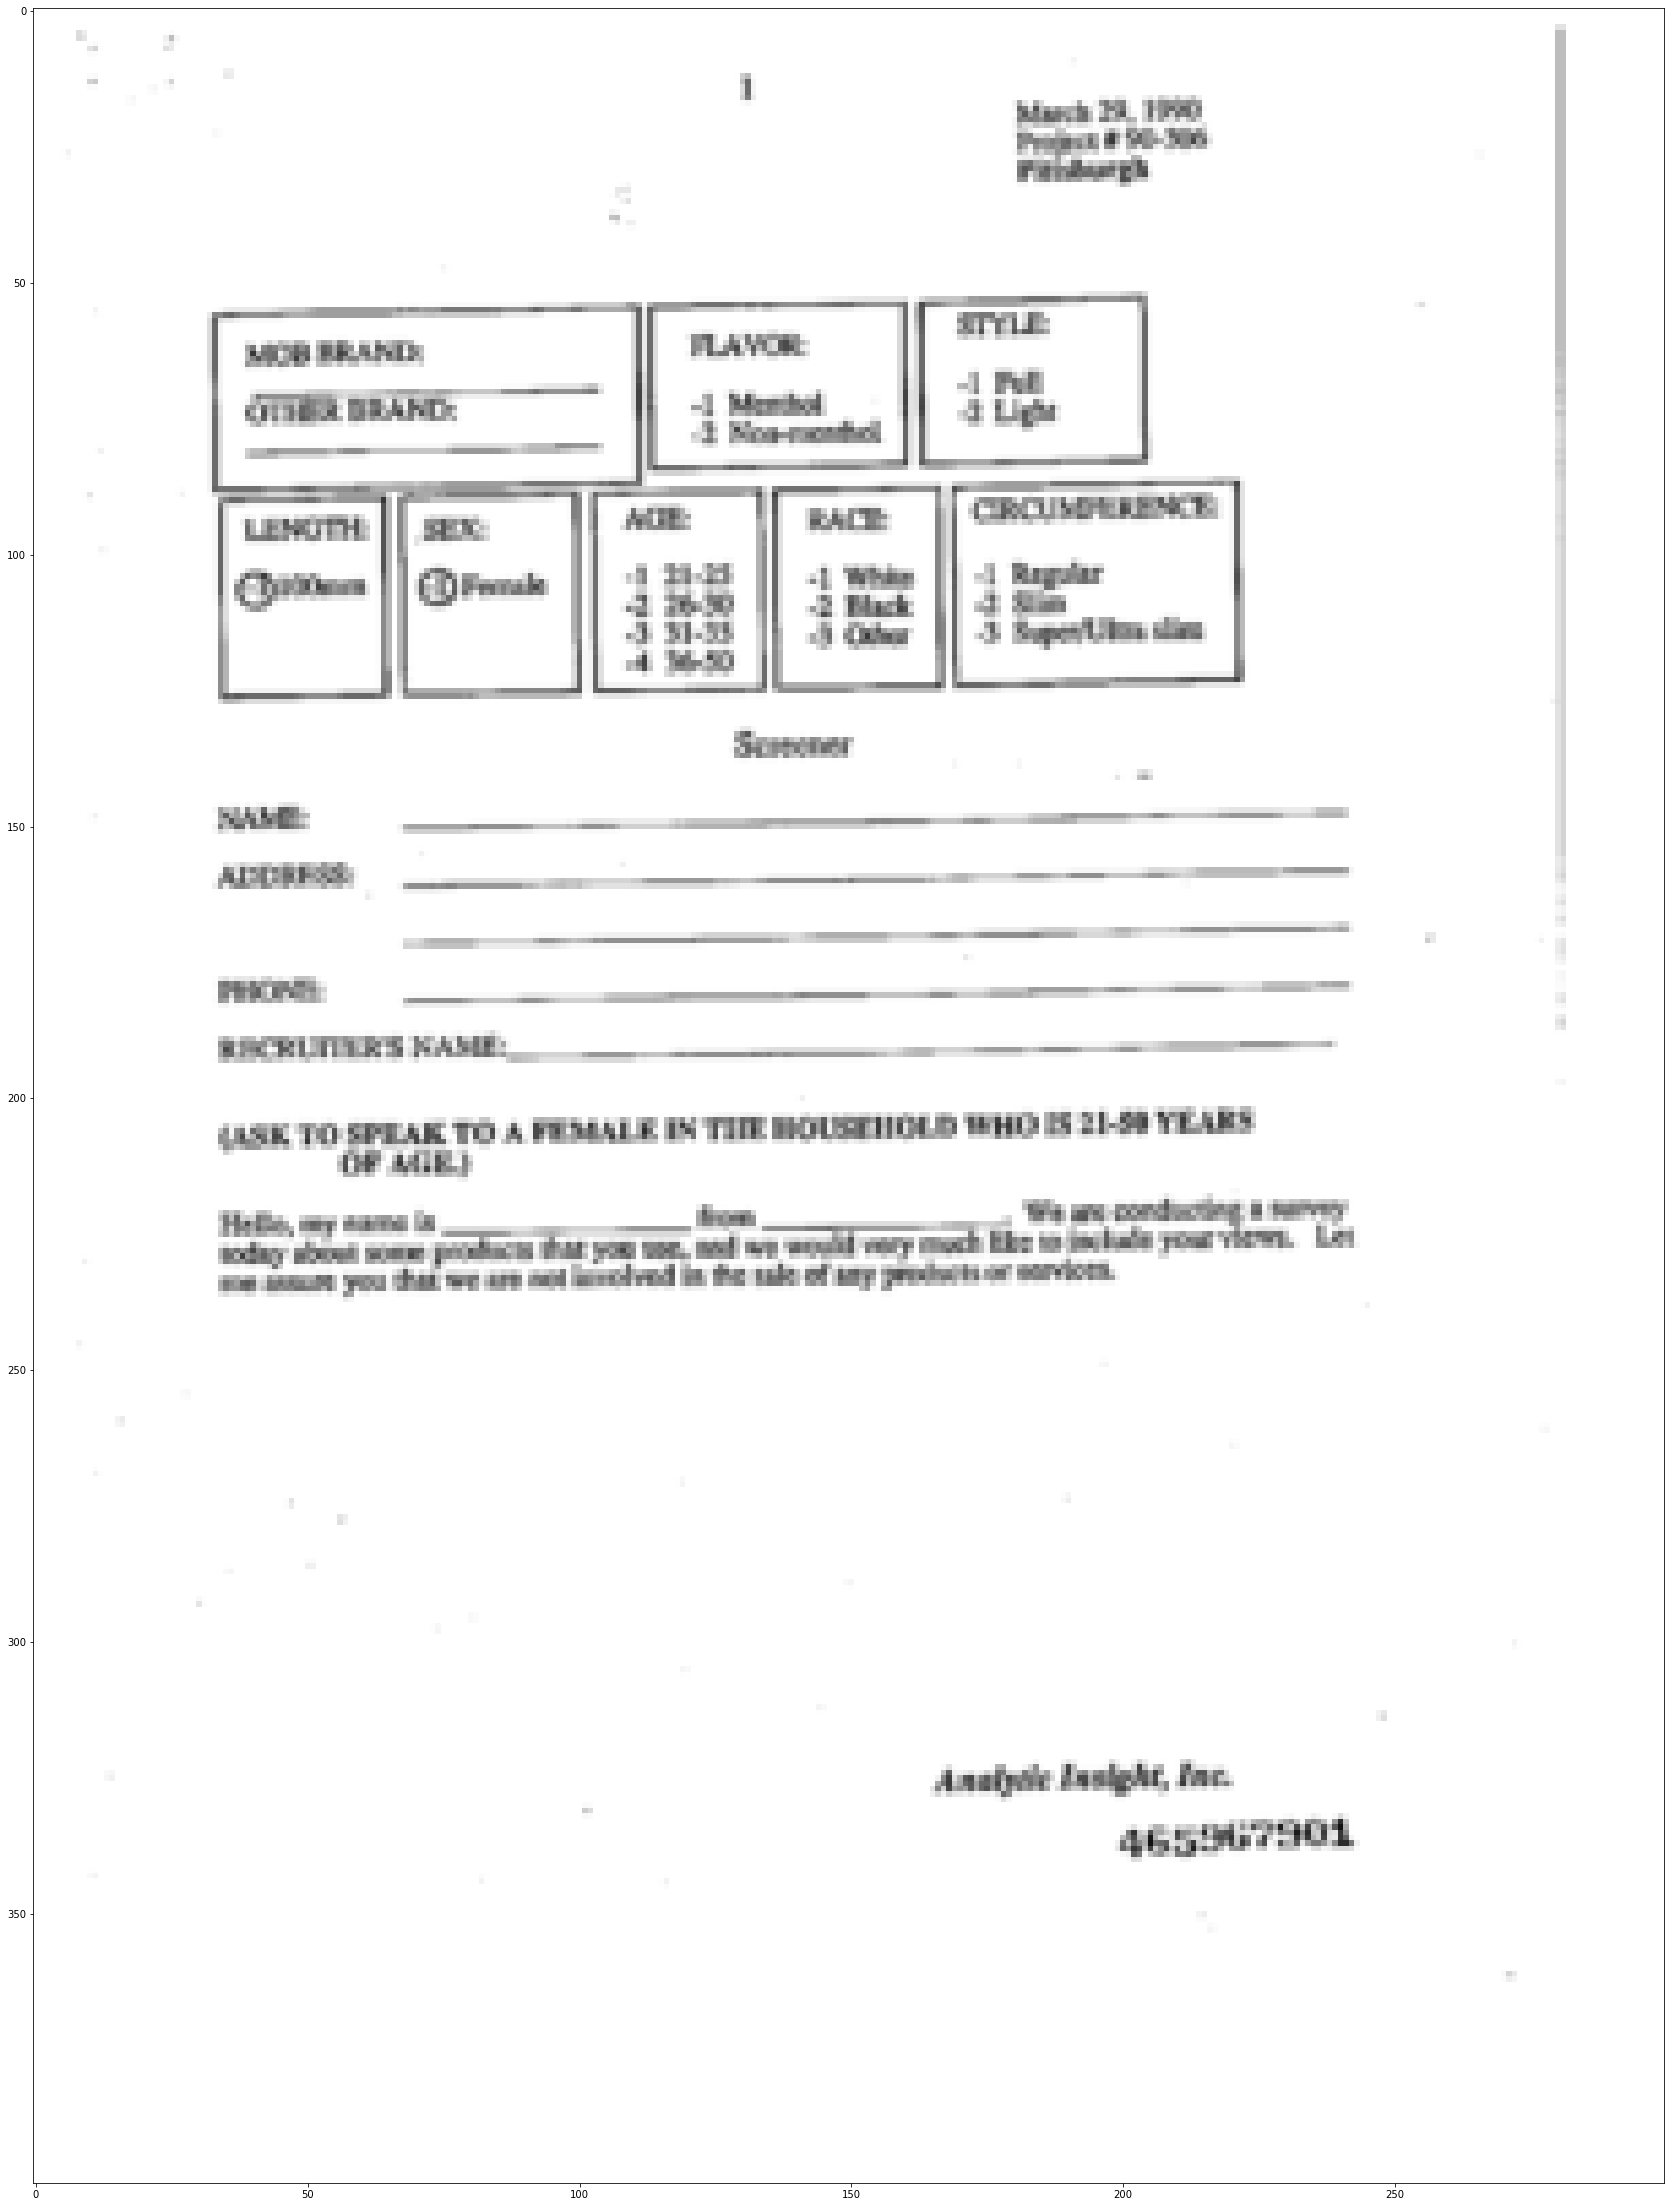

Labels: March 29, 1990 Project # 90-306 Pitisburgh          MOB BRAND: FLAVOR: OTHER BRAND: -1 Menthol °2 Non-menthol LENGTH: | [ sex: ‘AGE: RACE: || CIRCUMFERENCE: 100mm |] Gremate }] -1 21-25 |] -1 whe |] -1 Regular o Fema 2 2630 || “2 Black |] 2 sim °3:31-35 |) “3 Other |] -3 Super/UIna slim <4 36-50        ADDRESS:  PHONE:   RECRUITER'S NAME:, ee  (ASK TO SPEAK TO A FEMALE IN THE HOUSEHOLD WHO IS 21-50 YEARS: OF AGE) Hello, my name is from, . We are conducting a survey today about some products that you use, and we would very much like to include your views. Let me assure you that we are not involved in the sale of any products or services,    Analytic Insight, Inc. 465967901
Pred: March 20, 1990 Project # 89-200 Pittsburgh.......................................................................................................................................................................................................................................................... 



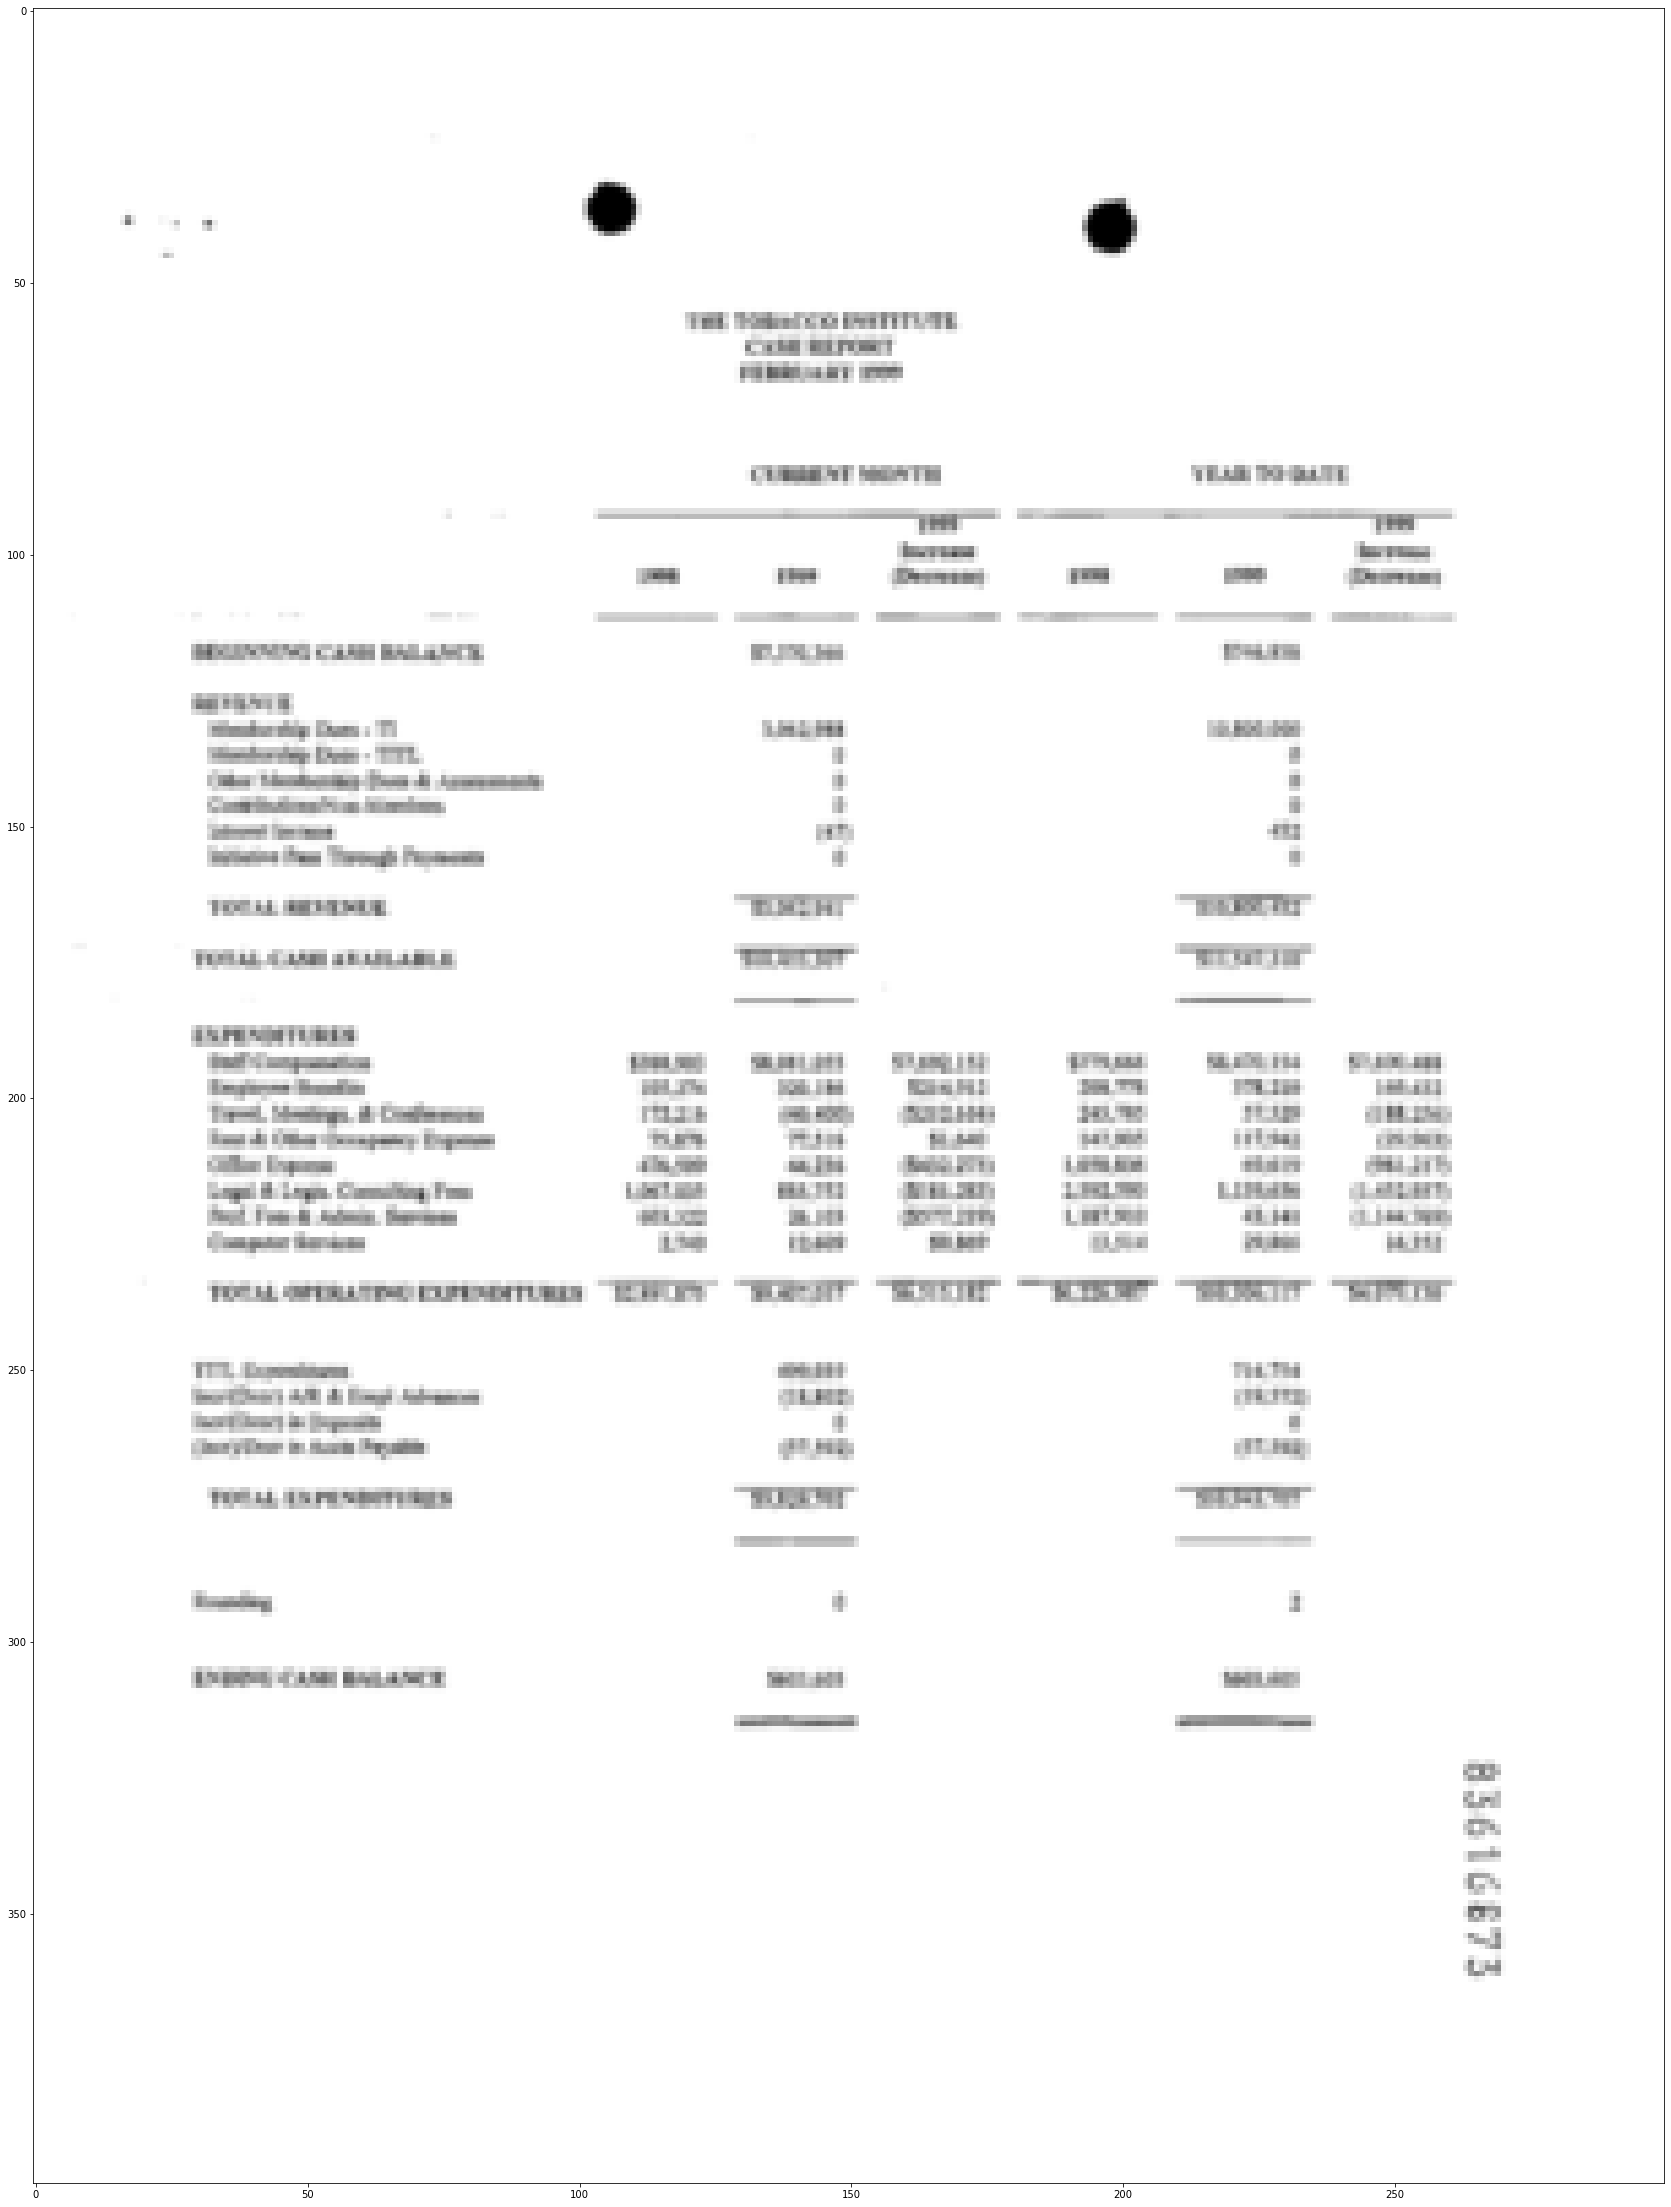

Labels: ‘THE TOBACCO INSTITUTE, CASH REPORT FEBRUARY 1999 (CURRENT MONTH ‘YEAR TO DATE a Increase Increase 1988, 1999 Decrease) 1988 1999 (beerease) BEGINNING CASH BALANCE, 57370365 $786,858 REVENUE Membership Dues - TL 3.062.988 10,200,000 Membership Dues TT. ° ° ter Membership Dus de Assesments ° ° (Conittons Non-Members ° ° Inteert income a 382 Inne Pas Through Peyments ° ° ‘TOTAL REVENUE, = sr ‘TOTAL CASH AVAILABLE 0 oe EXPENDITURES ‘Staff Coagenstion SHBRSOS — SKOBLOSS — STgRIS2——STTBESS—SRATONSA 7.800.488 Employee Betis Wasa 32086 14912 204.78 37210 169.432 ‘Travel Mesings & Conferences mais (4oao0) — ($212816) 5,785 57339 (188256) eat & Other Occupancy Expense 78% © 77518 S640 1e7905 usa 5363) Oice Expense 41659428 (SRT) 1.050.886 6619 mat) Lega 8 Legis, Coming Foes ostass —a8s.752—SIBL2) 2892593 1.139.656 (1.452957) Prot Fees & Admin. Services 33226103 (SSTZ2I9) 187.910 (0.144765) 2H0 13609869 Bl 16382  TOTAL OPERATING EXPENDITURES. ~SEBTNTS ‘TTL Bxpenties InerDec) AR & Ermpl A

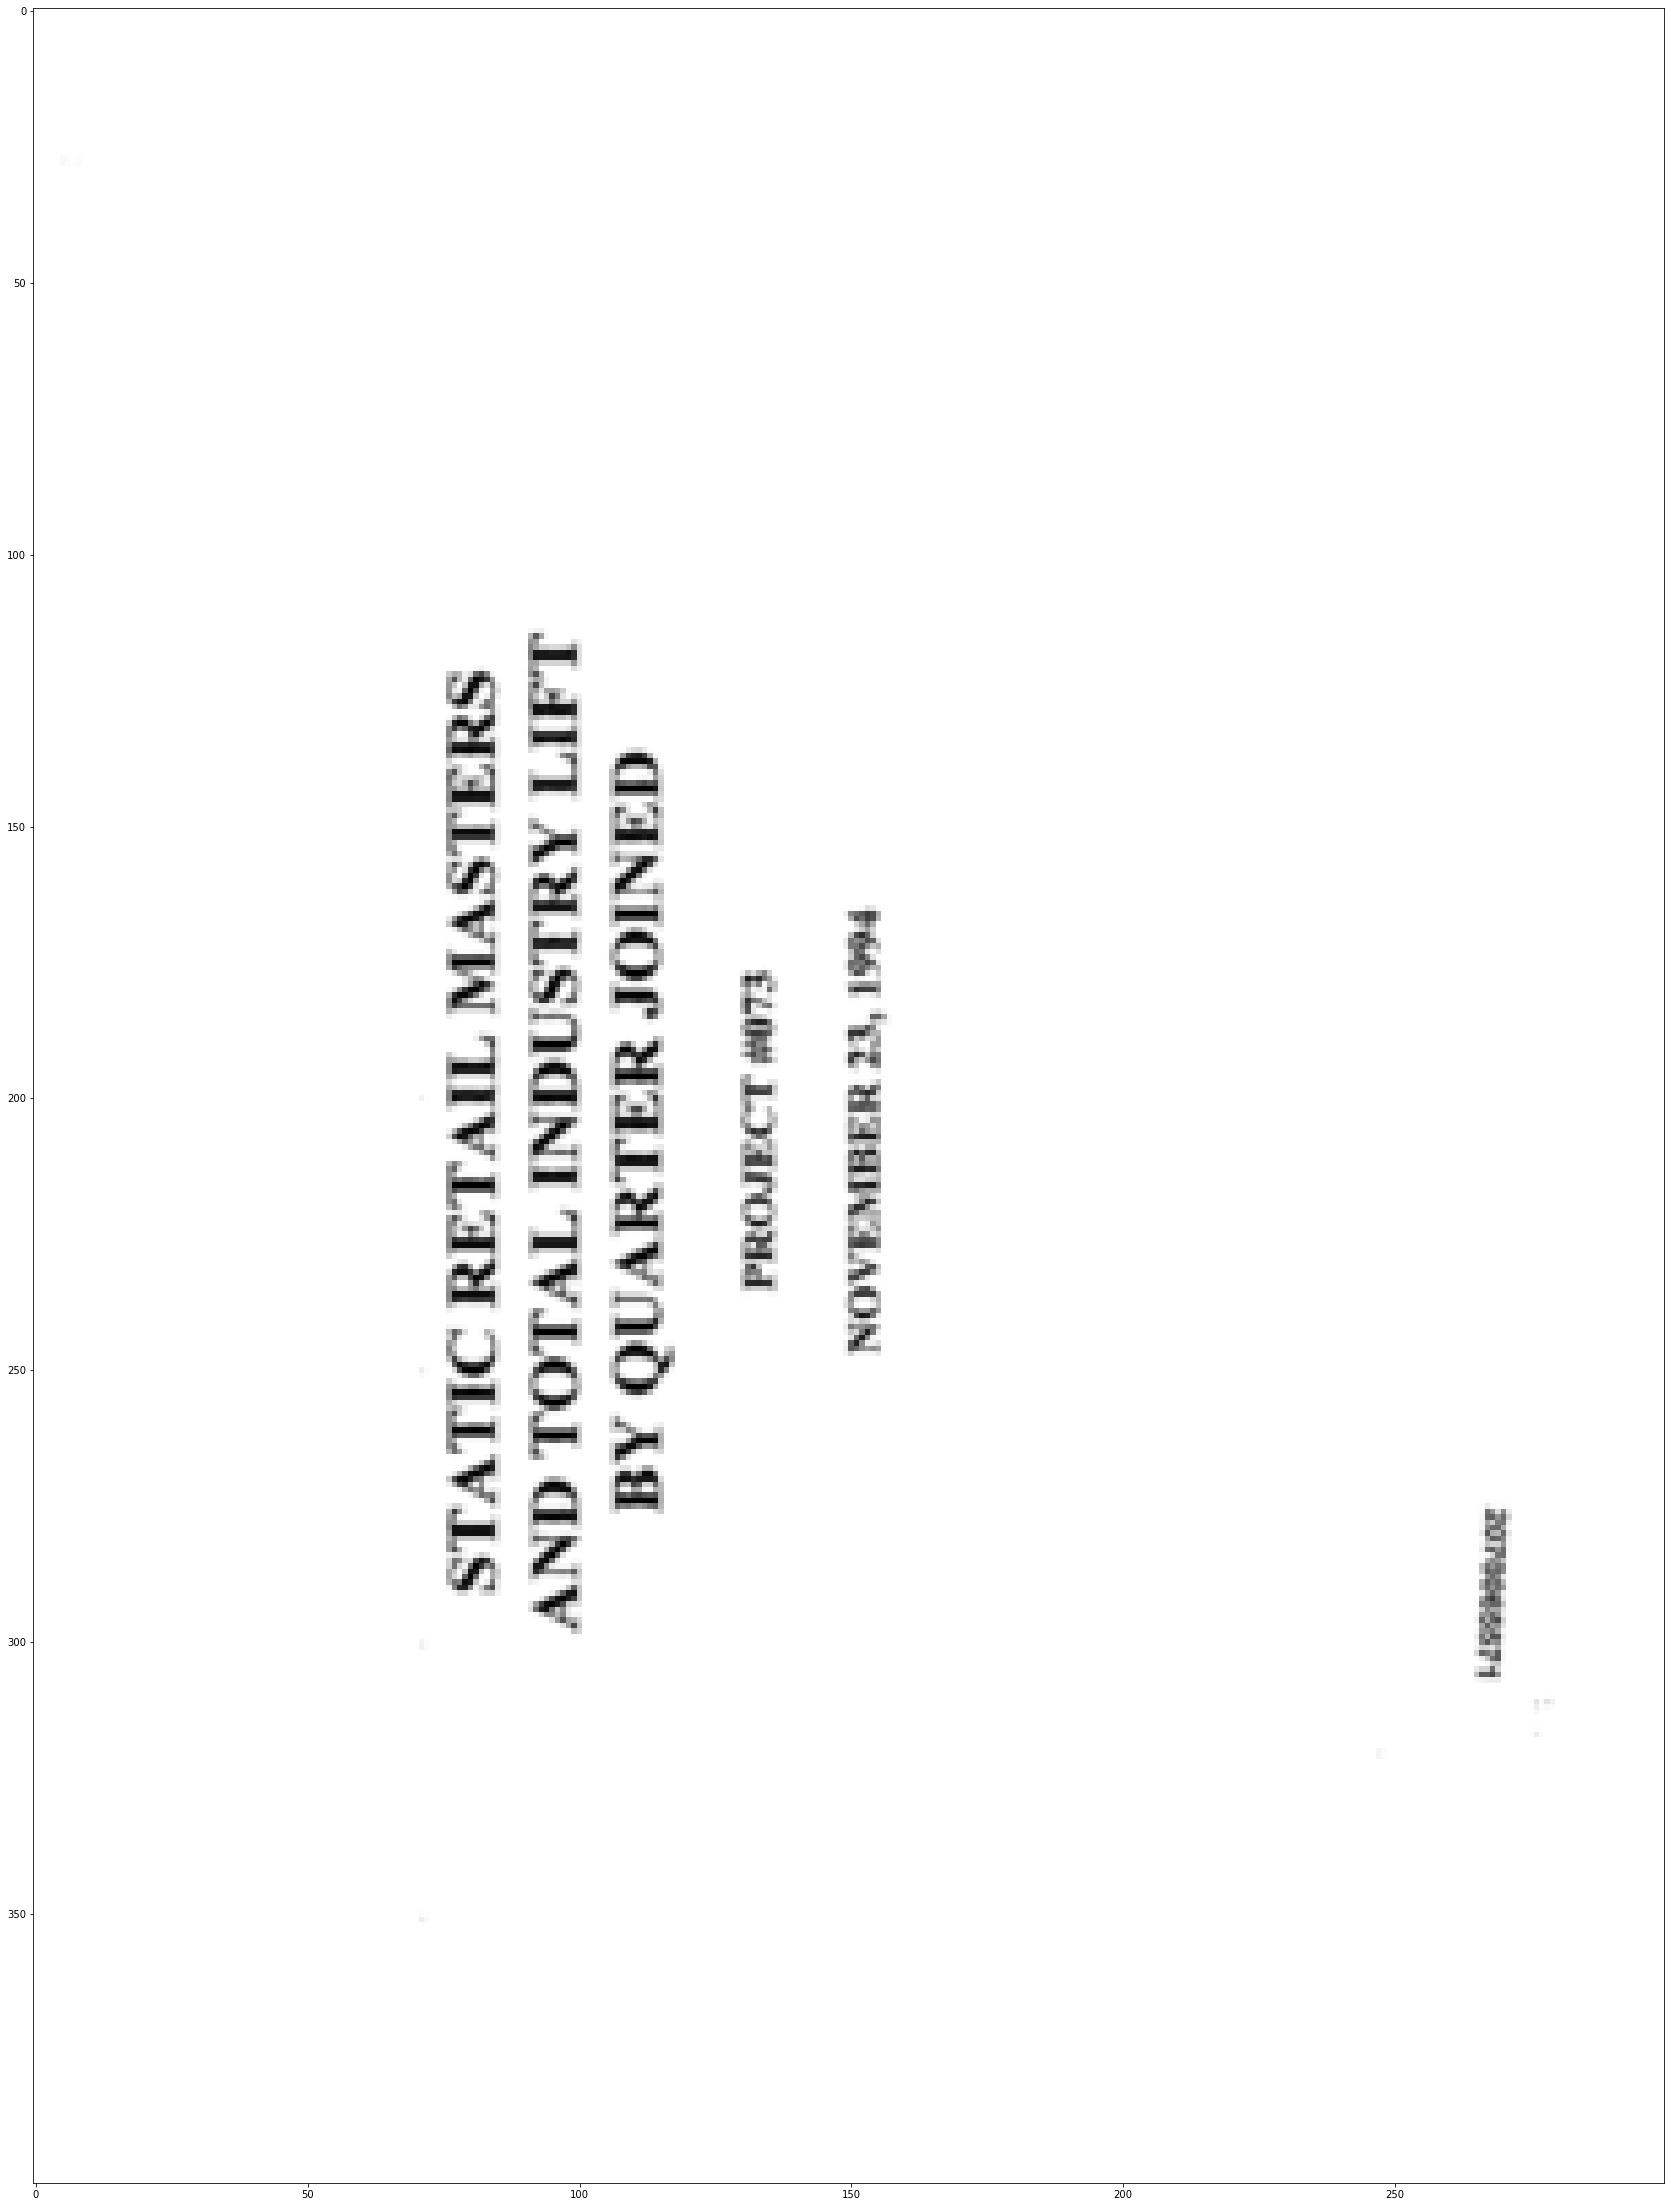

Labels: STATIC RETAIL MASTERS AND TOTAL INDUSTRY LIFT BY QUARTER JOINED PROJECT #073 NOVEMBER 23, 1994 Less900z0z
Pred: MARLBORO MARKETING RESEARCH MARKETING RESEARCH Presented by: Philip Morris USA, Inc. vLoseoz90z



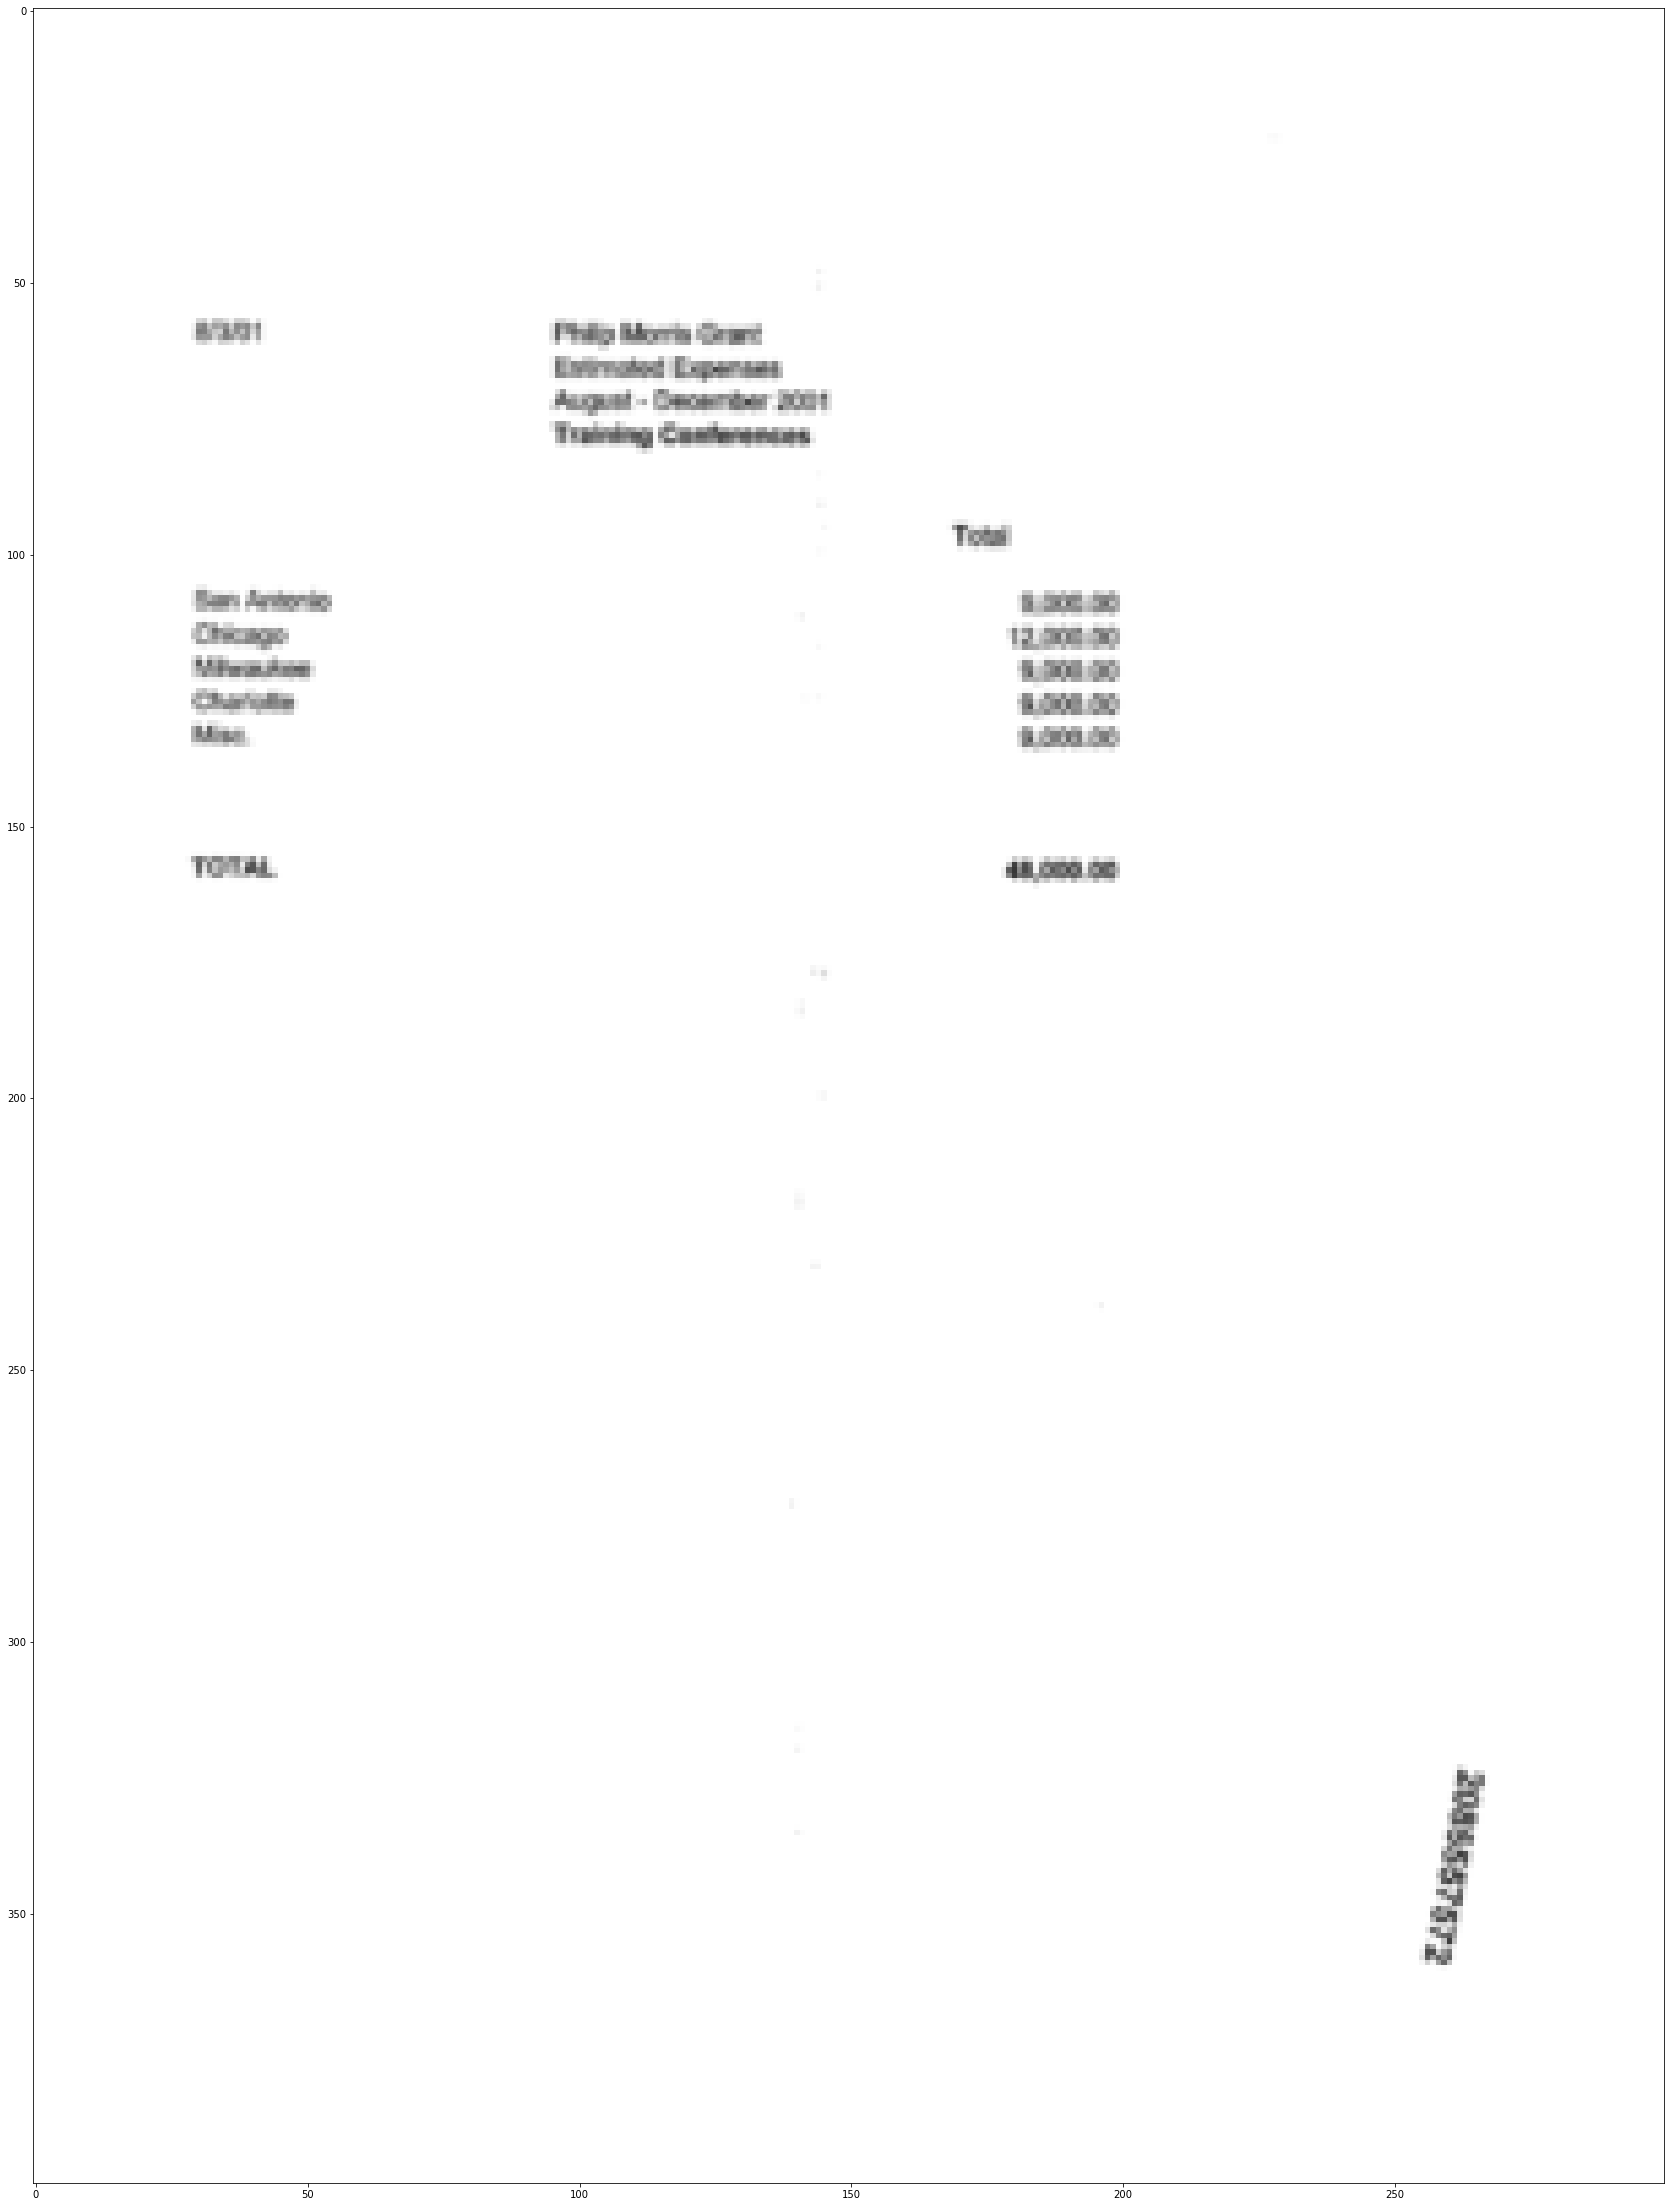

Labels: 8/3/01 ‘San Antonio Chicago Miwaukee Charlotte Mise. TOTAL Philip Morris Grant Estimated Expenses ‘August - December 2001 Training Conferences Total 9,000.00 12,000.00 9,000.00 9,000.00 9,000.00 48,000.00 22829¢¢¢92
Pred: 8/1/01 Philip Morris Grant Estimated Expenses August - December 2001 Training Conferences ‘Total San Antonio 5,085.00 Chicago 1,200.00 Milwaukee 1,200.00 Charlotte 5,085.00 Misc. 5,085.00 TOTAL 4,085.00 eL6Loeseoz



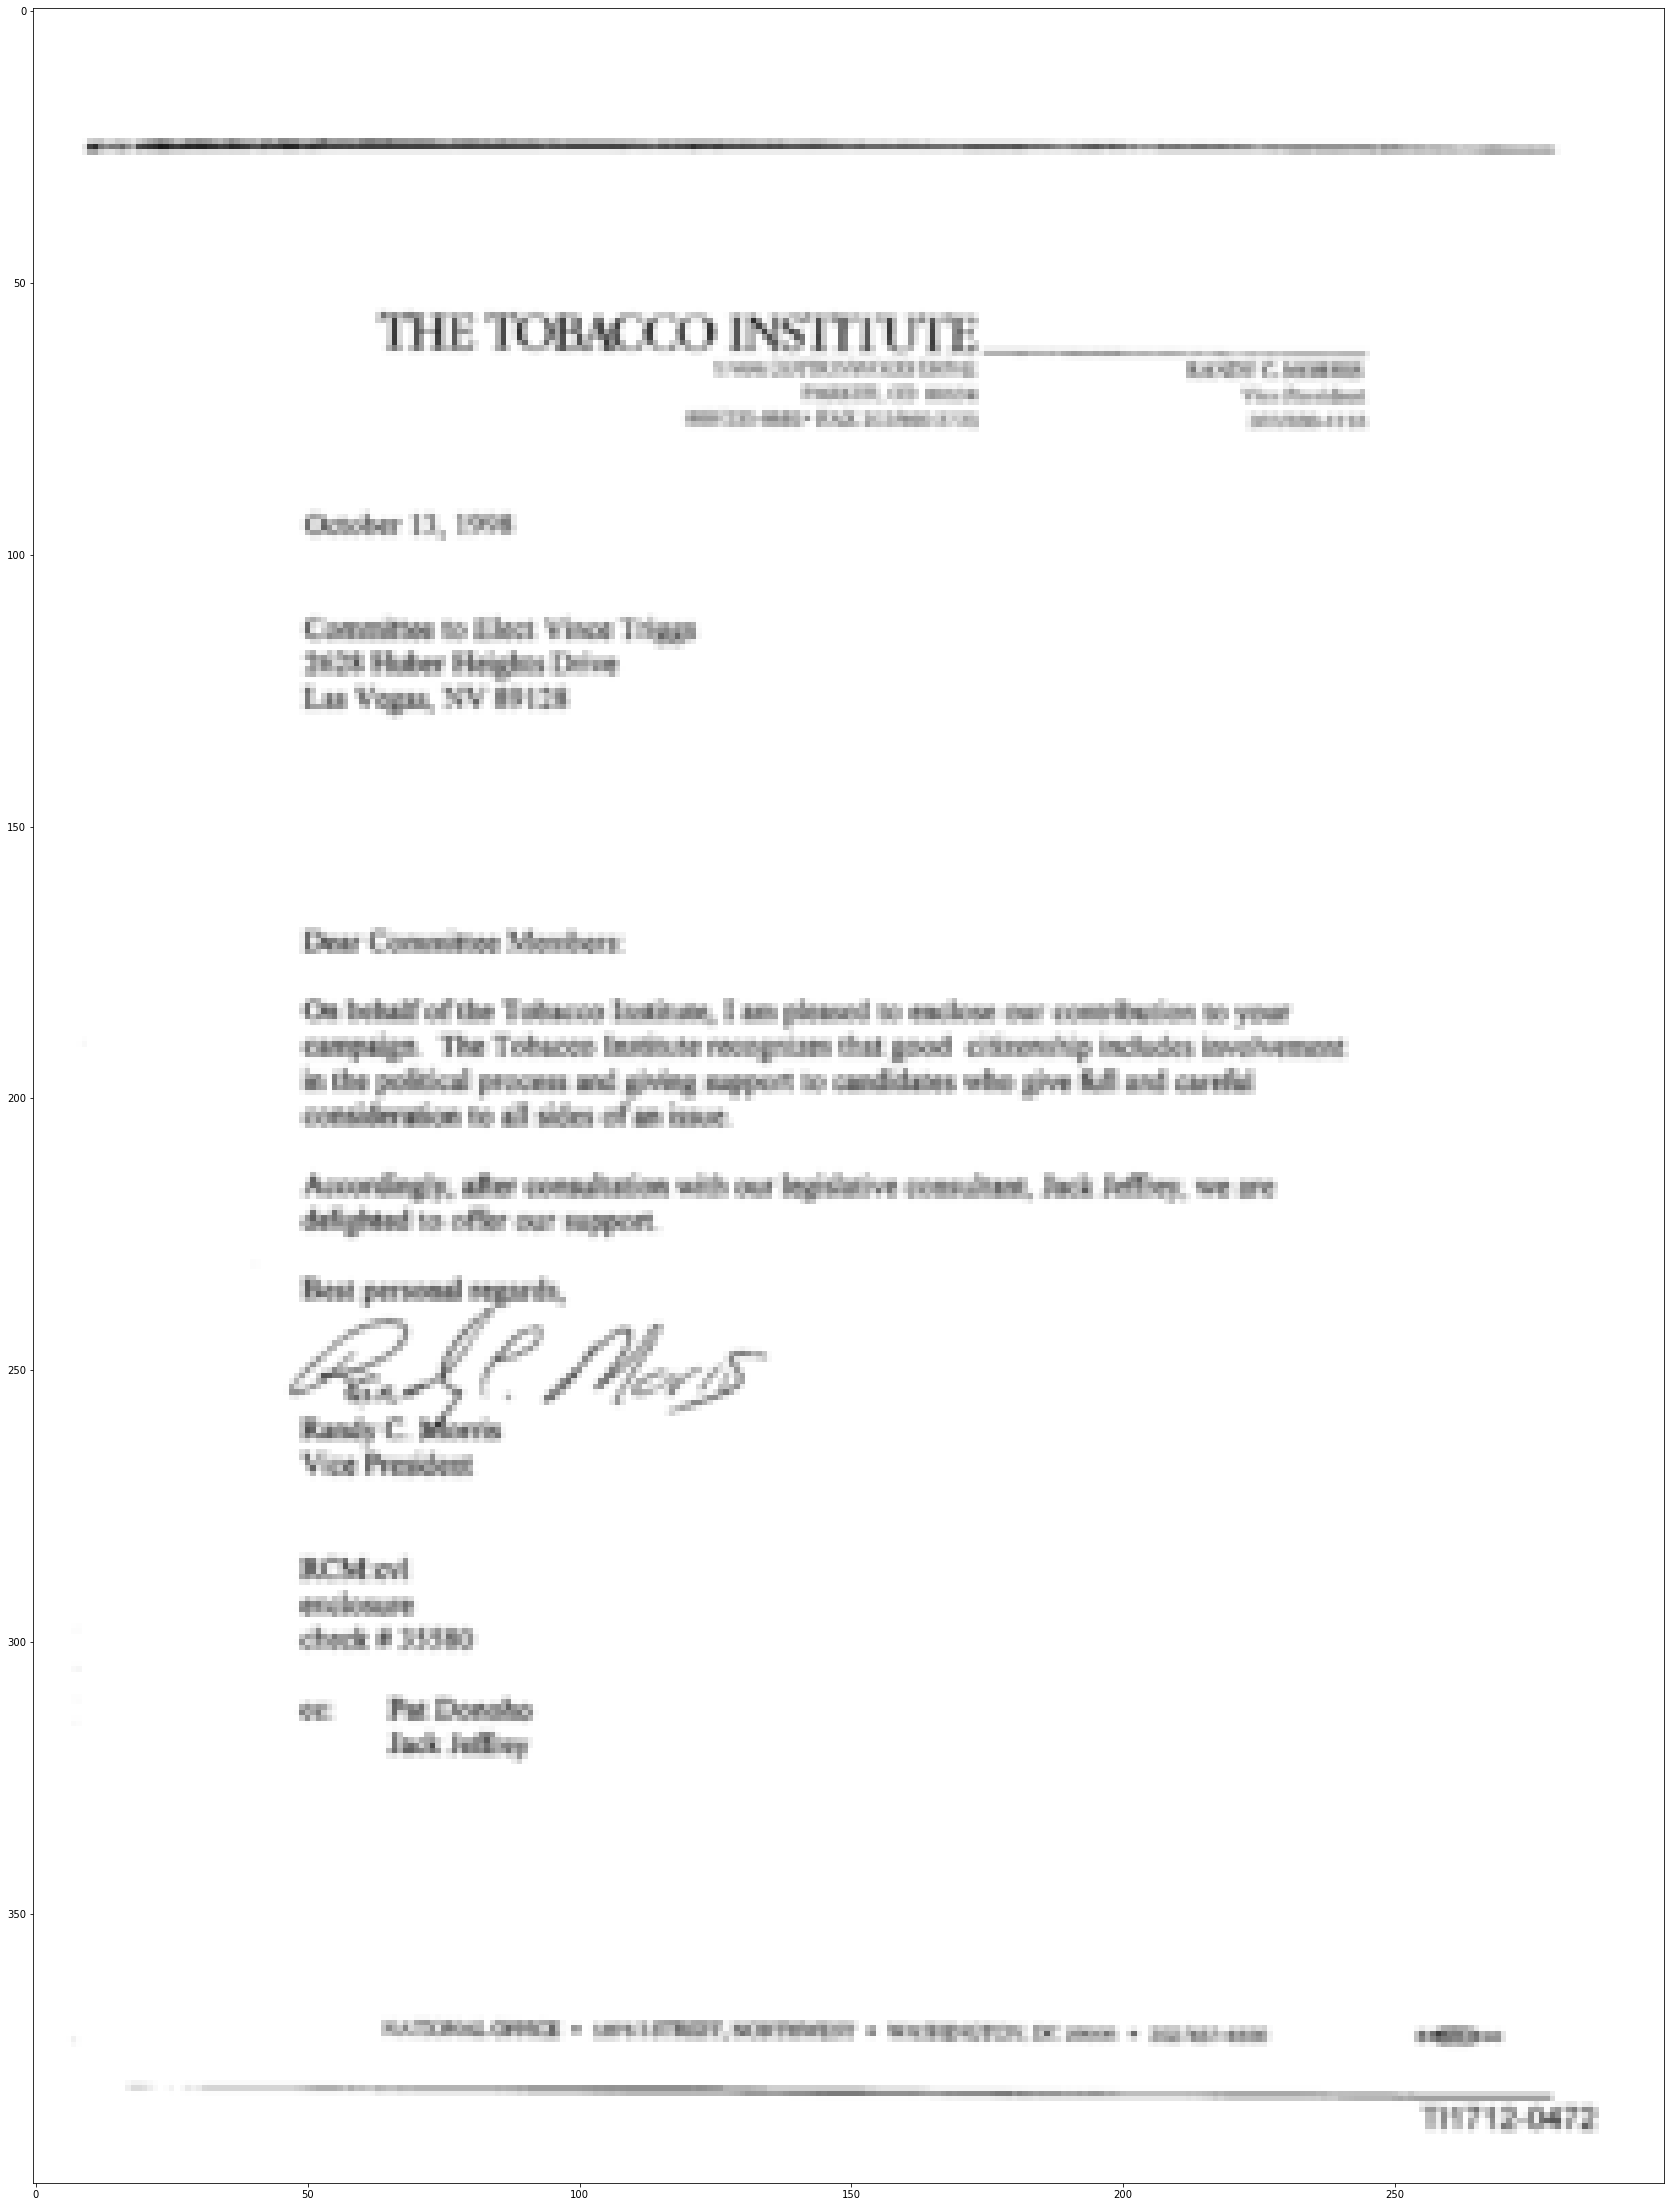

Labels:  THE TOBACCO INSTTIUTE__ 17494 COTTONWOOD ERIVE  ‘ier President 00/235-881+ Fax acaio90.7", snvseo-t138 October 13, 1998 Committee to Elect Vince Triggs 2628 Huber Heights Drive Las Vegas, NV 89128 Dear Committee Members: On behalf of the Tobacco Institute, I am pleased to enclose our contribution to your ‘campaign. The Tobacco Institute recognizes that good citizenship includes involvement in the political process and giving support to candidates who give full and careful consideration to all sides of an issue Accordingly, after consultation with our legislative consultant, Jack Jeffrey, we are delighted to offer our support Best personal regards, fees Vice President RCMcevl enclosure check #35580 cc: Pat Donoho Jack Jefliey [NATIONALOFFICE + 16751STREET, NORTHWEST + WASHINGTON.DC 20000 + 202/457-1800 s<—>~  TH1712-0472
Pred: THE TOBACCO INSTITUTE —__________________________________________________________________________________________________________________________________

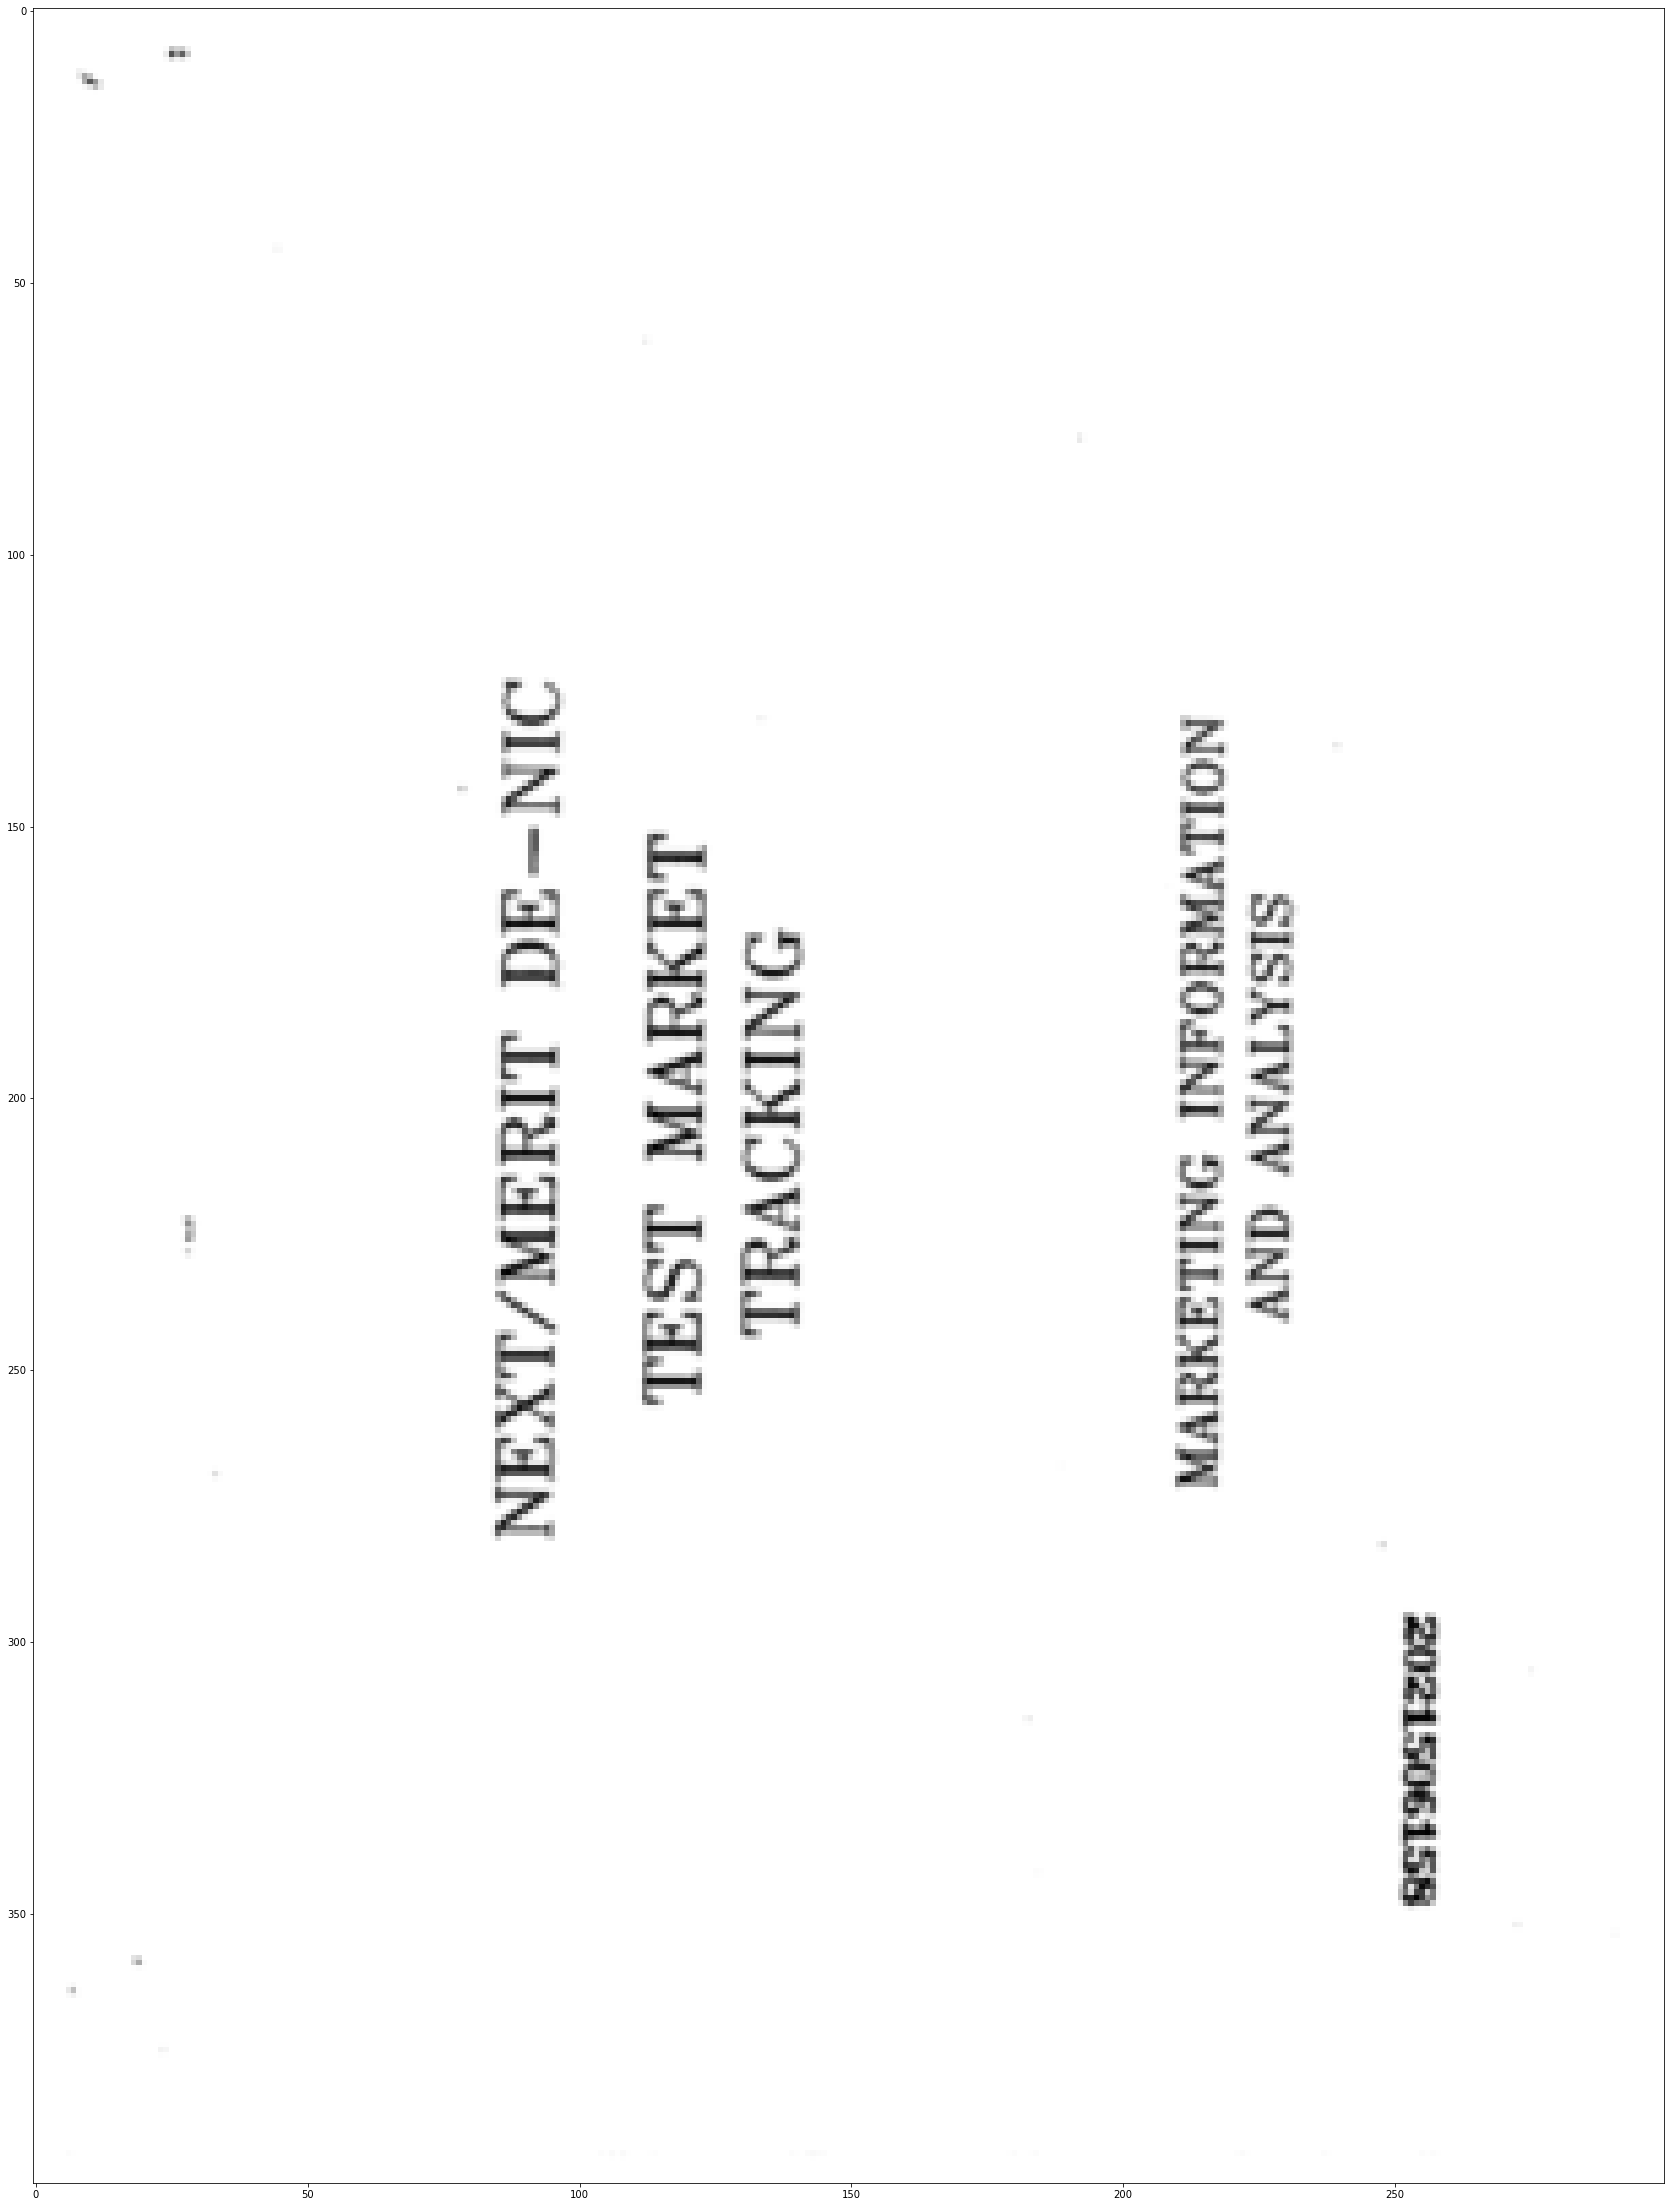

Labels: Sst90Sstz0z NEXT/MERIT DE-NIC TEST MARKET TRACKING MARKETING INFORMATION AND ANALYSIS
Pred: PHILIP MORRIS U.S.A. RESEARCH RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPMENT RESEARCH & DEVELOPM

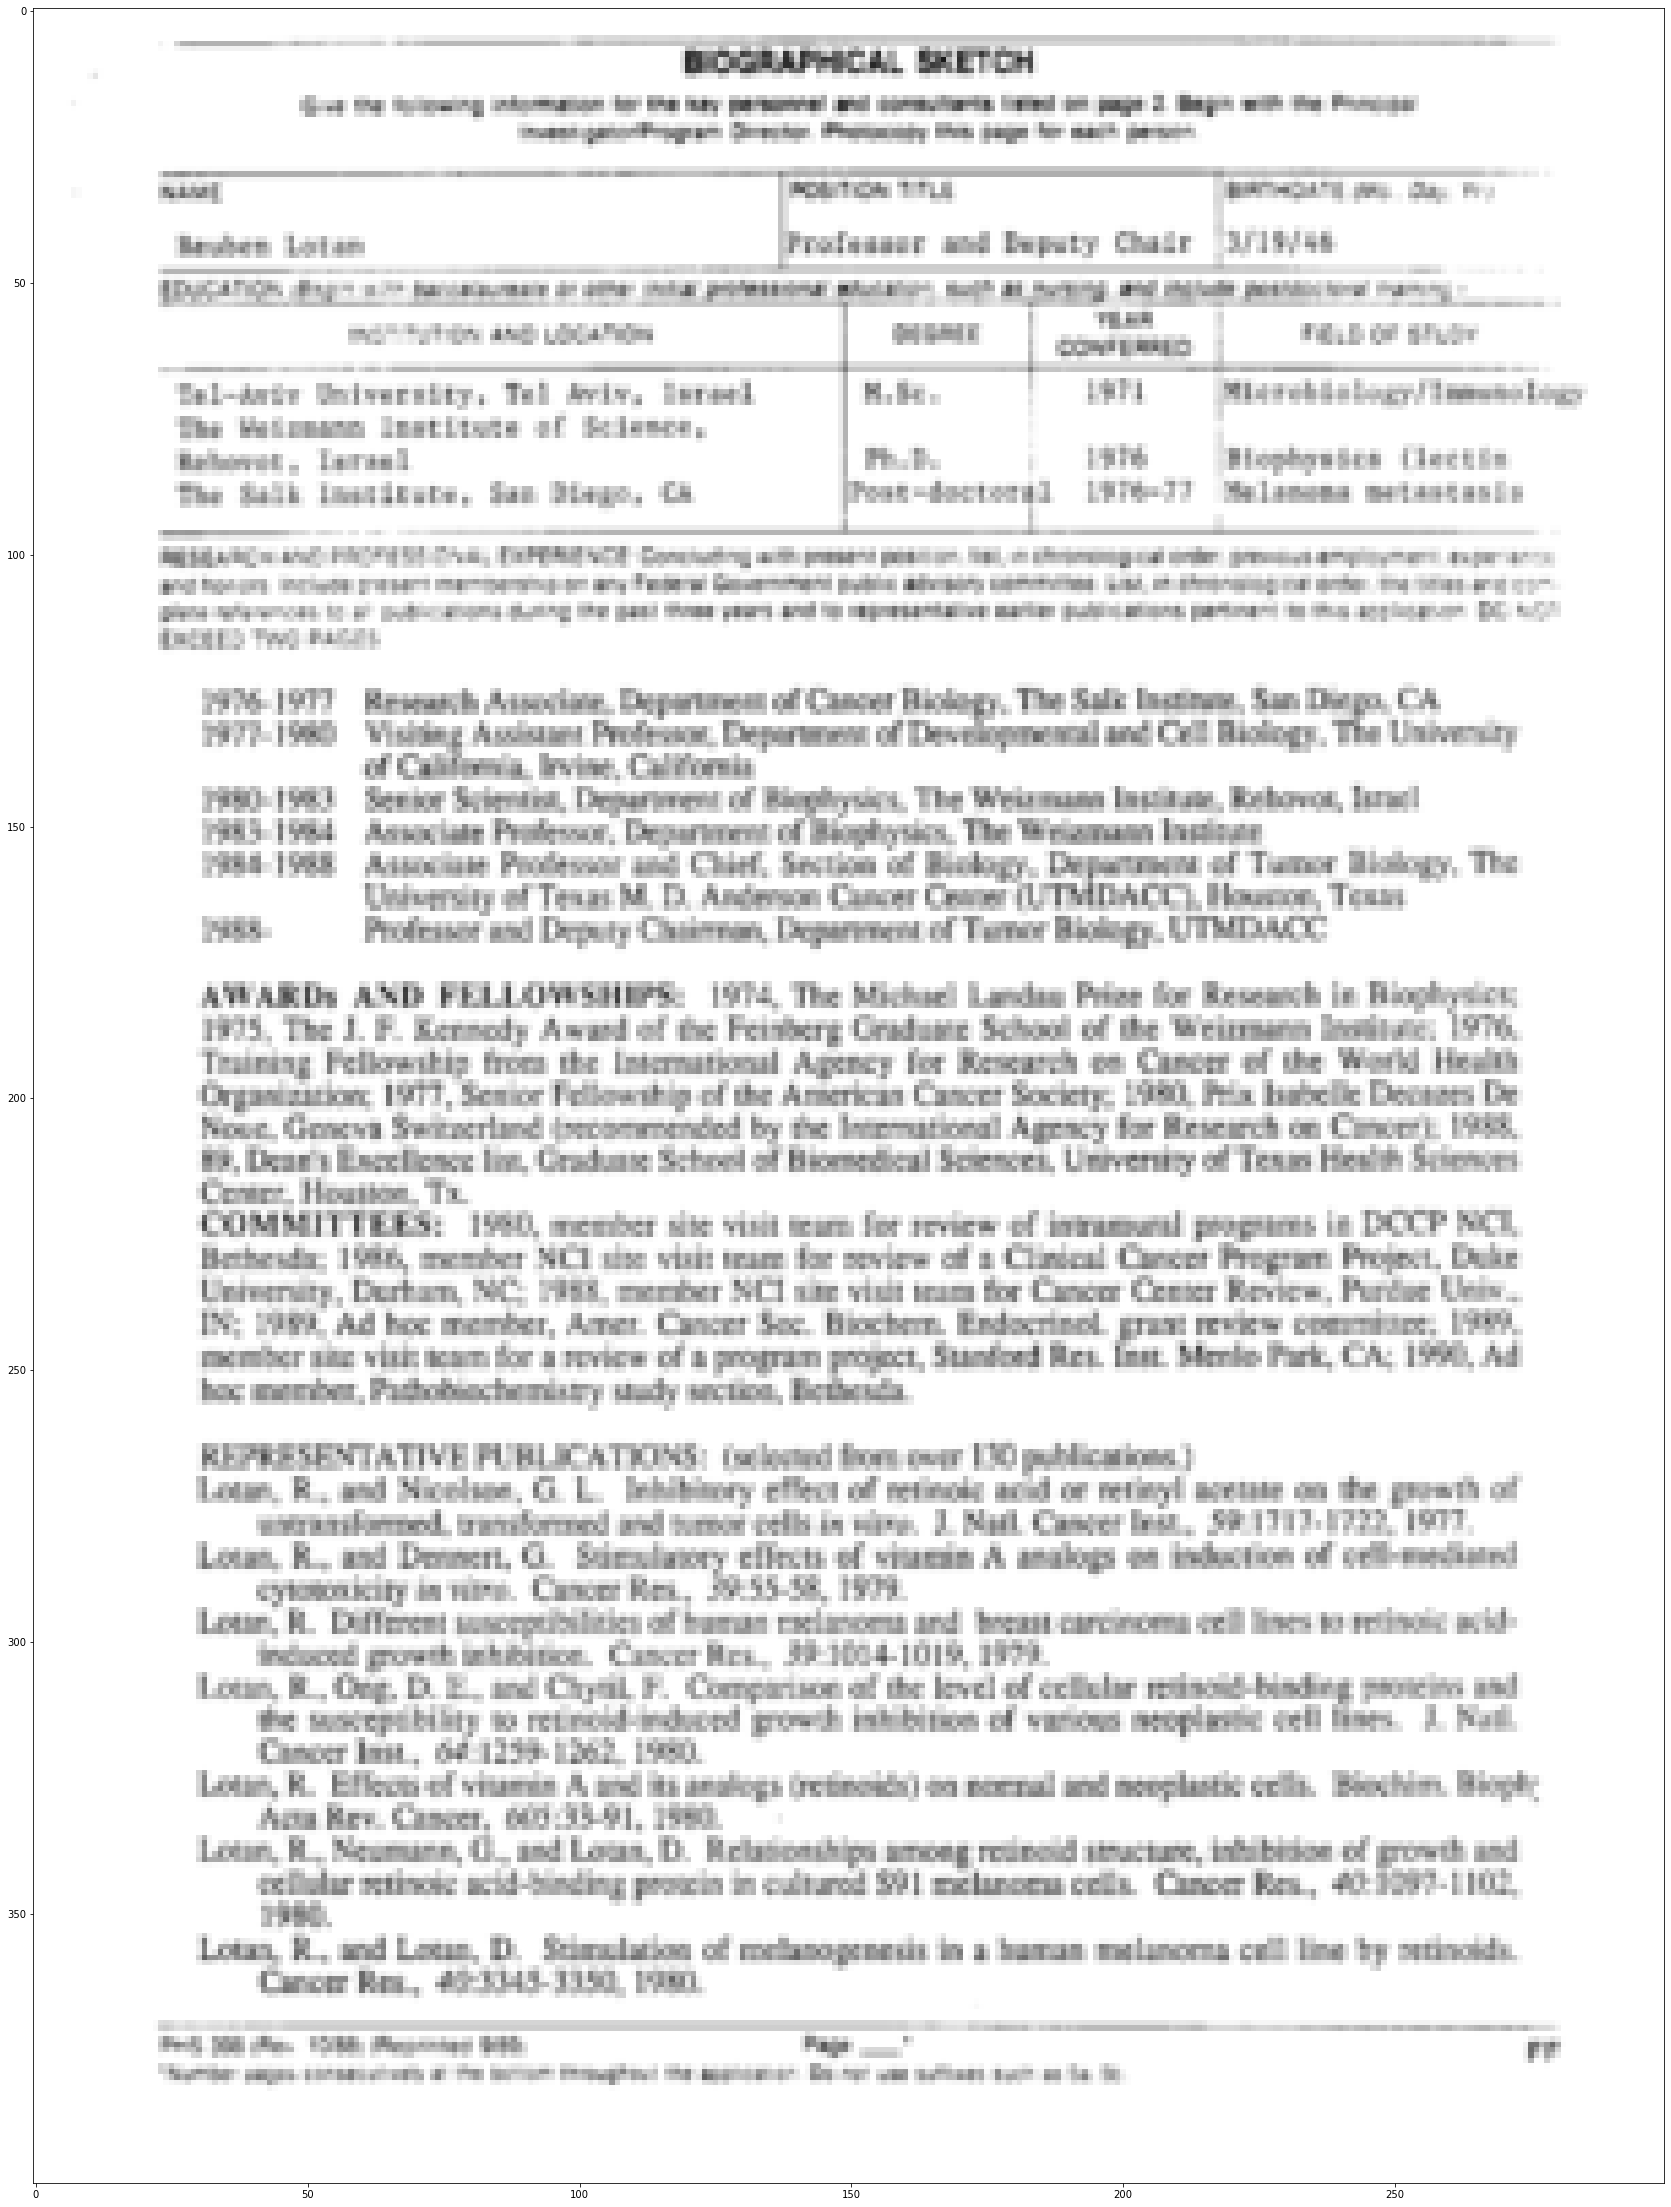

Labels: BIOGRAPHICAL SKETCH Give the folowing information for the Key personnel and consultants listed on page 2. Begin withthe Princips nvestigatorPropram Director. Pnotocopy this page for each person         Tan _ POSTION TLE TBIRTHOATE Wo. Day. Ye) Reuben Lotan Professor and Deputy Chair |3/19/46 ATO ig aw IN RO ae ah wg le pew {= UTION AND LOCATION 7 year suby "NSTTUTON AND LOCATION | 9e0R | contttnen | FHELDOF STUD Tel-Aviv University, Tel Aviv, Israel M.Sc. T1971 [iieroblology/Tamunology The Weiamann Institute of Science, ' Rehovot, Israel Ph.D. 1976 |Biophysics (lectin The Salk Institute, San Diego, CA Post-doctoral 1976-77 Melanoma metastasis   RESEASCH AND PROFESSIONAL EXPERIENCE Concluding with present position, ist i chronological order. previous employment. expe lanchonors Incluge presen! membership on any Federal Government publi advisory commttes. List sn ehvonalogica rcer, the titles arc c: plete relerences to a! pubucations during the past thee years and to representati

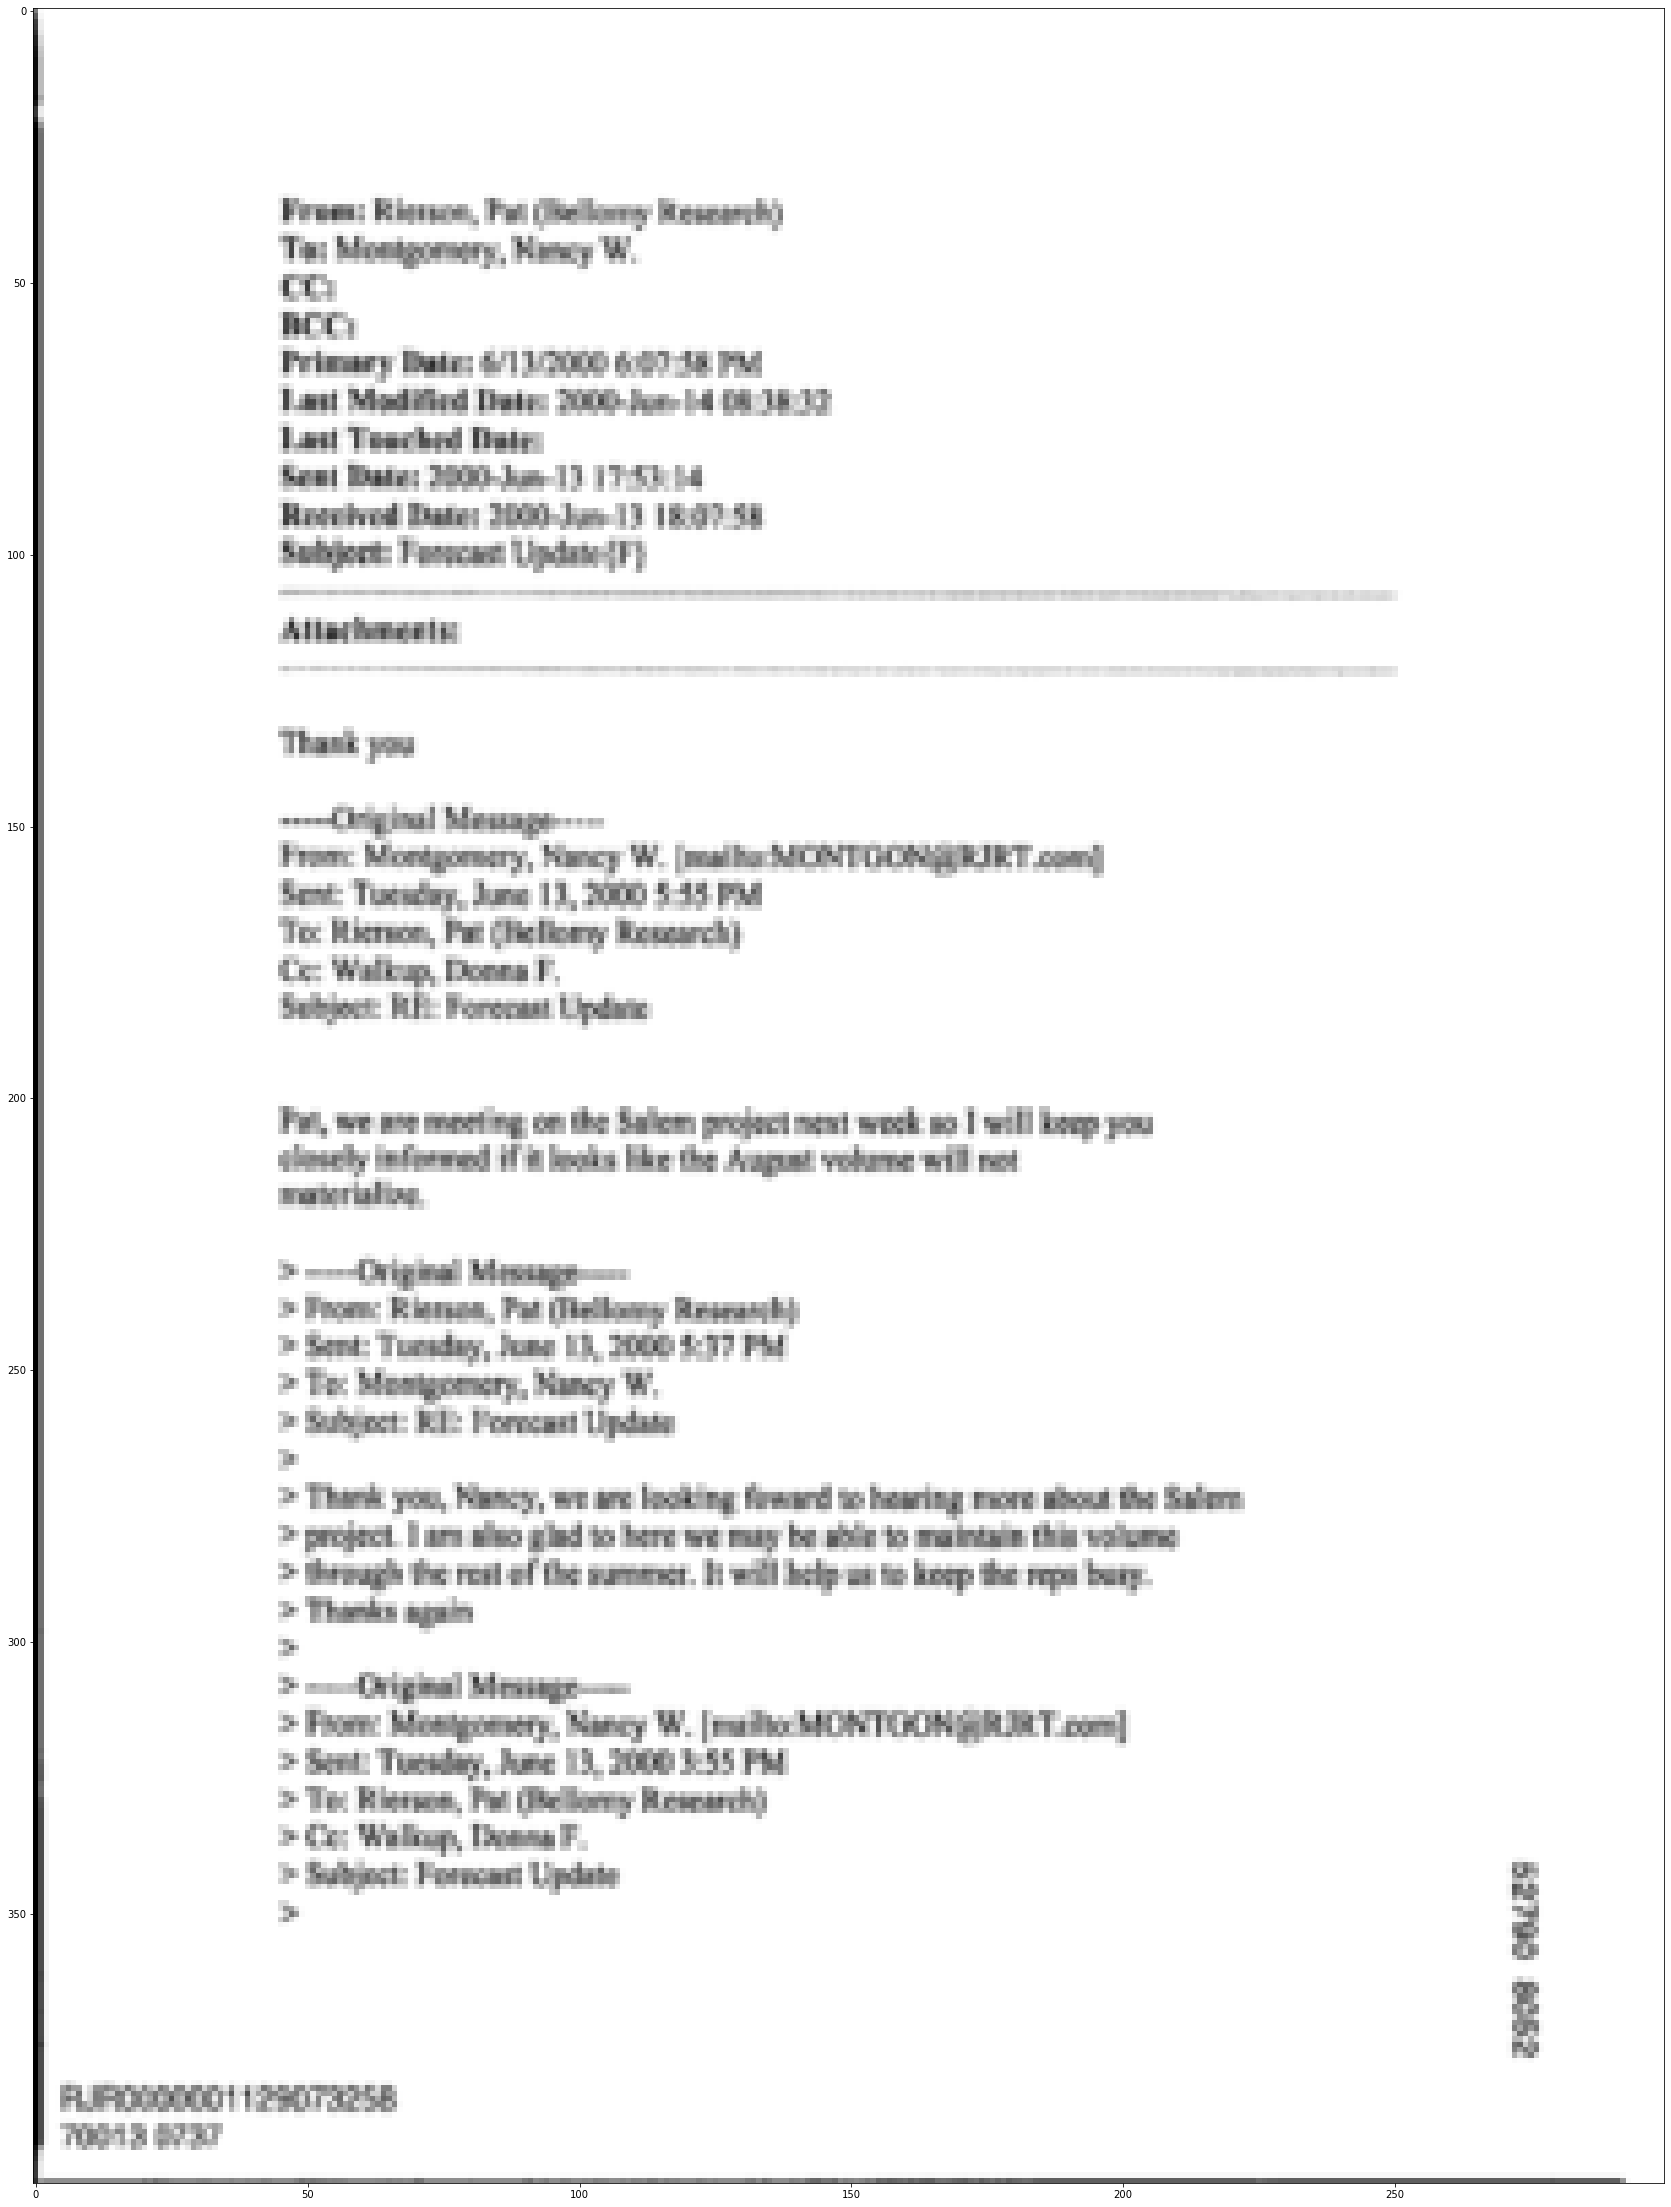

Labels: From: Rierson, Pat (Bellomy Research) ‘To: Montgomery, Nancy W. ce: BCC: Primary Date: 6/13/2000 6:07:58 PM Last Modified Date: 2000-Jun-14 08:38:32 Last Touched Dat Sent Date: 2000-Jun-13 17:53:14 Received Date: 2000-Jun-13 18:07:58 Subject: Forecast Update {F}   Attachments:  From: Montgomery, Nancy W. [mailto MONTGON@RIRT.com] Sent: Tuesday, June 13, 2000 5:55 PM 9: Rierson, Pat (Bellomy Research) Ce: Walkup, Donna F. Subject: RE: Forecast Update  Pat, we are meeting on the Salem project next week so 1 will keep you closely informed if it looks like the August volume will not materialize. > =---Original Message---- > From: Rierson, Pat (Bellomy Research) ‘uesday, June 13, 2000 5:37 PM  > Thank you, Nancy, we are looking foward to hearing more about the Salem > project. lam also glad to here we may be able to maintain this volume > through the rest of the summer. It will help us to keep the reps busy. > Thanks again > > +---Original Message---- > From: Montgomery, Nancy W. [m

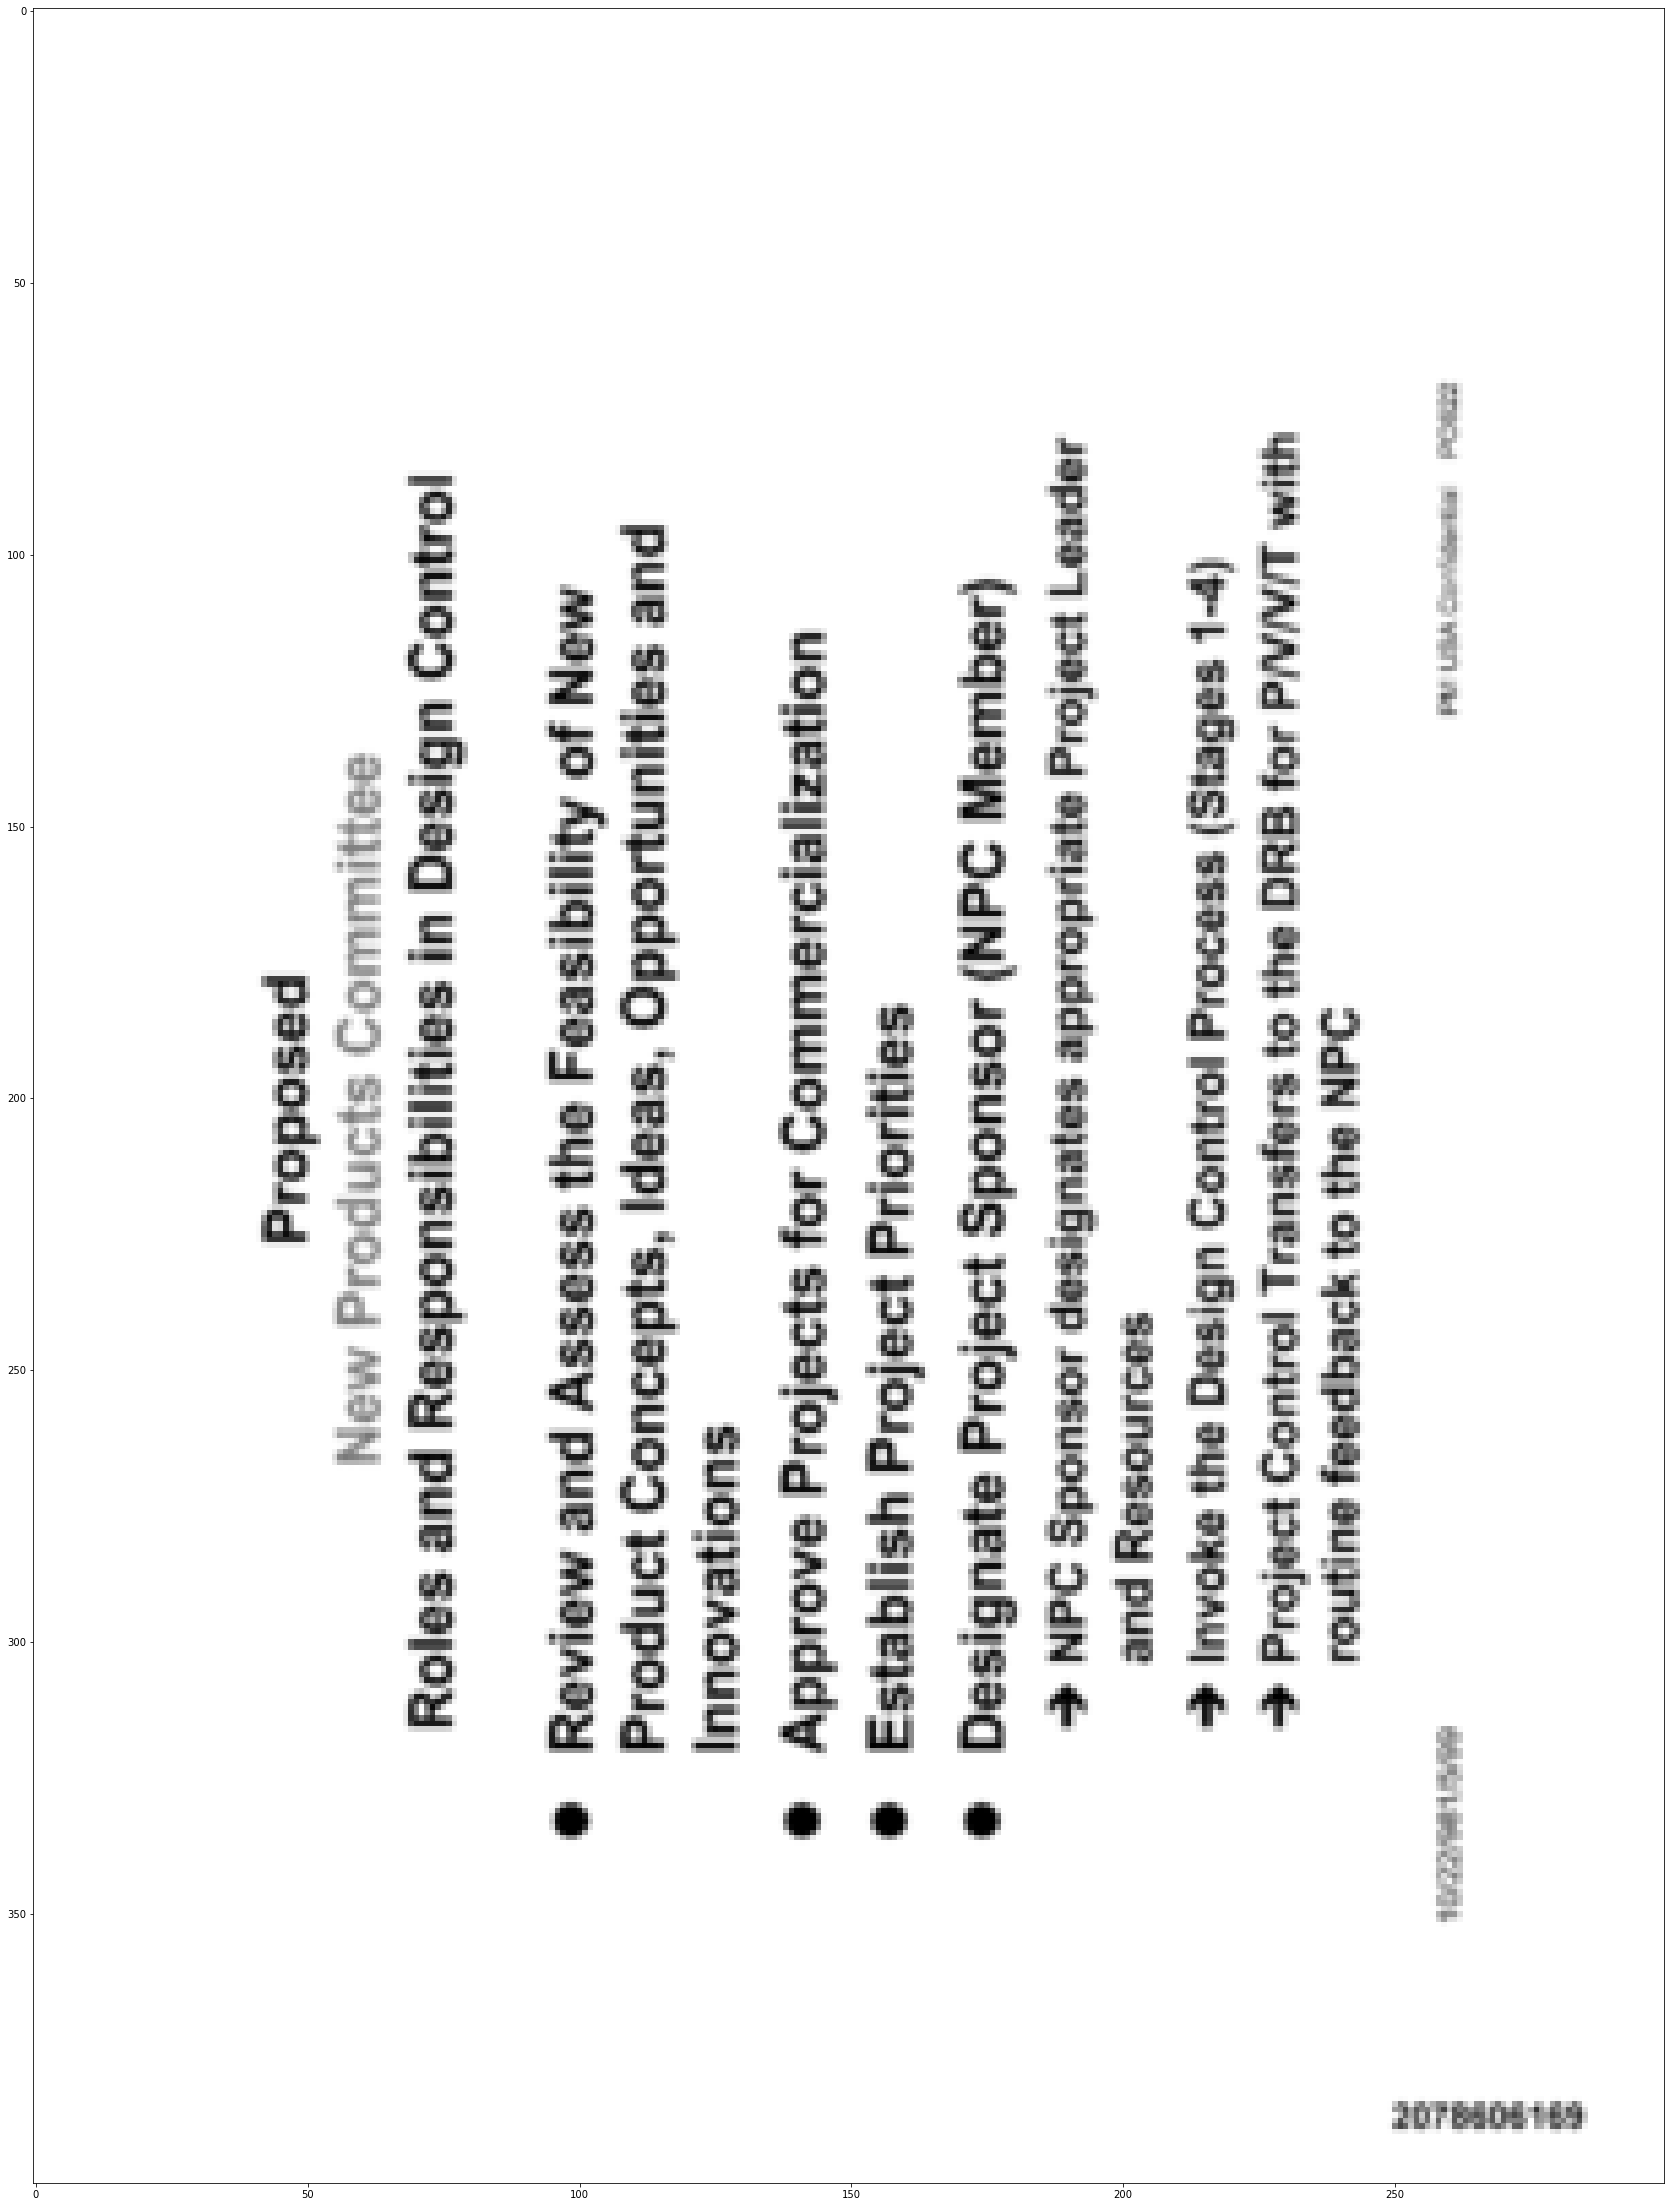

Labels: 2078606169 Proposed New Products Committee Roles and Responsibilities in Design Control Review and Assess the Feasibility of New Product Concepts, Ideas, Opportunities and Innovations Approve Projects for Commercialization Establish Project Priorities Designate Project Sponsor (NPC Member) > NPC Sponsor designates appropriate Project Leader and Resources > Invoke the Design Control Process (Stages 1-4) > Project Control Transfers to the DRB for P/V/V/T with routine feedback to the NPC 10/22/981/5/99 PM USA Confidential P0622
Pred: 2078569489 e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee ee e

In [36]:
batch = next(iter(test_dl))
batch[0] = batch[0].cuda()

test_model.eval()

with torch.no_grad():
    pred_tokens = test_model(batch)

decoded_preds = [test_model.tokenizer.decode(t) for t in pred_tokens]

images, labels, tokens = batch

for image, label, pred in zip(images, labels, decoded_preds):
    plt.figure(figsize=(30, 40))
    plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
    plt.show()
    print(f'Labels: {label}\nPred: {pred}\n')

## Observações

 

**1. Pode ser observado um boa captura dos caracteres para várias imagens. Obtendo uma performance razóavel dado a dificulade do problema e também sendo usado o modelo mais simples que é o efficient-B0 e T5 small**

**2. O uso de modelos maiores como efficient B5 e T5 base poderia melhorar mais ainda, mas é necessário mais capacidade computacional dado o tamanho do dataset**

**3. Imagens com orientação vertical tiveram uma performance pior sendo mais difíceis de ser capturado.**

## Curvas de Perda (Loss) e F1 

**1. Como pode ser observado o treino durou aproximadamente 11 dias (começando dia 15 de dezembro e finalizando dia 26 de dezembro de 2020).**

**2. A loss continuava descendo e o F1 subindo podendo melhorar bastante ainda.**

**3. Como para Para trabalhar no fine-tuning interrompi o pre-treino.**

![title](loss_epoch.PNG)

![title](f1_score.PNG)